In [2]:
import numpy as np
import matplotlib.pyplot as plt
import enum
import scipy.integrate as integrate
from scipy.stats import norm
import scipy as sp

from tqdm import tqdm
colors = plt.get_cmap('Set2').colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
from scipy import integrate
from scipy.integrate import quad  # Module d'intégration "quad"



<h3> Prise en compte de l'intensité de défault : </h3>
    
On va supposer une intensité de défault comme suit :
    
\begin{equation}
    d\lambda_t = \kappa^{\lambda} (\theta^{\lambda} - \lambda_t)dt + \sigma^{\lambda} \sqrt{\lambda_t} dW_t
\end{equation}

Avec :

- $\kappa^{\lambda}=0.35$
- $\theta^{\lambda}=0.12$
- $\sigma^{\lambda}=0.12$
- $\lambda_{0}=0.12$


Monte Carlo 2D Approximation : 

On calcule $G(t)=P(\tau > t) =\mathbb{E}^{Q} [e^{-\int_{0}^{t} \lambda_u du}]$

Avec ici une diffusion CIR pour $\lambda$ donc on sait que :

- $G(t)=A^{\lambda}(0,t)e^{-B^{\lambda}(0,t) \lambda_0}$

Avec :

- $A^{\lambda}(0,t)=(\frac{he^({\frac{\kappa + h}{2}\tau})}{e^{h\tau}-1} B^{CIR}(s,t))^{\frac{2 \kappa \theta}{\sigma^{2}}}$
- $B^{\lambda}(0,t)=\frac{e^{h\tau}-1}{h + \frac{\kappa +h}{2}(e^{h \tau}-1)}$
- $h =\sqrt{\kappa^2 + 2 \sigma^2}$


Sous le papier de Brigo, on peut arriver à la formule suivante : 

$CVA_t = (1-R) \int_{t}^{T} \mathbb{E}^{Q} [\frac{(V_s)^+}{B_s} \xi_s |F_t] dG_s $ 

Avec : 

- $ \xi_s =\frac{\lambda_s S_s}{h(s) G(s)} $
- $ S_t = e^{- \Lambda_t}$ avec $\Lambda_t = \int_{0}^{t} \lambda_u du $




In [3]:
# CIR Modelling

def ACIR(kappa,sigma,theta,T1,T2):
    h=np.sqrt(pow(kappa,2) + 2 * pow(sigma,2))
    BCIRValue=BCIR(kappa,sigma,theta,T1,T2)
    tau=T2-T1
    return pow((h*np.exp(0.5*tau * (kappa+h))*BCIRValue)/ (np.exp(h*tau) - 1), 2*kappa*theta / sigma**2)

def BCIR(kappa,sigma,theta,T1,T2):
    h=np.sqrt(pow(kappa,2) + 2 * pow(sigma,2))
    tau=T2-T1
    numerator=np.exp(h*tau) - 1
    denominator =  h + 0.5*(kappa+h)*(np.exp(h*tau)-1)
    return numerator / denominator


def CIR_ZCB(kappa,sigma,theta,T1,T2,rT1):
    
    if T1==T2:
        return 1
    else:
        B_r=BCIR(kappa,sigma,theta,T1,T2)
        A_r=ACIR(kappa,sigma,theta,T1,T2)
        return A_r * np.exp(-B_r * rT1)
    


In [4]:
def CVAComputation(NbrPaths,NbrSteps,T,rhor):
     
    
    # Setting Parameters
    
    
    dt= T / NbrSteps
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    rhom=0
    lambda0=0.12
    S0=1
    v0=0.04
    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)

    
    # Defining Fitting Curve to Initial ZCBondsIntensity
    #theta = lambda t: 1.0/lambd * (hfunc(t+dt)-hfunc(t-dt))/(2.0*dt) + hfunc(t) + \
    #sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    
    
    mean= [0,0,0]
    cov=[[1,rhom,rhor],[rhom,1,0],[rhor,0,1]]
    
    
    V= np.zeros((NbrPaths, NbrSteps))
    S=np.ones(([NbrPaths, NbrSteps]))

    Survival=np.ones(([NbrPaths, NbrSteps]))
    λ=np.zeros(([NbrPaths,NbrSteps]))
    eta=np.zeros(([NbrPaths,NbrSteps]))

    
    S[:,0]=  S0
    v[:,0] = v0
    λ[:,0]=lambda0

    time = np.zeros([NbrSteps])
    EE=np.zeros(([NbrSteps]))
    
        
    for i in range(1,NbrSteps): 
        current_t=float(i*dt)
        WT=np.random.multivariate_normal(mean,cov,NbrPaths)*np.sqrt(dt)
        
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + np.sqrt(v[:,i-1]) *WT[:,0])
        v[:,i]=np.abs(v[:,i-1] + kappa*(theta-v[:,i-1]) *dt +sigma* np.sqrt(v[:,i-1])*WT[:,1])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))*WT[:,2]
        Survival[:,i]=Survival[:,i-1]*np.exp(-(λ[:,i]+λ[:,i-1])*0.5*dt)
    
    CVA=0
    
    for j in tqdm(range(NbrSteps)):
        current_t=float(j*dt)
        current_price=np.zeros((NbrPaths))
        for sample in range(NbrPaths):
            current_S=S[sample,j]
            current_v=v[sample,j]
            _,_,_,_,price=CliquetOptionHestonModel(current_S,current_t,T,v0=current_v, NbrSteps=21,NbrPaths=10000,nbFixings=2)
            current_price[sample]=price
        
        
        eta[:,j]=np.exp(-r*current_t) * (current_price*λ[:,j]*Survival[:,j]) / (h(current_t) * Gfunc(current_t))
        EE[j]=np.mean(eta[:,j])
        CVA+= - (1-R) * EE[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
        print(EE)
        print(CVA)
        
    
        
    # Outputs
    return λ,S,EE,CVA



In [5]:
dt= T / NbrSteps
kappalambd=0.35
thetalambd=0.12
sigmalambd=0.12
rhom=0
lambda0=0.12
S0=1
v0=0.04
# We define a CDS Discount curve (obtained from the market)
Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)

NameError: name 'T' is not defined

In [5]:
rhor=-0.9
NbrPaths=1000
NbrSteps=20
T=1
#λ,S,EE,CVA=CVAComputation(NbrPaths,NbrSteps,T,rhor)

<h3> Call and Forward Option in a BS Setting : </h3> 

In [6]:

N = norm.cdf

def BS_CALL(S, K, t, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    return S * N(d1) - K * np.exp(-r*(T-t))* N(d2)


def BS_Forward(S,K,t,T,r):
    return S - K*np.exp(-r*(T-t))

In [7]:
def CVAComputationBS(NbrPaths,NbrSteps,T,rho):
     
    
    # Setting Parameters
    
    
    dt= T / NbrSteps
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
    
    # BS Diffusion Parameters
    S0=100
    r=0.03
    sigma=0.2
    K=100
    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)

    
    # Defining Fitting Curve to Initial ZCBondsIntensity
    #theta = lambda t: 1.0/lambd * (hfunc(t+dt)-hfunc(t-dt))/(2.0*dt) + hfunc(t) + \
    #sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    
    
    
    # Defining the Correlation Parameter
    mean= [0,0]
    cov=[[1,rho],[rho,1]]
    
    
    
    
    S=np.ones(([NbrPaths, NbrSteps]))
    Survival=np.ones(([NbrPaths, NbrSteps]))
    λ=np.zeros(([NbrPaths,NbrSteps]))
    
    
    etacallWWR=np.zeros(([NbrPaths,NbrSteps]))
    etacallNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaforwardWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaforwardNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    
    S[:,0]=  S0
    λ[:,0]=lambda0

    EECallWWR=np.zeros(([NbrSteps]))
    EECallNoWWR=np.zeros(([NbrSteps]))
    EEForwardWWR=np.zeros(([NbrSteps]))
    EEForwardNoWWR=np.zeros(([NbrSteps]))
        
    for i in range(1,NbrSteps): 
        current_t=float(i*dt)
        WT=np.random.multivariate_normal(mean,cov,NbrPaths)*np.sqrt(dt)
         
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT[:,0])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))*WT[:,1]
        Survival[:,i]=Survival[:,i-1]*np.exp(-(λ[:,i]+λ[:,i-1])*0.5*dt)
    
    
    CVACallWWR=0
    CVACallNoWWR=0
    CVAForwardWWR=0
    CVAForwardNoWWR=0
    RecoveryRate=0.4
    
    for j in tqdm(range(NbrSteps)):
        current_t=float(j*dt)
        current_pricecall=np.zeros((NbrPaths))
        current_priceforward=np.zeros((NbrPaths))
        print(j)
        for sample in range(NbrPaths):
            current_S=S[sample,j]
            pricecall=BS_CALL(current_S,K,current_t,T,r,sigma)
            priceforward=BS_Forward(current_S,K,current_t,T,r)
            current_pricecall[sample]=pricecall
            current_priceforward[sample]=priceforward
            
        
        etacallWWR[:,j]=np.exp(-r*current_t) * (current_pricecall*λ[:,j]*Survival[:,j]) / (h(current_t) * Gfunc(current_t))
        etacallNoWWR[:,j]=np.exp(-r*current_t) * (current_pricecall)
        
    
        EECallWWR[j]=np.mean(etacallWWR[:,j])
        EECallNoWWR[j]=np.mean(etacallNoWWR[:,j])
        
        etaforwardWWR[:,j]=np.exp(-r*current_t) * (np.maximum(current_priceforward,0)*λ[:,j]*Survival[:,j]) / (h(current_t) * Gfunc(current_t))
        etaforwardNoWWR[:,j]=np.exp(-r*current_t) * (np.maximum(current_priceforward,0))

        EEForwardWWR[j]=np.mean(etaforwardWWR[:,j])
        EEForwardNoWWR[j]=np.mean(etaforwardNoWWR[:,j])
        
        CVACallWWR   += - (1-RecoveryRate) * EECallWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
        CVACallNoWWR += - (1-RecoveryRate) * EECallNoWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
        CVAForwardWWR += - (1-RecoveryRate) * EEForwardWWR[j] * (Gfunc(current_t+dt)-Gfunc(current_t))
        CVAForwardNoWWR += - (1-RecoveryRate) * EEForwardNoWWR[j] * (Gfunc(current_t+dt)-Gfunc(current_t))
        #print(EE[j])
        
        
    
        
    # Outputs
    return λ,S,EECallWWR,CVACallWWR,EECallNoWWR,CVACallNoWWR,EEForwardWWR,CVAForwardWWR,EEForwardNoWWR,CVAForwardNoWWR



In [8]:
NbrSteps=50
NbrPaths=5000
T=1
rho=0

In [9]:
λ,S,EECallWWR,CVACallWWR,EECallNoWWR,CVACallNoWWR,EEForwardWWR,CVAForwardWWR,EEForwardNoWWR,CVAForwardNoWWR=CVAComputationBS(NbrPaths,NbrSteps,T,rho)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0


  2%|█▋                                                                                 | 1/50 [00:00<00:37,  1.32it/s]

1


  4%|███▎                                                                               | 2/50 [00:01<00:39,  1.22it/s]

2


  6%|████▉                                                                              | 3/50 [00:02<00:37,  1.27it/s]

3


  8%|██████▋                                                                            | 4/50 [00:03<00:36,  1.26it/s]

4


 10%|████████▎                                                                          | 5/50 [00:04<00:40,  1.11it/s]

5


 12%|█████████▉                                                                         | 6/50 [00:05<00:41,  1.06it/s]

6


 14%|███████████▌                                                                       | 7/50 [00:06<00:38,  1.12it/s]

7


 16%|█████████████▎                                                                     | 8/50 [00:06<00:35,  1.19it/s]

8


 18%|██████████████▉                                                                    | 9/50 [00:07<00:35,  1.16it/s]

9


 20%|████████████████▍                                                                 | 10/50 [00:08<00:33,  1.18it/s]

10


 22%|██████████████████                                                                | 11/50 [00:09<00:32,  1.22it/s]

11


 24%|███████████████████▋                                                              | 12/50 [00:10<00:31,  1.22it/s]

12


 26%|█████████████████████▎                                                            | 13/50 [00:11<00:31,  1.19it/s]

13


 28%|██████████████████████▉                                                           | 14/50 [00:11<00:30,  1.18it/s]

14


 30%|████████████████████████▌                                                         | 15/50 [00:12<00:28,  1.21it/s]

15


 32%|██████████████████████████▏                                                       | 16/50 [00:13<00:27,  1.24it/s]

16


 34%|███████████████████████████▉                                                      | 17/50 [00:14<00:26,  1.24it/s]

17


 34%|███████████████████████████▉                                                      | 17/50 [00:14<00:28,  1.14it/s]


KeyboardInterrupt: 

In [17]:
EEForwardWWR

array([2.95544948, 3.25606181, 3.63198506, 3.851222  , 4.1176758 ,
       4.3154615 , 4.5045779 , 4.67531193, 4.88335778, 5.05773637,
       5.17581875, 5.34600448, 5.49400192, 5.65627363, 5.82095222,
       5.92447406, 6.06306516, 6.16427858, 6.24826538, 6.35291324,
       6.46177449, 6.59727446, 6.76616754, 6.91872725, 7.04332598,
       7.17403611, 7.28843665, 7.40363532, 7.54456375, 7.68229068,
       7.78673589, 7.94298534, 8.08391959, 8.14778806, 8.27627622,
       8.39246132, 8.50540098, 8.61387427, 8.70851797, 8.74078914,
       8.8177069 , 8.90192107, 8.99666531, 9.0513595 , 9.08858356,
       9.17767351, 9.23460005, 9.28574303, 9.31195321, 9.45541165])

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0


  2%|█▋                                                                                 | 1/50 [00:08<06:33,  8.04s/it]

1


  4%|███▎                                                                               | 2/50 [00:15<06:03,  7.57s/it]

2


  6%|████▉                                                                              | 3/50 [00:23<06:12,  7.92s/it]

3


  8%|██████▋                                                                            | 4/50 [00:32<06:25,  8.38s/it]

4


 10%|████████▎                                                                          | 5/50 [00:40<06:14,  8.31s/it]

5


 12%|█████████▉                                                                         | 6/50 [00:49<06:13,  8.48s/it]

6


 14%|███████████▌                                                                       | 7/50 [00:59<06:23,  8.91s/it]

7


 16%|█████████████▎                                                                     | 8/50 [01:07<06:07,  8.75s/it]

8


 18%|██████████████▉                                                                    | 9/50 [01:17<06:06,  8.95s/it]

9


 20%|████████████████▍                                                                 | 10/50 [01:27<06:10,  9.26s/it]

10


 22%|██████████████████                                                                | 11/50 [01:36<06:07,  9.41s/it]

11


 24%|███████████████████▋                                                              | 12/50 [01:46<05:57,  9.40s/it]

12


 26%|█████████████████████▎                                                            | 13/50 [01:55<05:39,  9.17s/it]

13


 28%|██████████████████████▉                                                           | 14/50 [02:03<05:26,  9.08s/it]

14


 30%|████████████████████████▌                                                         | 15/50 [02:12<05:16,  9.06s/it]

15


 32%|██████████████████████████▏                                                       | 16/50 [02:21<05:00,  8.85s/it]

16


 34%|███████████████████████████▉                                                      | 17/50 [02:29<04:49,  8.78s/it]

17


 36%|█████████████████████████████▌                                                    | 18/50 [02:38<04:44,  8.88s/it]

18


 38%|███████████████████████████████▏                                                  | 19/50 [02:47<04:31,  8.77s/it]

19


 40%|████████████████████████████████▊                                                 | 20/50 [02:57<04:30,  9.02s/it]

20


 42%|██████████████████████████████████▍                                               | 21/50 [03:05<04:18,  8.90s/it]

21


 44%|████████████████████████████████████                                              | 22/50 [03:14<04:06,  8.79s/it]

22


 46%|█████████████████████████████████████▋                                            | 23/50 [03:23<03:57,  8.81s/it]

23


 48%|███████████████████████████████████████▎                                          | 24/50 [03:32<03:54,  9.00s/it]

24


 50%|█████████████████████████████████████████                                         | 25/50 [03:41<03:44,  8.96s/it]

25


 52%|██████████████████████████████████████████▋                                       | 26/50 [03:50<03:35,  8.99s/it]

26


 54%|████████████████████████████████████████████▎                                     | 27/50 [03:58<03:20,  8.72s/it]

27


 56%|█████████████████████████████████████████████▉                                    | 28/50 [04:06<03:06,  8.48s/it]

28


 58%|███████████████████████████████████████████████▌                                  | 29/50 [04:14<02:55,  8.35s/it]

29


 60%|█████████████████████████████████████████████████▏                                | 30/50 [04:22<02:43,  8.20s/it]

30


 62%|██████████████████████████████████████████████████▊                               | 31/50 [04:30<02:37,  8.27s/it]

31


 64%|████████████████████████████████████████████████████▍                             | 32/50 [04:39<02:28,  8.25s/it]

32


 66%|██████████████████████████████████████████████████████                            | 33/50 [04:46<02:18,  8.12s/it]

33


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [04:54<02:07,  7.94s/it]

34


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [05:01<01:55,  7.73s/it]

35


 72%|███████████████████████████████████████████████████████████                       | 36/50 [05:08<01:46,  7.58s/it]

36


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [05:16<01:39,  7.66s/it]

37


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [05:24<01:30,  7.55s/it]

38


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [05:31<01:22,  7.53s/it]

39


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [05:38<01:14,  7.49s/it]

40


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [05:46<01:06,  7.42s/it]

41


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [05:53<00:59,  7.45s/it]

42


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [06:01<00:51,  7.42s/it]

43


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [06:08<00:44,  7.39s/it]

44


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [06:16<00:37,  7.57s/it]

45


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [06:24<00:30,  7.75s/it]

46


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [06:33<00:24,  8.07s/it]

47


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [06:41<00:16,  8.08s/it]

48


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [06:49<00:08,  8.06s/it]

49


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0


  2%|█▋                                                                                 | 1/50 [00:08<06:37,  8.11s/it]

1


  4%|███▎                                                                               | 2/50 [00:15<06:20,  7.93s/it]

2


  6%|████▉                                                                              | 3/50 [00:23<06:12,  7.92s/it]

3


  8%|██████▋                                                                            | 4/50 [00:32<06:18,  8.22s/it]

4


 10%|████████▎                                                                          | 5/50 [00:40<06:14,  8.31s/it]

5


 12%|█████████▉                                                                         | 6/50 [00:49<06:04,  8.28s/it]

6


 14%|███████████▌                                                                       | 7/50 [00:57<06:01,  8.40s/it]

7


 16%|█████████████▎                                                                     | 8/50 [01:05<05:47,  8.28s/it]

8


 18%|██████████████▉                                                                    | 9/50 [01:13<05:33,  8.13s/it]

9


 20%|████████████████▍                                                                 | 10/50 [01:21<05:22,  8.07s/it]

10


 22%|██████████████████                                                                | 11/50 [01:30<05:22,  8.28s/it]

11


 24%|███████████████████▋                                                              | 12/50 [01:39<05:24,  8.55s/it]

12


 26%|█████████████████████▎                                                            | 13/50 [01:48<05:23,  8.73s/it]

13


 28%|██████████████████████▉                                                           | 14/50 [01:58<05:21,  8.93s/it]

14


 30%|████████████████████████▌                                                         | 15/50 [02:07<05:17,  9.08s/it]

15


 32%|██████████████████████████▏                                                       | 16/50 [02:17<05:14,  9.25s/it]

16


 34%|███████████████████████████▉                                                      | 17/50 [02:26<05:04,  9.23s/it]

17


 36%|█████████████████████████████▌                                                    | 18/50 [02:35<04:58,  9.33s/it]

18


 38%|███████████████████████████████▏                                                  | 19/50 [02:45<04:47,  9.27s/it]

19


 40%|████████████████████████████████▊                                                 | 20/50 [02:53<04:28,  8.95s/it]

20


 42%|██████████████████████████████████▍                                               | 21/50 [03:02<04:23,  9.07s/it]

21


 44%|████████████████████████████████████                                              | 22/50 [03:11<04:10,  8.94s/it]

22


 46%|█████████████████████████████████████▋                                            | 23/50 [03:19<03:55,  8.72s/it]

23


 48%|███████████████████████████████████████▎                                          | 24/50 [03:27<03:39,  8.45s/it]

24


 50%|█████████████████████████████████████████                                         | 25/50 [03:35<03:27,  8.32s/it]

25


 52%|██████████████████████████████████████████▋                                       | 26/50 [03:43<03:15,  8.16s/it]

26


 54%|████████████████████████████████████████████▎                                     | 27/50 [03:51<03:08,  8.19s/it]

27


 56%|█████████████████████████████████████████████▉                                    | 28/50 [03:59<03:00,  8.21s/it]

28


 58%|███████████████████████████████████████████████▌                                  | 29/50 [04:07<02:52,  8.19s/it]

29


 60%|█████████████████████████████████████████████████▏                                | 30/50 [04:15<02:44,  8.20s/it]

30


 62%|██████████████████████████████████████████████████▊                               | 31/50 [04:24<02:36,  8.21s/it]

31


 64%|████████████████████████████████████████████████████▍                             | 32/50 [04:32<02:27,  8.18s/it]

32


 66%|██████████████████████████████████████████████████████                            | 33/50 [04:40<02:19,  8.21s/it]

33


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [04:48<02:11,  8.21s/it]

34


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [04:57<02:03,  8.22s/it]

35


 72%|███████████████████████████████████████████████████████████                       | 36/50 [05:05<01:56,  8.35s/it]

36


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [05:14<01:48,  8.38s/it]

37


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [05:22<01:39,  8.27s/it]

38


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [05:30<01:32,  8.41s/it]

39


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [05:39<01:24,  8.49s/it]

40


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [05:47<01:15,  8.41s/it]

41


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [05:56<01:07,  8.46s/it]

42


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [06:04<00:59,  8.50s/it]

43


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [06:13<00:50,  8.48s/it]

44


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [06:22<00:43,  8.68s/it]

45


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [06:31<00:35,  8.83s/it]

46


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [06:39<00:26,  8.67s/it]

47


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [06:48<00:17,  8.70s/it]

48


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [06:56<00:08,  8.56s/it]

49


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0


  2%|█▋                                                                                 | 1/50 [00:08<06:58,  8.54s/it]

1


  4%|███▎                                                                               | 2/50 [00:16<06:44,  8.42s/it]

2


  6%|████▉                                                                              | 3/50 [00:26<07:01,  8.96s/it]

3


  8%|██████▋                                                                            | 4/50 [00:38<07:43, 10.09s/it]

4


 10%|████████▎                                                                          | 5/50 [00:46<07:10,  9.57s/it]

5


 12%|█████████▉                                                                         | 6/50 [00:55<06:46,  9.24s/it]

6


 14%|███████████▌                                                                       | 7/50 [01:03<06:24,  8.93s/it]

7


 16%|█████████████▎                                                                     | 8/50 [01:12<06:07,  8.76s/it]

8


 18%|██████████████▉                                                                    | 9/50 [01:20<05:54,  8.64s/it]

9


 20%|████████████████▍                                                                 | 10/50 [01:29<05:52,  8.81s/it]

10


 22%|██████████████████                                                                | 11/50 [01:38<05:40,  8.73s/it]

11


 24%|███████████████████▋                                                              | 12/50 [01:46<05:25,  8.56s/it]

12


 26%|█████████████████████▎                                                            | 13/50 [01:54<05:09,  8.38s/it]

13


 28%|██████████████████████▉                                                           | 14/50 [02:03<05:08,  8.58s/it]

14


 30%|████████████████████████▌                                                         | 15/50 [02:12<05:01,  8.60s/it]

15


 32%|██████████████████████████▏                                                       | 16/50 [02:20<04:47,  8.45s/it]

16


 34%|███████████████████████████▉                                                      | 17/50 [02:28<04:37,  8.39s/it]

17


 36%|█████████████████████████████▌                                                    | 18/50 [02:36<04:27,  8.35s/it]

18


 38%|███████████████████████████████▏                                                  | 19/50 [02:44<04:12,  8.15s/it]

19


 40%|████████████████████████████████▊                                                 | 20/50 [02:52<04:05,  8.18s/it]

20


 42%|██████████████████████████████████▍                                               | 21/50 [03:00<03:52,  8.02s/it]

21


 44%|████████████████████████████████████                                              | 22/50 [03:08<03:43,  7.99s/it]

22


 46%|█████████████████████████████████████▋                                            | 23/50 [03:16<03:35,  7.98s/it]

23


 48%|███████████████████████████████████████▎                                          | 24/50 [03:24<03:27,  8.00s/it]

24


 50%|█████████████████████████████████████████                                         | 25/50 [03:32<03:19,  7.99s/it]

25


 52%|██████████████████████████████████████████▋                                       | 26/50 [03:40<03:11,  7.99s/it]

26


 54%|████████████████████████████████████████████▎                                     | 27/50 [03:48<03:06,  8.10s/it]

27


 56%|█████████████████████████████████████████████▉                                    | 28/50 [03:56<02:55,  7.96s/it]

28


 58%|███████████████████████████████████████████████▌                                  | 29/50 [04:04<02:46,  7.93s/it]

29


 60%|█████████████████████████████████████████████████▏                                | 30/50 [04:12<02:41,  8.06s/it]

30


 62%|██████████████████████████████████████████████████▊                               | 31/50 [04:20<02:33,  8.06s/it]

31


 64%|████████████████████████████████████████████████████▍                             | 32/50 [04:29<02:32,  8.46s/it]

32


 66%|██████████████████████████████████████████████████████                            | 33/50 [04:38<02:26,  8.61s/it]

33


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [04:47<02:17,  8.57s/it]

34


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [04:55<02:05,  8.38s/it]

35


 72%|███████████████████████████████████████████████████████████                       | 36/50 [05:03<01:56,  8.29s/it]

36


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [05:11<01:45,  8.14s/it]

37


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [05:19<01:36,  8.06s/it]

38


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [05:27<01:29,  8.17s/it]

39


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [05:35<01:21,  8.14s/it]

40


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [05:43<01:13,  8.22s/it]

41


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [05:51<01:04,  8.05s/it]

42


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [05:59<00:56,  8.08s/it]

43


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [06:08<00:49,  8.17s/it]

44


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [06:15<00:40,  8.05s/it]

45


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [06:24<00:33,  8.25s/it]

46


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [06:32<00:24,  8.18s/it]

47


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [06:40<00:16,  8.09s/it]

48


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [06:49<00:08,  8.29s/it]

49


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0


  2%|█▋                                                                                 | 1/50 [00:07<06:24,  7.85s/it]

1


  4%|███▎                                                                               | 2/50 [00:15<06:16,  7.84s/it]

2


  6%|████▉                                                                              | 3/50 [00:23<06:06,  7.81s/it]

3


  8%|██████▋                                                                            | 4/50 [00:32<06:15,  8.16s/it]

4


 10%|████████▎                                                                          | 5/50 [00:40<06:15,  8.34s/it]

5


 12%|█████████▉                                                                         | 6/50 [00:48<06:00,  8.18s/it]

6


 14%|███████████▌                                                                       | 7/50 [00:56<05:48,  8.11s/it]

7


 16%|█████████████▎                                                                     | 8/50 [01:04<05:36,  8.01s/it]

8


 18%|██████████████▉                                                                    | 9/50 [01:11<05:20,  7.82s/it]

9


 20%|████████████████▍                                                                 | 10/50 [01:19<05:06,  7.66s/it]

10


 22%|██████████████████                                                                | 11/50 [01:27<05:04,  7.82s/it]

11


 24%|███████████████████▋                                                              | 12/50 [01:35<04:59,  7.89s/it]

12


 26%|█████████████████████▎                                                            | 13/50 [01:43<04:52,  7.90s/it]

13


 28%|██████████████████████▉                                                           | 14/50 [01:51<04:46,  7.96s/it]

14


 30%|████████████████████████▌                                                         | 15/50 [01:58<04:33,  7.82s/it]

15


 32%|██████████████████████████▏                                                       | 16/50 [02:06<04:24,  7.79s/it]

16


 34%|███████████████████████████▉                                                      | 17/50 [02:14<04:21,  7.92s/it]

17


 36%|█████████████████████████████▌                                                    | 18/50 [02:22<04:11,  7.85s/it]

18


 38%|███████████████████████████████▏                                                  | 19/50 [02:31<04:09,  8.05s/it]

19


 40%|████████████████████████████████▊                                                 | 20/50 [02:38<04:00,  8.02s/it]

20


 42%|██████████████████████████████████▍                                               | 21/50 [02:48<04:03,  8.40s/it]

21


 44%|████████████████████████████████████                                              | 22/50 [02:56<03:53,  8.36s/it]

22


 46%|█████████████████████████████████████▋                                            | 23/50 [03:05<03:49,  8.49s/it]

23


 48%|███████████████████████████████████████▎                                          | 24/50 [03:13<03:40,  8.48s/it]

24


 50%|█████████████████████████████████████████                                         | 25/50 [03:22<03:35,  8.61s/it]

25


 52%|██████████████████████████████████████████▋                                       | 26/50 [03:31<03:27,  8.63s/it]

26


 54%|████████████████████████████████████████████▎                                     | 27/50 [03:40<03:19,  8.68s/it]

27


 56%|█████████████████████████████████████████████▉                                    | 28/50 [03:49<03:14,  8.83s/it]

28


 58%|███████████████████████████████████████████████▌                                  | 29/50 [03:57<03:03,  8.74s/it]

29


 60%|█████████████████████████████████████████████████▏                                | 30/50 [04:06<02:53,  8.67s/it]

30


 62%|██████████████████████████████████████████████████▊                               | 31/50 [04:15<02:46,  8.77s/it]

31


 64%|████████████████████████████████████████████████████▍                             | 32/50 [04:24<02:40,  8.94s/it]

32


 66%|██████████████████████████████████████████████████████                            | 33/50 [04:33<02:30,  8.83s/it]

33


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [04:41<02:17,  8.62s/it]

34


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [04:49<02:05,  8.38s/it]

35


 72%|███████████████████████████████████████████████████████████                       | 36/50 [04:58<02:00,  8.58s/it]

36


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [05:08<01:59,  9.20s/it]

37


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [05:19<01:55,  9.66s/it]

38


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [05:30<01:49,  9.99s/it]

39


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [05:41<01:43, 10.40s/it]

40


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [05:52<01:33, 10.42s/it]

41


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [06:02<01:23, 10.42s/it]

42


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [06:11<01:08,  9.79s/it]

43


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [06:19<00:56,  9.48s/it]

44


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [06:31<00:50, 10.10s/it]

45


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [06:42<00:41, 10.30s/it]

46


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [06:52<00:31, 10.46s/it]

47


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [07:03<00:20, 10.36s/it]

48


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [07:12<00:09,  9.98s/it]

49


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0


  2%|█▋                                                                                 | 1/50 [00:09<07:45,  9.50s/it]

1


  4%|███▎                                                                               | 2/50 [00:18<07:30,  9.39s/it]

2


  6%|████▉                                                                              | 3/50 [00:28<07:17,  9.32s/it]

3


  8%|██████▋                                                                            | 4/50 [00:37<07:08,  9.32s/it]

4


 10%|████████▎                                                                          | 5/50 [00:45<06:47,  9.06s/it]

5


 12%|█████████▉                                                                         | 6/50 [00:55<06:42,  9.16s/it]

6


 14%|███████████▌                                                                       | 7/50 [01:05<06:41,  9.35s/it]

7


 16%|█████████████▎                                                                     | 8/50 [01:14<06:38,  9.50s/it]

8


 18%|██████████████▉                                                                    | 9/50 [01:24<06:34,  9.61s/it]

9


 20%|████████████████▍                                                                 | 10/50 [01:35<06:35,  9.89s/it]

10


 22%|██████████████████                                                                | 11/50 [01:44<06:22,  9.80s/it]

11


 24%|███████████████████▋                                                              | 12/50 [01:54<06:07,  9.68s/it]

12


 26%|█████████████████████▎                                                            | 13/50 [02:03<05:51,  9.50s/it]

13


 28%|██████████████████████▉                                                           | 14/50 [02:13<05:45,  9.60s/it]

14


 30%|████████████████████████▌                                                         | 15/50 [02:22<05:31,  9.47s/it]

15


 32%|██████████████████████████▏                                                       | 16/50 [02:32<05:28,  9.66s/it]

16


 34%|███████████████████████████▉                                                      | 17/50 [02:43<05:33, 10.09s/it]

17


 36%|█████████████████████████████▌                                                    | 18/50 [02:52<05:14,  9.83s/it]

18


 38%|███████████████████████████████▏                                                  | 19/50 [03:02<05:00,  9.69s/it]

19


 40%|████████████████████████████████▊                                                 | 20/50 [03:11<04:50,  9.67s/it]

20


 42%|██████████████████████████████████▍                                               | 21/50 [03:20<04:36,  9.55s/it]

21


 44%|████████████████████████████████████                                              | 22/50 [03:29<04:22,  9.38s/it]

22


 46%|█████████████████████████████████████▋                                            | 23/50 [03:40<04:24,  9.78s/it]

23


 48%|███████████████████████████████████████▎                                          | 24/50 [03:50<04:13,  9.77s/it]

24


 50%|█████████████████████████████████████████                                         | 25/50 [03:59<04:00,  9.62s/it]

25


 52%|██████████████████████████████████████████▋                                       | 26/50 [04:09<03:54,  9.76s/it]

26


 54%|████████████████████████████████████████████▎                                     | 27/50 [04:18<03:36,  9.41s/it]

27


 56%|█████████████████████████████████████████████▉                                    | 28/50 [04:27<03:25,  9.36s/it]

28


 58%|███████████████████████████████████████████████▌                                  | 29/50 [04:36<03:14,  9.26s/it]

29


 60%|█████████████████████████████████████████████████▏                                | 30/50 [04:45<03:02,  9.13s/it]

30


 62%|██████████████████████████████████████████████████▊                               | 31/50 [04:54<02:54,  9.20s/it]

31


 64%|████████████████████████████████████████████████████▍                             | 32/50 [05:03<02:43,  9.06s/it]

32


 66%|██████████████████████████████████████████████████████                            | 33/50 [05:12<02:35,  9.15s/it]

33


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [05:22<02:26,  9.15s/it]

34


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [05:31<02:16,  9.09s/it]

35


 72%|███████████████████████████████████████████████████████████                       | 36/50 [05:40<02:06,  9.06s/it]

36


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [05:49<01:58,  9.15s/it]

37


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [05:58<01:49,  9.13s/it]

38


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [06:08<01:41,  9.26s/it]

39


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [06:17<01:33,  9.33s/it]

40


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [06:26<01:23,  9.30s/it]

41


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [06:36<01:14,  9.33s/it]

42


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [06:45<01:05,  9.34s/it]

43


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [06:54<00:54,  9.16s/it]

44


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [07:03<00:46,  9.23s/it]

45


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [07:13<00:37,  9.32s/it]

46


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [07:22<00:28,  9.43s/it]

47


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [07:32<00:18,  9.48s/it]

48


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [07:42<00:09,  9.67s/it]

49


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:53<00:00,  9.47s/it]


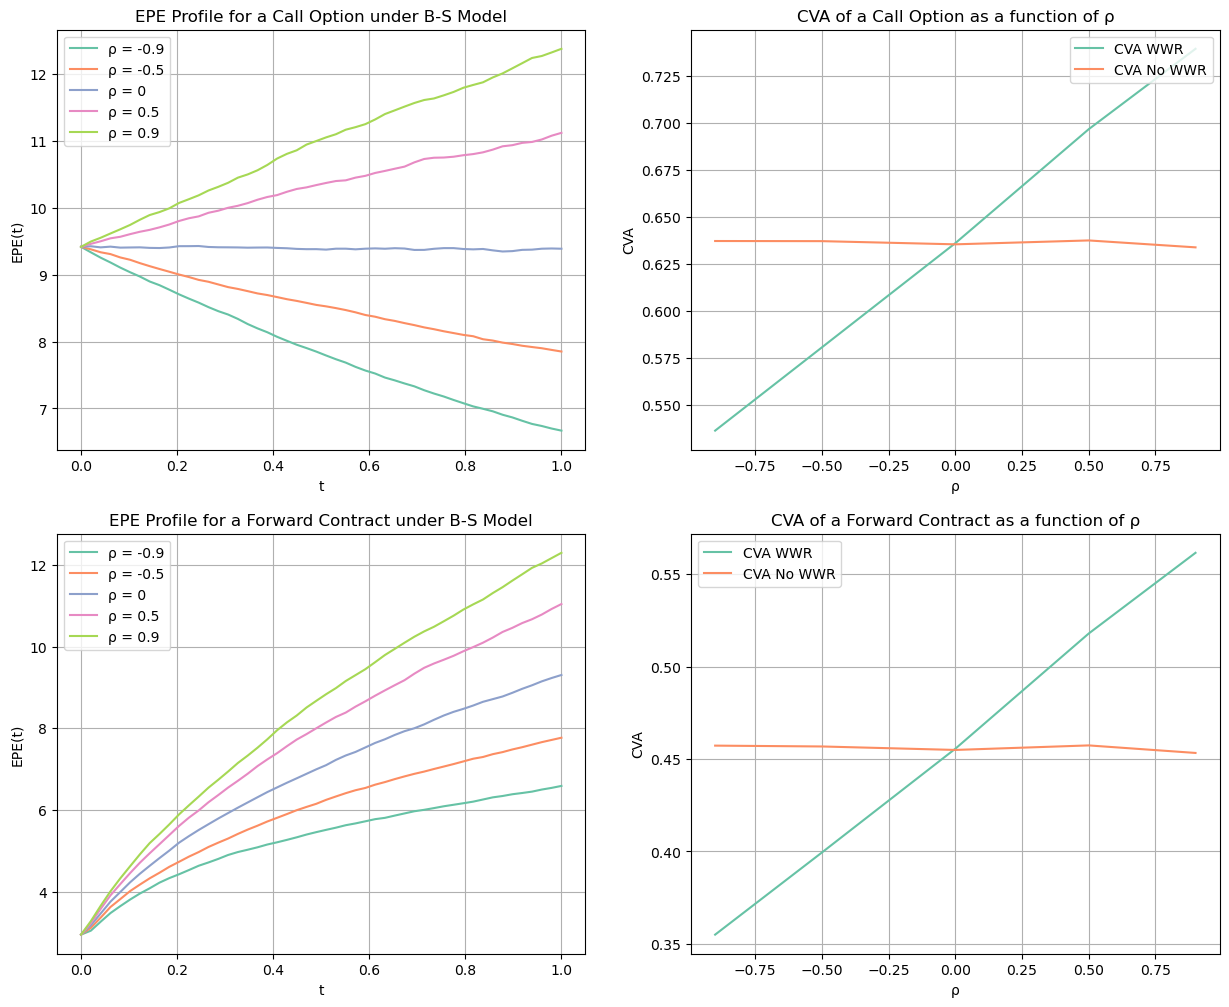

In [10]:
NbrSteps=50
NbrPaths=50000
T=1
rhoVec=[-0.9,-0.5,0,0.5, 0.9]



#
EEValueCallWWR=[]
EEValueCallNoWWR=[]
EEValueForwardWWR=[]
EEValueForwardNoWWR=[]
CVAValueCallWWR=[]
CVAValueCallNoWWR=[]
CVAValueForwardWWR=[]
CVAValueForwardNoWWR=[]
time=np.linspace(0,T,NbrSteps)

#EEForward,CVAForward
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

for rho in rhoVec:
    λ,S,EECallWWR,CVACallWWR,_,CVACallNoWWR,EEForwardWWR,CVAForwardWWR,_,CVAForwardNoWWR=CVAComputationBS(NbrPaths,NbrSteps,T,rho)
    EEValueCallWWR.append(EECallWWR)
    #EEValueCallNoWWR.append(EECallNoWWR)
    EEValueForwardWWR.append(EEForwardWWR)
    #EEValueForwardNoWWR.append(EEForwardNoWWR)
    CVAValueCallWWR.append(CVACallWWR)
    CVAValueCallNoWWR.append(CVACallNoWWR)
    CVAValueForwardWWR.append(CVAForwardWWR)
    CVAValueForwardNoWWR.append(CVAForwardNoWWR)
    ax[0][0].plot(time,EECallWWR,label="ρ = " + str(rho))
    ax[1][0].plot(time,EEForwardWWR,label="ρ = "+str(rho))

    
#
ax[0][0].set_title("EPE Profile for a Call Option under B-S Model")
ax[0][0].set_xlabel("t")
ax[0][0].set_ylabel("EPE(t)")
ax[0][0].legend(loc="upper left")
ax[0][0].grid()
ax[1][0].set_title("EPE Profile for a Forward Contract under B-S Model")
ax[1][0].set_xlabel("t")
ax[1][0].set_ylabel("EPE(t)")
ax[1][0].legend(loc="upper left")
ax[1][0].grid()
#
ax[0][1].plot(rhoVec,CVAValueCallWWR,label="CVA WWR")
ax[0][1].plot(rhoVec,CVAValueCallNoWWR,label="CVA No WWR")
ax[0][1].plot()
ax[0][1].set_title("CVA of a Call Option as a function of ρ")
ax[0][1].set_xlabel("ρ")
ax[0][1].set_ylabel("CVA")
ax[0][1].legend(loc="upper right")
ax[0][1].grid()


ax[1][1].plot(rhoVec,CVAValueForwardWWR,label="CVA WWR")
ax[1][1].plot(rhoVec,CVAValueForwardNoWWR,label="CVA No WWR")
ax[1][1].set_title("CVA of a Forward Contract as a function of ρ")
ax[1][1].set_xlabel("ρ")
ax[1][1].set_ylabel("CVA")
ax[1][1].legend(loc="upper right")
ax[1][1].grid()


plt.legend()


    

<h3> Copula for taking account the WWR : </h3> 

On sait que le calcul de la CVA s'effectue de la manière suivante :

\begin{equation}
CVA = - (1-R)  \int_{0}^{T} \mathbb{E}^{Q}[P(0,t) (V_t)^{+} | \tau =t] dG(t)
\end{equation}

Avec :

- $\tau$ le temps de défault
- $G(t)=P(\tau >t)$ la fonction de survie de $\tau$

On définit alors $EE^{WWR} = \mathbb{E}^{Q} [P(0,t) (V_t)^{+} | \tau = t]$ 

Cette quantité peut éventuellement être calculé comme suit :

$EE_{conditional}(t)=\mathbb{E}[Weight(t) P(0,t)(V_t)^{+}]$

Avec :

- $Weight(t)=\phi ( H(V(t),F(t))$ avec $H(v)=P(V(t) \leq v)$ et $F(t)=P(\tau \leq t)$

On va s'intéresser à différentes copules pour le calcul de l'$EE_{conditionnal}$

<h3> Gaussian Copula : </h3>

On sait ici que :

- $F(t)=P(\tau \leq t)=1 - G(t)$ 

On voudrait calculer $H_s(v)= P(V(s) \leq v)$ pour pouvoir ensuite appliquer la copule gaussienne à notre modélisation :

- Or, on sait que $H(V(t))$ suit une loi uniforme sur [0,1] car $V(t) ∼ H_{V(t)}^{-1}(U)$ où U est une uniforme

Afin de simuler une copule gaussienne, on va devoir effectuer les opérations suivantes :

- Générer (X,Y) vecteur gaussien avec paramètre de corrélation $\rho$
- Appliquer la CDF de la gaussienne
- Ensuite, on calcule la quantité suivante  $(F_{X}^{-1}(\phi(X)),F_{Y}^{-1}(\phi(Y)))$ et on obtiendra le résultat désiré avec les marginales que l'on souhaite.


On voit que l'on doit calculer $F^{-1}$ c'est à dire inverser notre fonction $\textbf{CIR_ZCB}$.

On sait que $\textbf{CIR_ZCB}(0,t)=A^{CIR}(0,t)e^{-B(0,t) \lambda_0}$

Avec :

- $A^{CIR}(s,t)=(\frac{he^({\frac{\kappa + h}{2}\tau})}{e^{h\tau}-1} B^{CIR}(s,t))^{\frac{2 \kappa \theta}{\sigma^{2}}}$
- $B^{CIR}(s,t)=\frac{e^{h\tau}-1}{h + \frac{\kappa +h}{2}(e^{h \tau}-1)}$


For sake of simplicity , we will assume that $\tau$ is distributed as a simple exponential allowing us to get $F^{-1}_{\tau}(t) = -ln(1-q)

In [80]:
lambd=0.1

Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
Sfunc = lambda t : 1- Gfunc(t)

GCopula = lambda t : np.exp(-lambd*t)
SCopula = lambda t : 1 - GCopula(t)
InverseS= lambda q : - np.log(1-q) / lambd
Densityfunc= lambda t : (Sfunc(t+dt) - Sfunc(t)) / dt
kappalambd=0.35
thetalambd=0.12
sigmalambd=0.12
lambda0=0.12
dt=0.001
    

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 37977.71it/s]


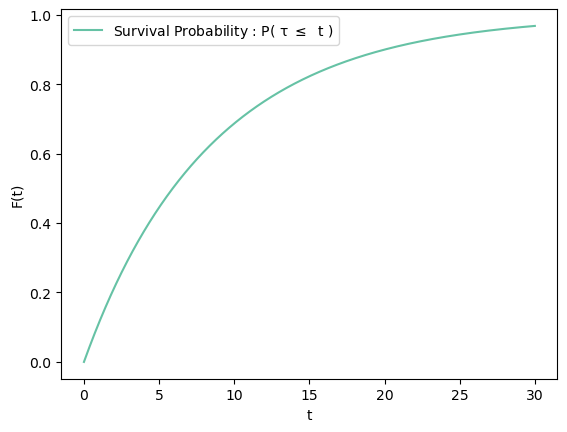

In [28]:
time = np.linspace(0,30,10000)

DistS=[]
DensityFunction=[]
for t in tqdm(time) :
    DistS.append(Sfunc(t))
    DensityFunction.append(Densityfunc(t))
    
    
plt.plot(time,DistS,label="Survival Probability : P( τ $\leq$  t )")
plt.xlabel("t")
plt.ylabel("F(t)")
plt.legend()

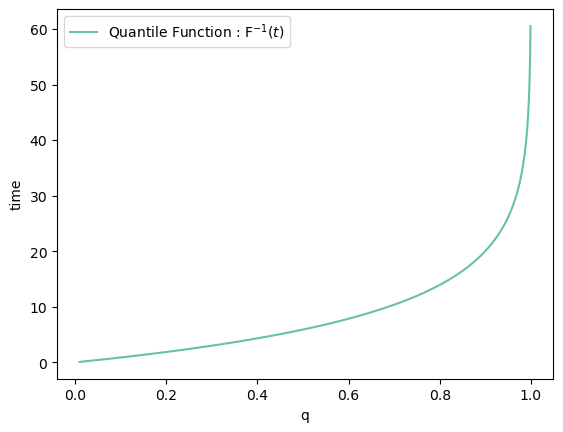

In [91]:
from scipy import optimize

quantiles = np.linspace(0.01,0.999,10000)

InverseFunction=[]
for quantile in quantiles:
    Optim = lambda t : Sfunc(t) - quantile
    inverse=optimize.newton(Optim,x0=0.01)
    InverseFunction.append(inverse)
    
    
                       
plt.plot(quantiles,InverseFunction,label="Quantile Function : F$^{-1}(t)$")
plt.xlabel("q")
plt.ylabel("time")
plt.legend()

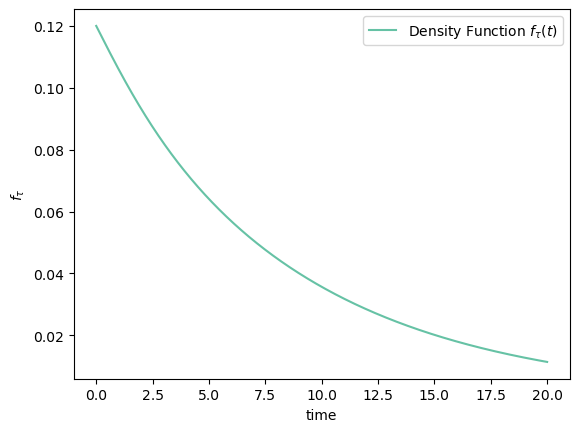

In [27]:
plt.plot(time,DensityFunction,label="Density Function $f_τ(t) $")
plt.xlabel("time")
plt.ylabel( "$f_τ$")
plt.legend()

<h3> Defining Gaussian Density Copula : </h3>

Lets define $R$ the correlation matrix $\in M^{2}(\mathbb{R})$

\begin{equation}
c_R^{Gauss} = \frac{1}{\sqrt{det R}}
\end{equation}


In [335]:
def gaussian_copula_density(corr,u1,u2):
    detR = np.sqrt(1- corr**2)
    invu1=sp.stats.norm.ppf(u1)
    invu2=sp.stats.norm.ppf(u2)
    first_factor=invu1 * (corr**2 * invu1 - corr * invu2)
    second_factor = invu2 * (corr**2 * invu2 - corr*invu1)
    return (1/(detR)) * np.exp(- 0.5 * (first_factor + second_factor) / (1-corr**2))


 

In [336]:
correlations=[0,0.1,0.2,0.5,0.6,0.95]
for corr in correlations:
    print(gaussian_copula_density(corr,0.9,0.8))

1.0
1.107494790184635
1.216700202996379
1.6017737194519848
1.7738967339492921
2.2115136789085805


<h3> Some Calculations  : </h3>


On calcule :

- $ P(V_t \leq v)$ où $V_t = S_t - Ke^{-r(T-t)}$

On calcule maintenant la fonction réciproque :

\begin{equation}
F_{V_t}^{-1}(y) = S_0 e^{\sigma \sqrt{t} \Phi^{-1}(y) + (r- 0.5 \sigma^{2})t}- Ke^{-r(T-t)}
\end{equation}

Or, on a un sampling avec :

- $U(\tau) = \Phi ( \rho \Phi^{-1} (G(\tau)) + \sqrt{1- \rho^{2}} Z)$
- $V_t|_{\tau =t} = F_{V_t}^{-1}(U(t))$
- $ F_{V_t}^{-1}(U(t)) =  S_0 e^{\sigma \sqrt{t} \Phi^{-1}(y) + (r- 0.5 \sigma^{2})t}$


On peut donc calculer l'exposure pour un forward

In [406]:
def CVAComputationClosedFormula(NbrPaths,NbrSteps,T,corr):
     
    
    # Setting Parameters
    
    
    dt= T / NbrSteps
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
    
    
   # BS Diffusion Parameters
    S0=100
    r=0.03
    sigma=0.2
    K=100
    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    Sfunc=   lambda t : 1.0- Gfunc(t)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)

    
    # Defining Fitting Curve to Initial ZCBondsIntensity
    #theta = lambda t: 1.0/lambd * (hfunc(t+dt)-hfunc(t-dt))/(2.0*dt) + hfunc(t) + \
    #sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    
    
    
    # Defining the Correlation Parameter
    
    
    
    
    S=np.ones(([NbrPaths, NbrSteps]))
    
    
    etacallWWR=np.zeros(([NbrPaths,NbrSteps]))
    etacallNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaforwardWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaforwardNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    
    S[:,0]=  S0
    λ[:,0]=lambda0

    EECallWWR=np.zeros(([NbrSteps]))
    EECallNoWWR=np.zeros(([NbrSteps]))
    EEForwardWWR=np.zeros(([NbrSteps]))
    EEForwardNoWWR=np.zeros(([NbrSteps]))
        
    for i in range(1,NbrSteps): 
        current_t=float(i*dt)
        WT=np.random.normal(0,1,NbrPaths)*np.sqrt(dt)
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT)
    
    
    CVACallWWR=0
    CVACallNoWWR=0
    CVAForwardWWR=0
    CVAForwardNoWWR=0
    RecoveryRate=0.4
    
    for j in tqdm(range(1,NbrSteps)):
        current_t=float(j*dt)
        Poids=Gfunc(current_t)
        current_priceforwardWWR=np.zeros((NbrPaths))
        current_priceforward=np.zeros((NbrPaths))
        for sample in range(NbrPaths):
            current_S=S[sample,j]
            priceforward=BS_Forward(current_S,K,current_t,T,r)
            valueforward=S0*np.exp((r - 0.5 * sigma**2) * current_t + sigma*np.sqrt(current_t) * (rho *norm.pdf(Gfunc(current_t)) + np.sqrt(1-rho**2) * np.random.normal(loc=0,scale=1))) - K*np.exp(-r*(T-current_t))
            current_priceforwardWWR[sample]=valueforward
            current_priceforward[sample]=priceforward

        
        etaforwardWWR[:,j]=np.exp(-r*current_t) * (np.maximum(current_priceforwardWWR,0))
        etaforwardNoWWR[:,j]=np.exp(-r*current_t) * (np.maximum(current_priceforward,0))

        EEForwardWWR[j]=np.mean(etaforwardWWR[:,j])
        EEForwardNoWWR[j]=np.mean(etaforwardNoWWR[:,j])
        
        CVAForwardWWR += - (1-RecoveryRate) * EEForwardWWR[j] * (Gfunc(current_t+dt)-Gfunc(current_t))
        CVAForwardNoWWR += - (1-RecoveryRate) * EEForwardNoWWR[j] * (Gfunc(current_t+dt)-Gfunc(current_t))
        #print(EE[j])
        
        
    
        
    # Outputs
    return λ,S,EEForwardWWR,CVAForwardWWR,EEForwardNoWWR,CVAForwardNoWWR



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [06:47<00:00,  8.32s/it]


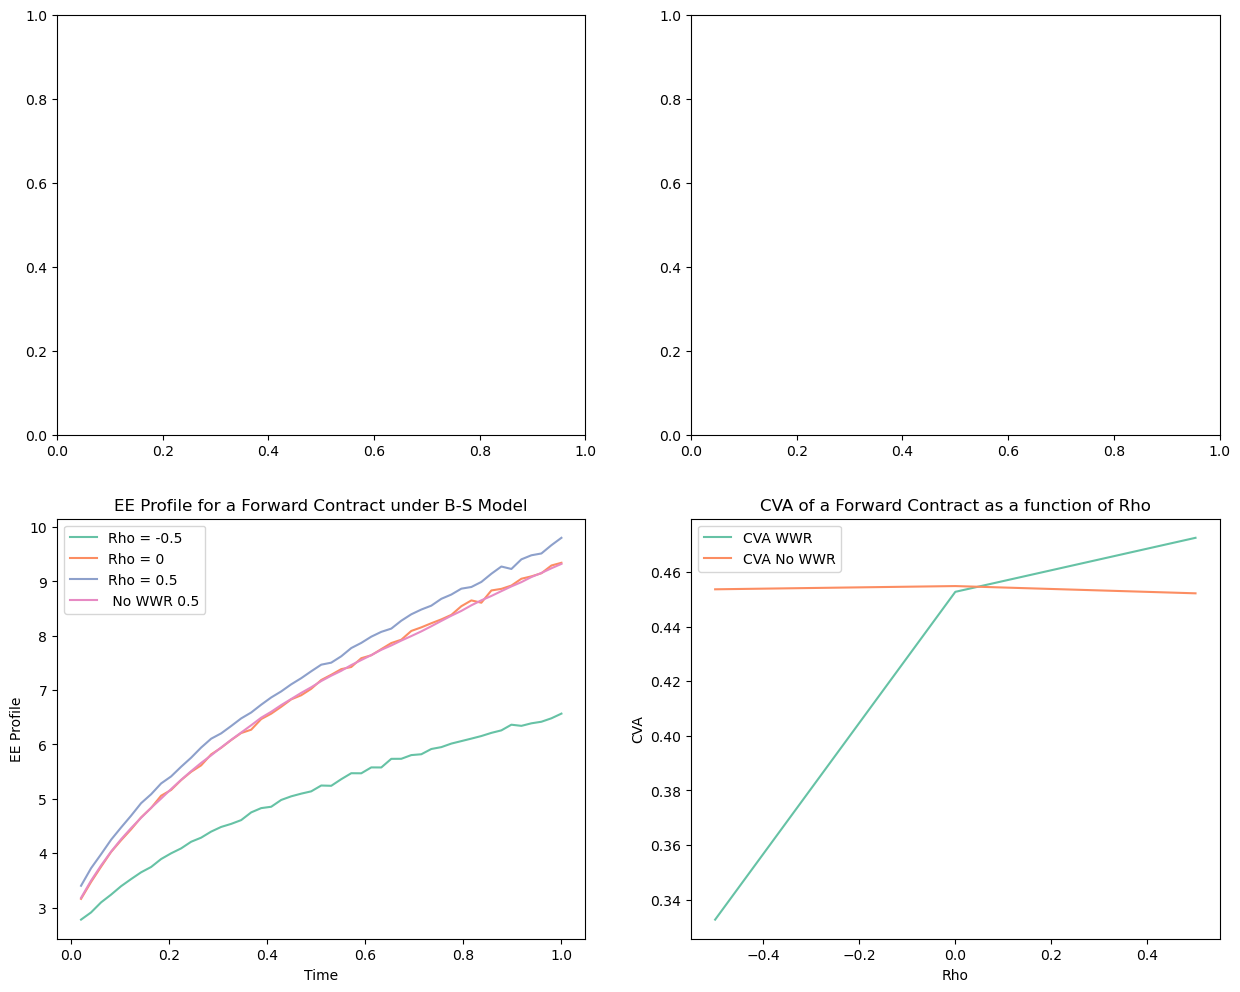

In [408]:
NbrSteps=50
NbrPaths=100000
T=1
rhoVec=[-0.5,0,0.5]
rhoVec2=[0.5]



#

EEValueForwardWWR=[]
EEValueForwardNoWWR=[]
CVAValueForwardWWR=[]
CVAValueForwardNoWWR=[]
time=np.linspace(0,T,NbrSteps)

#EEForward,CVAForward
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

for rho in rhoVec:
    λ,S,EEForwardWWR,CVAForwardWWR,EEForwardNoWWR,CVAForwardNoWWR=CVAComputationClosedFormula(NbrPaths,NbrSteps,T,rho)
    EEValueForwardWWR.append(EEForwardWWR)
    EEValueForwardNoWWR.append(EEForwardNoWWR)
    CVAValueForwardWWR.append(CVAForwardWWR)
    CVAValueForwardNoWWR.append(CVAForwardNoWWR)
    ax[1][0].plot(time[1:],EEForwardWWR[1:],label="Rho = "+str(rho))



ax[1][0].plot(time[1:],EEForwardNoWWR[1:],label=" No WWR " + str(rho))
ax[1][0].set_title("EE Profile for a Forward Contract under B-S Model")
ax[1][0].set_xlabel("Time")
ax[1][0].set_ylabel("EE Profile")
ax[1][0].legend(loc="upper left")
#


ax[1][1].plot(rhoVec,CVAValueForwardWWR,label="CVA WWR")
ax[1][1].plot(rhoVec,CVAValueForwardNoWWR,label="CVA No WWR")
ax[1][1].set_title("CVA of a Forward Contract as a function of Rho")
ax[1][1].set_xlabel("Rho")
ax[1][1].set_ylabel("CVA")
ax[1][1].legend(loc="upper right")

plt.legend()


    

In [389]:
def CVAComputationCopula(NbrPaths,NbrSteps,T,corr):
     
    
    # Setting Parameters
    
    
    dt= T / NbrSteps
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
    
    
   # BS Diffusion Parameters
    S0=100
    r=0.03
    sigma=0.2
    K=100
    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    Sfunc=   lambda t : 1.0- Gfunc(t)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)

    
    # Defining Fitting Curve to Initial ZCBondsIntensity
    #theta = lambda t: 1.0/lambd * (hfunc(t+dt)-hfunc(t-dt))/(2.0*dt) + hfunc(t) + \
    #sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    
    
    
    # Defining the Correlation Parameter
    
    
    
    
    S=np.ones(([NbrPaths, NbrSteps]))
    
    
    etacallWWR=np.zeros(([NbrPaths,NbrSteps]))
    etacallNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaforwardWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaforwardNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    
    S[:,0]=  S0
    λ[:,0]=lambda0

    EECallWWR=np.zeros(([NbrSteps]))
    EECallNoWWR=np.zeros(([NbrSteps]))
    EEForwardWWR=np.zeros(([NbrSteps]))
    EEForwardNoWWR=np.zeros(([NbrSteps]))
        
    for i in range(1,NbrSteps): 
        current_t=float(i*dt)
        WT=np.random.normal(0,1,NbrPaths)*np.sqrt(dt)
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT)
    
    
    CVACallWWR=0
    CVACallNoWWR=0
    CVAForwardWWR=0
    CVAForwardNoWWR=0
    RecoveryRate=0.4
    
    for j in tqdm(range(1,NbrSteps)):
        current_t=float(j*dt)
        Poids=Gfunc(current_t)
        current_pricecall=np.zeros((NbrPaths))
        current_priceforward=np.zeros((NbrPaths))
        WeightsForward=np.zeros((NbrPaths))
        for sample in range(NbrPaths):
            current_S=S[sample,j]
            pricecall=BS_CALL(current_S,K,current_t,T,r,sigma)
            priceforward=BS_Forward(current_S,K,current_t,T,r)
            current_pricecall[sample]=pricecall
            current_priceforward[sample]=priceforward
            valueforward=(np.log( (priceforward + K*np.exp(-r*(T-current_t))) / S0) - (r- 0.5*sigma**2)*(current_t) ) / sigma*np.sqrt(current_t)
            probH=norm.cdf(valueforward)
            WeightsForward[sample]=gaussian_copula_density(corr,probH,1 - Poids)
        print(WeightsForward)
        
        etacallWWR[:,j]=np.exp(-r*current_t) * (current_pricecall)
        etacallNoWWR[:,j]=np.exp(-r*current_t) * (current_pricecall)
        
    
        EECallWWR[j]=np.mean(etacallWWR[:,j])
        EECallNoWWR[j]=np.mean(etacallNoWWR[:,j])
        
        etaforwardWWR[:,j]=np.exp(-r*current_t) * (np.maximum(current_priceforward,0))* WeightsForward
        etaforwardNoWWR[:,j]=np.exp(-r*current_t) * (np.maximum(current_priceforward,0))

        EEForwardWWR[j]=np.mean(etaforwardWWR[:,j])
        EEForwardNoWWR[j]=np.mean(etaforwardNoWWR[:,j])
        
        CVACallWWR   += - (1-RecoveryRate) * EECallWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
        CVACallNoWWR += - (1-RecoveryRate) * EECallNoWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
        CVAForwardWWR += - (1-RecoveryRate) * EEForwardWWR[j] * (Gfunc(current_t+dt)-Gfunc(current_t))
        CVAForwardNoWWR += - (1-RecoveryRate) * EEForwardNoWWR[j] * (Gfunc(current_t+dt)-Gfunc(current_t))
        #print(EE[j])
        
        
    
        
    # Outputs
    return λ,S,EECallWWR,CVACallWWR,EECallNoWWR,CVACallNoWWR,EEForwardWWR,CVAForwardWWR,EEForwardNoWWR,CVAForwardNoWWR



In [390]:
NbrSteps=50
NbrPaths=500
T=1
λ,S,EECallWWR,CVACallWWR,EECallNoWWR,CVACallNoWWR,EEForwardWWR,CVAForwardWWR,EEForwardNoWWR,CVAForwardNoWWR=CVAComputationCopula(NbrPaths,NbrSteps,T,0.5)




  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/49 [00:00<00:07,  6.03it/s]

  4%|███▍                                                                               | 2/49 [00:00<00:07,  6.05it/s]

[0.3046596  0.30740981 0.31675784 0.30895323 0.3007586  0.30589889
 0.28810082 0.30782344 0.30620234 0.30866997 0.30465313 0.30970843
 0.30320823 0.28277074 0.3046954  0.30720482 0.3036806  0.32956277
 0.30073657 0.3133274  0.31741369 0.30567816 0.29311669 0.30646956
 0.30403867 0.31699179 0.30162619 0.29114989 0.29753967 0.307652
 0.30440491 0.30492856 0.30685936 0.30574378 0.31058414 0.29996056
 0.31942667 0.30241685 0.29295341 0.30640165 0.31210899 0.31526296
 0.30161827 0.32024279 0.34362996 0.31067963 0.30832134 0.30544387
 0.31826833 0.32686634 0.30217747 0.33874274 0.32580858 0.29640577
 0.31511945 0.3083594  0.32477722 0.32646929 0.31441111 0.33587542
 0.28391766 0.31398446 0.31286121 0.31741985 0.28865627 0.30926286
 0.29673696 0.32364458 0.30430798 0.31356375 0.31722279 0.31785096
 0.30807246 0.31037791 0.32374469 0.30275066 0.3030438  0.30886371
 0.29595835 0.30395142 0.29949947 0.31358703 0.30324797 0.32866563
 0.30797235 0.33589858 0.29312515 0.30185389 0.32011767 0.294791



  6%|█████                                                                              | 3/49 [00:00<00:07,  6.02it/s]



[0.46511593 0.4377379  0.40898915 0.41309597 0.39870253 0.46673866
 0.38564941 0.41172266 0.44740468 0.41647498 0.41678387 0.50480588
 0.48422903 0.41900861 0.38576442 0.45516107 0.39056474 0.47759329
 0.46005682 0.51852784 0.47389595 0.41692736 0.39090096 0.3676046
 0.46078387 0.50373116 0.42088789 0.40269463 0.40724728 0.43412132
 0.38829987 0.4396456  0.38665651 0.45600768 0.46173837 0.40941401
 0.47244608 0.4126979  0.44408231 0.39290314 0.365769   0.49412529
 0.43563122 0.45718187 0.51012918 0.41909392 0.39012276 0.48275619
 0.49263486 0.51764962 0.36514631 0.52925818 0.46474314 0.43828204
 0.43993522 0.47214549 0.46285204 0.41434539 0.45233568 0.47195162
 0.36074182 0.46282645 0.42427027 0.47059601 0.38610858 0.37380531
 0.4749671  0.45981549 0.40194322 0.44124103 0.47633955 0.4515583
 0.45665535 0.4807914  0.45873169 0.44105257 0.4356964  0.43648228
 0.40121943 0.44884235 0.44287325 0.43005765 0.43530616 0.5229248
 0.44324772 0.46007128 0.43361073 0.4012833  0.4674644  0.3906675

  8%|██████▊                                                                            | 4/49 [00:00<00:07,  5.81it/s]

 10%|████████▍                                                                          | 5/49 [00:00<00:07,  5.94it/s]



[0.54239789 0.45742734 0.40940999 0.45804151 0.50448825 0.55584998
 0.42692832 0.57407017 0.53755998 0.47081405 0.49902557 0.54574027
 0.52266257 0.42020187 0.40866361 0.45937693 0.40435037 0.54350072
 0.5232738  0.63960493 0.53317157 0.62098069 0.46276335 0.39820134
 0.5074329  0.53572055 0.41374078 0.49135612 0.55272837 0.49259054
 0.44923975 0.48105199 0.45454799 0.47608091 0.59766709 0.44797757
 0.63701242 0.42947474 0.55179793 0.44187823 0.39795822 0.67136183
 0.43931931 0.5027297  0.55719049 0.50896725 0.43487407 0.60266395
 0.57460667 0.53218296 0.51176195 0.61458035 0.45614849 0.55607368
 0.49446656 0.53123492 0.56565186 0.60338133 0.45554006 0.60443524
 0.34040348 0.59091707 0.41649414 0.52248174 0.4018008  0.32111917
 0.55355545 0.57036402 0.50648688 0.50612706 0.59049971 0.47857356
 0.57088352 0.62368623 0.53861526 0.51760059 0.50757211 0.44311125
 0.45538184 0.52310584 0.4650384  0.48156798 0.52774533 0.61118834
 0.42332304 0.57646879 0.47177308 0.47547001 0.55956489 0.4363

 12%|██████████▏                                                                        | 6/49 [00:01<00:07,  5.77it/s]

 14%|███████████▊                                                                       | 7/49 [00:01<00:07,  5.81it/s]

 16%|█████████████▌                                                                     | 8/49 [00:01<00:07,  5.74it/s]

[0.62955166 0.47527483 0.49527231 0.43757912 0.5226194  0.64787401
 0.42529306 0.83581088 0.64751721 0.48558347 0.57314833 0.64374394
 0.47993953 0.51446606 0.45434863 0.6029804  0.4391803  0.54250499
 0.66416955 0.86982668 0.52282767 0.72585723 0.5437753  0.4531308
 0.55908768 0.63117397 0.41739219 0.56906435 0.65703502 0.51401186
 0.58155029 0.53310167 0.47101731 0.44299068 0.72535229 0.45512212
 0.8065745  0.43506114 0.65309279 0.56971705 0.42495898 0.71400519
 0.50583913 0.49712538 0.53104048 0.7372838  0.4072596  0.89624096
 0.64292503 0.72627418 0.52140642 0.61023597 0.50266332 0.60979167
 0.61336794 0.60237769 0.60832597 0.73860363 0.5256572  0.64556088
 0.36924095 0.70368256 0.43763165 0.56420728 0.42987558 0.34807227
 0.55953512 0.68847115 0.58777125 0.5932399  0.66028045 0.5170833
 0.62795392 0.80600875 0.55087217 0.49916511 0.60457849 0.42803071
 0.492735   0.61821543 0.42879184 0.5563598  0.63710562 0.76783937
 0.47791039 0.55246678 0.48449998 0.66374629 0.58891729 0.480787



 18%|███████████████▏                                                                   | 9/49 [00:01<00:06,  5.77it/s]

 20%|████████████████▋                                                                 | 10/49 [00:01<00:06,  5.91it/s]

[0.76725989 0.4245191  0.5584662  0.45128231 0.50640931 0.59161733
 0.39997079 0.77805672 0.70431752 0.48580234 0.67786961 0.85127611
 0.52716576 0.53083396 0.56757818 0.85013257 0.54505304 0.492043
 0.75542778 0.97242118 0.52956885 0.6805764  0.60508273 0.55661406
 0.59167408 0.64098019 0.4751088  0.57216914 0.7713601  0.54888733
 0.58438963 0.57947937 0.48884576 0.52884025 0.74508339 0.50087513
 0.88249693 0.49127159 0.7344527  0.60571805 0.42490479 0.75257937
 0.50016246 0.66749848 0.58120534 0.69982431 0.44592389 0.95247823
 0.76639184 0.89888943 0.55760079 0.66919668 0.5292588  0.59270649
 0.66152536 0.67258777 0.71531553 0.88792555 0.51070239 0.79342381
 0.34225181 0.71550476 0.52627705 0.83225309 0.35294407 0.39481221
 0.57754796 0.82737048 0.71112175 0.62378514 0.84151264 0.50900367
 0.64436441 1.02674202 0.60410383 0.60375955 0.66433047 0.3840033
 0.55072715 0.7462758  0.48924279 0.59500591 0.59095229 0.7402719
 0.54551015 0.66860739 0.45475847 0.67707979 0.72205858 0.41848566



 22%|██████████████████▍                                                               | 11/49 [00:01<00:06,  5.78it/s]

 24%|████████████████████                                                              | 12/49 [00:02<00:06,  6.00it/s]

[0.9362493  0.39859243 0.50005458 0.41079712 0.47058006 0.59906098
 0.4869042  0.86650199 0.83379159 0.54028179 0.82205123 1.14879155
 0.57496461 0.56687485 0.59285195 0.79063639 0.60777017 0.51828727
 0.76114392 0.9907888  0.62719395 0.67156257 0.67573315 0.60879693
 0.49759827 0.68212888 0.5403256  0.72679397 0.76949963 0.46969453
 0.68112939 0.61548497 0.64392034 0.57192856 0.90255782 0.44667652
 0.89442516 0.42988193 0.93127762 0.72219844 0.39015948 0.68237536
 0.61771096 0.56495655 0.73249804 0.91005614 0.5372665  0.86748369
 0.79054355 0.91516141 0.54342381 0.82130502 0.53907719 0.72982889
 0.5178229  0.81831765 0.7418371  0.90311252 0.5412384  1.00252393
 0.337815   0.68370843 0.47385927 0.87784288 0.26568365 0.4392592
 0.70462071 0.86358908 0.74993139 0.51509374 0.99093318 0.51298268
 0.66498854 1.27425452 0.61805289 0.69415171 0.58613957 0.45927562
 0.68063925 0.91285083 0.48771123 0.64725622 0.47924103 0.86553489
 0.62589287 0.80435013 0.46436672 0.71568318 0.76276496 0.55117



 27%|█████████████████████▊                                                            | 13/49 [00:02<00:06,  5.80it/s]

 29%|███████████████████████▍                                                          | 14/49 [00:02<00:06,  5.75it/s]

[0.79981235 0.47086764 0.49176305 0.4638199  0.46938206 0.63556675
 0.62874387 0.67806231 0.67609605 0.57939754 0.80801752 1.01889651
 0.7034958  0.42808438 0.60742991 0.89514337 0.55836256 0.54104584
 0.71906959 0.99960029 0.74680363 0.59242712 0.67222122 0.68456131
 0.57643726 0.68919482 0.62690152 0.65783732 0.72109058 0.45644866
 0.78290222 0.59721448 0.70286584 0.71307504 0.96521222 0.58531558
 1.16441524 0.52726008 0.91948856 0.65387113 0.41331295 0.75612309
 0.68171915 0.74687302 0.82794028 0.92429054 0.54744015 0.87346857
 0.64327024 0.90564703 0.58190189 0.71758036 0.49760037 1.00726079
 0.40823451 0.93253863 0.7477098  0.90283359 0.60049123 1.20523138
 0.40187466 0.86981342 0.42803604 0.92811576 0.26713563 0.42617577
 0.80686211 1.11376377 0.84699686 0.46743129 1.06596546 0.42617009
 0.613213   1.34305631 0.71564935 0.70595235 0.4954232  0.44809877
 0.65745088 0.92557871 0.4473836  0.67643653 0.47822224 0.71290121
 0.68370027 0.84411535 0.34881526 0.733906   0.66327685 0.7371



 31%|█████████████████████████                                                         | 15/49 [00:02<00:06,  5.65it/s]

 33%|██████████████████████████▊                                                       | 16/49 [00:02<00:05,  5.72it/s]

[0.97452541 0.46892667 0.45790152 0.61790487 0.55427242 0.56176568
 0.67314429 0.84625478 0.80351367 0.68050227 0.87616433 1.06912953
 0.83004166 0.45383991 0.5765691  1.00007486 0.62308779 0.45862122
 0.87006128 1.17443634 0.86561047 0.75643628 0.7406437  0.82844011
 0.55709709 0.77865482 0.81367854 0.65876196 0.90572967 0.58846747
 0.76056816 0.63049325 0.77791951 0.74393312 0.86740219 0.64936086
 1.25802082 0.58286682 1.05547337 0.60852095 0.39743216 0.70468301
 0.7361107  0.68883635 0.83216194 0.97302913 0.38987314 0.83451451
 0.78774803 0.81978765 0.59736909 0.74650009 0.54363445 0.92608059
 0.37510981 0.89484338 0.81972151 0.84008326 0.69238809 1.55680345
 0.60731323 0.87750307 0.38063458 1.115811   0.28435722 0.41522107
 0.93873148 1.26764643 0.92207191 0.51969471 1.00075966 0.48512322
 0.71471862 1.39074434 0.88834231 0.71885211 0.48842024 0.45645946
 0.64315632 0.96620823 0.57372336 0.6829042  0.52225681 0.72039409
 0.62455913 0.80385959 0.46343183 0.92903405 0.63289199 0.7874



 35%|████████████████████████████▍                                                     | 17/49 [00:02<00:05,  5.64it/s]

 37%|██████████████████████████████                                                    | 18/49 [00:03<00:05,  5.77it/s]

[0.97660231 0.55809043 0.45771886 0.71302881 0.45695464 0.6326234
 0.68420488 0.75087677 0.94435299 0.83260287 0.94669137 1.10081458
 0.69717292 0.43467897 0.6747498  1.20292507 0.59012183 0.57824129
 1.00110859 0.93032579 0.9249531  0.81120702 0.76990547 1.03201461
 0.67684615 0.67329606 0.93076421 0.52738033 0.82879059 0.61409406
 0.83449898 0.66611968 0.69107312 0.61717546 0.88771561 0.62588853
 1.10633699 0.52556794 1.03621834 0.69730237 0.54205277 0.67222539
 0.62458948 0.77376161 0.76688074 0.9557882  0.40675788 0.75263085
 0.88113839 0.81927156 0.81889302 0.77216964 0.61868125 1.03972829
 0.40200365 1.02110174 0.77958003 0.9864688  0.94985639 1.631569
 0.61907376 0.97887295 0.39622407 1.15140914 0.27479273 0.39139012
 0.98488206 1.41993399 1.16297446 0.39009919 0.89410312 0.57129257
 0.7462551  1.39707499 0.79092648 0.82908829 0.55779726 0.44182382
 0.67909089 1.18543898 0.57182104 0.74232224 0.53003045 0.66558447
 0.6457368  0.84491852 0.50799909 1.03557494 0.62322647 0.8058477



 39%|███████████████████████████████▊                                                  | 19/49 [00:03<00:05,  5.82it/s]



[0.86386148 0.63259469 0.50406727 0.83056439 0.43004392 0.74741639
 0.84796834 1.04345059 1.0968746  1.07667651 0.8715632  1.10983517
 0.783049   0.4940752  0.64328887 1.20553338 0.61356083 0.78509727
 0.9615006  0.93135355 0.94287771 0.73124687 0.7314831  1.32531449
 0.86605687 0.63126433 0.92763368 0.58850177 0.8542252  0.57065391
 0.78817468 0.7102689  0.62410771 0.52578167 0.69050947 0.53217106
 1.08403072 0.78180244 0.98984928 0.71210851 0.7056598  0.76172953
 0.70841916 0.64475732 0.70476072 1.10999802 0.35300859 0.87167687
 0.91829536 0.78621089 1.00995239 0.69378419 0.54047228 1.33959689
 0.50708905 0.87606707 0.69540579 1.23731089 0.96320267 1.52708014
 0.75121887 1.18445395 0.40901222 1.15702601 0.24330897 0.42483453
 0.94683874 1.38265642 1.14087557 0.4607154  0.90257935 0.53424136
 0.71382656 1.64704463 0.69705836 0.77392322 0.65860032 0.44695344
 0.62849646 1.11532443 0.49625798 0.70610638 0.63310019 0.56458016
 0.64909971 0.81308674 0.48768573 1.32129042 0.65230962 0.5682

 41%|█████████████████████████████████▍                                                | 20/49 [00:03<00:05,  5.64it/s]

 43%|███████████████████████████████████▏                                              | 21/49 [00:03<00:04,  5.78it/s]

 45%|████████████████████████████████████▊                                             | 22/49 [00:03<00:04,  5.94it/s]

[0.74429152 0.65690516 0.49941076 0.77686956 0.43221521 0.74140397
 0.63210982 0.76799674 1.38285851 1.04847844 0.71292373 0.88330982
 0.91285442 0.38330764 0.75712756 1.37124253 0.58684561 0.66084459
 1.00653459 1.02793628 0.99056051 0.63866691 0.66265576 1.2555248
 0.73463205 0.58121197 0.74726973 0.62049885 0.94666449 0.58552175
 0.689041   0.73407925 0.58412048 0.59158282 0.81635935 0.42932608
 0.92457258 0.72436884 0.9752614  0.91276275 0.63249121 0.61496364
 0.69894377 0.716837   0.71613895 1.26320368 0.32021336 0.80551742
 1.27777195 0.76738396 1.06067564 0.67663287 0.47760842 1.2406344
 0.46060827 0.92244391 0.71257204 1.22458836 1.09489024 1.80376767
 0.89393739 1.1073654  0.3929042  1.00613075 0.22111094 0.53749798
 0.90567343 1.63537491 1.53675373 0.44209076 0.81187672 0.66839649
 0.53061671 1.91079328 0.68089861 0.66531584 0.6380261  0.42238681
 0.56315994 1.04449027 0.451563   0.80209329 0.81972968 0.41581909
 0.85819991 1.17181971 0.49810834 1.14507507 0.74154243 0.483274



 47%|██████████████████████████████████████▍                                           | 23/49 [00:03<00:04,  5.85it/s]

 49%|████████████████████████████████████████▏                                         | 24/49 [00:04<00:04,  6.00it/s]

[0.62991695 0.88089965 0.59692444 0.79517137 0.57748907 0.79630367
 0.72981523 0.68359817 1.26008558 1.02282645 0.73923605 0.85137271
 1.00943199 0.37906627 0.65412592 1.44783949 0.57435236 0.51979084
 0.86781592 1.03564331 0.99696454 0.72535005 0.81380902 1.61744343
 0.63041311 0.62524424 0.76586317 0.66726028 0.86518568 0.63515925
 0.60914977 1.07555448 0.6578172  0.8704732  0.84869793 0.39217322
 0.83411357 0.81807932 1.00544075 1.13454242 0.57090391 0.73063194
 0.48044521 0.67811717 0.79366549 1.13600789 0.29570202 0.92608266
 1.35115973 0.83186292 1.01338857 0.75779705 0.52206239 1.22864297
 0.47435988 1.05863653 0.55899923 1.43118376 0.98527749 1.70444013
 0.85648104 1.15800132 0.4079506  1.09245759 0.27087624 0.34714182
 1.00590796 1.45188827 1.62923947 0.3902402  0.9778258  0.64511387
 0.45441865 2.10294592 0.72383842 0.59523164 0.5792642  0.56035877
 0.56514205 0.865398   0.31845383 0.80856205 0.75654234 0.4451354
 0.91427724 1.19462751 0.4280709  1.11679305 0.64280511 0.45649



 51%|█████████████████████████████████████████▊                                        | 25/49 [00:04<00:04,  5.89it/s]

 53%|███████████████████████████████████████████▌                                      | 26/49 [00:04<00:03,  5.99it/s]

[0.55938292 1.03936331 0.77058677 0.77967665 0.45570152 0.72856276
 0.88342634 0.83165334 1.44211576 1.10142776 0.85924938 0.70919364
 0.98452085 0.42027962 0.54033144 1.52697854 0.56450167 0.59494822
 0.80037789 0.99739583 0.98767504 0.89860043 1.14601884 1.79462066
 0.52876786 0.80627061 0.90583704 0.59386164 0.74277515 0.61672132
 0.52861705 1.00701067 0.65561939 1.07371489 0.74868345 0.37973574
 1.09657586 0.8841229  1.05722149 1.2904367  0.47072797 0.86854707
 0.51050019 0.53185731 0.55081723 1.20656876 0.23054291 1.09176343
 1.59888864 0.87686313 1.34143979 0.86795243 0.65690113 1.49062125
 0.68404812 0.94563535 0.4948188  1.6271367  1.16872313 1.65779314
 0.82889726 1.23060112 0.49050815 1.15308808 0.25163325 0.2987741
 0.80906525 1.33269377 1.581959   0.40406459 0.99494731 0.72434903
 0.45745891 1.82931218 0.65236799 0.56798635 0.63666852 0.51763296
 0.64286748 0.74927914 0.31821619 0.75454912 0.74505013 0.48782036
 1.06715453 1.14189912 0.56115317 0.9953848  0.67851308 0.46034



 55%|█████████████████████████████████████████████▏                                    | 27/49 [00:04<00:03,  6.05it/s]

 57%|██████████████████████████████████████████████▊                                   | 28/49 [00:04<00:03,  6.13it/s]

[0.51515169 1.16201809 0.87653775 0.61840876 0.43159034 0.6482831
 1.19604068 0.71452283 1.55536099 1.12903265 0.79397839 0.72686247
 0.95405327 0.35718199 0.52097034 1.71792766 0.59924522 0.70104695
 1.1078509  0.83942691 1.02052982 0.81895702 1.1039016  1.56347192
 0.44511449 0.93411583 0.86682498 0.55376716 0.75229671 0.65937632
 0.49275735 1.00459618 0.69079119 1.28646993 1.06423511 0.41008174
 1.21224132 0.98750759 1.06138975 1.14041503 0.56981211 0.83267029
 0.51148366 0.65412303 0.64175933 1.30128379 0.18788535 1.10011917
 1.60326322 0.93625321 1.1103812  1.14362407 0.64699826 1.48919945
 0.63513357 0.93184572 0.45509661 1.70132138 1.21347871 1.85199667
 0.84014569 1.24925319 0.50647911 1.12814716 0.26591518 0.31798452
 0.86709817 1.21205961 1.76640801 0.34927341 1.15611032 0.71286733
 0.35216652 1.8732163  0.66469329 0.51419129 0.64786768 0.49566146
 0.7254724  0.76466455 0.28977763 0.84562921 0.79668087 0.43153687
 1.27604195 1.32454076 0.55029893 1.02232638 0.57846842 0.41947



 59%|████████████████████████████████████████████████▌                                 | 29/49 [00:04<00:03,  6.12it/s]

 61%|██████████████████████████████████████████████████▏                               | 30/49 [00:05<00:03,  6.13it/s]

[0.55446561 1.2421155  0.87796738 0.63637953 0.47422227 0.64361968
 1.20748336 0.64341454 1.43081898 0.97191392 0.78193847 0.66529571
 0.99947905 0.41625146 0.5477742  1.92321695 0.44616594 0.77729752
 1.21640774 0.81548866 1.22035447 0.87303685 1.24525934 1.55786458
 0.64563769 0.95760414 0.85249284 0.71438383 0.71721559 0.67381906
 0.55065855 0.86642164 0.67420884 1.24260022 1.00479515 0.41149843
 1.12086166 1.02066492 1.10508145 0.95253045 0.62680199 1.01086854
 0.43414727 0.73125579 0.59461958 1.38286067 0.22826943 1.19927575
 1.82921039 0.97853759 1.41664791 1.02491462 0.75585777 1.59958035
 0.74725105 1.24493972 0.5208296  1.69134616 1.58654295 1.95834473
 0.95809467 1.13733266 0.56121219 1.02255498 0.2211428  0.33927852
 0.74799036 1.00246473 2.11704854 0.3408271  1.19248618 0.50380575
 0.3364291  1.98556608 0.64986763 0.47423698 0.77010816 0.62877129
 0.88464794 0.9867733  0.30205956 0.95480473 0.7376519  0.4796591
 1.6287357  1.41243595 0.64228297 1.03881812 0.67419441 0.44613



 63%|███████████████████████████████████████████████████▉                              | 31/49 [00:05<00:03,  5.94it/s]

 65%|█████████████████████████████████████████████████████▌                            | 32/49 [00:05<00:02,  6.14it/s]

[0.79948351 1.25893565 0.70559904 0.61110315 0.61683403 0.63258202
 1.06989725 0.55266571 1.21265963 1.16463732 0.82889023 0.66625318
 1.20706588 0.32765229 0.55421328 1.7167572  0.41141679 0.71295203
 1.04757853 0.75879993 1.26297341 0.71883902 1.02976765 1.57587905
 0.52683006 1.07051952 0.91184795 0.76129929 0.97882135 0.6352794
 0.48087282 0.86651848 0.69361809 1.25626496 0.99969545 0.28195499
 1.02505923 1.23735676 1.2391831  0.96244938 0.56306484 0.83023339
 0.61972654 0.75774563 0.56344433 1.24737159 0.22379631 1.34864821
 2.06695803 0.90164303 1.68051768 0.89418778 0.81588223 1.43493323
 0.69753751 1.27188618 0.5884808  1.63911552 1.58098054 1.9936961
 1.18327513 0.9329243  0.40341518 1.05984362 0.3534195  0.28842939
 0.83744778 0.78812964 2.35436641 0.35658789 1.46514385 0.53657537
 0.3585489  1.99269146 0.66330461 0.37096427 1.00301252 0.69757817
 0.86085029 0.79381762 0.30916096 1.028551   0.7617584  0.43365851
 1.65228256 1.30496601 0.57471072 1.10366254 0.89369843 0.368485



 67%|███████████████████████████████████████████████████████▏                          | 33/49 [00:05<00:02,  5.78it/s]

 69%|████████████████████████████████████████████████████████▉                         | 34/49 [00:05<00:02,  5.84it/s]

[0.70526661 1.17630451 0.60319592 0.74772246 0.58596644 0.50470243
 1.0791928  0.49780979 1.02109132 1.05004387 0.79261758 0.52291235
 0.97710745 0.22247403 0.52393649 1.79894517 0.50414263 0.81177928
 0.85972707 0.58217555 1.35387906 0.75468593 1.06962023 1.57857177
 0.48116559 1.20084219 0.88625906 0.66312829 1.26013868 0.50146458
 0.59953092 0.90501637 0.78203122 1.44042757 0.96387014 0.3860366
 1.17086008 1.28015278 1.38933806 1.14934414 0.56871614 0.82577381
 0.75732404 0.89276706 0.52056273 1.48461184 0.14345313 1.51860289
 2.10639636 0.79239047 1.80402797 1.12004114 0.66514306 1.67294648
 0.64858732 1.30994172 0.49705406 1.59036584 1.59126594 1.81467456
 1.39661588 1.13057671 0.43255247 1.04758956 0.56128508 0.3223147
 0.7151628  0.80267047 2.1579311  0.40490483 1.45888169 0.56653443
 0.43638508 1.82817021 0.53910491 0.30770645 0.85495363 0.87622155
 0.774629   0.70036824 0.20457721 1.0217732  0.75306868 0.42703829
 1.73359711 1.54788133 0.68673957 1.24786068 1.12080517 0.340241



 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [00:05<00:02,  5.88it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [00:06<00:02,  5.91it/s]

[0.67547682 1.21169006 0.62937358 0.77745188 0.43684414 0.43381868
 1.21840846 0.5451537  1.19497295 1.20033204 0.6467977  0.39957945
 1.06290989 0.18722395 0.51861823 1.83318689 0.47632917 0.86050899
 0.98872899 0.57775206 1.39300148 0.6547182  1.29539886 1.25997193
 0.50680132 1.08248333 0.89741008 0.76564328 1.15682244 0.59253926
 0.48839139 0.89523892 0.86014625 1.4393542  1.11826778 0.45955299
 1.35473857 1.15709665 1.37828069 1.06562465 0.69515241 1.03261129
 0.82360576 0.71503708 0.5468825  1.35699146 0.17151697 1.46444905
 2.28072496 0.84294498 2.18645935 1.23872599 0.57413104 1.6862039
 0.5315561  1.46135947 0.71457669 1.74564077 1.78363172 1.37556214
 1.6263747  0.85842696 0.28212123 1.01249415 0.87558236 0.26875353
 0.72752    0.88901905 2.01006771 0.37643365 1.65651568 0.44439093
 0.75564166 1.81633922 0.49288051 0.291576   0.91768316 0.98692962
 0.70808147 0.64988653 0.16994872 1.12333961 0.9085373  0.39864884
 1.81977323 1.52394466 0.73667739 1.30357165 1.03120268 0.48075



 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [00:06<00:01,  6.04it/s]

 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [00:06<00:01,  5.89it/s]

[0.56644385 1.07069024 0.6790211  0.7503448  0.51191939 0.62294405
 0.91817699 0.48192494 1.33514159 1.09584564 0.76804961 0.40115228
 0.93525203 0.17938557 0.56536133 2.0772115  0.50204377 0.79549079
 1.00906593 0.53291983 1.56362544 0.69643489 1.3329672  1.51993225
 0.43711892 1.18134634 0.8574752  0.84270099 1.34412705 0.59972317
 0.75605318 1.14980283 1.10171164 1.5238818  1.20542356 0.26838455
 1.43426506 0.90227556 1.67708499 1.32058258 0.60045521 1.16108033
 1.06113292 0.731123   0.46097915 1.41189761 0.14298148 1.3154305
 2.37749435 0.76054019 2.10722016 1.33687133 0.66183196 1.91728709
 0.52069488 1.71722304 0.62313958 1.45413507 1.93218544 1.27658412
 1.83457299 1.01718914 0.31199384 0.98186795 0.94555968 0.22564512
 0.78471515 1.10983787 2.13760299 0.37688807 1.28037058 0.35496939
 0.66718405 1.79893605 0.33527441 0.41690646 0.96514234 1.13289536
 0.6153417  0.53580927 0.13817747 1.20746985 0.80659472 0.27097967
 1.91142334 1.67378233 0.75741924 1.39646827 1.11131685 0.41634



 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [00:06<00:01,  5.91it/s]

 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [00:06<00:01,  5.93it/s]

[0.59821196 1.02932926 0.58593764 0.77940509 0.57768255 0.60979204
 0.89368217 0.43954694 1.10410435 1.35288525 0.71736577 0.53008784
 0.97361867 0.23232397 0.38296904 1.92994226 0.4791149  0.82618693
 0.97930891 0.63129699 1.82876543 0.60550228 1.46860618 1.61041782
 0.5872903  1.29447711 0.98275302 0.88709079 1.412732   0.72948262
 0.86353078 0.95170134 1.25548329 1.41752223 1.35575703 0.41516046
 1.32492885 0.79879459 1.47876699 1.27194633 0.71819711 1.06106203
 0.97671535 0.6864033  0.40583536 1.47916224 0.11201122 1.3261764
 2.66978715 0.65245662 2.05880432 1.41249492 0.6637164  2.16335251
 0.47071502 1.94246616 0.65544055 1.67018496 2.129324   1.2670652
 1.92935351 1.23362644 0.2932186  0.80536336 1.07110138 0.27500027
 0.77754961 1.22153382 2.10283103 0.45273654 1.08548006 0.41217899
 0.71256516 1.51907185 0.41222232 0.347533   1.10266197 1.42603304
 0.35357128 0.54331935 0.11879695 1.46609675 0.66773547 0.3320546
 2.10075508 1.51692888 0.77552771 1.48452638 1.02645201 0.3855216



 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [00:06<00:01,  5.97it/s]

 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [00:07<00:01,  6.01it/s]

[0.52292408 1.26528554 0.60726981 0.83451682 0.55720827 0.5238625
 0.9807925  0.54162247 1.22071136 1.49176199 0.87743081 0.43016802
 0.8799656  0.24128522 0.37213718 2.16534689 0.31963756 0.85385999
 1.131766   0.53893583 1.91912905 0.73308545 1.3472813  1.51830729
 0.65843985 1.43271358 0.98435198 0.91734065 1.22540368 0.91537777
 0.97930409 0.97946151 1.61877719 1.50660367 1.63712086 0.41467165
 1.07283483 0.80704551 1.35190915 1.3245591  0.75751344 1.1730373
 1.13955125 0.65079524 0.38316758 1.36484177 0.11714195 1.27020576
 2.51544297 0.63381646 1.99546792 1.5331536  0.62398832 2.31357452
 0.61033896 2.08875701 0.79306791 1.75969114 1.99437398 1.12729487
 2.01525842 1.42610926 0.26111381 0.63737704 1.44772826 0.2683204
 0.56569408 1.33777457 2.07629892 0.43341087 1.25307332 0.48287296
 0.63212624 1.66003219 0.37536959 0.38085729 1.22355952 1.57796348
 0.46999429 0.71584521 0.11498286 1.5093749  0.69867212 0.31397953
 2.23839399 1.76231816 0.64430608 1.47578052 1.14648246 0.2949162



 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [00:07<00:01,  5.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [00:07<00:00,  6.01it/s]

[0.52499457 1.01148835 0.59568857 0.82079472 0.46246186 0.46347493
 1.30772477 0.40259194 1.52880858 1.678729   0.86330547 0.41675395
 0.99285221 0.27437605 0.45946323 2.08479963 0.32512074 0.84292422
 1.05930048 0.60035869 1.69553671 0.6287454  1.72809042 1.53447632
 0.51733038 1.34478832 0.85695481 0.92651607 1.26505309 0.88701179
 0.95375028 0.84896372 1.45021231 1.89848616 1.45029228 0.51724243
 0.9857469  0.61486983 1.22054982 1.4580431  0.89338173 1.35757745
 1.17868857 0.59868301 0.35051268 1.08773763 0.10469321 1.31203945
 2.56344641 0.84359472 2.20346309 1.84850298 0.66104971 2.15496645
 0.49102861 1.85120941 1.1048831  1.73832675 1.9444998  1.00117519
 2.04625249 1.45061    0.23082516 0.77825422 1.24841467 0.21093236
 0.79049941 1.17873591 2.02847524 0.33275315 1.1015349  0.48423321
 0.61369817 1.88118316 0.3850547  0.31699413 1.56465106 1.39587065
 0.51157794 0.72134041 0.08150428 1.39356609 1.05626566 0.28469985
 2.25029324 1.80474528 0.63033927 1.55092926 1.11316111 0.3538



 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [00:07<00:00,  6.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [00:07<00:00,  6.21it/s]

[0.50166137 1.00303698 0.55014574 0.78763148 0.33991528 0.3607903
 1.24380428 0.41084534 1.40021028 1.4247262  0.86524863 0.42815792
 1.04403958 0.14066526 0.47881069 1.94265011 0.40581462 0.64361266
 1.04787305 0.39810509 2.1550538  0.41322428 1.71988315 1.58887127
 0.40965659 1.11253453 0.76660497 0.87172216 1.23717946 0.91170669
 0.98319175 0.97083184 1.73906362 1.89451464 1.29700999 0.5490776
 1.3302739  0.73370731 1.1814285  1.24238076 0.87790558 1.54229613
 0.93685594 0.55157362 0.40187617 0.98257641 0.08061242 1.08018296
 2.44538959 0.87823913 2.47011264 1.87962519 0.73510312 2.22070931
 0.42333907 1.57827257 1.235894   1.6909409  1.9735218  0.83877033
 2.10808471 1.34835378 0.14707153 0.63942279 1.53638728 0.16951728
 0.72004358 1.00566477 2.07897367 0.32827095 1.38176908 0.3445966
 0.53635579 2.12615942 0.44106888 0.3607033  1.79788524 1.52228131
 0.40302666 0.58642932 0.08358147 1.37938599 0.91053194 0.28852759
 2.33758224 1.81599704 0.57811636 1.52300773 0.84951737 0.3115983



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [00:07<00:00,  5.96it/s]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [00:08<00:00,  6.16it/s]

[0.4387808  0.84137761 0.5964391  0.63261256 0.60222783 0.31236407
 1.21774371 0.42585955 1.39538609 1.32170282 0.84966065 0.55164745
 0.91033701 0.13964591 0.53548886 1.85594175 0.42998292 0.56488932
 1.03773169 0.36525727 2.23296044 0.47880015 1.85215844 1.69249089
 0.45327546 1.03714615 0.71709016 0.82125726 1.47961167 1.0670165
 0.89431735 0.94570871 1.73779615 2.07489257 1.23843841 0.75930239
 1.34811192 0.72156148 1.09529051 1.48408802 0.7572826  1.55005077
 0.9529737  0.59037057 0.41446222 1.32305734 0.1135152  1.15393991
 2.40941883 0.61190343 2.41514866 1.60137262 0.64624661 2.06907405
 0.43098756 1.43651746 1.10740914 1.66077777 1.99523565 0.67913757
 2.16609973 1.43560332 0.18915238 0.65643546 1.42995712 0.18143739
 0.8140974  1.0123163  2.02862246 0.34029266 1.29614704 0.32233473
 0.53652561 2.30239137 0.28738542 0.36546424 1.85093877 1.44888021
 0.37785541 0.62763424 0.10373358 1.15873926 1.13911083 0.37198309
 2.09936323 1.96443754 0.63770716 1.67163396 1.03982576 0.30124



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.90it/s]

[0.40143897 0.80066584 0.58675451 0.90537768 0.72183725 0.29031105
 1.07157046 0.57932568 1.54386411 1.48995671 0.95955986 0.4884542
 0.98464741 0.21976008 0.45632528 1.70272926 0.35493433 0.71667691
 1.33368625 0.39248709 2.30236344 0.47946126 1.84057874 1.62229639
 0.37045753 1.1652723  0.58016235 0.87205648 1.6006607  1.06057332
 0.97054648 0.83268472 1.63144322 2.19623176 1.18730243 0.70193755
 1.10321022 0.8552293  1.04351175 1.7505966  0.79272296 1.54703238
 1.09117056 0.50674111 0.40876525 1.32933056 0.16035697 1.08483452
 2.37621401 0.70729791 2.4039083  1.57759702 0.74292257 2.06981261
 0.34762133 1.4721565  1.02789858 1.54747353 2.11760448 0.76721278
 2.12152676 1.33516916 0.20505279 0.68914116 1.5861352  0.27875817
 0.95151021 1.10361223 2.08364681 0.2489732  1.17389581 0.31432293
 0.68047192 2.11994782 0.27357512 0.37362272 1.96576357 1.30793711
 0.46065851 0.68311562 0.08856746 1.26344684 1.04556147 0.33545192
 2.19293668 2.22179483 0.6856769  1.79429638 1.35220197 0.26077

Exception ignored in: <function tqdm.__del__ at 0x00000187CFF699E0>
Traceback (most recent call last):
  File "C:\Users\samy.mekkaoui\AppData\Local\anaconda32023\Lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\samy.mekkaoui\AppData\Local\anaconda32023\Lib\site-packages\tqdm\std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Exception ignored in: <function tqdm.__del__ at 0x00000187CFF699E0>
Traceback (most recent call last):
  File "C:\Users\samy.mekkaoui\AppData\Local\anaconda32023\Lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\samy.mekkaoui\AppData\Local\anaconda32023\Lib\site-packages\tqdm\std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'last_print_t'
  2%|█▋                       

[0.31513306 0.29242322 0.29006483 ... 0.29993985 0.32533457 0.30799493]


  4%|███▍                                                                               | 2/49 [00:32<12:47, 16.33s/it]

[0.3687262  0.34838691 0.31555222 ... 0.35488406 0.40385183 0.34446   ]


  6%|█████                                                                              | 3/49 [00:48<12:27, 16.25s/it]

[0.40527962 0.37736204 0.37091503 ... 0.40283233 0.45167638 0.37314143]


  8%|██████▊                                                                            | 4/49 [01:04<12:07, 16.17s/it]

[0.45429618 0.37305852 0.38611848 ... 0.42273939 0.50408761 0.40792779]


 10%|████████▍                                                                          | 5/49 [01:20<11:49, 16.12s/it]

[0.45995198 0.38521396 0.38354074 ... 0.46011818 0.54903391 0.4276727 ]


 12%|██████████▏                                                                        | 6/49 [01:37<11:32, 16.11s/it]

[0.47305915 0.35436164 0.37214324 ... 0.44196646 0.53828472 0.41051232]


 14%|███████████▊                                                                       | 7/49 [01:53<11:15, 16.08s/it]

[0.51971107 0.36102328 0.33072778 ... 0.38172876 0.65063889 0.40310506]


 16%|█████████████▌                                                                     | 8/49 [02:09<10:59, 16.08s/it]

[0.49970531 0.31944494 0.3172923  ... 0.43019541 0.7009462  0.37178522]


 18%|███████████████▏                                                                   | 9/49 [02:25<10:43, 16.08s/it]

[0.57306907 0.32054891 0.33484752 ... 0.40100207 0.79723004 0.41410075]


 20%|████████████████▋                                                                 | 10/49 [02:41<10:28, 16.11s/it]

[0.56624918 0.30725385 0.33480654 ... 0.41908333 0.87401788 0.40873403]


 22%|██████████████████▍                                                               | 11/49 [02:57<10:12, 16.11s/it]

[0.46288061 0.2538533  0.31275575 ... 0.48057399 0.81296233 0.33079806]


 24%|████████████████████                                                              | 12/49 [03:13<09:55, 16.11s/it]

[0.47658447 0.2868336  0.33957219 ... 0.5573098  0.92126111 0.30828139]


 27%|█████████████████████▊                                                            | 13/49 [03:29<09:41, 16.15s/it]

[0.47177447 0.28325498 0.36076591 ... 0.54541956 0.96567264 0.33009459]


 29%|███████████████████████▍                                                          | 14/49 [03:46<09:25, 16.16s/it]

[0.48366011 0.31412955 0.37592956 ... 0.53692948 1.08971821 0.29762549]


 31%|█████████████████████████                                                         | 15/49 [04:01<09:07, 16.09s/it]

[0.44117031 0.28782877 0.29414517 ... 0.61606994 0.96655787 0.30078551]


 33%|██████████████████████████▊                                                       | 16/49 [04:18<08:52, 16.14s/it]

[0.44865017 0.30245138 0.28813036 ... 0.55339505 1.07058325 0.25652842]


 35%|████████████████████████████▍                                                     | 17/49 [04:34<08:37, 16.16s/it]

[0.54133113 0.2886472  0.30948587 ... 0.61893894 1.24742571 0.26480597]


 37%|██████████████████████████████                                                    | 18/49 [04:50<08:20, 16.16s/it]

[0.68895386 0.2831278  0.29129385 ... 0.64635141 1.26292759 0.24339011]


 39%|███████████████████████████████▊                                                  | 19/49 [05:06<08:03, 16.11s/it]

[0.7174375  0.25297806 0.2775661  ... 0.73205073 1.24731013 0.23812022]


 41%|█████████████████████████████████▍                                                | 20/49 [05:22<07:46, 16.09s/it]

[0.71909627 0.26979276 0.29353378 ... 0.70843512 1.31870754 0.26105836]


 43%|███████████████████████████████████▏                                              | 21/49 [05:38<07:31, 16.13s/it]

[0.74204302 0.30619419 0.19411826 ... 0.74685724 1.33798219 0.28785626]


 45%|████████████████████████████████████▊                                             | 22/49 [05:55<07:17, 16.22s/it]

[0.77376224 0.3048568  0.22020554 ... 0.7918016  1.4738516  0.3570335 ]


 47%|██████████████████████████████████████▍                                           | 23/49 [06:11<07:00, 16.18s/it]

[0.75800623 0.35419668 0.2882628  ... 0.83141235 1.60577283 0.33661564]


 49%|████████████████████████████████████████▏                                         | 24/49 [06:27<06:46, 16.26s/it]

[0.64754382 0.33725217 0.30377941 ... 0.78376744 1.57645434 0.38795278]


 51%|█████████████████████████████████████████▊                                        | 25/49 [06:44<06:31, 16.31s/it]

[0.62536412 0.4257924  0.32659756 ... 0.78175554 1.583757   0.40555197]


 53%|███████████████████████████████████████████▌                                      | 26/49 [07:00<06:13, 16.25s/it]

[0.48288294 0.42648492 0.32878546 ... 0.84453699 1.891233   0.40251557]


 55%|█████████████████████████████████████████████▏                                    | 27/49 [07:16<05:57, 16.26s/it]

[0.55830492 0.42768384 0.33581405 ... 0.71733448 1.82107539 0.44680341]


 57%|██████████████████████████████████████████████▊                                   | 28/49 [07:32<05:40, 16.21s/it]

[0.54541843 0.44351155 0.33955941 ... 0.72969572 1.7538557  0.41122905]


 59%|████████████████████████████████████████████████▌                                 | 29/49 [07:48<05:24, 16.22s/it]

[0.58802707 0.34252844 0.24702041 ... 0.83761323 1.79133844 0.41590381]


 61%|██████████████████████████████████████████████████▏                               | 30/49 [08:04<05:06, 16.15s/it]

[0.60213443 0.29475517 0.21619779 ... 0.92202569 1.65781625 0.32465287]


 63%|███████████████████████████████████████████████████▉                              | 31/49 [08:21<04:53, 16.28s/it]

[0.60152225 0.31666083 0.2065244  ... 1.0814266  1.65564918 0.40228771]


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [08:38<04:41, 16.58s/it]

[0.72148806 0.36060461 0.16550352 ... 1.03806535 1.71386226 0.41658253]


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [08:55<04:24, 16.50s/it]

[0.86630532 0.34472141 0.18541899 ... 0.93750138 1.73284317 0.34250939]


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [09:11<04:06, 16.41s/it]

[0.87163978 0.28678088 0.1852384  ... 0.91749172 1.63070401 0.35365108]


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [09:27<03:49, 16.39s/it]

[0.84367122 0.27822435 0.17750182 ... 1.07076535 1.49906032 0.41177245]


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [09:44<03:33, 16.41s/it]

[0.85842633 0.28055779 0.17879642 ... 1.23211195 1.56543056 0.43531918]


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [10:00<03:16, 16.39s/it]

[0.85150547 0.29115075 0.16393203 ... 1.27082965 1.49247792 0.40100349]


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [10:16<03:00, 16.42s/it]

[0.99110158 0.301159   0.1272985  ... 1.33821677 1.33651311 0.43262377]


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [10:33<02:44, 16.42s/it]

[0.93493059 0.39982189 0.12582283 ... 1.33092092 1.42451849 0.38999919]


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [10:49<02:28, 16.47s/it]

[0.86219168 0.42409996 0.14142279 ... 1.22952903 1.46038452 0.33021875]


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [11:06<02:11, 16.43s/it]

[0.8546227  0.37389279 0.14685191 ... 1.15507937 1.65577113 0.33787534]


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [11:22<01:54, 16.42s/it]

[0.77347786 0.34809558 0.17352735 ... 1.212427   1.57208815 0.29408536]


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [11:39<01:38, 16.49s/it]

[0.80012703 0.46736698 0.12917525 ... 1.18647297 1.72827972 0.30001387]


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [12:03<01:34, 18.89s/it]

[0.74545928 0.4498499  0.142539   ... 1.37915916 1.54775213 0.33222037]


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [12:35<01:30, 22.62s/it]

[0.83181269 0.43000057 0.17561011 ... 1.56795537 1.33711466 0.30001362]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [12:55<01:05, 21.95s/it]

[0.69022118 0.54564724 0.1921691  ... 1.54323946 1.19974986 0.22327811]


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [13:12<00:40, 20.45s/it]

[0.67280768 0.53500172 0.22337085 ... 1.62209841 1.04316457 0.21898176]


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [13:29<00:19, 19.38s/it]

[0.58644395 0.46411925 0.19338821 ... 1.54916341 1.07837649 0.25993377]


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [13:46<00:00, 16.86s/it]


[0.61167225 0.50015728 0.19733363 ... 1.46058421 1.12798324 0.21379536]


  2%|█▋                                                                                 | 1/49 [00:16<13:30, 16.88s/it]

[1. 1. 1. ... 1. 1. 1.]


  4%|███▍                                                                               | 2/49 [00:33<13:07, 16.77s/it]

[1. 1. 1. ... 1. 1. 1.]


  6%|█████                                                                              | 3/49 [00:50<12:49, 16.73s/it]

[1. 1. 1. ... 1. 1. 1.]


  8%|██████▊                                                                            | 4/49 [01:06<12:29, 16.66s/it]

[1. 1. 1. ... 1. 1. 1.]


 10%|████████▍                                                                          | 5/49 [01:23<12:14, 16.68s/it]

[1. 1. 1. ... 1. 1. 1.]


 12%|██████████▏                                                                        | 6/49 [01:40<11:55, 16.64s/it]

[1. 1. 1. ... 1. 1. 1.]


 14%|███████████▊                                                                       | 7/49 [01:56<11:37, 16.61s/it]

[1. 1. 1. ... 1. 1. 1.]


 16%|█████████████▌                                                                     | 8/49 [02:13<11:19, 16.58s/it]

[1. 1. 1. ... 1. 1. 1.]


 18%|███████████████▏                                                                   | 9/49 [02:29<11:00, 16.52s/it]

[1. 1. 1. ... 1. 1. 1.]


 20%|████████████████▋                                                                 | 10/49 [02:46<10:45, 16.56s/it]

[1. 1. 1. ... 1. 1. 1.]


 22%|██████████████████▍                                                               | 11/49 [03:02<10:31, 16.61s/it]

[1. 1. 1. ... 1. 1. 1.]


 24%|████████████████████                                                              | 12/49 [03:20<10:20, 16.77s/it]

[1. 1. 1. ... 1. 1. 1.]


 27%|█████████████████████▊                                                            | 13/49 [03:37<10:11, 16.99s/it]

[1. 1. 1. ... 1. 1. 1.]


 29%|███████████████████████▍                                                          | 14/49 [03:54<09:53, 16.95s/it]

[1. 1. 1. ... 1. 1. 1.]


 31%|█████████████████████████                                                         | 15/49 [04:11<09:33, 16.86s/it]

[1. 1. 1. ... 1. 1. 1.]


 33%|██████████████████████████▊                                                       | 16/49 [04:27<09:13, 16.78s/it]

[1. 1. 1. ... 1. 1. 1.]


 35%|████████████████████████████▍                                                     | 17/49 [04:44<08:54, 16.71s/it]

[1. 1. 1. ... 1. 1. 1.]


 37%|██████████████████████████████                                                    | 18/49 [05:00<08:36, 16.67s/it]

[1. 1. 1. ... 1. 1. 1.]


 39%|███████████████████████████████▊                                                  | 19/49 [05:17<08:18, 16.60s/it]

[1. 1. 1. ... 1. 1. 1.]


 41%|█████████████████████████████████▍                                                | 20/49 [05:33<08:00, 16.59s/it]

[1. 1. 1. ... 1. 1. 1.]


 43%|███████████████████████████████████▏                                              | 21/49 [05:50<07:42, 16.53s/it]

[1. 1. 1. ... 1. 1. 1.]


 45%|████████████████████████████████████▊                                             | 22/49 [06:06<07:25, 16.49s/it]

[1. 1. 1. ... 1. 1. 1.]


 47%|██████████████████████████████████████▍                                           | 23/49 [06:22<07:06, 16.40s/it]

[1. 1. 1. ... 1. 1. 1.]


 49%|████████████████████████████████████████▏                                         | 24/49 [06:39<06:53, 16.56s/it]

[1. 1. 1. ... 1. 1. 1.]


 51%|█████████████████████████████████████████▊                                        | 25/49 [06:56<06:38, 16.62s/it]

[1. 1. 1. ... 1. 1. 1.]


 53%|███████████████████████████████████████████▌                                      | 26/49 [07:12<06:21, 16.59s/it]

[1. 1. 1. ... 1. 1. 1.]


 55%|█████████████████████████████████████████████▏                                    | 27/49 [07:29<06:04, 16.56s/it]

[1. 1. 1. ... 1. 1. 1.]


 57%|██████████████████████████████████████████████▊                                   | 28/49 [07:46<05:48, 16.60s/it]

[1. 1. 1. ... 1. 1. 1.]


 59%|████████████████████████████████████████████████▌                                 | 29/49 [08:02<05:32, 16.62s/it]

[1. 1. 1. ... 1. 1. 1.]


 61%|██████████████████████████████████████████████████▏                               | 30/49 [08:19<05:16, 16.68s/it]

[1. 1. 1. ... 1. 1. 1.]


 63%|███████████████████████████████████████████████████▉                              | 31/49 [08:36<04:59, 16.66s/it]

[1. 1. 1. ... 1. 1. 1.]


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [08:52<04:43, 16.65s/it]

[1. 1. 1. ... 1. 1. 1.]


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [09:09<04:24, 16.56s/it]

[1. 1. 1. ... 1. 1. 1.]


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [09:25<04:08, 16.58s/it]

[1. 1. 1. ... 1. 1. 1.]


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [09:42<03:51, 16.54s/it]

[1. 1. 1. ... 1. 1. 1.]


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [09:59<03:35, 16.61s/it]

[1. 1. 1. ... 1. 1. 1.]


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [10:15<03:19, 16.59s/it]

[1. 1. 1. ... 1. 1. 1.]


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [10:32<03:01, 16.53s/it]

[1. 1. 1. ... 1. 1. 1.]


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [10:48<02:45, 16.52s/it]

[1. 1. 1. ... 1. 1. 1.]


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [11:05<02:28, 16.54s/it]

[1. 1. 1. ... 1. 1. 1.]


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [11:21<02:11, 16.50s/it]

[1. 1. 1. ... 1. 1. 1.]


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [11:37<01:55, 16.47s/it]

[1. 1. 1. ... 1. 1. 1.]


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [11:54<01:38, 16.48s/it]

[1. 1. 1. ... 1. 1. 1.]


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [12:10<01:22, 16.50s/it]

[1. 1. 1. ... 1. 1. 1.]


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [12:27<01:05, 16.46s/it]

[1. 1. 1. ... 1. 1. 1.]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [12:43<00:49, 16.43s/it]

[1. 1. 1. ... 1. 1. 1.]


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [13:00<00:32, 16.46s/it]

[1. 1. 1. ... 1. 1. 1.]


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [13:16<00:16, 16.50s/it]

[1. 1. 1. ... 1. 1. 1.]


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [13:33<00:00, 16.59s/it]


[1. 1. 1. ... 1. 1. 1.]


  2%|█▋                                                                                 | 1/49 [00:16<13:17, 16.62s/it]

[0.29623527 0.3234023  0.32182846 ... 0.30003748 0.29718239 0.30771956]


  4%|███▍                                                                               | 2/49 [00:33<13:04, 16.70s/it]

[0.379273   0.39708035 0.40182089 ... 0.38004442 0.35993507 0.38862985]


  6%|█████                                                                              | 3/49 [00:49<12:44, 16.62s/it]

[0.40090099 0.43985598 0.46522638 ... 0.44337059 0.39095018 0.45094295]


  8%|██████▊                                                                            | 4/49 [01:06<12:27, 16.62s/it]

[0.43123637 0.43864782 0.47733909 ... 0.48415046 0.47574331 0.51704347]


 10%|████████▍                                                                          | 5/49 [01:23<12:11, 16.63s/it]

[0.47732236 0.48256562 0.52035681 ... 0.52835269 0.51239293 0.54877517]


 12%|██████████▏                                                                        | 6/49 [01:39<11:54, 16.62s/it]

[0.47770107 0.49327739 0.54356987 ... 0.54294484 0.57724444 0.53927842]


 14%|███████████▊                                                                       | 7/49 [01:56<11:36, 16.59s/it]

[0.48740976 0.43901463 0.62728009 ... 0.59027105 0.57435817 0.53223345]


 16%|█████████████▌                                                                     | 8/49 [02:12<11:16, 16.50s/it]

[0.49170193 0.48918111 0.67966251 ... 0.52068751 0.53598837 0.49453449]


 18%|███████████████▏                                                                   | 9/49 [02:28<10:57, 16.44s/it]

[0.46915188 0.44684573 0.74457793 ... 0.54403205 0.50995485 0.48610459]


 20%|████████████████▋                                                                 | 10/49 [02:45<10:39, 16.41s/it]

[0.48086705 0.46514365 0.73815403 ... 0.57820551 0.5427321  0.58771614]


 22%|██████████████████▍                                                               | 11/49 [03:01<10:21, 16.35s/it]

[0.45341489 0.46716137 0.75522182 ... 0.56976142 0.54218994 0.5326844 ]


 24%|████████████████████                                                              | 12/49 [03:17<10:04, 16.33s/it]

[0.45666704 0.49368187 0.7660564  ... 0.65126776 0.47999996 0.48145187]


 27%|█████████████████████▊                                                            | 13/49 [03:34<09:50, 16.41s/it]

[0.55372433 0.44675426 0.64228912 ... 0.57961292 0.44707212 0.44956896]


 29%|███████████████████████▍                                                          | 14/49 [03:50<09:36, 16.46s/it]

[0.5803212  0.40682503 0.73619993 ... 0.59321942 0.44639264 0.47041886]


 31%|█████████████████████████                                                         | 15/49 [04:07<09:20, 16.48s/it]

[0.55350751 0.37326596 0.65563973 ... 0.58190942 0.4571553  0.42566327]


 33%|██████████████████████████▊                                                       | 16/49 [04:23<09:04, 16.49s/it]

[0.58204617 0.32147605 0.64699762 ... 0.48148615 0.48790013 0.40629128]


 35%|████████████████████████████▍                                                     | 17/49 [04:40<08:47, 16.48s/it]

[0.62517973 0.36082135 0.75967855 ... 0.49703667 0.57923896 0.35792643]


 37%|██████████████████████████████                                                    | 18/49 [04:56<08:29, 16.42s/it]

[0.66507621 0.46039968 0.73645172 ... 0.51553988 0.59246818 0.35330615]


 39%|███████████████████████████████▊                                                  | 19/49 [05:13<08:11, 16.40s/it]

[0.68423014 0.54103664 0.74168263 ... 0.49873493 0.58630828 0.43192081]


 41%|█████████████████████████████████▍                                                | 20/49 [05:29<07:54, 16.36s/it]

[0.78488426 0.49715184 0.82020162 ... 0.54714189 0.62505846 0.46114603]


 43%|███████████████████████████████████▏                                              | 21/49 [05:45<07:37, 16.35s/it]

[0.91847387 0.59400913 0.72505233 ... 0.55598784 0.68693963 0.41387047]


 45%|████████████████████████████████████▊                                             | 22/49 [06:02<07:22, 16.40s/it]

[0.8282519  0.58641138 0.80855454 ... 0.57647041 0.81582101 0.44440681]


 47%|██████████████████████████████████████▍                                           | 23/49 [06:18<07:06, 16.41s/it]

[0.93216276 0.57871001 0.70038332 ... 0.60176564 0.8364254  0.54504642]


 49%|████████████████████████████████████████▏                                         | 24/49 [06:35<06:51, 16.46s/it]

[0.97195535 0.51446697 0.65857421 ... 0.63915738 0.71999309 0.61069258]


 51%|█████████████████████████████████████████▊                                        | 25/49 [06:51<06:34, 16.45s/it]

[0.9366952  0.53782548 0.55378689 ... 0.6141833  0.88903319 0.64459176]


 53%|███████████████████████████████████████████▌                                      | 26/49 [07:08<06:18, 16.46s/it]

[0.98853225 0.47559758 0.50094366 ... 0.62034634 0.93497301 0.61292757]


 55%|█████████████████████████████████████████████▏                                    | 27/49 [07:24<06:00, 16.39s/it]

[0.8974647  0.45959952 0.50587963 ... 0.75166374 0.93863133 0.51568141]


 57%|██████████████████████████████████████████████▊                                   | 28/49 [07:40<05:44, 16.39s/it]

[0.90876046 0.48019815 0.5068148  ... 0.76135562 0.81511061 0.67956518]


 59%|████████████████████████████████████████████████▌                                 | 29/49 [07:57<05:27, 16.38s/it]

[0.98054643 0.51445732 0.47446082 ... 0.95121048 0.7748559  0.73051724]


 61%|██████████████████████████████████████████████████▏                               | 30/49 [08:13<05:11, 16.37s/it]

[0.93245852 0.53874795 0.46642252 ... 0.94602037 0.90223657 0.73186917]


 63%|███████████████████████████████████████████████████▉                              | 31/49 [08:29<04:53, 16.31s/it]

[0.92193991 0.49648273 0.49004116 ... 1.04219453 0.98829258 0.70143633]


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [08:45<04:36, 16.27s/it]

[0.89253584 0.50643717 0.48491651 ... 1.05634169 0.78766983 0.69157928]


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [09:01<04:19, 16.20s/it]

[0.87012721 0.46033682 0.48647313 ... 1.15199222 0.79115381 0.78348972]


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [09:17<04:02, 16.18s/it]

[0.96287257 0.46108746 0.51155614 ... 1.05596094 0.80505715 0.75759817]


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [09:34<03:46, 16.21s/it]

[0.96866243 0.48141513 0.52349368 ... 0.95650098 0.72532963 0.65729451]


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [09:50<03:29, 16.14s/it]

[0.94065798 0.39526419 0.48868114 ... 1.02598408 0.7333256  0.80915167]


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [10:06<03:13, 16.15s/it]

[0.81602862 0.55320186 0.47069874 ... 1.02748344 0.76922843 0.91937548]


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [10:22<02:57, 16.11s/it]

[0.73313586 0.57448341 0.44420571 ... 0.97051255 0.79588062 1.04003714]


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [10:38<02:41, 16.12s/it]

[0.70541839 0.5263619  0.60302337 ... 0.93885638 0.93909715 1.16295736]


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [10:54<02:25, 16.12s/it]

[0.56195674 0.58554155 0.60544169 ... 0.9426236  0.73917775 1.0688017 ]


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [11:10<02:09, 16.15s/it]

[0.6008534  0.52792113 0.56027044 ... 0.88311544 0.74621616 0.83983621]


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [11:27<01:53, 16.17s/it]

[0.54442754 0.51489059 0.57307641 ... 1.08973192 0.67556826 0.83951654]


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [11:43<01:37, 16.19s/it]

[0.60568205 0.5806273  0.66410343 ... 1.13993545 0.81923439 0.86616692]


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [11:59<01:20, 16.16s/it]

[0.58598284 0.55738469 0.64615469 ... 0.95931814 1.01255218 0.79816532]


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [12:15<01:04, 16.19s/it]

[0.58125804 0.47686575 0.66572833 ... 1.05941528 0.94615267 0.73623851]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [12:32<00:48, 16.24s/it]

[0.68583793 0.5736331  0.49899332 ... 1.08909125 1.04337441 0.76785977]


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [12:48<00:32, 16.28s/it]

[0.61722267 0.58218358 0.44250164 ... 1.10418618 0.93218605 0.71611426]


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [13:04<00:16, 16.32s/it]

[0.54539628 0.54539469 0.4649971  ... 1.0994329  1.01759052 0.54752496]


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [13:21<00:00, 16.35s/it]

[0.39635317 0.59760279 0.43309419 ... 1.00613404 1.08530133 0.50043672]


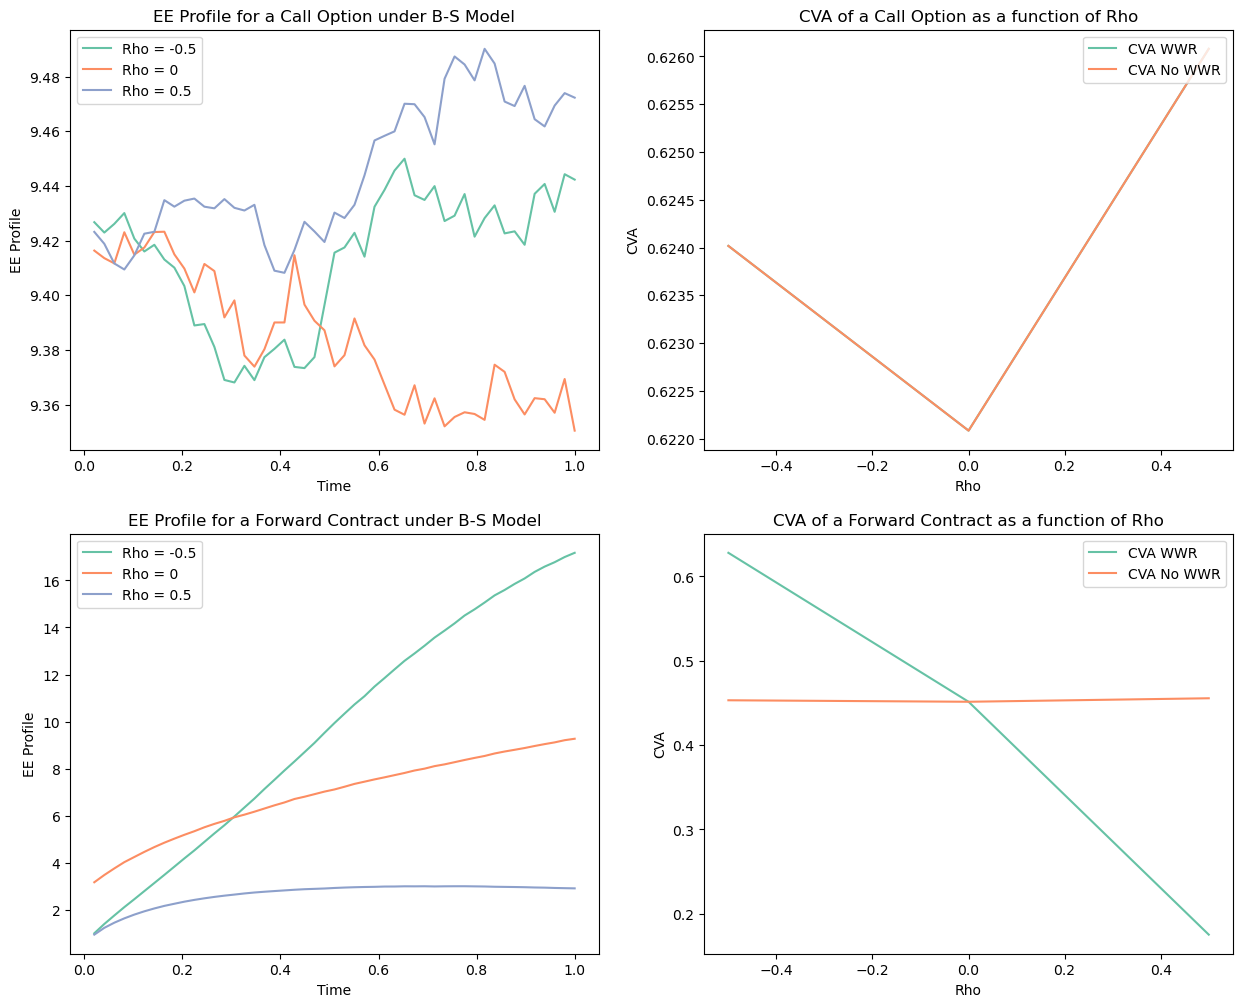

In [394]:
NbrSteps=50
NbrPaths=50000
T=1
rhoVec=[-0.5,0,0.5]
rhoVec2=[0.5]



#
EEValueCallWWR=[]
EEValueCallNoWWR=[]
EEValueForwardWWR=[]
EEValueForwardNoWWR=[]
CVAValueCallWWR=[]
CVAValueCallNoWWR=[]
CVAValueForwardWWR=[]
CVAValueForwardNoWWR=[]
time=np.linspace(0,T,NbrSteps)

#EEForward,CVAForward
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

for rho in rhoVec:
    λ,S,EECallWWR,CVACallWWR,_,CVACallNoWWR,EEForwardWWR,CVAForwardWWR,_,CVAForwardNoWWR=CVAComputationCopula(NbrPaths,NbrSteps,T,rho)
    EEValueCallWWR.append(EECallWWR)
    #EEValueCallNoWWR.append(EECallNoWWR)
    EEValueForwardWWR.append(EEForwardWWR)
    #EEValueForwardNoWWR.append(EEForwardNoWWR)
    CVAValueCallWWR.append(CVACallWWR)
    CVAValueCallNoWWR.append(CVACallNoWWR)
    CVAValueForwardWWR.append(CVAForwardWWR)
    CVAValueForwardNoWWR.append(CVAForwardNoWWR)
    ax[0][0].plot(time[1:],EECallWWR[1:],label="Rho = " + str(rho))
    ax[1][0].plot(time[1:],EEForwardWWR[1:],label="Rho = "+str(rho))

    
#
ax[0][0].set_title("EE Profile for a Call Option under B-S Model")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("EE Profile")
ax[0][0].legend(loc="upper left")


ax[1][0].set_title("EE Profile for a Forward Contract under B-S Model")
ax[1][0].set_xlabel("Time")
ax[1][0].set_ylabel("EE Profile")
ax[1][0].legend(loc="upper left")
#
ax[0][1].plot(rhoVec,CVAValueCallWWR,label="CVA WWR")
ax[0][1].plot(rhoVec,CVAValueCallNoWWR,label="CVA No WWR")
ax[0][1].plot()
ax[0][1].set_title("CVA of a Call Option as a function of Rho")
ax[0][1].set_xlabel("Rho")
ax[0][1].set_ylabel("CVA")
ax[0][1].legend(loc="upper right")

ax[1][1].plot(rhoVec,CVAValueForwardWWR,label="CVA WWR")
ax[1][1].plot(rhoVec,CVAValueForwardNoWWR,label="CVA No WWR")
ax[1][1].set_title("CVA of a Forward Contract as a function of Rho")
ax[1][1].set_xlabel("Rho")
ax[1][1].set_ylabel("CVA")
ax[1][1].legend(loc="upper right")

plt.legend()


    

In [ ]:
def copula_gaussian(n, correlation, seed):
    
    ''' Normally distributed random variates X and Y with correlation 'p'
    '''
    
    # Independed Normal distributions
    Z_x = sp.stats.norm.rvs(loc=0, scale=1, size=n, random_state=seed)
    Z_y = sp.stats.norm.rvs(loc=0, scale=1, size=n, random_state=seed*2)
    Z = np.matrix([Z_x, Z_y])
    
    # Construct the correlation matrix and Cholesky Decomposition
    rho = np.matrix([[1, correlation], [correlation, 1]])
    cholesky = np.linalg.cholesky(rho)
    
    # Apply Cholesky and extract X and Y
    Z_XY = cholesky * Z
    X = np.array(Z_XY[0,:]).flatten()
    Y = np.array(Z_XY[1,:]).flatten()
    
    # CDF
    X_cdf = sp.stats.norm.cdf(X, loc=0, scale=1)
    Y_cdf = InverseS(sp.stats.norm.cdf(Y, loc=0, scale=1))
    
    return X, Y, X_cdf, Y_cdf

def copula_t(n, correlation, df, seed):
    
    ''' Student's t distributed random variates t_X and t_Y with correlation 'p'
        and degrees of freedom 'df'
    '''
    
    # Gaussian Copula
    Zx, Zy, _, _ = copula_gaussian(n=n, correlation=correlation, seed=seed)
    
    # Chi Squared Sample
    np.random.seed(seed)
    ChiSquared = np.random.chisquare(df=df, size=n)

    # Stident's t distributed random variables
    X = Zx / (np.sqrt(ChiSquared / df))
    Y = Zy / (np.sqrt(ChiSquared / df))
    
    # CDF
    X_cdf = sp.stats.t.cdf(X, df=df, loc=0, scale=1)
    Y_cdf = sp.stats.t.cdf(Y, df=df, loc=0, scale=1)
    
    return X, Y, X_cdf, Y_cdf

In [82]:
 X, Y, X_cdf, Y_cdf=copula_gaussian(1000,0.5,2)

<h3> Interest Rate Swap CVA Calculation under G2++ Model </h3>

In [118]:
def generate_G2_pathsAndIntensity(NbrPaths,NbrSteps,T,P0T,kappax,kappay,sigmax,sigmay,rhoAsset,rhoDefault):
    
    # Intensity Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    dt = T / float(NbrSteps)
    forward = lambda t: -(np.log(P0T(t+dt)) - np.log(P0T(t -dt)))/(2*dt)
    r0 = forward(0.00001)
    phi = lambda t:  forward(t) + sigmax*sigmax / (2*kappax*kappax) *pow(1-np.exp(-kappax*t),2) + sigmay*sigmay / ( 2*kappay*kappay) * pow(1-np.exp(-kappay*t),2) + rhoAsset*sigmax*sigmay / (kappax*kappay) * (1-np.exp(-kappax*t))*(1-np.exp(-kappay*t))
    dt = T / float(NbrSteps)
    mean= [0,0]
    cov=[[1,rhoAsset],[rhoAsset,1]]
    R = np.zeros([NbrPaths, NbrSteps+1])
    x = np.zeros([NbrPaths, NbrSteps+1])
    y= np.zeros([NbrPaths, NbrSteps+1])
    S=np.ones(([NbrPaths, NbrSteps+1]))
    Survival=np.ones(([NbrPaths, NbrSteps+1]))
    λ=np.zeros(([NbrPaths,NbrSteps+1]))
    time = np.zeros([NbrSteps+1])
    
    
    R[:,0]=r0
    λ[:,0]=lambda0
    
    
    #coeff = np.sqrt(0.5 * (rhoDefault ** 2 ) / ( 1+ rhoAsset))
    
    for i in range(0,NbrSteps):
        Gaussian=np.random.multivariate_normal(mean,cov,NbrPaths)
        x[:,i+1]=x[:,i] * (1- kappax*dt) + sigmax * np.sqrt(dt) * Gaussian[:,0]
        y[:,i+1]=y[:,i] * (1-kappay*dt) +  sigmay *  np.sqrt(dt) * Gaussian[:,1]
        time[i+1] = time[i] +dt
        R[:,i+1] = x[:,i+1] + y[:,i+1]+ phi(time[i+1])
        λ[:,i+1]=λ[:,i] + kappalambd*(thetalambd-np.maximum(λ[:,i],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i],0.0))*np.sqrt(dt) * (rhoDefault * Gaussian[:,0] + np.sqrt((1- rhoDefault**2)) * np.random.normal(0,1,NbrPaths))
        Survival[:,i+1]=Survival[:,i]*np.exp(-(λ[:,i+1]+λ[:,i])*0.5*dt)
        
    # Outputs
    return time, R,x,y,λ,Survival

                                                                       
  

100%|█████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 12418.28it/s]


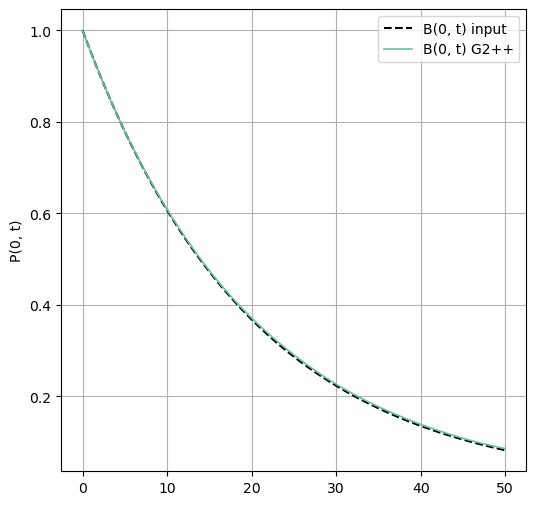

In [121]:
def ZCB_sanity_check(NoOfPaths, NoOfSteps):
    T         = 50.0
    kappax     = 0.1
    kappay = 0.1
    sigmax=0.05
    sigmay = 0.02
    rhoAsset=-0.99
    rhoDefault=0.9
    dt = T / float(NoOfSteps)
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T) 
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))  
    time, R,x,y,λ,Survival = generate_G2_pathsAndIntensity(NoOfPaths,NoOfSteps,T,P0T,kappax,kappay,sigmax,sigmay,rhoAsset,rhoDefault)
    M = np.zeros([NoOfPaths, NoOfSteps+1])
    M[:,0]= 1.0
    for i in tqdm(range(0, NoOfSteps)):
        #money saving account:  dM(t)=rM(t)dt is M(t)=M(t_0)exp(int_0^tr(t)dt)
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1]+R[:,i])*0.5*dt) #Tripazoides method
    Pmdl=  np.zeros([NoOfSteps+1])
    for i in tqdm(range(0,NoOfSteps+1)):
        Pmdl[i] = np.mean(1.0/M[:,i])
    ax.plot(time,(P0T(time)),"--k", label = "B(0, t) input")
    ax.plot(time, Pmdl, linewidth = "1.2", label = "B(0, t) G2++")
    ax.set_ylabel("P(0, t)")
    ax.grid()
    plt.legend()
    plt.show()
    #fig.savefig("G2++_ZCB.png")
ZCB_sanity_check (20000, 500)

In [122]:
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0


def V(kappax,kappay,sigmax,sigmay,rho,T1,T2):
    facteur1=pow(sigmax,2)/pow(kappax,2)
    facteur2=pow(sigmay,2)/pow(kappay,2)
    kappa=kappax+kappay
    facteur3=(2*rho*sigmax*sigmay)/(kappax*kappay)
    
    first=facteur1*(T2-T1+ 2*np.exp(-kappax*(T2-T1))/(kappax)-(np.exp(-2*kappax*(T2-T1)))/(2*kappax)-3/(2*kappax))
    #print(first)
    second=facteur2*(T2-T1+ 2*np.exp(-kappay*(T2-T1))/(kappay)-(np.exp(-2*kappay*(T2-T1)))/(2*kappay)-3/(2*kappay))
    #print(second)
    third=facteur3*(T2-T1+(np.exp(-kappax*(T2-T1))-1)/(kappax)+(np.exp(-kappay*(T2-T1))-1)/(kappay)-(np.exp(-kappa*(T2-T1))-1)/(kappa))
    #print(third)
    return first+second+third


def G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,T1,T2,xT1,yT1):
    
    n = np.size(xT1) 
        
    if T1<T2:
        first_factor=P0T(T2) / P0T(T1)
        #first_factor=(-1/(T2-T1))  *np.log(P0T(T2)/P0T(T1))
        second_factor = 1/2 * (V(kappax,kappay,sigmax,sigmay,rho,T1,T2) -V(kappax,kappay,sigmax,sigmay,rho,0,T2) +V(kappax,kappay,sigmax,sigmay,rho,0,T1))
        third_factor= ((1-np.exp(-kappax*(T2-T1)))*xT1) / (kappax) + ((1-np.exp(-kappay*(T2-T1)))*yT1) / (kappay)
        return first_factor*np.exp(second_factor-third_factor)
    else:
        return np.ones([n])

def G2_SwapPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= np.zeros(np.size(x_t));
    
    P_t_TiLambda = lambda Ti : G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,t,Ti,x_t,y_t)
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
            
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    
    if CP==OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    
    return swap*notional


# A Revoir : 
#def G2_SwaptionPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho):
#    swap_price=G2_SwapPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho)
#    payoff=np.maximum(swap_price,0)
#    return np.mean(payoff)*np.exp(-



In [123]:
def CVAComputationSwap(rhoAsset,rhoDefault):
     
    
    # Setting Parameters
    NoOfPaths = 50000
    NoOfSteps = 1000
    kappax     = 0.6
    kappay = 0.15
    sigmax=0.06
    sigmay = 0.04
    notional  = 10000.0 
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12

    
    
 

    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)
    P0T = lambda T: np.exp(-0.01*T)
    # We define a ZCB curve (obtained from the market)
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)   
    # Here we simulate the exposure profiles for a swap, using the HW model    
    # Swap settings
    K = 0.01  # strike
    Ti = 1.0  # begining of the swap
    Tm = 10.0 # end date of the swap 
    n = 10    # number of payments between Ti and Tm
    timeGrid, r,x,y,λ,Survival = generate_G2_pathsAndIntensity(NoOfPaths,NoOfSteps,Tm+1.0 ,P0T, kappax,kappay,sigmax,sigmay,rhoAsset,rhoDefault)
    dt = timeGrid[1]-timeGrid[0]  
    
    
    # CVA Parameters Defining
    CVA=0
    CVANoWWR=0
    RecoveryRate=0.4
    #Money saving account
    M_t = np.zeros([NoOfPaths,NoOfSteps])  
    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt)
    Value= np.zeros([NoOfPaths,NoOfSteps+1])
    E  = np.zeros([NoOfPaths,NoOfSteps+1])
    EE = np.zeros([NoOfSteps+1])
    ENoWWR= np.zeros([NoOfPaths,NoOfSteps+1])
    EENoWWR= np.zeros([NoOfSteps+1])
    for (idx, ti) in enumerate(timeGrid[0:-2]):
        V = G2_SwapPrice(OptionTypeSwap.PAYER,notional,K,timeGrid[idx],Ti,Tm,n,x[:,idx],y[:,idx],P0T,kappax,kappay,sigmax,sigmay,rhoAsset)
        Value[:,idx] = V
        E[:,idx] = (np.maximum(V,0.0) * λ[:,idx] * Survival[:,idx]) / (h(ti) * Gfunc(ti))
        ENoWWR[:,idx]=np.maximum(V,0.0)
        EE[idx] = np.mean(E[:,idx]/M_t[:,idx])
        EENoWWR[idx]=np.mean(ENoWWR[:,idx]/M_t[:,idx])
        
        #fig, ax = plt.subplots(1, 2, figsize = (15, 6))
        #ax[0].plot(timeGrid,Value[0:100,:].transpose(),linewidth ="0.3" )
        #ax[0].grid()
        #ax[0].set_xlabel('time t')
        #ax[0].set_ylabel('Swap Value(t)')
        #ax[0].set_title('Value of a swap')    
        #ax[1].plot(timeGrid,EE)
        #ax[1].grid()
        #ax[1].set_xlabel('time t')
        #ax[1].set_ylabel('EE(t)')
        #ax[1].set_title('Discounted Expected (positive) exposure, EE avec rho=' + str(rho))
        #plt.show()
    
    for (idx,ti) in enumerate(timeGrid[0:-2]):
        CVA+= - (1-RecoveryRate) * EE[idx] * (Gfunc(ti+dt) - Gfunc(ti))
        CVANoWWR += - (1-RecoveryRate) * EENoWWR[idx] * (Gfunc(ti+dt) - Gfunc(ti))
   
 
        
        
    
        
    # Outputs
    return timeGrid,EE,EENoWWR,CVA,CVANoWWR


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.05s/it]


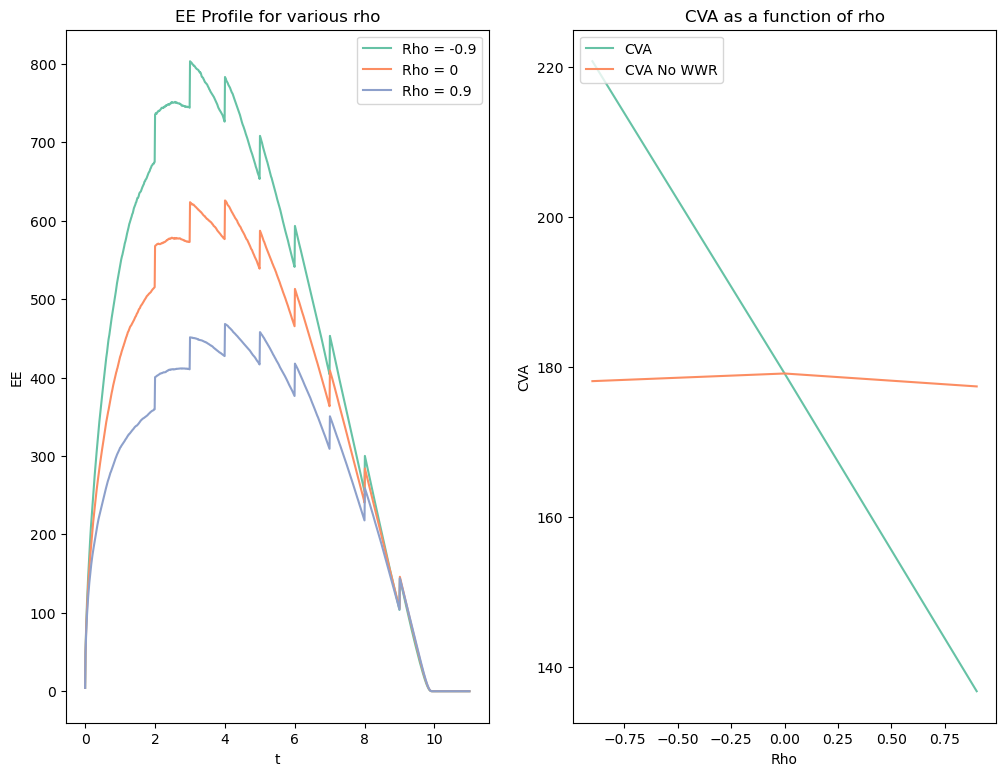

In [126]:
rhoAsset=-0.98
rhoDefault=[-0.9,0,0.9]

    
fig, ax = plt.subplots(1, 2, figsize=(12,9))

CVADefault=[]
CVANoWWRDefault=[]
for rho in tqdm(rhoDefault):
    timegrid,EE,EENoWWR,CVA,CVANoWWR=CVAComputationSwap(rhoAsset,rho)
    CVADefault.append(CVA)
    CVANoWWRDefault.append(CVANoWWR)
    ax[0].plot(timegrid,EE,label="Rho = " + str(rho))
    

    
ax[0].set_title("EE Profile for various rho")
ax[0].set_xlabel("t")
ax[0].set_ylabel("EE")
ax[0].legend(loc="upper right")

ax[1].plot(rhoDefault,CVADefault,label="CVA")
ax[1].set_title("CVA as a function of rho")
ax[1].set_xlabel("Rho")
ax[1].set_ylabel("CVA")
ax[1].legend(loc="upper left")


ax[1].plot(rhoDefault,CVANoWWRDefault,label="CVA No WWR")
ax[1].set_title("CVA as a function of rho")
ax[1].set_xlabel("Rho")
ax[1].set_ylabel("CVA")
ax[1].legend(loc="upper left")

    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.14s/it]


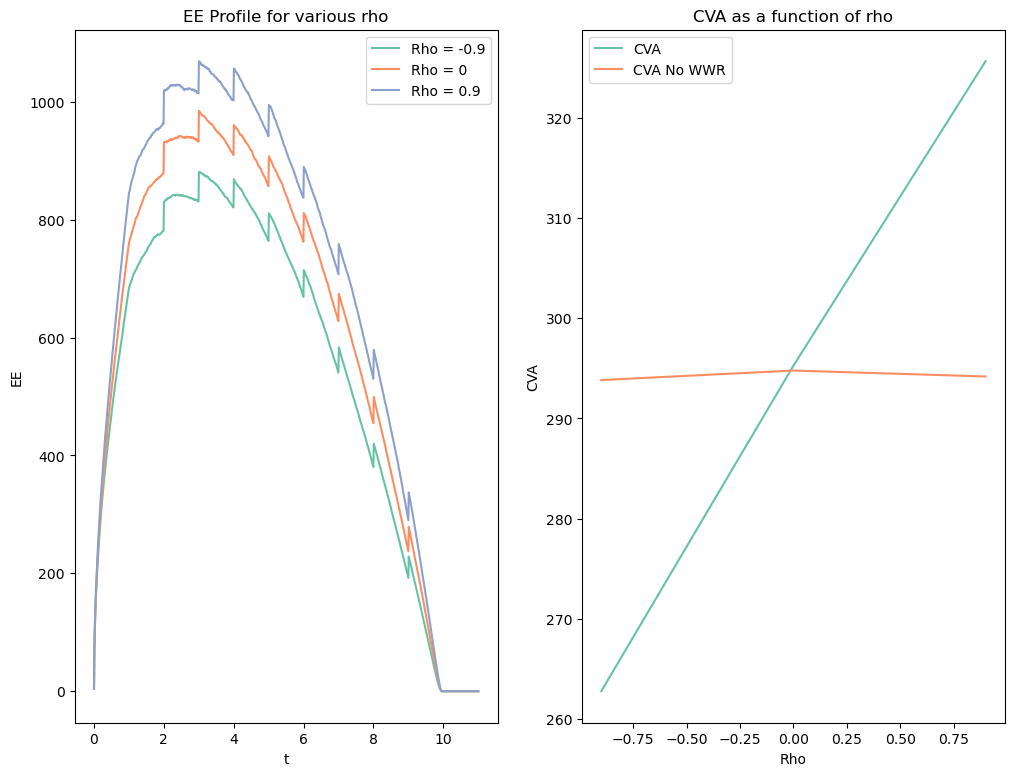

In [127]:
rhoAsset=0
rhoDefault=[-0.9,0,0.9]

    
fig, ax = plt.subplots(1, 2, figsize=(12,9))

CVADefault=[]
CVANoWWRDefault=[]
for rho in tqdm(rhoDefault):
    timegrid,EE,EENoWWR,CVA,CVANoWWR=CVAComputationSwap(rhoAsset,rho)
    CVADefault.append(CVA)
    CVANoWWRDefault.append(CVANoWWR)
    ax[0].plot(timegrid,EE,label="Rho = " + str(rho))
    

    
ax[0].set_title("EE Profile for various rho")
ax[0].set_xlabel("t")
ax[0].set_ylabel("EE")
ax[0].legend(loc="upper right")

ax[1].plot(rhoDefault,CVADefault,label="CVA")
ax[1].set_title("CVA as a function of rho")
ax[1].set_xlabel("Rho")
ax[1].set_ylabel("CVA")
ax[1].legend(loc="upper left")


ax[1].plot(rhoDefault,CVANoWWRDefault,label="CVA No WWR")
ax[1].set_title("CVA as a function of rho")
ax[1].set_xlabel("Rho")
ax[1].set_ylabel("CVA")
ax[1].legend(loc="upper left")

    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:04<00:00, 21.46s/it]


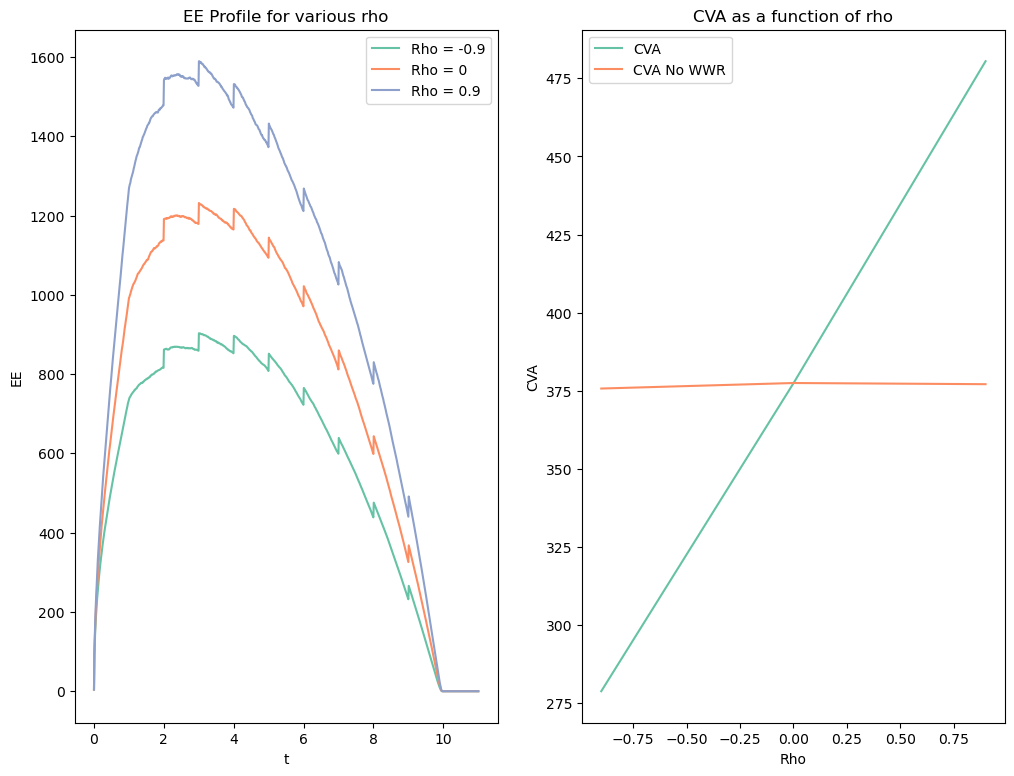

In [129]:
rhoAsset=0.98
rhoDefault=[-0.9,0,0.9]

    
fig, ax = plt.subplots(1, 2, figsize=(12,9))

CVADefault=[]
CVANoWWRDefault=[]
for rho in tqdm(rhoDefault):
    timegrid,EE,EENoWWR,CVA,CVANoWWR=CVAComputationSwap(rhoAsset,rho)
    CVADefault.append(CVA)
    CVANoWWRDefault.append(CVANoWWR)
    ax[0].plot(timegrid,EE,label="Rho = " + str(rho))
    

    
ax[0].set_title("EE Profile for various rho")
ax[0].set_xlabel("t")
ax[0].set_ylabel("EE")
ax[0].legend(loc="upper right")

ax[1].plot(rhoDefault,CVADefault,label="CVA")
ax[1].set_title("CVA as a function of rho")
ax[1].set_xlabel("Rho")
ax[1].set_ylabel("CVA")
ax[1].legend(loc="upper left")


ax[1].plot(rhoDefault,CVANoWWRDefault,label="CVA No WWR")
ax[1].set_title("CVA as a function of rho")
ax[1].set_xlabel("Rho")
ax[1].set_ylabel("CVA")
ax[1].legend(loc="upper left")

    

<h3> CVA of an Interest Rate Swap under Hull-White Model :  </h3>

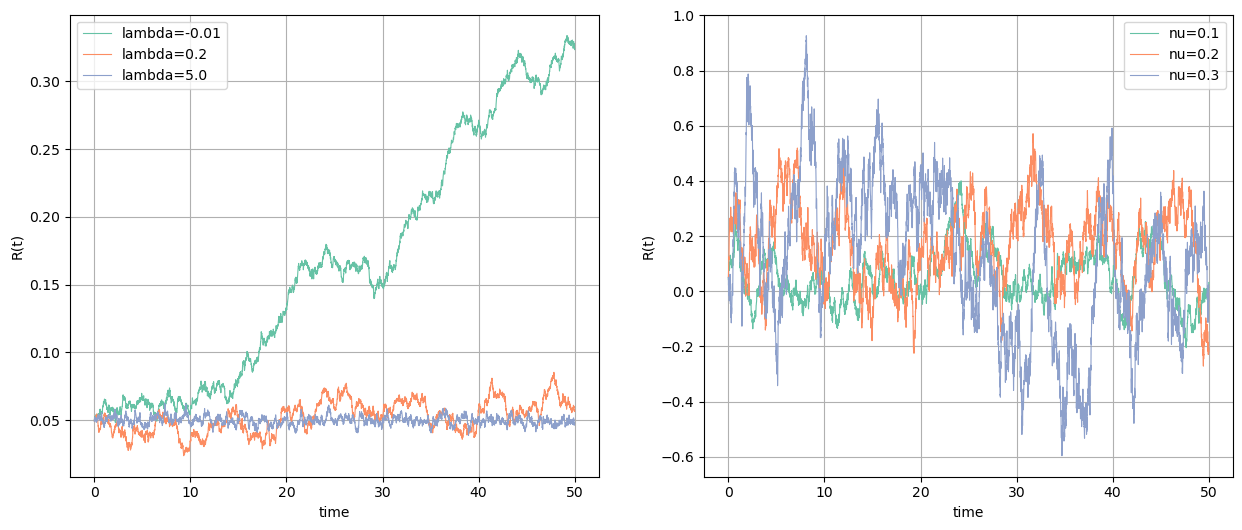

In [10]:
def generate_hW_paths(NbrPaths,NbrSteps,T,P0T, lambd, nu,rhoDefault):
    
    
    # Intensity Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
    dt = T / float(NbrSteps)
    forward = lambda t: -(np.log(P0T(t+dt)) - np.log(P0T(t -dt)))/(2*dt)
    r0 = forward(0.00001)
    theta = lambda t: 1.0/lambd * (forward(t+dt)-forward(t-dt))/(2.0*dt) + forward(t) + \
    nu*nu/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    Z = np.random.normal(0.0,1.0,[NbrPaths,NbrSteps])
    W = np.zeros([NbrPaths, NbrSteps+1])
    R = np.zeros([NbrPaths, NbrSteps+1])
    Survival=np.ones(([NbrPaths, NbrSteps+1]))
    λ=np.zeros(([NbrPaths,NbrSteps+1]))
    time = np.zeros([NbrSteps+1])
    mean= [0,0]
    cov=[[1,rhoDefault],[rhoDefault,1]]
    R[:,0]=r0
    λ[:,0]=lambda0
        
    for i in range(0,NbrSteps):
        Gaussian=np.random.multivariate_normal(mean,cov,NbrPaths)
        time[i+1] = time[i] +dt
        R[:,i+1] = R[:,i] + lambd * (theta(time[i]) - R[:,i]) * dt + nu*np.sqrt(dt)* Gaussian[:,0]
        λ[:,i+1]=λ[:,i] + kappalambd*(thetalambd-np.maximum(λ[:,i],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i],0.0))*np.sqrt(dt) * (rhoDefault * Gaussian[:,0] + np.sqrt(1-rhoDefault**2)*Gaussian[:,1])
        Survival[:,i+1]=Survival[:,i]*np.exp(-(λ[:,i+1]+λ[:,i])*0.5*dt)

    # Outputs
    return time, R,λ,Survival

def simulate_HW_Paths(NoOfPaths, NoOfSteps):
    T         = 50.0
    lambd     = 0.5
    nu       = 0.01
    RhoDefault=0.5
    np.random.seed(0) #for reproductibility
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T) 

    # Effect of mean reversion lambda
    fig, ax = plt.subplots(1, 2, figsize = (15, 6))
    legend = []
    lambdVec = [-0.01, 0.2, 5.0]
    for lambdTemp in lambdVec:    
        time, R,λ,Survival= generate_hW_paths(NoOfPaths,NoOfSteps,T,P0T, lambdTemp, nu,RhoDefault)
        legend.append('lambda={0}'.format(lambdTemp))
        ax[0].plot(time, np.transpose(R), linewidth = '0.8')  
        ax[0].set_xlabel("time")
        ax[0].set_ylabel("R(t)")
    ax[0].legend(legend)
    ax[0].grid()
    # Effect of the volatility
    legend = []
    nuVec = [0.1, 0.2, 0.3]
    for nuTemp in nuVec:
        time, R,λ,Survival = generate_hW_paths(NoOfPaths,NoOfSteps,T,P0T, lambd, nuTemp,RhoDefault)
        legend.append('nu={0}'.format(nuTemp))
        ax[1].plot(time, np.transpose(R), linewidth = '0.8') 
        ax[1].set_xlabel("time")
        ax[1].set_ylabel("R(t)")
    ax[1].legend(legend)
    ax[1].grid()
    #fig.savefig("Hull_white_model_parameters.png")
    plt.show()
simulate_HW_Paths (1, 5000)

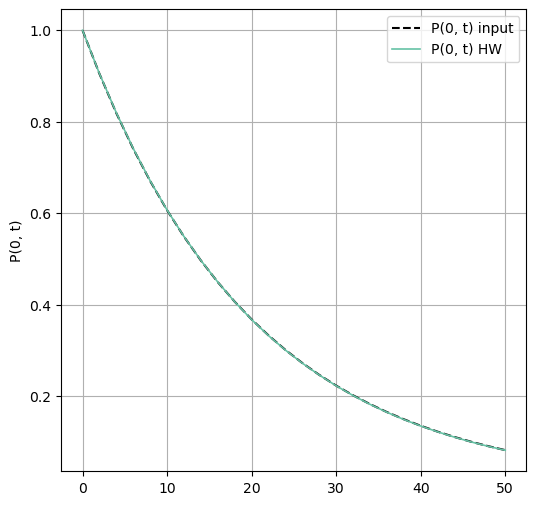

In [11]:
def ZCB_sanity_check(NoOfPaths, NoOfSteps):
    T         = 50.0
    lambd     = 0.5
    nu       = 0.01
    dt = T / float(NoOfSteps)
    RhoDefault=0.5
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T) 
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))  
    time, R,λ,Survival = generate_hW_paths(NoOfPaths,NoOfSteps,T,P0T, lambd, nu,RhoDefault)
    M = np.zeros([NoOfPaths, NoOfSteps+1])
    M[:,0]= 1.0
    for i in range(0, NoOfSteps):
        #money saving account:  dM(t)=rM(t)dt is M(t)=M(t_0)exp(int_0^tr(t)dt)
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1]+R[:,i])*0.5*dt) #Tripazoides method
    Pmdl=  np.zeros([NoOfSteps+1])
    for i in range(0,NoOfSteps+1):
        Pmdl[i] = np.mean(1.0/M[:,i])
    ax.plot(time,(P0T(time)),"--k", label = "P(0, t) input")
    ax.plot(time, Pmdl, linewidth = "1.2", label = "P(0, t) HW")
    ax.set_ylabel("P(0, t)")
    ax.grid()
    plt.legend()
    plt.show()
    #fig.savefig("Hull_white_ZCB.png")
ZCB_sanity_check (2500, 25)

In [11]:
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0


def HW_theta(lambd,eta,P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    #print("CHANGED THETA")
    return theta#lambda t: 0.1+t-t
    
def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

def HW_ZCB(lambd,eta,P0T,T1,T2,rT1):
    n = np.size(rT1) 
        
    if T1<T2:
        B_r = HW_B(lambd,eta,T1,T2)
        A_r = HW_A(lambd,eta,P0T,T1,T2)
        return np.exp(A_r + B_r *rT1)
    else:
        return np.ones([n])

def HW_SwapPrice(CP,notional,K,t,Ti,Tm,n,r_t,P0T,lambd,eta):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= np.zeros(np.size(r_t));
    
    P_t_TiLambda = lambda Ti : HW_ZCB(lambd,eta,P0T,t,Ti,r_t)
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
            
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    
    if CP==OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    
    return swap*notional

In [13]:
def CVAComputationSwapHW(rhoDefault):
     
    
    # Setting Parameters
    NoOfPaths = 50000
    NoOfSteps = 1000
    lambd     = 0.5
    eta       = 0.03
    notional  = 10000.0 
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12

    
    
 

    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)
    P0T = lambda T: np.exp(-0.01*T)
    # We define a ZCB curve (obtained from the market)
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)   
    # Here we simulate the exposure profiles for a swap, using the HW model    
    # Swap settings
    K = 0.01  # strike
    Ti = 1.0  # begining of the swap
    Tm = 10.0 # end date of the swap 
    n = 10    # number of payments between Ti and Tm
    timeGrid, r,λ,Survival = generate_hW_paths(NoOfPaths,NoOfSteps,Tm+1.0 ,P0T, lambd,eta,rhoDefault)
    dt = timeGrid[1]-timeGrid[0]  
    
    
    # CVA Parameters Defining
    CVA=0
    CVANoWWR=0
    RecoveryRate=0.4
    #Money saving account
    M_t = np.zeros([NoOfPaths,NoOfSteps])  
    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt)
    Value= np.zeros([NoOfPaths,NoOfSteps+1])
    E  = np.zeros([NoOfPaths,NoOfSteps+1])
    EE = np.zeros([NoOfSteps+1])
    ENoWWR= np.zeros([NoOfPaths,NoOfSteps+1])
    EENoWWR= np.zeros([NoOfSteps+1])
    for (idx, ti) in enumerate(timeGrid[0:-2]):
        V =  HW_SwapPrice(OptionTypeSwap.PAYER,notional,K,timeGrid[idx],Ti,Tm,n,r[:,idx],P0T,lambd,eta)
        Value[:,idx] = V
        E[:,idx] = (np.maximum(V,0.0) * λ[:,idx] * Survival[:,idx]) / (h(ti) * Gfunc(ti))
        ENoWWR[:,idx]=np.maximum(V,0.0)
        EE[idx] = np.mean(E[:,idx]/M_t[:,idx])
        EENoWWR[idx]=np.mean(ENoWWR[:,idx]/M_t[:,idx])
        
        #fig, ax = plt.subplots(1, 2, figsize = (15, 6))
        #ax[0].plot(timeGrid,Value[0:100,:].transpose(),linewidth ="0.3" )
        #ax[0].grid()
        #ax[0].set_xlabel('time t')
        #ax[0].set_ylabel('Swap Value(t)')
        #ax[0].set_title('Value of a swap')    
        #ax[1].plot(timeGrid,EE)
        #ax[1].grid()
        #ax[1].set_xlabel('time t')
        #ax[1].set_ylabel('EE(t)')
        #ax[1].set_title('Discounted Expected (positive) exposure, EE avec rho=' + str(rho))
        #plt.show()
    
    for (idx,ti) in enumerate(timeGrid[0:-2]):
        CVA+= - (1-RecoveryRate) * EE[idx] * (Gfunc(ti+dt) - Gfunc(ti))
        CVANoWWR += - (1-RecoveryRate) * EENoWWR[idx] * (Gfunc(ti+dt) - Gfunc(ti))
   
 
        
        
    
        
    # Outputs
    return timeGrid,EE,EENoWWR,CVA,CVANoWWR


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:26<00:00, 17.31s/it]


(0.0, 400.0)

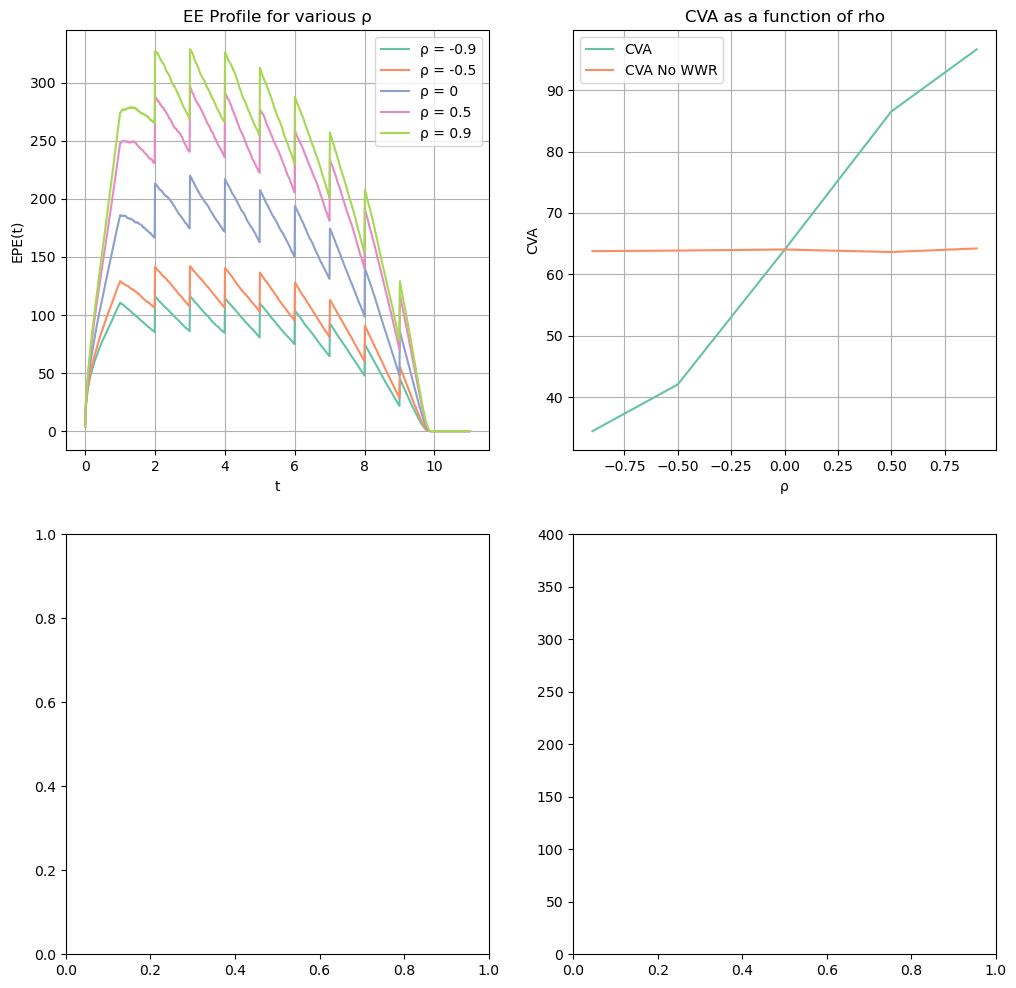

In [15]:
rhoDefault=[-0.9,-0.5,0,0.5,0.9]

    
fig, ax = plt.subplots(2, 2, figsize=(12,12))

CVADefault=[]
CVANoWWRDefault=[]
for rho in tqdm(rhoDefault):
    timegrid,EE,EENoWWR,CVA,CVANoWWR=CVAComputationSwapHW(rho)
    CVADefault.append(CVA)
    CVANoWWRDefault.append(CVANoWWR)
    ax[0][0].plot(timegrid,EE,label="ρ = " + str(rho))
    

    
ax[0][0].set_title("EE Profile for various ρ")
ax[0][0].set_xlabel("t")
ax[0][0].set_ylabel("EPE(t)")
ax[0][0].legend(loc="upper right")
ax[0][0].grid()
ax[0][1].plot(rhoDefault,CVADefault,label="CVA")
ax[0][1].set_title("CVA as a function of ρ")
ax[0][1].set_xlabel("ρ")
ax[0][1].set_ylabel("CVA")
ax[0][1].legend(loc="upper left")


ax[0][1].plot(rhoDefault,CVANoWWRDefault,label="CVA No WWR")
ax[0][1].set_title("CVA as a function of rho")
ax[0][1].set_xlabel("ρ")
ax[0][1].set_ylabel("CVA")
ax[0][1].legend(loc="upper left")
ax[0][1].grid()

plt.ylim(0,400)
    

<h3> Cliquet Option CVA Computation under Heston Model : </h3>

In [ ]:
def CallOptionBSModel(S0=100, t=0,T=5, r=0.03, kappa=1.5, theta=0.04,, rho=0, sigma=0.001,Strike=100,NbrSteps=51, NbrPaths=10000):
    
    # Setting Parameters
    dt = (T-t) / NbrSteps
    
    
    # Defining 
    S=np.ones(([NbrPaths, NbrSteps]))
    v = np.zeros([NbrPaths, NbrSteps])
    
    R[:,0]=  S0
    
    S[:,0]=  S0
    v[:,0] = v0
    
    #first_index = 1 + int((t* (NbrSteps-1)) / T)
    for i in range(1,NbrSteps):
        WT = np.random.multivariate_normal(loc=0,scale=1, size=NbrPaths) * np.sqrt(dt) 
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT[:,0])
        #v[:,i]=np.abs(v[:,i-1] + kappa*(theta-v[:,i-1]) *dt +sigma* np.sqrt(v[:,i-1])*WT[:,1])
    
        
    print(S)
        
    
    Payoff=np.exp(-r*(T-t))*np.maximum(S[:,-1] - Strike,0)
    price=np.mean(Payoff)
    
    return S, price
    
                          

In [ ]:
_,_,price=CallOptionHestonModel(S0=100)

<h3> CVA for Cliquet Options Under Heston Model :  </h3>


<h5> Heston Model  : </h5> : 


\begin{equation}
dS_t=r S_t dt  + \sqrt{v_t} S_t dW_t^{1}\\
dv_t = \kappa ( \theta -v_t) dt + \sigma v_t dW_t^{2} \\
d<W_t^{1},W_t^{2}>_t=\rho_m dt 
\end{equation}


Avec :

- $r$ le risk free rate 
- $\kappa$ la vitesse de mean-reversion
- $\theta$ la volatiité de long terme
- $\sigma$ la volatilité de la volatilité



<h5> Cliquet Options : </h5>

Une option Cliquet a le payoff suivant :

\begin{equation}
max(\sum_{i=1}^{N} max(0,min(C_n,R_n)),F)
\end{equation}

Avec :

- $R_n= \frac{S_{t_{n}}}{S_{t_{n-1}}}-1$
- $C_n$ sont des locals Caps et $F$ un floor global sur le retour global tronqué

On va prendre :

- $r=0.03$
- $F=0.16$
- $Cap=0.32$
- $Fixing = 1$
- $ NumFixing = 5$
- $ T=5$
- $v_0=0.04$
- $\kappa = 1.5$
- $\theta = 0.04$
- $\sigma = 0.001$
- $\rho_M = 0$

In [25]:
r=0.03
nbFixings=2
t=0
T=5
v0=0.04
S0=1
kappa=1.5
theta=0.04
sigma=0.1
rhoAsset=0
rhoDefault=-1
NbrSteps=201
NbrPaths=10000


In [633]:
def CliquetOptionHestonModel(S0=1, t=0,T=5, r=0.03, kappa=1.5, theta=0.04, v0=0.04, rhoAsset=0, sigma=0.1, 
                          NbrSteps=51, NbrPaths=10000,nbFixings=2):
        
        
        dt = (T-t) / NbrSteps
        Cap = 0.32
        Floor = 0.16
    
        FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
        StartingIndex= int((NbrSteps-1)*t / T)
        
    
        
        NbRefixing = len(FixingTimes[FixingTimes > StartingIndex]) + 1
        S=np.ones(([NbrPaths, NbrSteps+1]))
        v = np.zeros([NbrPaths, NbrSteps+1])
        R=np.zeros([NbrPaths,NbRefixing])
        Return=np.zeros([NbrPaths,NbRefixing-1])
        
        
        R[:,0]=S0
        S[:,0]=S0
        v[:,0]=v0
        
        mean= [0,0]
        cov=[[1,rhoAsset],[rhoAsset,1]]
        
        current_index=1
        for i in range(StartingIndex,NbrSteps + StartingIndex):
            j= (i +1 - StartingIndex)
            WT = np.random.multivariate_normal(mean,cov, size=NbrPaths) * np.sqrt(dt) 
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + np.sqrt(v[:,j-1]) *WT[:,0])
            v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqrt(v[:,j-1])*WT[:,1])
            


            if i in FixingTimes[FixingTimes > StartingIndex] :
                R[:,current_index]=S[:,j-1]
                Return[:,current_index-1] = np.maximum(0,np.minimum((R[:,current_index] / R[:,current_index-1])-1,Cap))
                current_index+=1
                

        Payoff=np.exp(-r*(T-t))*np.maximum(np.sum(Return,axis=1),Floor)
        price=np.mean(Payoff)
        return S,v,R,Return,price
        

In [634]:
r=0
nbFixings=6
t=0
T=5
v0=0.04
S0=1
kappa=1.5
theta=0.04
sigma=0.1
rhoAsset=0
rhoDefault=-1
NbrSteps=201
NbrPaths=50000


In [635]:
_,_,_,_,price=CliquetOptionHestonModel(S0,t,T,r,kappa,0.04,v0,rhoAsset,sigma,NbrSteps,NbrPaths,nbFixings)
print(price)

0.3748768550207037


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.72s/it]


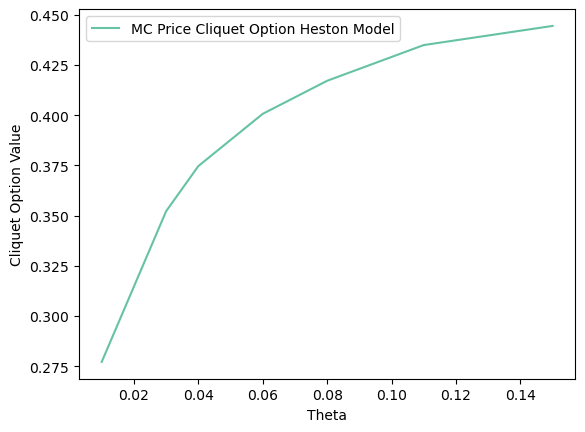

In [550]:
ThetaVec=[0.01,0.03,0.04,0.06,0.08,0.11,0.15]
MCValue=[]

for theta in tqdm(ThetaVec):
    _,_,_,_,price=CliquetOptionHestonModel(S0,t,T,r,kappa,theta,v0,rhoAsset,sigma,NbrSteps,NbrPaths,nbFixings)
    MCValue.append(price)
    
    
plt.plot(ThetaVec,MCValue,label="MC Price Cliquet Option Heston Model")
plt.xlabel("Theta")
plt.ylabel("Cliquet Option Value")
plt.legend()

In [636]:
def CVACliquetOptionHestonModel(S=1, t=0,T=5, r=0.03, kappa=1.5, theta=0.04, v0=0.04, rhoAsset=0,rhoDefault=0, sigma=0.1, 
                          NbrSteps=51, NbrPaths=10000,nbFixings=6):
    
    print(r)
    print(kappa)
    print(theta)
    print(v0)
    print(sigma)
    
    
    # Setting Parameters
    dt = (T-t) / NbrSteps
    Cap = 0.32
    Floor = 0.16
    
    FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
    
    # CIR Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0   =0.12
    
    # Defining 
    S=np.ones(([NbrPaths, NbrSteps]))
    v = np.zeros([NbrPaths, NbrSteps])
    R=np.zeros([NbrPaths,nbFixings])
    Return=np.zeros([NbrPaths,nbFixings-1])
    
    λ=np.zeros(([NbrPaths,NbrSteps])) # Default Intensity
    integralλ=np.zeros(([NbrPaths,NbrSteps]))
S    Exposure=np.zeros((NbrPaths))
    
    R[:,0]=  S0
    S[:,0]=  S0
    v[:,0] = v0
    λ[:,0]=lambda0

    
    NbrStepsInner=51
    NbrPathsInner=10000
    #first_index = 1 + int((t* (NbrSteps-1)) / T)
    for i in range(1,NbrSteps):
        WT = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rhoAsset],[rhoAsset,1]]), size=NbrPaths) * np.sqrt(dt) 
        Z= np.random.normal(0,1,size=NbrPaths)* np.sqrt(dt)
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + np.sqrt(v[:,i-1]) *WT[:,0])
        v[:,i]=np.abs(v[:,i-1] + kappa*(theta-v[:,i-1]) *dt +sigma* np.sqrt(v[:,i-1])*WT[:,1])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))* (rhoDefault * WT[:,0] + np.sqrt(1-rhoDefault**2) * Z)
        integralλ[:,i] = integralλ[:,i-1] + ((λ[:,i-1]+λ[:,i])*0.5*dt)

            
    def CliquetOptionHestonModel(S0,time,T, r, kappa, theta, v0, rhoAsset, sigma, 
                          NbrSteps, NbrPaths,nbFixings):
        
        
        dt = (T-time) / NbrSteps
        Cap = 0.32
        Floor = 0.16
    
        FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
        StartingIndex= int((NbrSteps-1)*time / T)
        
    
        
        NbRefixing = len(FixingTimes[FixingTimes > StartingIndex]) + 1
        S=np.ones(([NbrPaths, NbrSteps+1]))
        v = np.zeros([NbrPaths, NbrSteps+1])
        R=np.zeros([NbrPaths,NbRefixing])
        Return=np.zeros([NbrPaths,NbRefixing-1])
        
        
        R[:,0]=S0
        S[:,0]=S0
        v[:,0]=v0
        
        current_index=1
        for i in range(StartingIndex,NbrSteps + StartingIndex):
            j= (i +1 - StartingIndex)
            WT = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rhoAsset],[rhoAsset,1]]), size=NbrPaths) * np.sqrt(dt) 
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + np.sqrt(v[:,j-1]) *WT[:,0])
            v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqrt(v[:,j-1])*WT[:,1])
            


            if i in FixingTimes[FixingTimes > StartingIndex] :
                R[:,current_index]=S[:,j-1]
                Return[:,current_index-1] = np.maximum(0,np.minimum((R[:,current_index] / R[:,current_index-1])-1,Cap))
                current_index+=1

        Payoff=np.exp(-r*(T-time))*np.maximum(np.sum(Return,axis=1),Floor)
        price=np.mean(Payoff)
        return S,v,R,Return,price
        
        
        
            
    exponential_samples=np.random.exponential(size=NbrPaths)
    
    for i in range(NbrPaths):
        exponential_sample=exponential_samples[i]
        current_path=integralλ[i,:]
        if current_path[-1] < exponential_sample:
            DefaultTime[i]= 2*T # Temps de Défaut > T 
        else:
            j=0
            while current_path[j] < exponential_sample:
                j+=1
            DefaultTime[i]=j*dt
        
    for sample in tqdm(range(NbrPaths)):
        default_time = DefaultTime[sample]
        index_default= int(default_time / dt)
        if default_time < T :
            current_S=S[sample,index_default]
            current_v=v[sample,index_default]
            _,_,_,_,price=CliquetOptionHestonModel(current_S,default_time,T,r,kappa, theta, current_v, rhoAsset, sigma, 
                          NbrStepsInner, NbrPathsInner,nbFixings)
            Exposure[sample]=np.exp(-r* default_time) * price 
        else:
            Exposure[sample]=0
       
    
    
    RecoveryRate = 0.4
    CVA=(1-RecoveryRate) * np.mean(Exposure)
    
    return DefaultTime,CVA



                          

In [637]:
rhoDefault=1
S0=1
t=0
rhoAsset=0
r=0
sigma=0.1
kappa=1.5
theta=0.04
nbFixings=6
T=5
NbrPaths=1000
NbrSteps=50
CVACliquet=[]
_,CVA=CVACliquetOptionHestonModel(S0,t,T,r,kappa,theta,v0,rhoAsset,rhoDefault,sigma,NbrSteps,NbrPaths,nbFixings)
print(CVA)    

0
1.5
0.04
0.04
0.1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.40it/s]

0.06142849533667164


In [591]:
_,_,_,_,price=CliquetOptionHestonModel(S0,3.4 ,T, r, kappa, theta, 0.0330, rhoAsset, sigma, 
                          NbrSteps, NbrPaths,nbFixings)


price

[[0.11189781 0.13743565]
 [0.05322496 0.00902637]
 [0.02269105 0.05725069]
 ...
 [0.         0.        ]
 [0.02747757 0.        ]
 [0.         0.        ]]


0.16342821168503097

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:15:09<00:00, 901.82s/it]


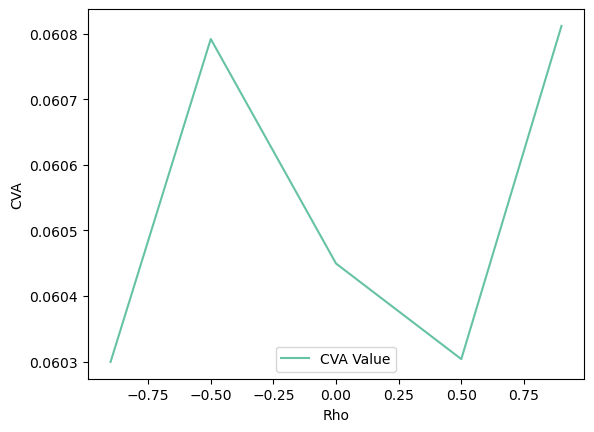

In [544]:
RhoDefault=[-0.9,-0.5,0,0.5,0.9]
S0=1
t=0
rhoAsset=0
sigma=0.1
kappa=1.5
theta=0.04
nbFixings=6
T=5
CVACliquet=[]
for rhoD in tqdm(RhoDefault):
    _,CVA=CVACliquetOptionHestonModel(S0,t,T,r,kappa,theta,v0,rhoAsset,rhoD,sigma,NbrSteps,NbrPaths,nbFixings)
    CVACliquet.append(CVA)
    
    
plt.plot(RhoDefault,CVACliquet,label="CVA Value")
plt.xlabel("Rho")
plt.ylabel("CVA")
plt.legend()

In [584]:
kappalambd=0.35
thetalambd=0.12
sigmalambd=0.12
lambda0=0.12
RecoveryRate=0.4
NbrPaths=1000
# We define a CDS Discount curve (obtained from the market)
Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)


timestep=np.linspace(0,5,1000)

dt = timestep[1]-timestep[0]
CVA=0

for time in tqdm(timestep):
    _,_,_,_,price=CliquetOptionHestonModel(S0,0,T,r,kappa,0.04,v0,rhoAsset,sigma,NbrSteps,NbrPaths,nbFixings)
    CVA+= - (1-RecoveryRate) * price * (Gfunc(time+dt) - Gfunc(time)) 
    
print(CVA)

  0%|▏                                                                                | 2/1000 [00:00<01:34, 10.60it/s]

[[0.24991651 0.         0.         0.10039472 0.18363887]
 [0.         0.22803047 0.         0.         0.04909061]
 [0.         0.32       0.32       0.         0.        ]
 ...
 [0.07862558 0.         0.         0.         0.32      ]
 [0.         0.27908507 0.32       0.12909789 0.        ]
 [0.         0.         0.         0.12238482 0.2690148 ]]
[[0.         0.         0.16103159 0.         0.        ]
 [0.26823792 0.32       0.20670514 0.00180244 0.        ]
 [0.         0.         0.01557511 0.         0.        ]
 ...
 [0.         0.20028668 0.         0.32       0.08856545]
 [0.         0.24777181 0.         0.         0.03480038]
 [0.10675451 0.         0.22159376 0.29417368 0.        ]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.87751540e-02]
 [3.20000000e-01 3.44115461e-02 7.62056939e-02 0.00000000e+00
  0.00000000e+00]
 [2.32317178e-04 1.32731915e-02 1.32558042e-01 0.00000000e+00
  2.51561757e-01]
 ...
 [0.00000000e+00 3.45784469e-02 5.19646627e-02 

  1%|▍                                                                                | 6/1000 [00:00<01:26, 11.44it/s]

[[0.         0.14247546 0.30283257 0.25635116 0.00597839]
 [0.         0.28709049 0.         0.         0.        ]
 [0.         0.         0.         0.02751733 0.        ]
 ...
 [0.         0.04375773 0.         0.         0.        ]
 [0.         0.02285198 0.         0.         0.11868401]
 [0.13557576 0.01379463 0.08765772 0.32       0.        ]]
[[0.32       0.         0.         0.         0.16816709]
 [0.         0.32       0.         0.08816926 0.32      ]
 [0.29341531 0.32       0.         0.         0.        ]
 ...
 [0.32       0.32       0.15913204 0.02444689 0.        ]
 [0.         0.         0.         0.00348434 0.        ]
 [0.2032231  0.15296289 0.32       0.1554837  0.        ]]
[[0.14294382 0.04815377 0.         0.12221433 0.32      ]
 [0.         0.         0.23366072 0.         0.15740647]
 [0.11115445 0.         0.         0.14042563 0.0668182 ]
 ...
 [0.21923732 0.         0.12853077 0.32       0.05155822]
 [0.         0.32       0.11897119 0.26188575 0.32     

  1%|▋                                                                                | 8/1000 [00:00<01:23, 11.90it/s]

[[0.02242728 0.32       0.12311564 0.32       0.        ]
 [0.         0.3188411  0.         0.         0.17997599]
 [0.20437747 0.13201229 0.         0.         0.        ]
 ...
 [0.         0.02068606 0.24788662 0.         0.10083244]
 [0.20584124 0.0536674  0.00268673 0.         0.        ]
 [0.32       0.32       0.10631817 0.         0.        ]]
[[0.06408893 0.26640028 0.         0.00213599 0.        ]
 [0.         0.16711725 0.26185322 0.         0.        ]
 [0.03573871 0.07478386 0.11045229 0.         0.06965403]
 ...
 [0.14001381 0.11810732 0.32       0.12481668 0.14287003]
 [0.         0.11549845 0.         0.         0.10871253]
 [0.         0.         0.12355427 0.         0.        ]]
[[0.27531687 0.06468623 0.1509865  0.32       0.06971952]
 [0.         0.32       0.         0.         0.04701031]
 [0.02273367 0.17646111 0.         0.         0.32      ]
 ...
 [0.30624408 0.         0.18703533 0.10163624 0.31329211]
 [0.         0.         0.1437158  0.31812247 0.       

  1%|▉                                                                               | 12/1000 [00:01<01:24, 11.74it/s]

[[0.         0.28016656 0.00085606 0.0118258  0.        ]
 [0.11642877 0.         0.         0.0107288  0.32      ]
 [0.         0.1630232  0.         0.         0.        ]
 ...
 [0.08482287 0.32       0.         0.14230235 0.        ]
 [0.         0.17230103 0.32       0.1666545  0.        ]
 [0.         0.         0.         0.         0.32      ]]
[[0.         0.05454447 0.         0.23836208 0.        ]
 [0.06519777 0.0608795  0.         0.19024658 0.21000051]
 [0.04925747 0.         0.         0.14849911 0.03656911]
 ...
 [0.         0.09796156 0.03457074 0.32       0.        ]
 [0.         0.0250641  0.         0.04501353 0.        ]
 [0.10027532 0.         0.15499629 0.         0.        ]]
[[0.20769298 0.32       0.16073492 0.         0.06951517]
 [0.26061266 0.12686718 0.         0.         0.        ]
 [0.         0.         0.12958562 0.         0.        ]
 ...
 [0.         0.         0.10239735 0.         0.        ]
 [0.32       0.         0.         0.08450792 0.       

  1%|█                                                                               | 14/1000 [00:01<01:24, 11.64it/s]

[[0.04545941 0.         0.         0.32       0.        ]
 [0.         0.20787164 0.18529101 0.         0.        ]
 [0.         0.13316286 0.07855817 0.         0.        ]
 ...
 [0.         0.         0.32       0.         0.        ]
 [0.15394981 0.11403482 0.         0.         0.10472532]
 [0.32       0.         0.17983437 0.20411014 0.        ]]
[[0.         0.2072928  0.         0.         0.05640172]
 [0.16230169 0.0954167  0.22248032 0.00335961 0.        ]
 [0.16955886 0.         0.32       0.32       0.01431734]
 ...
 [0.         0.         0.09696166 0.0766411  0.00538925]
 [0.32       0.         0.1545514  0.         0.02173264]
 [0.         0.         0.01462921 0.         0.13736122]]
[[0.         0.         0.28511417 0.32       0.09493087]
 [0.16357471 0.2262391  0.03804492 0.         0.        ]
 [0.03306185 0.         0.18628526 0.         0.        ]
 ...
 [0.         0.         0.         0.0591711  0.32      ]
 [0.19690261 0.03191555 0.         0.06401484 0.1898537

  2%|█▍                                                                              | 18/1000 [00:01<01:21, 12.02it/s]

[[0.09600564 0.         0.32       0.         0.29011036]
 [0.         0.01120491 0.         0.25782148 0.        ]
 [0.0461246  0.23159019 0.01206126 0.         0.        ]
 ...
 [0.         0.         0.26211573 0.11768428 0.32      ]
 [0.07204967 0.         0.         0.         0.        ]
 [0.13756003 0.         0.         0.         0.31019059]]
[[0.         0.07659491 0.         0.         0.        ]
 [0.         0.32       0.06794033 0.         0.10254344]
 [0.         0.18637116 0.         0.18942481 0.        ]
 ...
 [0.32       0.         0.         0.19029975 0.32      ]
 [0.06741659 0.01461897 0.05708732 0.31567184 0.        ]
 [0.         0.12732256 0.         0.         0.        ]]
[[0.         0.23562438 0.         0.         0.25211154]
 [0.         0.32       0.         0.09952155 0.        ]
 [0.         0.         0.         0.23247291 0.        ]
 ...
 [0.         0.07819999 0.         0.20816751 0.        ]
 [0.32       0.13266863 0.11644244 0.22853611 0.       

  2%|█▌                                                                              | 20/1000 [00:01<01:20, 12.16it/s]

[[0.20948731 0.17130996 0.         0.         0.32      ]
 [0.16577042 0.14617315 0.17994174 0.         0.        ]
 [0.26563258 0.         0.28416378 0.         0.        ]
 ...
 [0.         0.32       0.04880708 0.21476641 0.32      ]
 [0.32       0.         0.         0.         0.        ]
 [0.08918601 0.15942361 0.32       0.3068964  0.02272393]]
[[0.         0.         0.07652955 0.         0.        ]
 [0.13806179 0.11541783 0.03037666 0.         0.22648052]
 [0.00826474 0.01696314 0.22836978 0.         0.0484101 ]
 ...
 [0.12952752 0.         0.06175117 0.         0.        ]
 [0.         0.21969639 0.11568635 0.00494223 0.        ]
 [0.22516278 0.27115565 0.05278065 0.         0.        ]]
[[0.10123391 0.         0.         0.13841389 0.19375535]
 [0.         0.         0.13092512 0.         0.32      ]
 [0.03846328 0.32       0.05680159 0.16177599 0.        ]
 ...
 [0.         0.07495588 0.32       0.         0.0877129 ]
 [0.02346577 0.         0.         0.         0.       

  2%|█▉                                                                              | 24/1000 [00:02<01:25, 11.46it/s]

[[0.         0.32       0.         0.         0.        ]
 [0.         0.09456671 0.32       0.28365886 0.02244851]
 [0.         0.         0.         0.32       0.17762787]
 ...
 [0.         0.         0.         0.         0.08025675]
 [0.15406945 0.         0.32       0.02789235 0.        ]
 [0.32       0.11941957 0.13648097 0.32       0.18895647]]
[[0.08746735 0.0586595  0.         0.1436706  0.        ]
 [0.         0.32       0.18482463 0.         0.        ]
 [0.26994223 0.         0.         0.06358945 0.        ]
 ...
 [0.         0.25452216 0.         0.25559714 0.02221447]
 [0.32       0.         0.         0.14377327 0.03266586]
 [0.         0.07460464 0.03908995 0.17241152 0.        ]]
[[0.09809114 0.08322559 0.32       0.         0.02221039]
 [0.20788529 0.         0.32       0.         0.32      ]
 [0.08722167 0.         0.06785827 0.18534088 0.32      ]
 ...
 [0.         0.14464139 0.         0.27130153 0.32      ]
 [0.32       0.         0.05815715 0.13836291 0.0741922

  3%|██                                                                              | 26/1000 [00:02<01:24, 11.50it/s]

[[0.09363089 0.12085456 0.14667358 0.03240876 0.19344813]
 [0.         0.12610019 0.2734498  0.         0.        ]
 [0.         0.         0.         0.         0.10431229]
 ...
 [0.         0.32       0.03047001 0.         0.        ]
 [0.03989101 0.12536235 0.16271446 0.         0.01672742]
 [0.         0.08350481 0.         0.00145245 0.0470737 ]]
[[0.         0.30486229 0.23398335 0.30838701 0.        ]
 [0.03196632 0.         0.00919374 0.02039757 0.        ]
 [0.32       0.05619295 0.         0.         0.22199703]
 ...
 [0.         0.02590779 0.         0.         0.12649415]
 [0.21876703 0.03971644 0.         0.22296787 0.05423564]
 [0.11223995 0.         0.15729144 0.09240315 0.01945866]]
[[0.         0.         0.04653717 0.         0.        ]
 [0.32       0.32       0.29764555 0.         0.26794079]
 [0.         0.         0.1157137  0.         0.21329551]
 ...
 [0.32       0.03908409 0.         0.30619869 0.03951347]
 [0.         0.07157796 0.11754515 0.14892141 0.0460638

  3%|██▍                                                                             | 30/1000 [00:02<01:23, 11.67it/s]

[[0.         0.         0.         0.12082185 0.        ]
 [0.         0.20224031 0.17887347 0.1110671  0.        ]
 [0.2204823  0.18713614 0.         0.0344748  0.14876643]
 ...
 [0.         0.00366725 0.         0.         0.        ]
 [0.03042857 0.06495257 0.         0.         0.17944309]
 [0.         0.         0.         0.03773196 0.2720067 ]]
[[0.13493333 0.1206287  0.14434087 0.         0.        ]
 [0.         0.         0.05219543 0.05901386 0.        ]
 [0.         0.         0.05311031 0.         0.26837052]
 ...
 [0.07194366 0.         0.         0.         0.14906503]
 [0.00769862 0.         0.32       0.18841776 0.        ]
 [0.0006037  0.25857675 0.14925665 0.11304268 0.        ]]
[[0.2908036  0.         0.         0.32       0.26686435]
 [0.32       0.11300634 0.         0.32       0.02192146]
 [0.         0.         0.05345363 0.         0.        ]
 ...
 [0.05103343 0.03306516 0.         0.         0.        ]
 [0.         0.         0.08391797 0.00798367 0.0136775

  3%|██▌                                                                             | 32/1000 [00:02<01:25, 11.31it/s]

[[0.08341951 0.07104234 0.         0.         0.19574713]
 [0.26585139 0.         0.13296262 0.         0.12108642]
 [0.         0.32       0.02520059 0.         0.        ]
 ...
 [0.16307074 0.         0.04567744 0.10047703 0.21904663]
 [0.2110208  0.         0.24308965 0.05198578 0.32      ]
 [0.32       0.25553005 0.06885994 0.         0.        ]]
[[0.00894322 0.         0.         0.11524719 0.        ]
 [0.10277696 0.         0.30148788 0.         0.15937115]
 [0.05414998 0.32       0.23466431 0.31092904 0.        ]
 ...
 [0.26884206 0.18620014 0.         0.23586172 0.32      ]
 [0.         0.         0.         0.0766776  0.0799457 ]
 [0.         0.02254438 0.         0.11985064 0.21072661]]
[[0.13490259 0.32       0.         0.         0.        ]
 [0.19142263 0.         0.         0.         0.        ]
 [0.09348065 0.32       0.         0.         0.03243548]
 ...
 [0.05238189 0.         0.05533105 0.19574822 0.32      ]
 [0.02344189 0.06718136 0.01520349 0.         0.       

  4%|██▉                                                                             | 36/1000 [00:03<01:24, 11.38it/s]

[[0.18389609 0.         0.21761228 0.32       0.32      ]
 [0.         0.21981059 0.         0.32       0.08889026]
 [0.09455255 0.19323697 0.10363502 0.         0.23569585]
 ...
 [0.28218269 0.08173199 0.         0.         0.32      ]
 [0.         0.02128447 0.         0.         0.19347327]
 [0.32       0.         0.16653372 0.32       0.        ]]
[[0.         0.14245865 0.024654   0.20822677 0.        ]
 [0.16103397 0.         0.         0.12499017 0.        ]
 [0.         0.         0.         0.07329895 0.31172442]
 ...
 [0.32       0.         0.         0.32       0.        ]
 [0.18757172 0.26092699 0.32       0.         0.2232637 ]
 [0.30953609 0.         0.         0.09058718 0.        ]]
[[0.04175581 0.2089857  0.         0.0682862  0.        ]
 [0.         0.25275616 0.         0.28885008 0.        ]
 [0.32       0.04326663 0.         0.32       0.26647021]
 ...
 [0.         0.         0.3081671  0.0334118  0.        ]
 [0.0246767  0.         0.         0.         0.       

  4%|███                                                                             | 38/1000 [00:03<01:20, 11.91it/s]

[[0.10405425 0.05138309 0.         0.12593758 0.        ]
 [0.05899725 0.20328592 0.10745651 0.32       0.32      ]
 [0.         0.03032892 0.27506081 0.07485151 0.        ]
 ...
 [0.         0.         0.06312128 0.01178225 0.18430722]
 [0.20972729 0.         0.09469681 0.         0.21746661]
 [0.1001852  0.         0.28960925 0.07231983 0.        ]]
[[0.         0.23387285 0.32       0.01142695 0.        ]
 [0.2483172  0.         0.         0.1497437  0.        ]
 [0.         0.         0.         0.32       0.30912011]
 ...
 [0.06803424 0.09711032 0.32       0.02687445 0.        ]
 [0.15972554 0.         0.05927168 0.         0.        ]
 [0.13644119 0.0919336  0.15688708 0.2362144  0.23929282]]
[[0.32       0.14591519 0.         0.         0.03798703]
 [0.2812988  0.2471014  0.         0.13135078 0.11467207]
 [0.26026076 0.         0.         0.         0.32      ]
 ...
 [0.19994587 0.27136593 0.12407119 0.         0.06771731]
 [0.13182446 0.         0.         0.         0.       

  4%|███▎                                                                            | 42/1000 [00:03<01:22, 11.57it/s]

[[0.         0.03496063 0.06847965 0.08838903 0.        ]
 [0.         0.         0.18929206 0.         0.        ]
 [0.         0.18939538 0.26149185 0.12272148 0.        ]
 ...
 [0.07883334 0.11455981 0.01064282 0.         0.06176263]
 [0.2156312  0.         0.29753492 0.14682821 0.02823185]
 [0.         0.         0.         0.         0.25259588]]
[[0.         0.12644011 0.         0.         0.02493656]
 [0.         0.01037243 0.01008386 0.12072818 0.27614007]
 [0.26034959 0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.08505358 0.1983543  0.         0.05184536 0.        ]
 [0.15002366 0.1643768  0.         0.12147886 0.        ]]
[[0.         0.1979764  0.04108153 0.         0.        ]
 [0.02118425 0.         0.         0.12521454 0.        ]
 [0.08941653 0.06824518 0.         0.         0.        ]
 ...
 [0.32       0.11531259 0.         0.         0.        ]
 [0.         0.09174702 0.32       0.         0.2237505

  4%|███▌                                                                            | 44/1000 [00:03<01:22, 11.53it/s]

[[0.         0.29117957 0.09879012 0.07568547 0.03612547]
 [0.         0.         0.         0.20009339 0.12160063]
 [0.         0.         0.06476421 0.02204671 0.32      ]
 ...
 [0.09293926 0.07152203 0.         0.         0.1395385 ]
 [0.04514857 0.         0.21708182 0.         0.        ]
 [0.30926226 0.31399658 0.         0.32       0.        ]]
[[0.06889095 0.31659354 0.31226892 0.26543386 0.        ]
 [0.         0.         0.         0.15860225 0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.1213429  0.         0.24427741 0.12199424 0.        ]
 [0.28730292 0.02792779 0.         0.10562121 0.02513907]
 [0.32       0.         0.02323914 0.         0.11896862]]
[[0.         0.32       0.32       0.         0.04085817]
 [0.1553326  0.18743678 0.         0.08514321 0.        ]
 [0.06716106 0.19402161 0.11109196 0.24414299 0.        ]
 ...
 [0.1656664  0.27465457 0.         0.         0.        ]
 [0.         0.         0.         0.32       0.       

  5%|███▊                                                                            | 48/1000 [00:04<01:22, 11.50it/s]

[[0.         0.         0.         0.         0.05377181]
 [0.         0.04195253 0.         0.         0.32      ]
 [0.         0.         0.         0.049199   0.05615261]
 ...
 [0.32       0.20477215 0.29587881 0.         0.28793303]
 [0.         0.11529032 0.24825003 0.0208698  0.        ]
 [0.         0.         0.32       0.         0.13566949]]
[[0.18828112 0.         0.04704874 0.         0.30179491]
 [0.         0.28333656 0.         0.         0.25283841]
 [0.         0.01931395 0.         0.01230696 0.01379836]
 ...
 [0.         0.04036902 0.04625199 0.24089162 0.        ]
 [0.         0.27978727 0.30412348 0.         0.        ]
 [0.         0.32       0.         0.32       0.        ]]
[[0.         0.23504731 0.         0.15924264 0.        ]
 [0.         0.         0.32       0.13874583 0.        ]
 [0.32       0.15281953 0.03397647 0.         0.26736925]
 ...
 [0.         0.         0.         0.04086882 0.        ]
 [0.         0.07971554 0.         0.         0.       

  5%|████                                                                            | 50/1000 [00:04<01:24, 11.19it/s]

[[0.         0.30735245 0.32       0.         0.        ]
 [0.         0.13744347 0.         0.         0.        ]
 [0.         0.         0.32       0.         0.10452492]
 ...
 [0.10810678 0.         0.         0.         0.05171706]
 [0.         0.10031112 0.04379696 0.17542992 0.25953736]
 [0.02068252 0.         0.06736056 0.29890987 0.14125482]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.02215501 0.         0.10701278 0.08680193]
 [0.07691292 0.03148685 0.         0.         0.        ]
 ...
 [0.21264709 0.11568671 0.         0.         0.24585556]
 [0.         0.11626533 0.         0.05103186 0.        ]
 [0.         0.08026485 0.         0.32       0.        ]]
[[0.         0.05689055 0.10071361 0.         0.        ]
 [0.13920798 0.32       0.06628219 0.10933015 0.12033166]
 [0.         0.02381169 0.         0.19107264 0.25648035]
 ...
 [0.         0.         0.17214117 0.         0.        ]
 [0.15419656 0.         0.         0.02981126 0.       

  5%|████▎                                                                           | 54/1000 [00:04<01:21, 11.60it/s]

[[0.         0.20461758 0.24598907 0.         0.        ]
 [0.32       0.         0.         0.         0.15548001]
 [0.18200531 0.         0.03585996 0.01790773 0.        ]
 ...
 [0.         0.         0.         0.         0.32      ]
 [0.00329    0.         0.         0.0041019  0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.04687881 0.12498069 0.04624501 0.24249137 0.        ]
 [0.         0.32       0.         0.0849794  0.        ]
 [0.10693698 0.13924539 0.         0.         0.16408615]
 ...
 [0.10095714 0.         0.         0.         0.0674698 ]
 [0.23521226 0.32       0.05232628 0.         0.        ]
 [0.         0.32       0.         0.         0.        ]]
[[0.14107626 0.13473712 0.12792765 0.         0.03408035]
 [0.05547407 0.27066539 0.05133679 0.31745105 0.        ]
 [0.         0.00196662 0.16099625 0.         0.        ]
 ...
 [0.27567315 0.01239164 0.21922272 0.23717365 0.17315118]
 [0.         0.16554652 0.32       0.         0.2378003

  6%|████▍                                                                           | 56/1000 [00:04<01:21, 11.55it/s]

[[0.0027408  0.         0.         0.09251151 0.        ]
 [0.06494027 0.00645977 0.         0.32       0.        ]
 [0.         0.         0.10804793 0.         0.08155951]
 ...
 [0.1354734  0.0277859  0.0040489  0.         0.22571022]
 [0.22238083 0.         0.15412367 0.         0.        ]
 [0.0433991  0.         0.         0.32       0.1727507 ]]
[[0.         0.         0.         0.         0.13038104]
 [0.04098539 0.2948052  0.         0.06259474 0.00936358]
 [0.0947727  0.         0.32       0.         0.        ]
 ...
 [0.         0.         0.08179926 0.32       0.        ]
 [0.02465228 0.00059178 0.17941966 0.00437095 0.25831409]
 [0.         0.         0.14622724 0.08150101 0.22620733]]
[[0.01781837 0.20889954 0.0015023  0.         0.04683669]
 [0.         0.         0.         0.         0.03115978]
 [0.00735949 0.         0.01680352 0.05147761 0.        ]
 ...
 [0.05903413 0.28329741 0.         0.32       0.03112636]
 [0.02420076 0.32       0.         0.         0.       

  6%|████▊                                                                           | 60/1000 [00:05<01:20, 11.73it/s]

[[0.1928074  0.         0.         0.11921624 0.        ]
 [0.32       0.04121025 0.32       0.         0.32      ]
 [0.         0.13815498 0.         0.         0.08500442]
 ...
 [0.         0.         0.         0.21027313 0.32      ]
 [0.         0.21227599 0.1229561  0.         0.23598162]
 [0.0020376  0.14384091 0.         0.01192446 0.17624189]]
[[0.14105926 0.         0.         0.         0.        ]
 [0.         0.         0.0243928  0.         0.02127509]
 [0.         0.         0.04115302 0.         0.        ]
 ...
 [0.00225036 0.32       0.06228683 0.         0.        ]
 [0.         0.09059821 0.24068593 0.         0.1438072 ]
 [0.         0.07495799 0.1732569  0.32       0.07074541]]
[[0.01504309 0.22096667 0.         0.         0.06187504]
 [0.17784843 0.         0.         0.14194227 0.25140634]
 [0.         0.         0.         0.         0.11155824]
 ...
 [0.         0.         0.02013032 0.0808794  0.        ]
 [0.         0.01172596 0.03559034 0.07191338 0.32     

  6%|████▉                                                                           | 62/1000 [00:05<01:22, 11.38it/s]

[[0.28149101 0.         0.15294117 0.15667368 0.        ]
 [0.         0.         0.         0.         0.18122959]
 [0.06978678 0.32       0.32       0.08068107 0.        ]
 ...
 [0.26208729 0.06675842 0.         0.         0.        ]
 [0.18229965 0.         0.31214599 0.         0.        ]
 [0.04844328 0.         0.09587651 0.09002051 0.        ]]
[[0.         0.         0.0258622  0.         0.        ]
 [0.05871579 0.03351052 0.         0.         0.        ]
 [0.         0.22335906 0.03787976 0.         0.        ]
 ...
 [0.03282691 0.1597058  0.09475678 0.         0.32      ]
 [0.         0.143282   0.         0.         0.32      ]
 [0.04047485 0.11843645 0.         0.         0.        ]]
[[0.13160197 0.32       0.         0.         0.        ]
 [0.18286735 0.13323088 0.32       0.17947976 0.16380047]
 [0.32       0.         0.         0.         0.02630376]
 ...
 [0.0513895  0.32       0.         0.13624729 0.1727375 ]
 [0.18203084 0.01617075 0.00360483 0.25919986 0.       

  7%|█████▎                                                                          | 66/1000 [00:05<01:20, 11.63it/s]

[[0.08842177 0.         0.         0.         0.        ]
 [0.32       0.         0.         0.07411836 0.        ]
 [0.         0.27063395 0.13980067 0.         0.        ]
 ...
 [0.         0.         0.09993134 0.         0.32      ]
 [0.11819408 0.27440959 0.31292778 0.05053832 0.        ]
 [0.04188396 0.         0.01750897 0.32       0.        ]]
[[0.         0.         0.23570398 0.15814909 0.        ]
 [0.09746299 0.07555382 0.16792825 0.         0.        ]
 [0.26380544 0.32       0.05321321 0.         0.0665145 ]
 ...
 [0.30778134 0.32       0.0573811  0.         0.25026554]
 [0.         0.         0.         0.02020536 0.06126229]
 [0.         0.10839779 0.         0.         0.        ]]
[[0.00476874 0.         0.00634248 0.23094614 0.22608989]
 [0.         0.02943178 0.1002081  0.         0.        ]
 [0.00876481 0.         0.         0.0230176  0.        ]
 ...
 [0.29536788 0.06318749 0.11874382 0.         0.        ]
 [0.         0.32       0.05822187 0.         0.       

  7%|█████▍                                                                          | 68/1000 [00:05<01:15, 12.39it/s]

[[0.23635037 0.         0.         0.1662136  0.        ]
 [0.07163206 0.         0.32       0.         0.26504024]
 [0.32       0.         0.28848295 0.29693428 0.        ]
 ...
 [0.08217649 0.01675866 0.         0.         0.        ]
 [0.21485152 0.0855742  0.32       0.20203822 0.21528159]
 [0.32       0.21810033 0.         0.         0.30639533]]
[[0.07680121 0.         0.32       0.0442679  0.        ]
 [0.09872989 0.         0.32       0.         0.17127152]
 [0.15234279 0.         0.         0.19002501 0.19408601]
 ...
 [0.10739785 0.02575676 0.12264492 0.05977323 0.08446029]
 [0.         0.10148669 0.12842856 0.         0.07015736]
 [0.07631217 0.         0.         0.         0.        ]]
[[0.16839775 0.         0.20639307 0.00279915 0.        ]
 [0.         0.14010022 0.31508492 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.32       0.        ]
 [0.         0.         0.21999838 0.         0.       

  7%|█████▊                                                                          | 72/1000 [00:06<01:11, 12.91it/s]

[[0.         0.         0.         0.30618786 0.25573864]
 [0.32       0.05284635 0.         0.1121576  0.32      ]
 [0.14241846 0.085749   0.26049371 0.         0.        ]
 ...
 [0.11958166 0.29226153 0.12219034 0.         0.32      ]
 [0.         0.         0.02935091 0.14667228 0.        ]
 [0.         0.         0.19925545 0.15610853 0.23673318]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.24743243 0.32       0.         0.16363807]
 [0.17097171 0.32       0.32       0.         0.        ]
 ...
 [0.         0.02882437 0.         0.         0.13868463]
 [0.01971361 0.         0.00956789 0.03839441 0.        ]
 [0.         0.24159929 0.         0.0215844  0.        ]]
[[0.03718287 0.         0.0009211  0.32       0.14052406]
 [0.32       0.04591692 0.         0.         0.03691141]
 [0.15521353 0.03529876 0.02978099 0.         0.        ]
 ...
 [0.32       0.15382813 0.32       0.         0.        ]
 [0.32       0.20384109 0.32       0.2343468  0.       

  7%|█████▉                                                                          | 74/1000 [00:06<01:12, 12.83it/s]

[[0.         0.         0.08216388 0.         0.11524534]
 [0.         0.         0.         0.         0.13245703]
 [0.25499631 0.         0.20750477 0.         0.        ]
 ...
 [0.1066848  0.0004238  0.1835507  0.         0.        ]
 [0.         0.32       0.11039807 0.01776677 0.        ]
 [0.         0.11598096 0.25842907 0.32       0.15142768]]
[[0.26131613 0.09881585 0.         0.15313357 0.02404815]
 [0.02991686 0.32       0.         0.         0.22662991]
 [0.17924227 0.02321152 0.17675005 0.32       0.32      ]
 ...
 [0.03929692 0.13655971 0.         0.1428846  0.07088571]
 [0.         0.         0.09747443 0.03921711 0.23492012]
 [0.06264826 0.16942875 0.         0.0438955  0.11507906]]
[[0.         0.32       0.32       0.         0.        ]
 [0.         0.32       0.09964404 0.10828791 0.        ]
 [0.08333477 0.024692   0.32       0.28763403 0.27587604]
 ...
 [0.32       0.         0.06618803 0.         0.21633777]
 [0.04577551 0.         0.         0.         0.0506333

  8%|██████▏                                                                         | 78/1000 [00:06<01:14, 12.35it/s]

[[0.00000000e+00 9.95760177e-03 0.00000000e+00 3.20000000e-01
  0.00000000e+00]
 [0.00000000e+00 9.80852895e-02 3.20000000e-01 0.00000000e+00
  1.21691750e-01]
 [0.00000000e+00 3.74653964e-02 0.00000000e+00 1.59376102e-01
  3.20000000e-01]
 ...
 [0.00000000e+00 0.00000000e+00 6.51615315e-02 2.82373106e-04
  3.20000000e-01]
 [1.02147426e-01 1.18429156e-01 0.00000000e+00 9.71601356e-02
  0.00000000e+00]
 [1.03080807e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[[0.         0.15538197 0.06185529 0.         0.14867981]
 [0.         0.         0.23946769 0.00885434 0.09291113]
 [0.32       0.         0.         0.25596488 0.28879685]
 ...
 [0.14662956 0.         0.         0.         0.        ]
 [0.         0.00672354 0.26020783 0.13990019 0.20336612]
 [0.01735977 0.         0.25992787 0.03169475 0.        ]]
[[0.         0.         0.         0.14695368 0.19113525]
 [0.05936216 0.         0.         0.2029897  0.        ]
 [0.         0.         0.02893917 0.32     

  8%|██████▍                                                                         | 80/1000 [00:06<01:18, 11.76it/s]

[[0.         0.         0.11624661 0.         0.        ]
 [0.03995136 0.11266109 0.04321357 0.         0.04841549]
 [0.32       0.         0.17522058 0.19823969 0.        ]
 ...
 [0.         0.         0.32       0.         0.10338715]
 [0.         0.23166944 0.32       0.         0.037253  ]
 [0.         0.         0.         0.         0.32      ]]
[[0.08643809 0.31360105 0.24005593 0.06160739 0.28511353]
 [0.20820584 0.03226251 0.12096662 0.32       0.        ]
 [0.26952914 0.1262075  0.         0.05082357 0.        ]
 ...
 [0.         0.         0.         0.09542762 0.        ]
 [0.13881778 0.         0.         0.         0.        ]
 [0.0568478  0.         0.09078184 0.         0.15822108]]
[[0.27960218 0.24606659 0.00913037 0.         0.16618248]
 [0.32       0.         0.         0.32       0.        ]
 [0.         0.         0.32       0.         0.        ]
 ...
 [0.32       0.         0.12990278 0.05367459 0.        ]
 [0.14737261 0.0083021  0.         0.         0.1013437

  8%|██████▋                                                                         | 84/1000 [00:07<01:22, 11.12it/s]

[[0.         0.         0.         0.32       0.        ]
 [0.         0.24712326 0.         0.04987441 0.23089678]
 [0.         0.         0.17767427 0.18409044 0.        ]
 ...
 [0.         0.15906249 0.30834246 0.01239304 0.22884085]
 [0.2656581  0.         0.         0.03146218 0.04164022]
 [0.18905793 0.0972683  0.04010936 0.32       0.32      ]]
[[0.08871513 0.         0.11987057 0.         0.        ]
 [0.32       0.32       0.11408819 0.25287182 0.11510782]
 [0.01679357 0.113849   0.0714188  0.03940136 0.        ]
 ...
 [0.02958346 0.         0.16287342 0.         0.        ]
 [0.0536324  0.         0.03556313 0.01215063 0.        ]
 [0.         0.         0.         0.32       0.        ]]
[[0.         0.         0.12990139 0.32       0.        ]
 [0.         0.13322562 0.         0.         0.06137995]
 [0.         0.         0.22340752 0.0195337  0.        ]
 ...
 [0.05801714 0.         0.         0.12472698 0.        ]
 [0.22810705 0.32       0.18425898 0.08814582 0.       

  9%|██████▉                                                                         | 86/1000 [00:07<01:19, 11.57it/s]

[[0.         0.02470222 0.0235905  0.         0.32      ]
 [0.         0.07341292 0.29587861 0.09077188 0.03003424]
 [0.06721083 0.         0.         0.         0.14119539]
 ...
 [0.29847356 0.         0.         0.         0.32      ]
 [0.04474426 0.         0.11831578 0.         0.        ]
 [0.32       0.         0.25263583 0.         0.0923348 ]]
[[0.         0.         0.         0.1962157  0.        ]
 [0.         0.         0.03461737 0.         0.        ]
 [0.07627908 0.         0.         0.         0.32      ]
 ...
 [0.         0.0637628  0.         0.         0.29790718]
 [0.         0.         0.32       0.2688481  0.00072008]
 [0.03151067 0.         0.         0.06765167 0.        ]]
[[0.         0.16858737 0.         0.         0.32      ]
 [0.         0.         0.01284918 0.10425902 0.20222526]
 [0.11545521 0.         0.         0.         0.        ]
 ...
 [0.         0.14816174 0.13809384 0.32       0.        ]
 [0.01966191 0.         0.01177566 0.         0.0496555

  9%|███████▏                                                                        | 90/1000 [00:07<01:19, 11.44it/s]

[[0.         0.10289443 0.10342094 0.32       0.        ]
 [0.03527215 0.         0.29134732 0.         0.        ]
 [0.         0.11547941 0.32       0.15473672 0.        ]
 ...
 [0.00977687 0.         0.         0.         0.        ]
 [0.         0.         0.22454798 0.30837068 0.2482632 ]
 [0.07170746 0.0526742  0.04978898 0.         0.        ]]
[[0.16720244 0.2901489  0.11863397 0.         0.20078395]
 [0.         0.01591519 0.02026446 0.04538485 0.        ]
 [0.         0.2485439  0.         0.00144663 0.32      ]
 ...
 [0.182268   0.32       0.         0.29510618 0.32      ]
 [0.         0.0797244  0.         0.2773368  0.13110481]
 [0.22223099 0.13295338 0.09470764 0.         0.25502691]]
[[0.         0.21963124 0.25763191 0.07342308 0.        ]
 [0.1081394  0.         0.         0.08722269 0.        ]
 [0.2191639  0.         0.         0.         0.03713147]
 ...
 [0.22867443 0.1058074  0.25636232 0.         0.        ]
 [0.01984394 0.         0.09514879 0.11996197 0.       

  9%|███████▎                                                                        | 92/1000 [00:07<01:18, 11.57it/s]

[[0.         0.25205278 0.02785456 0.         0.        ]
 [0.08625512 0.         0.         0.         0.32      ]
 [0.32       0.         0.         0.16519449 0.        ]
 ...
 [0.14392949 0.06764294 0.         0.         0.22990303]
 [0.05397497 0.18604211 0.32       0.         0.11835123]
 [0.04366862 0.         0.         0.         0.        ]]
[[0.0130614  0.07056157 0.         0.         0.        ]
 [0.2766232  0.         0.         0.1376799  0.06928364]
 [0.06452193 0.         0.         0.         0.02006259]
 ...
 [0.         0.         0.         0.27148883 0.0307231 ]
 [0.00947693 0.32       0.32       0.01203652 0.        ]
 [0.00564079 0.09030944 0.15877174 0.32       0.        ]]
[[0.32       0.         0.         0.         0.        ]
 [0.01520322 0.         0.20530578 0.01837657 0.        ]
 [0.16744544 0.         0.32       0.         0.        ]
 ...
 [0.         0.         0.         0.12469509 0.03469739]
 [0.         0.         0.         0.32       0.3195122

  9%|███████▌                                                                        | 94/1000 [00:08<01:27, 10.31it/s]

[[0.         0.         0.11139489 0.         0.        ]
 [0.         0.07600668 0.245503   0.         0.        ]
 [0.         0.26760088 0.         0.09253181 0.18890674]
 ...
 [0.20948126 0.         0.         0.         0.08487204]
 [0.16223566 0.         0.06828283 0.         0.02160438]
 [0.20048846 0.12828583 0.         0.17259292 0.03058524]]
[[0.         0.         0.         0.24512261 0.        ]
 [0.         0.         0.20702413 0.         0.03688246]
 [0.         0.16826823 0.         0.         0.32      ]
 ...
 [0.         0.26645965 0.16317416 0.09854966 0.        ]
 [0.         0.         0.01424656 0.         0.21901084]
 [0.16294551 0.         0.09771443 0.         0.        ]]


 10%|███████▊                                                                        | 97/1000 [00:08<01:39,  9.08it/s]

[[0.11026002 0.         0.         0.         0.        ]
 [0.         0.         0.05266259 0.03024098 0.26889943]
 [0.         0.32       0.0565624  0.         0.        ]
 ...
 [0.32       0.02968706 0.         0.         0.        ]
 [0.32       0.02045295 0.02087609 0.26981876 0.        ]
 [0.26091571 0.23465271 0.         0.         0.        ]]
[[0.16270034 0.         0.13648784 0.06931226 0.        ]
 [0.         0.         0.         0.14629826 0.17852064]
 [0.         0.         0.25840885 0.         0.        ]
 ...
 [0.25211234 0.2247675  0.11282507 0.         0.        ]
 [0.00313882 0.32       0.         0.         0.        ]
 [0.         0.1527723  0.         0.         0.01203471]]


 10%|███████▉                                                                       | 100/1000 [00:08<01:23, 10.73it/s]

[[0.         0.0951263  0.         0.         0.        ]
 [0.         0.08305498 0.05008145 0.17810576 0.25332774]
 [0.         0.04564019 0.         0.         0.        ]
 ...
 [0.03424277 0.         0.         0.         0.        ]
 [0.07085615 0.         0.         0.         0.        ]
 [0.17885166 0.17507711 0.         0.         0.        ]]
[[0.         0.32       0.         0.32       0.21230836]
 [0.         0.04386108 0.09442211 0.         0.32      ]
 [0.         0.04085199 0.         0.         0.17796295]
 ...
 [0.32       0.29093323 0.         0.         0.        ]
 [0.         0.13107483 0.2509355  0.2961741  0.        ]
 [0.17027792 0.         0.1844368  0.03973361 0.        ]]
[[0.19624199 0.32       0.         0.         0.        ]
 [0.         0.32       0.03622067 0.13446022 0.        ]
 [0.08869011 0.         0.03034773 0.08686585 0.18923049]
 ...
 [0.         0.05033788 0.02682865 0.         0.24548866]
 [0.23320746 0.29654154 0.         0.0007768  0.32     

 10%|████████                                                                       | 102/1000 [00:08<01:23, 10.76it/s]

[[0.         0.00118305 0.         0.28038591 0.07181238]
 [0.         0.         0.         0.02354577 0.27797744]
 [0.18771994 0.06573084 0.04045689 0.10982867 0.20150078]
 ...
 [0.08853991 0.1591289  0.         0.19266724 0.        ]
 [0.21583684 0.         0.18316291 0.16170067 0.08207535]
 [0.         0.09430529 0.         0.07533678 0.        ]]
[[0.         0.         0.04512497 0.         0.        ]
 [0.09489203 0.29038108 0.02418543 0.18523935 0.15845503]
 [0.         0.28289889 0.         0.32       0.23621393]
 ...
 [0.23275577 0.11279473 0.06683968 0.11955806 0.        ]
 [0.         0.29991181 0.         0.2369922  0.        ]
 [0.17678595 0.24859666 0.0540637  0.         0.32      ]]
[[0.         0.         0.         0.         0.10158393]
 [0.         0.         0.32       0.         0.        ]
 [0.         0.04034489 0.         0.         0.        ]
 ...
 [0.32       0.         0.12308271 0.32       0.16629373]
 [0.         0.16649785 0.08422338 0.         0.       

 11%|████████▎                                                                      | 106/1000 [00:09<01:21, 10.92it/s]

[[0.01257343 0.         0.         0.09571031 0.        ]
 [0.03841729 0.         0.         0.03090087 0.        ]
 [0.         0.13916425 0.         0.23679924 0.        ]
 ...
 [0.         0.17777643 0.0341717  0.32       0.        ]
 [0.07037739 0.         0.09999279 0.         0.27189788]
 [0.         0.         0.         0.         0.12232731]]
[[0.07937727 0.0968347  0.19984328 0.01677831 0.        ]
 [0.02806028 0.         0.00824863 0.         0.00997513]
 [0.         0.11265903 0.01198284 0.         0.        ]
 ...
 [0.12337158 0.32       0.         0.         0.32      ]
 [0.         0.         0.08724556 0.0829513  0.04298974]
 [0.         0.02638203 0.15121255 0.07281023 0.        ]]
[[0.         0.32       0.         0.15910934 0.17861754]
 [0.09349361 0.17871158 0.32       0.         0.        ]
 [0.         0.27535241 0.21167133 0.         0.32      ]
 ...
 [0.         0.32       0.         0.03088955 0.        ]
 [0.13063283 0.         0.         0.         0.0021596

 11%|████████▌                                                                      | 108/1000 [00:09<01:19, 11.26it/s]

[[0.18669662 0.         0.1552893  0.         0.32      ]
 [0.11831313 0.         0.02500553 0.         0.05017223]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.32       0.         0.12139889 0.        ]
 [0.         0.         0.23885066 0.         0.17505328]
 [0.         0.10033789 0.20265576 0.26620993 0.        ]]
[[0.0546155  0.         0.06613735 0.13849427 0.        ]
 [0.08993911 0.         0.04625211 0.00568596 0.        ]
 [0.03517838 0.         0.         0.07159116 0.        ]
 ...
 [0.         0.         0.16700287 0.07868175 0.11305431]
 [0.         0.         0.15203929 0.         0.        ]
 [0.         0.1091845  0.12040595 0.         0.        ]]
[[0.         0.07341569 0.0784325  0.01942922 0.07756172]
 [0.06872715 0.19831878 0.32       0.         0.07667648]
 [0.         0.         0.11556359 0.         0.32      ]
 ...
 [0.         0.         0.16177842 0.         0.        ]
 [0.         0.06037569 0.10550889 0.24032274 0.       

 11%|████████▊                                                                      | 112/1000 [00:09<01:18, 11.34it/s]

[[0.         0.         0.30674106 0.26304455 0.        ]
 [0.20459132 0.12091886 0.09692908 0.         0.19987648]
 [0.32       0.         0.26453151 0.0813284  0.11111014]
 ...
 [0.069021   0.         0.09690141 0.1686364  0.        ]
 [0.         0.04075785 0.01866898 0.17470384 0.19013873]
 [0.27534896 0.05465013 0.11503577 0.         0.        ]]
[[0.         0.         0.         0.03261881 0.        ]
 [0.         0.24957439 0.07141492 0.         0.32      ]
 [0.02908036 0.06025986 0.         0.         0.00662673]
 ...
 [0.32       0.         0.         0.02961207 0.        ]
 [0.14424308 0.         0.         0.         0.11391647]
 [0.22675581 0.         0.         0.         0.13662982]]
[[0.         0.14378223 0.         0.         0.        ]
 [0.         0.         0.04938076 0.         0.        ]
 [0.         0.         0.         0.02836195 0.        ]
 ...
 [0.27199777 0.30844447 0.         0.         0.17325225]
 [0.         0.32       0.         0.         0.32     

 11%|█████████                                                                      | 114/1000 [00:09<01:17, 11.50it/s]

[[0.         0.32       0.22229318 0.24538459 0.        ]
 [0.13964611 0.         0.         0.         0.        ]
 [0.29498886 0.         0.         0.         0.        ]
 ...
 [0.         0.         0.03396503 0.         0.32      ]
 [0.         0.         0.22373554 0.         0.        ]
 [0.14067698 0.         0.32       0.         0.03056693]]
[[0.05985815 0.17805436 0.         0.03254411 0.2209471 ]
 [0.32       0.14801239 0.         0.18317098 0.24135575]
 [0.01219009 0.         0.06303481 0.11174042 0.18275259]
 ...
 [0.13805334 0.32       0.         0.09380717 0.        ]
 [0.03345109 0.20113711 0.         0.         0.        ]
 [0.08884654 0.06453417 0.12372356 0.32       0.        ]]
[[0.         0.         0.28193274 0.20869014 0.03275607]
 [0.32       0.23054014 0.32       0.         0.        ]
 [0.32       0.13892122 0.32       0.         0.03037328]
 ...
 [0.         0.06059292 0.17059154 0.18394104 0.        ]
 [0.         0.0243344  0.06129106 0.         0.       

 12%|█████████▎                                                                     | 118/1000 [00:10<01:18, 11.27it/s]

[[0.         0.         0.         0.00794866 0.        ]
 [0.15321408 0.         0.18907346 0.08887859 0.02673497]
 [0.         0.         0.32       0.         0.22371964]
 ...
 [0.32       0.         0.04617964 0.         0.        ]
 [0.         0.         0.11728957 0.         0.1330253 ]
 [0.         0.023192   0.         0.2221327  0.32      ]]
[[0.24580517 0.         0.32       0.32       0.32      ]
 [0.27570855 0.0357659  0.         0.15892363 0.        ]
 [0.         0.         0.         0.19794587 0.0871628 ]
 ...
 [0.26421585 0.22523762 0.04542687 0.17964124 0.02565294]
 [0.         0.         0.02786987 0.         0.32      ]
 [0.         0.11682205 0.         0.         0.        ]]
[[0.         0.32       0.         0.32       0.        ]
 [0.         0.32       0.         0.22782355 0.13538768]
 [0.29632651 0.06709766 0.10235442 0.32       0.        ]
 ...
 [0.10529881 0.32       0.         0.23706141 0.        ]
 [0.15162225 0.17829005 0.         0.32       0.0602693

 12%|█████████▍                                                                     | 120/1000 [00:10<01:18, 11.16it/s]

[[0.27424837 0.21992026 0.         0.         0.        ]
 [0.         0.         0.         0.20290509 0.        ]
 [0.         0.32       0.22758672 0.1489393  0.32      ]
 ...
 [0.         0.         0.15405128 0.25558084 0.        ]
 [0.03648864 0.32       0.22940121 0.06870281 0.00607026]
 [0.         0.         0.18640133 0.20191693 0.32      ]]
[[0.01955317 0.13972204 0.         0.         0.05960295]
 [0.10364277 0.24754315 0.         0.         0.08255482]
 [0.         0.32       0.03821249 0.         0.23517183]
 ...
 [0.         0.         0.32       0.10720399 0.14945221]
 [0.         0.0550936  0.         0.         0.        ]
 [0.         0.         0.0027217  0.         0.        ]]
[[0.         0.         0.         0.         0.06309681]
 [0.         0.         0.         0.32       0.07242753]
 [0.23854688 0.32       0.16425344 0.16569853 0.        ]
 ...
 [0.07324962 0.         0.12128853 0.26473971 0.03766663]
 [0.         0.         0.         0.00832636 0.2525420

 12%|█████████▊                                                                     | 124/1000 [00:10<01:12, 12.08it/s]

[[0.         0.32       0.         0.         0.09948273]
 [0.20766551 0.08222936 0.         0.         0.        ]
 [0.31632777 0.         0.         0.         0.        ]
 ...
 [0.         0.         0.32       0.         0.        ]
 [0.01781049 0.12556945 0.         0.11667958 0.32      ]
 [0.         0.03898698 0.         0.01340297 0.1368527 ]]
[[0.         0.         0.         0.         0.02345212]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.20993704 0.00844022 0.03630309]
 ...
 [0.02650764 0.16159769 0.10203711 0.08636135 0.        ]
 [0.17010022 0.05597676 0.         0.         0.20786756]
 [0.32       0.         0.10909696 0.         0.        ]]
[[0.         0.02340252 0.         0.         0.32      ]
 [0.19478059 0.32       0.06468405 0.         0.2406333 ]
 [0.13047906 0.         0.24436376 0.14844381 0.12011761]
 ...
 [0.1015273  0.         0.20750176 0.         0.32      ]
 [0.         0.03581518 0.         0.09570803 0.0114286

 13%|█████████▉                                                                     | 126/1000 [00:11<01:13, 11.92it/s]

[[0.         0.         0.18480685 0.20265656 0.        ]
 [0.         0.22558494 0.15496176 0.32       0.        ]
 [0.05132403 0.         0.         0.0404287  0.        ]
 ...
 [0.17073785 0.         0.         0.         0.08983235]
 [0.01053236 0.01838893 0.32       0.32       0.24291662]
 [0.         0.         0.03569959 0.         0.14499923]]
[[0.05361648 0.         0.32       0.         0.        ]
 [0.         0.         0.2134072  0.         0.01784936]
 [0.22853755 0.         0.2673063  0.09680364 0.06809663]
 ...
 [0.04722818 0.         0.         0.23294678 0.01301403]
 [0.         0.         0.29089952 0.30982485 0.30420034]
 [0.11186523 0.         0.         0.11446433 0.1627895 ]]
[[0.         0.08755597 0.         0.         0.12480596]
 [0.         0.32       0.         0.32       0.06418299]
 [0.18861281 0.10030677 0.         0.         0.14450172]
 ...
 [0.0853281  0.         0.32       0.         0.        ]
 [0.00079464 0.         0.         0.         0.1556521

 13%|██████████▎                                                                    | 130/1000 [00:11<01:14, 11.72it/s]

[[0.         0.18256013 0.         0.         0.25746548]
 [0.         0.         0.01791037 0.         0.        ]
 [0.2215563  0.28205705 0.1709202  0.08888907 0.        ]
 ...
 [0.         0.3071386  0.         0.32       0.        ]
 [0.         0.26374996 0.05530953 0.         0.32      ]
 [0.         0.32       0.26412708 0.         0.0405951 ]]
[[0.27578946 0.         0.1052949  0.14243101 0.06631264]
 [0.         0.24075256 0.03266977 0.         0.10147494]
 [0.0778656  0.32       0.         0.         0.        ]
 ...
 [0.158664   0.32       0.         0.11708632 0.        ]
 [0.         0.04759595 0.         0.05853367 0.        ]
 [0.09423289 0.24502816 0.         0.17210528 0.32      ]]
[[0.         0.         0.         0.         0.32      ]
 [0.32       0.17511898 0.         0.         0.25013855]
 [0.12828957 0.1382458  0.11459361 0.         0.15303591]
 ...
 [0.         0.         0.30778268 0.11459438 0.18797547]
 [0.02378651 0.30121937 0.         0.         0.       

 13%|██████████▍                                                                    | 132/1000 [00:11<01:16, 11.35it/s]

[[0.         0.16461393 0.         0.1204416  0.        ]
 [0.03943415 0.         0.03849023 0.         0.        ]
 [0.         0.32       0.         0.         0.13215412]
 ...
 [0.         0.07421736 0.03260534 0.         0.        ]
 [0.08891087 0.         0.20555118 0.         0.        ]
 [0.         0.14123619 0.04528331 0.32       0.        ]]
[[0.07303305 0.         0.08696717 0.         0.        ]
 [0.         0.11090547 0.         0.         0.1913103 ]
 [0.         0.26390998 0.08758058 0.19844866 0.1192805 ]
 ...
 [0.31359612 0.         0.09996989 0.00141917 0.3027213 ]
 [0.14066909 0.         0.         0.04526519 0.01718465]
 [0.         0.         0.         0.32       0.01427402]]


 13%|██████████▌                                                                    | 134/1000 [00:11<01:16, 11.37it/s]

[[0.         0.24788892 0.12481535 0.         0.12230244]
 [0.         0.         0.13882748 0.11667555 0.10997851]
 [0.19316757 0.         0.         0.         0.29323187]
 ...
 [0.31146591 0.1037472  0.16453034 0.07190883 0.15447148]
 [0.         0.00366138 0.02104303 0.         0.        ]
 [0.23926147 0.22066787 0.25661385 0.         0.        ]]
[[0.17181255 0.06426553 0.00110097 0.         0.2315427 ]
 [0.18489582 0.0128052  0.         0.         0.        ]
 [0.09100437 0.04398768 0.         0.17422917 0.        ]
 ...
 [0.1549876  0.19463273 0.         0.32       0.2237999 ]
 [0.04720438 0.24748026 0.09508754 0.03890428 0.        ]
 [0.         0.30271669 0.13248775 0.01520243 0.21776952]]
[[0.07664114 0.10485867 0.         0.0026417  0.        ]
 [0.23374482 0.         0.17170977 0.07139613 0.32      ]
 [0.         0.         0.10189462 0.17844638 0.29927304]
 ...
 [0.12824721 0.20299384 0.1587134  0.         0.19667846]
 [0.04637409 0.16029227 0.0970296  0.         0.       

 14%|██████████▉                                                                    | 138/1000 [00:12<01:17, 11.14it/s]

[[0.305546   0.2090524  0.15881366 0.0885291  0.0344467 ]
 [0.         0.04766434 0.         0.05763464 0.        ]
 [0.         0.         0.         0.         0.09146906]
 ...
 [0.14640642 0.07098352 0.         0.         0.23775475]
 [0.06869041 0.21610698 0.21939742 0.10979794 0.09196775]
 [0.         0.09146697 0.         0.11677498 0.        ]]
[[0.         0.         0.         0.19429311 0.12120705]
 [0.27992685 0.         0.14324947 0.11638665 0.        ]
 [0.0325044  0.32       0.         0.11583808 0.24141004]
 ...
 [0.         0.32       0.         0.00430018 0.        ]
 [0.         0.         0.         0.03846608 0.        ]
 [0.         0.08872373 0.         0.         0.        ]]
[[0.06637077 0.0935483  0.         0.         0.09625927]
 [0.21838627 0.02497118 0.22732536 0.30346445 0.        ]
 [0.32       0.2728152  0.06215858 0.         0.        ]
 ...
 [0.18447567 0.08620175 0.32       0.27487066 0.        ]
 [0.         0.32       0.         0.27239595 0.32     

 14%|███████████                                                                    | 140/1000 [00:12<01:16, 11.26it/s]

[[0.151621   0.         0.32       0.18221465 0.11461333]
 [0.10637135 0.         0.12251078 0.         0.        ]
 [0.         0.17957701 0.         0.15207705 0.24430504]
 ...
 [0.29274254 0.28908056 0.0481875  0.16244923 0.        ]
 [0.         0.         0.13944935 0.         0.        ]
 [0.00849531 0.05064592 0.10643944 0.12667489 0.        ]]
[[0.32       0.         0.         0.32       0.        ]
 [0.         0.17131012 0.         0.24384928 0.08594972]
 [0.060758   0.09256781 0.         0.         0.04963748]
 ...
 [0.         0.         0.         0.02418783 0.21001826]
 [0.04614016 0.         0.12424537 0.         0.        ]
 [0.         0.12161748 0.         0.         0.        ]]
[[0.30803341 0.16182393 0.32       0.14713014 0.        ]
 [0.12791364 0.         0.08861097 0.01718237 0.31089189]
 [0.         0.         0.1390879  0.06927426 0.23969048]
 ...
 [0.32       0.26718589 0.03049225 0.         0.        ]
 [0.         0.         0.11945785 0.         0.0967035

 14%|███████████▍                                                                   | 144/1000 [00:12<01:14, 11.50it/s]

[[0.10148045 0.32       0.0742853  0.         0.06793168]
 [0.1208401  0.16398541 0.         0.         0.23684121]
 [0.29044082 0.         0.         0.         0.10511635]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.0639779  0.11479607 0.         0.32       0.        ]
 [0.32       0.20399766 0.         0.         0.        ]]
[[0.         0.         0.         0.13135108 0.        ]
 [0.15490938 0.1356035  0.20876586 0.         0.03600521]
 [0.07207168 0.         0.         0.05504246 0.12632599]
 ...
 [0.         0.         0.32       0.         0.20408839]
 [0.         0.12688485 0.         0.         0.32      ]
 [0.         0.         0.06757582 0.         0.14156597]]
[[0.         0.05441387 0.         0.         0.        ]
 [0.         0.24046171 0.16348207 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.06311712]
 [0.         0.         0.         0.         0.1581155

 15%|███████████▌                                                                   | 146/1000 [00:12<01:14, 11.51it/s]

[[0.         0.21184144 0.         0.105059   0.28217322]
 [0.13839609 0.03151286 0.         0.1394248  0.17581633]
 [0.         0.         0.13856464 0.06437424 0.        ]
 ...
 [0.         0.02453559 0.32       0.10015671 0.        ]
 [0.19559507 0.         0.20534144 0.31635922 0.060651  ]
 [0.         0.32       0.00291792 0.18017116 0.        ]]
[[0.         0.03517413 0.02364532 0.00302108 0.28007746]
 [0.08389556 0.01440468 0.21611921 0.         0.05742343]
 [0.10268244 0.         0.19327059 0.         0.        ]
 ...
 [0.         0.09572538 0.02817067 0.         0.27922886]
 [0.03055582 0.05583784 0.1907032  0.32       0.03322115]
 [0.06570405 0.         0.         0.32       0.32      ]]
[[0.         0.         0.32       0.         0.11338028]
 [0.32       0.         0.32       0.2263798  0.        ]
 [0.18236403 0.         0.         0.30892722 0.03024571]
 ...
 [0.24462783 0.         0.01918071 0.         0.2153638 ]
 [0.06564224 0.32       0.03802329 0.         0.0926365

 15%|███████████▋                                                                   | 148/1000 [00:12<01:15, 11.21it/s]

[[0.         0.32       0.2499807  0.07892427 0.17985227]
 [0.27762963 0.         0.         0.0579332  0.01985829]
 [0.         0.         0.         0.         0.023851  ]
 ...
 [0.         0.23422883 0.         0.         0.        ]
 [0.         0.06736404 0.32       0.15859346 0.        ]
 [0.         0.01211072 0.08342242 0.07777792 0.        ]]
[[0.         0.         0.32       0.01777933 0.        ]
 [0.32       0.         0.18067438 0.         0.18439005]
 [0.2586744  0.09815526 0.20514938 0.         0.        ]
 ...
 [0.12971551 0.15520157 0.06463576 0.         0.        ]
 [0.         0.         0.12819362 0.09799948 0.17890174]
 [0.16562251 0.         0.         0.14490078 0.        ]]
[[0.18255862 0.         0.24674626 0.         0.05222481]
 [0.         0.         0.         0.09039231 0.        ]
 [0.23678205 0.         0.         0.11389444 0.        ]
 ...
 [0.         0.         0.07200341 0.         0.24853341]
 [0.12458557 0.         0.31760131 0.18798516 0.32     

 15%|████████████                                                                   | 152/1000 [00:13<01:17, 10.93it/s]

[[0.28133897 0.15738508 0.         0.         0.        ]
 [0.         0.07835715 0.         0.05177993 0.05984921]
 [0.17057683 0.         0.05717634 0.         0.07377038]
 ...
 [0.         0.02627    0.12716383 0.1589951  0.32      ]
 [0.         0.03073086 0.0554045  0.         0.32      ]
 [0.04329866 0.         0.         0.13500103 0.        ]]
[[0.02766029 0.         0.         0.19431788 0.04722811]
 [0.12026461 0.10632107 0.         0.         0.        ]
 [0.00277919 0.         0.20002953 0.12670361 0.32      ]
 ...
 [0.01977629 0.03670178 0.07380253 0.         0.01453423]
 [0.059223   0.06639434 0.         0.         0.        ]
 [0.24191811 0.11373758 0.         0.32       0.18887011]]
[[0.         0.         0.23646671 0.14276368 0.        ]
 [0.1593421  0.04037213 0.         0.10736165 0.        ]
 [0.         0.12528646 0.         0.         0.27003688]
 ...
 [0.32       0.         0.         0.08307174 0.29719413]
 [0.         0.10391891 0.         0.         0.       

 16%|████████████▎                                                                  | 156/1000 [00:13<01:17, 10.91it/s]

[[0.         0.         0.         0.03201178 0.        ]
 [0.         0.20062859 0.22743876 0.32       0.        ]
 [0.0246919  0.04208776 0.         0.11269566 0.00467592]
 ...
 [0.20320167 0.         0.         0.         0.32      ]
 [0.         0.         0.12574272 0.2430149  0.15336606]
 [0.30930445 0.0100838  0.         0.12452743 0.        ]]
[[0.08854783 0.         0.12124537 0.32       0.        ]
 [0.32       0.         0.         0.32       0.        ]
 [0.         0.32       0.04355154 0.23655375 0.32      ]
 ...
 [0.23597087 0.14304685 0.         0.32       0.00636119]
 [0.         0.14069153 0.18825547 0.13740898 0.08268286]
 [0.04612191 0.13303077 0.         0.         0.        ]]
[[0.         0.         0.         0.03944143 0.20994727]
 [0.20794345 0.         0.02847429 0.         0.01639639]
 [0.         0.04910975 0.13274286 0.         0.20547141]
 ...
 [0.30481145 0.         0.         0.00790149 0.13905402]
 [0.32       0.13672734 0.         0.         0.32     

 16%|████████████▍                                                                  | 158/1000 [00:13<01:13, 11.39it/s]

[[0.         0.         0.         0.         0.25628736]
 [0.         0.25367915 0.01921244 0.09429889 0.        ]
 [0.32       0.15109724 0.32       0.25504845 0.11128159]
 ...
 [0.28189989 0.         0.         0.12250597 0.        ]
 [0.32       0.         0.32       0.07700382 0.32      ]
 [0.15066331 0.00928044 0.         0.22226411 0.        ]]
[[0.         0.32       0.06478732 0.16389023 0.32      ]
 [0.13218171 0.15496002 0.01379861 0.18752383 0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.32       0.         0.2054852  0.         0.0463235 ]
 [0.         0.06695766 0.11103457 0.21101032 0.05055189]
 [0.         0.         0.32       0.07289296 0.06450389]]
[[0.30875564 0.         0.         0.01884945 0.        ]
 [0.32       0.         0.         0.         0.32      ]
 [0.         0.17652417 0.19048496 0.04452988 0.        ]
 ...
 [0.         0.         0.02237099 0.         0.        ]
 [0.25082132 0.32       0.         0.26211123 0.1600356

 16%|████████████▊                                                                  | 162/1000 [00:14<01:16, 10.94it/s]

[[0.         0.00041167 0.         0.01418239 0.        ]
 [0.         0.06458179 0.19293224 0.15760775 0.        ]
 [0.         0.         0.17584318 0.         0.32      ]
 ...
 [0.25207168 0.14040024 0.         0.         0.32      ]
 [0.2570924  0.         0.         0.         0.09348247]
 [0.10096511 0.         0.         0.         0.        ]]
[[0.03585118 0.00101431 0.         0.         0.31045185]
 [0.32       0.         0.07127305 0.12468529 0.        ]
 [0.         0.06079981 0.08773846 0.00873529 0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.2377875  0.07954731 0.         0.15951189 0.0098469 ]
 [0.         0.03164506 0.         0.         0.32      ]]
[[0.11370588 0.21786398 0.18912382 0.         0.        ]
 [0.27199158 0.20665277 0.15313887 0.00924036 0.18834754]
 [0.14812556 0.20039307 0.         0.01842475 0.16095219]
 ...
 [0.11905756 0.32       0.         0.13601038 0.32      ]
 [0.13290108 0.01763682 0.         0.11652103 0.0364112

 16%|████████████▉                                                                  | 164/1000 [00:14<01:15, 11.11it/s]

[[0.         0.00710622 0.         0.09336913 0.        ]
 [0.08684165 0.32       0.14931856 0.         0.        ]
 [0.         0.05608923 0.         0.         0.        ]
 ...
 [0.         0.         0.24117288 0.21092989 0.10172312]
 [0.12648785 0.         0.10360185 0.19983949 0.17112353]
 [0.         0.         0.14566017 0.13885051 0.        ]]
[[0.         0.32       0.03621258 0.1176607  0.14751091]
 [0.         0.32       0.12856545 0.10358629 0.        ]
 [0.         0.32       0.         0.02631712 0.01524073]
 ...
 [0.10528122 0.208525   0.15197713 0.         0.        ]
 [0.         0.         0.         0.32       0.        ]
 [0.03077527 0.0371212  0.07870722 0.         0.        ]]
[[0.09969742 0.         0.0322022  0.02288288 0.15234191]
 [0.06741936 0.         0.         0.         0.        ]
 [0.32       0.         0.         0.         0.        ]
 ...
 [0.         0.02747237 0.04268789 0.         0.        ]
 [0.22784141 0.2087337  0.         0.         0.0727155

 17%|█████████████▎                                                                 | 168/1000 [00:14<01:16, 10.84it/s]

[[0.         0.         0.11068978 0.19274193 0.1185547 ]
 [0.         0.15065542 0.01299971 0.         0.29203212]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.07339033 0.        ]
 [0.         0.16901504 0.25996131 0.14332957 0.1326554 ]
 [0.11318253 0.14555205 0.         0.         0.        ]]
[[0.0383971  0.05653608 0.         0.         0.        ]
 [0.19815835 0.11493748 0.06152011 0.07870177 0.15072886]
 [0.02100684 0.         0.         0.         0.        ]
 ...
 [0.26371451 0.32       0.         0.22834855 0.        ]
 [0.         0.         0.28962367 0.19949203 0.27594545]
 [0.08885203 0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.14969854]
 [0.         0.         0.09070836 0.         0.05115396]
 [0.32       0.         0.         0.2383481  0.        ]
 ...
 [0.         0.17523799 0.         0.         0.26128731]
 [0.         0.         0.         0.2313639  0.       

 17%|█████████████▍                                                                 | 170/1000 [00:14<01:17, 10.75it/s]

[[0.         0.         0.         0.         0.        ]
 [0.04023177 0.16605239 0.         0.26031757 0.03278277]
 [0.32       0.20702454 0.25874236 0.         0.        ]
 ...
 [0.22140089 0.10014451 0.         0.         0.        ]
 [0.09677832 0.29747021 0.         0.23581674 0.17464786]
 [0.         0.         0.03624293 0.02070467 0.        ]]
[[0.         0.         0.         0.30318671 0.15813601]
 [0.         0.02475909 0.         0.23003395 0.01204143]
 [0.09245062 0.22933013 0.14732175 0.09587828 0.00385414]
 ...
 [0.09215517 0.         0.15051195 0.24116997 0.        ]
 [0.         0.         0.11701702 0.05844702 0.03165639]
 [0.27784686 0.         0.06175962 0.31694088 0.13553787]]
[[0.16142811 0.22642976 0.         0.06374614 0.32      ]
 [0.         0.00360334 0.         0.         0.14910258]
 [0.         0.         0.18975197 0.03407049 0.02695186]
 ...
 [0.         0.1595852  0.         0.26967349 0.18176559]
 [0.20155072 0.11097335 0.03501757 0.32       0.2651512

 17%|█████████████▋                                                                 | 174/1000 [00:15<01:16, 10.82it/s]

[[0.         0.         0.10202767 0.         0.03264255]
 [0.05312547 0.0814804  0.01907382 0.08194997 0.        ]
 [0.32       0.         0.         0.         0.        ]
 ...
 [0.         0.06021949 0.32       0.18180208 0.32      ]
 [0.31702174 0.         0.19255632 0.         0.0215571 ]
 [0.08808308 0.06081607 0.04272939 0.         0.32      ]]
[[0.3129681  0.32       0.02144184 0.32       0.        ]
 [0.00645197 0.22104588 0.         0.03973748 0.24318277]
 [0.         0.06917494 0.         0.         0.        ]
 ...
 [0.         0.01264979 0.06742242 0.14064814 0.        ]
 [0.02901501 0.         0.         0.         0.10051341]
 [0.         0.         0.         0.01958608 0.        ]]
[[0.02822631 0.00420355 0.1100044  0.32       0.        ]
 [0.         0.04373047 0.         0.32       0.06525244]
 [0.04715564 0.         0.         0.         0.        ]
 ...
 [0.32       0.         0.         0.06875686 0.        ]
 [0.         0.         0.         0.17126348 0.0109051

 18%|█████████████▉                                                                 | 176/1000 [00:15<01:12, 11.29it/s]

[[0.         0.32       0.         0.10977535 0.        ]
 [0.00046683 0.         0.02199788 0.20454858 0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.26252345 0.         0.         0.        ]
 [0.09956238 0.18092726 0.         0.00351583 0.        ]
 [0.         0.         0.32       0.03239323 0.        ]]
[[0.22883601 0.         0.05116849 0.         0.        ]
 [0.         0.         0.         0.21512223 0.29761972]
 [0.02580267 0.         0.09350363 0.         0.        ]
 ...
 [0.         0.         0.         0.04685723 0.        ]
 [0.17102942 0.         0.         0.14471071 0.0717259 ]
 [0.         0.31347497 0.32       0.         0.        ]]


 18%|██████████████                                                                 | 178/1000 [00:15<01:12, 11.36it/s]

[[0.         0.         0.10440996 0.         0.32      ]
 [0.2890903  0.         0.32       0.18939055 0.12456503]
 [0.         0.         0.14499431 0.         0.        ]
 ...
 [0.         0.18449813 0.         0.00862942 0.12682749]
 [0.05200198 0.         0.         0.         0.32      ]
 [0.0978246  0.         0.13308437 0.         0.15850396]]
[[0.1928819  0.         0.         0.16754459 0.        ]
 [0.24866104 0.         0.         0.22646249 0.11590865]
 [0.20344307 0.         0.         0.02585296 0.        ]
 ...
 [0.05972708 0.         0.14454053 0.         0.        ]
 [0.         0.32       0.         0.         0.07876355]
 [0.         0.03577024 0.         0.         0.        ]]
[[0.1023438  0.26789093 0.         0.09470278 0.        ]
 [0.         0.         0.09176573 0.23922599 0.32      ]
 [0.         0.22143148 0.         0.         0.        ]
 ...
 [0.23896984 0.         0.0162589  0.01537573 0.04681294]
 [0.         0.32       0.         0.         0.       

 18%|██████████████▍                                                                | 182/1000 [00:16<01:14, 10.92it/s]

[[0.         0.01441454 0.         0.17980349 0.0565807 ]
 [0.32       0.26622425 0.29425819 0.         0.        ]
 [0.31130945 0.         0.17808749 0.14737409 0.17352981]
 ...
 [0.         0.         0.         0.26148382 0.0786989 ]
 [0.         0.08672221 0.         0.         0.        ]
 [0.         0.24754601 0.         0.         0.        ]]
[[0.         0.00089162 0.         0.         0.        ]
 [0.08969647 0.08534007 0.32       0.11511418 0.11526027]
 [0.1764058  0.00265184 0.32       0.         0.        ]
 ...
 [0.10229172 0.16035748 0.02407157 0.         0.08773153]
 [0.22861998 0.01182568 0.06524487 0.13175443 0.13978019]
 [0.         0.26761985 0.18627988 0.19135369 0.23317198]]
[[0.08625324 0.         0.32       0.02853507 0.        ]
 [0.         0.         0.12866659 0.24503269 0.32      ]
 [0.3091752  0.12180343 0.27438509 0.         0.        ]
 ...
 [0.         0.02970801 0.         0.26107712 0.        ]
 [0.32       0.         0.         0.00286115 0.0077384

 18%|██████████████▌                                                                | 184/1000 [00:16<01:13, 11.08it/s]

[[0.14460845 0.08936085 0.         0.13222547 0.1107127 ]
 [0.30525845 0.02966791 0.         0.15439867 0.00448495]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.20244814 0.20077046]
 [0.19540033 0.         0.28130482 0.1785158  0.        ]
 [0.05138314 0.         0.32       0.19328519 0.27422269]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.80305353e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.13161143e-02 3.20000000e-01 3.20000000e-01 0.00000000e+00
  3.20000000e-01]
 ...
 [2.92946701e-01 0.00000000e+00 6.07550202e-02 0.00000000e+00
  2.26176912e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.76695955e-04
  0.00000000e+00]
 [0.00000000e+00 1.74661005e-03 1.24300524e-01 0.00000000e+00
  1.41469404e-01]]
[[0.         0.         0.         0.31629058 0.28356887]
 [0.30432691 0.         0.10690929 0.29748099 0.20005032]
 [0.         0.         0.32       0.       

 19%|██████████████▊                                                                | 188/1000 [00:16<01:11, 11.31it/s]

[[0.25585242 0.12269174 0.         0.         0.        ]
 [0.01754689 0.         0.18744813 0.         0.03118433]
 [0.         0.02667637 0.08488036 0.19137026 0.11015509]
 ...
 [0.23907261 0.         0.22452735 0.         0.        ]
 [0.17550856 0.25663912 0.01634595 0.16458322 0.        ]
 [0.05684089 0.         0.26133236 0.28360976 0.00987821]]
[[0.         0.         0.15830677 0.         0.12599744]
 [0.06532176 0.16288649 0.09114808 0.         0.        ]
 [0.08821334 0.0193735  0.         0.21193317 0.        ]
 ...
 [0.         0.32       0.32       0.         0.19269226]
 [0.21061345 0.25250193 0.1847859  0.         0.32      ]
 [0.32       0.13179076 0.         0.22582271 0.        ]]
[[0.18456642 0.         0.         0.         0.        ]
 [0.18842673 0.32       0.0311376  0.06616088 0.        ]
 [0.32       0.         0.         0.27201478 0.        ]
 ...
 [0.27872082 0.         0.15069789 0.         0.        ]
 [0.32       0.11158849 0.         0.24507368 0.       

 19%|███████████████                                                                | 190/1000 [00:16<01:13, 11.09it/s]

[[0.26698295 0.1248087  0.18498572 0.13734567 0.        ]
 [0.32       0.21761348 0.         0.         0.        ]
 [0.212744   0.         0.03107943 0.070791   0.        ]
 ...
 [0.         0.         0.05995604 0.         0.03613734]
 [0.         0.         0.32       0.         0.        ]
 [0.08396436 0.         0.01587738 0.31849163 0.        ]]
[[0.04406391 0.         0.12506469 0.00105774 0.07504267]
 [0.32       0.         0.         0.         0.        ]
 [0.04031679 0.32       0.         0.12150721 0.28709924]
 ...
 [0.06716001 0.         0.         0.12228494 0.28231851]
 [0.11758329 0.32       0.32       0.17793316 0.16955976]
 [0.         0.07626212 0.18807806 0.         0.00557329]]
[[0.         0.21422986 0.         0.13793933 0.        ]
 [0.09833984 0.         0.25747816 0.         0.24032962]
 [0.10395833 0.         0.21696823 0.         0.        ]
 ...
 [0.14307102 0.07725684 0.16148298 0.         0.        ]
 [0.11507447 0.32       0.32       0.         0.       

 19%|███████████████▎                                                               | 194/1000 [00:17<01:13, 11.01it/s]

[[0.         0.32       0.         0.         0.26550366]
 [0.         0.08722401 0.32       0.28854772 0.06454948]
 [0.32       0.32       0.         0.         0.        ]
 ...
 [0.         0.32       0.         0.06358077 0.        ]
 [0.         0.         0.         0.         0.30053261]
 [0.06043301 0.00811154 0.04900222 0.32       0.        ]]
[[0.         0.         0.         0.05960823 0.        ]
 [0.14730357 0.30387288 0.         0.         0.        ]
 [0.         0.         0.         0.         0.19943221]
 ...
 [0.24332643 0.10326501 0.         0.13406434 0.13440548]
 [0.         0.         0.08174671 0.         0.12635088]
 [0.         0.21018105 0.29777126 0.17395379 0.        ]]
[[0.18892821 0.13242977 0.         0.         0.09591661]
 [0.32       0.         0.3002453  0.11850102 0.        ]
 [0.11904447 0.08513262 0.         0.29376523 0.        ]
 ...
 [0.         0.         0.         0.         0.11297882]
 [0.         0.10832701 0.03461855 0.24955034 0.       

 20%|███████████████▍                                                               | 196/1000 [00:17<01:13, 10.88it/s]

[[0.         0.         0.         0.06464923 0.17135805]
 [0.         0.03641428 0.         0.         0.07863849]
 [0.         0.03350381 0.0475706  0.19543599 0.06323743]
 ...
 [0.         0.06120127 0.06828586 0.         0.        ]
 [0.         0.         0.26287666 0.01296092 0.14817011]
 [0.         0.         0.         0.         0.        ]]
[[0.10695929 0.09468577 0.21196507 0.         0.        ]
 [0.24381155 0.21705199 0.         0.04079308 0.15517762]
 [0.32       0.11732972 0.         0.32       0.        ]
 ...
 [0.         0.20004415 0.19501145 0.         0.        ]
 [0.02336681 0.1068172  0.         0.27631475 0.31005993]
 [0.01915651 0.         0.         0.         0.        ]]
[[0.14914085 0.         0.         0.         0.20552162]
 [0.23783105 0.         0.         0.06443223 0.        ]
 [0.         0.         0.05468971 0.         0.03741351]
 ...
 [0.         0.04273041 0.17998339 0.11693079 0.07836202]
 [0.03583069 0.         0.         0.11091443 0.32     

 20%|███████████████▊                                                               | 200/1000 [00:17<01:13, 10.93it/s]

[[0.05262616 0.         0.05078618 0.16289448 0.        ]
 [0.         0.         0.00562425 0.         0.15524923]
 [0.         0.32       0.         0.09091268 0.        ]
 ...
 [0.32       0.05080258 0.         0.         0.13151265]
 [0.22530781 0.         0.32       0.         0.        ]
 [0.08321917 0.1433937  0.24365043 0.2326931  0.        ]]
[[0.         0.26384106 0.32       0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.13300759 0.03053244 0.15320315 0.09765095]
 ...
 [0.         0.         0.01282401 0.         0.32      ]
 [0.         0.         0.32       0.32       0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.32       0.14497684 0.07201937 0.         0.        ]
 [0.09046292 0.         0.00599614 0.         0.04136303]
 [0.32       0.05617862 0.         0.         0.32      ]
 ...
 [0.32       0.         0.         0.         0.09324986]
 [0.         0.         0.06340636 0.32       0.       

 20%|███████████████▉                                                               | 202/1000 [00:17<01:11, 11.10it/s]

[[0.04967532 0.         0.         0.         0.32      ]
 [0.03886448 0.21721682 0.         0.1753476  0.03268115]
 [0.32       0.24890006 0.23057187 0.0243155  0.32      ]
 ...
 [0.         0.2327677  0.23999799 0.         0.04245982]
 [0.         0.15841073 0.07012555 0.         0.11196693]
 [0.05210018 0.17511828 0.22655902 0.         0.        ]]
[[0.02613749 0.         0.         0.         0.11968405]
 [0.         0.19378581 0.06553521 0.12933155 0.        ]
 [0.         0.         0.1650528  0.         0.03101484]
 ...
 [0.10209593 0.22684157 0.         0.         0.        ]
 [0.         0.         0.24432507 0.09683756 0.1648476 ]
 [0.         0.         0.         0.         0.        ]]


 20%|████████████████                                                               | 204/1000 [00:18<01:14, 10.66it/s]

[[0.06971316 0.         0.12671108 0.13862735 0.05763167]
 [0.12991616 0.         0.         0.32       0.        ]
 [0.01084904 0.0091013  0.0532353  0.         0.04013522]
 ...
 [0.         0.0678397  0.01029626 0.         0.        ]
 [0.29432952 0.09711691 0.26624395 0.         0.00743933]
 [0.01961811 0.28634749 0.         0.32       0.        ]]
[[0.05026611 0.         0.         0.         0.31035994]
 [0.         0.32       0.         0.         0.        ]
 [0.07780762 0.         0.         0.         0.32      ]
 ...
 [0.         0.         0.11613837 0.         0.16901952]
 [0.20303047 0.         0.         0.21272727 0.29900597]
 [0.         0.         0.         0.         0.30130692]]
[[0.         0.03778892 0.         0.11448072 0.12193817]
 [0.         0.09936511 0.02111084 0.         0.        ]
 [0.28233813 0.32       0.07298103 0.32       0.32      ]
 ...
 [0.20281535 0.         0.06713039 0.32       0.        ]
 [0.         0.23923576 0.         0.         0.       

 21%|████████████████▍                                                              | 208/1000 [00:18<01:12, 10.91it/s]

[[0.00139221 0.         0.15910823 0.17870906 0.        ]
 [0.         0.         0.32       0.         0.15820313]
 [0.23396644 0.32       0.20498391 0.         0.01848028]
 ...
 [0.         0.         0.25092166 0.05374831 0.22451176]
 [0.15325241 0.00859406 0.20609331 0.12737929 0.32      ]
 [0.15450581 0.11819855 0.         0.31661603 0.        ]]
[[0.32       0.         0.32       0.         0.        ]
 [0.         0.32       0.         0.         0.        ]
 [0.         0.         0.32       0.00280952 0.30315583]
 ...
 [0.1129885  0.         0.03226369 0.27370551 0.01205148]
 [0.         0.0317409  0.00644847 0.         0.2040702 ]
 [0.20143093 0.0533687  0.29336077 0.02807437 0.        ]]
[[0.03153232 0.         0.08092728 0.11490089 0.32      ]
 [0.         0.05795052 0.         0.22848323 0.13639508]
 [0.         0.10056638 0.32       0.2173745  0.        ]
 ...
 [0.32       0.16033071 0.23005452 0.         0.        ]
 [0.         0.         0.         0.32       0.       

 21%|████████████████▌                                                              | 210/1000 [00:18<01:13, 10.82it/s]

[[0.23362376 0.20863002 0.         0.06503204 0.        ]
 [0.20561504 0.08920736 0.32       0.16559226 0.11326662]
 [0.12619302 0.01335692 0.         0.         0.32      ]
 ...
 [0.         0.32       0.         0.         0.32      ]
 [0.         0.18280559 0.         0.         0.10663457]
 [0.15382335 0.31509299 0.18933718 0.         0.        ]]
[[0.05719781 0.16785985 0.         0.         0.        ]
 [0.0798426  0.01541369 0.         0.32       0.11317215]
 [0.08769026 0.14346374 0.         0.         0.        ]
 ...
 [0.32       0.         0.10099553 0.         0.        ]
 [0.18838015 0.         0.         0.13121975 0.26170032]
 [0.         0.02562401 0.22153138 0.         0.20812958]]
[[0.         0.32       0.32       0.22504002 0.32      ]
 [0.         0.         0.25388821 0.16033996 0.        ]
 [0.15772397 0.00666415 0.         0.32       0.05495288]
 ...
 [0.12437086 0.03417925 0.         0.         0.        ]
 [0.32       0.20805616 0.         0.28973317 0.       

 21%|████████████████▉                                                              | 214/1000 [00:18<01:13, 10.76it/s]

[[0.09893392 0.32       0.         0.         0.32      ]
 [0.         0.01809334 0.         0.32       0.03297427]
 [0.15149727 0.01762529 0.07194615 0.03781053 0.32      ]
 ...
 [0.         0.18497574 0.         0.         0.        ]
 [0.         0.         0.         0.         0.32      ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.01806866 0.1330524  0.13055395 0.29762235 0.01954071]
 [0.         0.13113671 0.18319907 0.         0.17439781]
 ...
 [0.         0.16517455 0.         0.         0.        ]
 [0.24593449 0.         0.12277083 0.         0.12046452]
 [0.         0.29398681 0.32       0.         0.        ]]
[[0.         0.         0.21340308 0.12591359 0.        ]
 [0.14147029 0.32       0.08096153 0.25482831 0.13456829]
 [0.         0.         0.         0.         0.03737863]
 ...
 [0.         0.19480868 0.02316162 0.02212187 0.04145801]
 [0.0548185  0.11364445 0.00093891 0.         0.       

 22%|█████████████████                                                              | 216/1000 [00:19<01:11, 11.00it/s]

[[0.07569569 0.07915712 0.         0.32       0.        ]
 [0.         0.         0.         0.32       0.30317831]
 [0.         0.24050174 0.04368452 0.22739047 0.175997  ]
 ...
 [0.29276599 0.06477705 0.21335926 0.         0.24751245]
 [0.         0.14801856 0.         0.18178331 0.        ]
 [0.         0.0778017  0.         0.32       0.16771813]]
[[0.         0.32       0.01022758 0.30025462 0.15083572]
 [0.         0.08413474 0.         0.12357914 0.        ]
 [0.02375458 0.         0.         0.         0.        ]
 ...
 [0.         0.32       0.29553824 0.32       0.        ]
 [0.         0.         0.23218164 0.         0.12183686]
 [0.         0.         0.14486111 0.02682112 0.        ]]
[[0.03677784 0.18321248 0.30634074 0.         0.        ]
 [0.         0.         0.10398034 0.         0.        ]
 [0.         0.08152318 0.         0.         0.32      ]
 ...
 [0.         0.         0.         0.         0.17300415]
 [0.         0.         0.14577017 0.         0.32     

 22%|█████████████████▍                                                             | 220/1000 [00:19<01:11, 10.87it/s]

[[0.00057791 0.03442657 0.04310595 0.24421389 0.        ]
 [0.         0.03792816 0.1859612  0.32       0.01788645]
 [0.12240895 0.22995518 0.28380701 0.         0.        ]
 ...
 [0.         0.20978153 0.         0.         0.01793994]
 [0.         0.         0.         0.         0.02024361]
 [0.         0.01956374 0.         0.09049731 0.01286934]]
[[0.02421818 0.         0.32       0.         0.        ]
 [0.         0.32       0.20688164 0.         0.32      ]
 [0.         0.         0.10101468 0.         0.21637787]
 ...
 [0.11530498 0.25106615 0.         0.13158399 0.        ]
 [0.07862056 0.01347947 0.03553017 0.10388681 0.        ]
 [0.20337244 0.         0.         0.         0.15005019]]
[[0.         0.32       0.         0.         0.14196167]
 [0.06976124 0.0077288  0.18866761 0.32       0.        ]
 [0.         0.         0.         0.05690931 0.        ]
 ...
 [0.         0.05691982 0.         0.08377816 0.        ]
 [0.         0.18511968 0.         0.         0.0418789

 22%|█████████████████▌                                                             | 222/1000 [00:19<01:13, 10.63it/s]

[[0.         0.         0.05814671 0.05479337 0.03317306]
 [0.         0.08168209 0.06110001 0.19413648 0.01366302]
 [0.         0.00832361 0.18098561 0.         0.2364814 ]
 ...
 [0.         0.08366932 0.07402179 0.         0.28188201]
 [0.         0.         0.26765686 0.05271324 0.        ]
 [0.09426993 0.         0.0530454  0.         0.32      ]]
[[0.10287968 0.13396468 0.         0.         0.        ]
 [0.32       0.0275113  0.18392109 0.         0.11233451]
 [0.         0.11088369 0.         0.32       0.        ]
 ...
 [0.         0.32       0.12454123 0.14182493 0.23924951]
 [0.13357503 0.07822659 0.25558129 0.         0.21605211]
 [0.13004484 0.01670753 0.         0.         0.        ]]
[[0.32       0.         0.02884259 0.         0.        ]
 [0.14804416 0.         0.08094401 0.         0.15191994]
 [0.09106112 0.         0.08689827 0.         0.32      ]
 ...
 [0.18849988 0.         0.08135731 0.         0.05903545]
 [0.         0.09352943 0.         0.         0.       

 23%|█████████████████▊                                                             | 226/1000 [00:20<01:12, 10.72it/s]

[[0.         0.02716221 0.         0.01219787 0.12109969]
 [0.         0.         0.         0.         0.0906289 ]
 [0.         0.         0.00423412 0.         0.        ]
 ...
 [0.         0.         0.32       0.         0.18454257]
 [0.08142687 0.         0.         0.02479917 0.        ]
 [0.         0.         0.         0.19617752 0.31885889]]
[[0.25638732 0.         0.01806676 0.27863061 0.06867143]
 [0.13212522 0.         0.32       0.         0.15608814]
 [0.         0.12557892 0.         0.27496182 0.        ]
 ...
 [0.         0.         0.32       0.19209805 0.        ]
 [0.1108927  0.03440045 0.         0.23237688 0.15171812]
 [0.11680158 0.         0.32       0.         0.        ]]
[[0.         0.32       0.         0.         0.        ]
 [0.         0.32       0.12975078 0.18868925 0.12498682]
 [0.00507184 0.32       0.         0.03755605 0.0201987 ]
 ...
 [0.32       0.32       0.         0.         0.02019624]
 [0.         0.32       0.09381866 0.04390749 0.       

 23%|██████████████████                                                             | 228/1000 [00:20<01:10, 10.94it/s]

[[0.         0.         0.         0.         0.        ]
 [0.24747662 0.         0.         0.20065654 0.        ]
 [0.11921394 0.32       0.         0.         0.32      ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.15673434 0.07864407 0.23960938 0.00355664 0.29325058]
 [0.         0.32       0.02948036 0.         0.        ]]
[[0.         0.32       0.00411343 0.29576547 0.        ]
 [0.         0.         0.         0.13057096 0.07294723]
 [0.         0.32       0.         0.25996545 0.10794217]
 ...
 [0.30385805 0.20881399 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.14587864 0.32       0.         0.29140705]]
[[0.0835215  0.32       0.1609069  0.07214695 0.32      ]
 [0.         0.11376801 0.05427982 0.30110293 0.32      ]
 [0.         0.16778863 0.         0.         0.01559375]
 ...
 [0.01797109 0.11216454 0.13453883 0.         0.0661705 ]
 [0.1615718  0.         0.10689159 0.32       0.2001973

 23%|██████████████████▎                                                            | 232/1000 [00:20<01:09, 11.04it/s]

[[0.173081   0.         0.32       0.         0.32      ]
 [0.         0.         0.         0.         0.32      ]
 [0.10856759 0.         0.32       0.         0.        ]
 ...
 [0.         0.12252137 0.         0.         0.        ]
 [0.         0.         0.         0.07375327 0.01384667]
 [0.         0.32       0.         0.         0.32      ]]
[[0.04195543 0.         0.30485123 0.14444773 0.        ]
 [0.04085332 0.         0.         0.         0.        ]
 [0.         0.         0.23599773 0.32       0.26694301]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.20815105 0.22077865 0.05858044 0.        ]
 [0.         0.17004403 0.         0.         0.14992255]]
[[0.08421679 0.         0.         0.         0.        ]
 [0.         0.14451191 0.06638912 0.01549799 0.        ]
 [0.15564966 0.         0.03211402 0.         0.02008456]
 ...
 [0.         0.18380922 0.         0.         0.17213926]
 [0.         0.32       0.         0.         0.       

 23%|██████████████████▍                                                            | 234/1000 [00:20<01:10, 10.91it/s]

[[0.09095311 0.         0.32       0.20270023 0.        ]
 [0.02639555 0.         0.         0.         0.        ]
 [0.         0.24795465 0.         0.06875878 0.        ]
 ...
 [0.04371295 0.32       0.         0.         0.        ]
 [0.10709375 0.         0.23421451 0.30086727 0.1492727 ]
 [0.         0.00748517 0.         0.         0.        ]]
[[0.32       0.         0.08979103 0.18309443 0.        ]
 [0.         0.23287287 0.28460779 0.32       0.13348269]
 [0.         0.02231066 0.         0.         0.        ]
 ...
 [0.         0.0754192  0.30035825 0.04427124 0.05397469]
 [0.16196795 0.14197646 0.         0.         0.0606853 ]
 [0.         0.16621072 0.         0.32       0.12718925]]
[[0.32       0.0192541  0.26150263 0.21925703 0.14713399]
 [0.         0.         0.04593154 0.         0.06603672]
 [0.         0.19521294 0.32       0.         0.06015979]
 ...
 [0.         0.12618803 0.         0.16027696 0.        ]
 [0.09736168 0.13702441 0.         0.1101727  0.       

 24%|██████████████████▋                                                            | 236/1000 [00:20<01:08, 11.10it/s]

[[0.         0.         0.         0.13180062 0.10192725]
 [0.         0.19344252 0.05103635 0.32       0.        ]
 [0.05516452 0.         0.         0.         0.11773652]
 ...
 [0.05458647 0.         0.32       0.26953922 0.        ]
 [0.2192062  0.21291644 0.         0.25713493 0.21098478]
 [0.         0.         0.05839708 0.32       0.        ]]
[[0.         0.         0.31274097 0.         0.23484137]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.10988607 0.24962767]
 ...
 [0.08628407 0.         0.32       0.         0.        ]
 [0.32       0.32       0.00096436 0.24135409 0.32      ]
 [0.         0.         0.10412926 0.07162428 0.00094882]]


 24%|██████████████████▉                                                            | 240/1000 [00:21<01:10, 10.81it/s]

[[0.         0.32       0.32       0.         0.        ]
 [0.17817628 0.1604549  0.0869989  0.12294131 0.04644227]
 [0.         0.         0.         0.12182874 0.27749724]
 ...
 [0.         0.32       0.03985603 0.         0.28374803]
 [0.         0.         0.17223822 0.         0.11372151]
 [0.         0.0631443  0.28854039 0.06524607 0.25953999]]
[[0.21324348 0.31883782 0.03187609 0.28268977 0.16414238]
 [0.29505553 0.26711161 0.         0.         0.        ]
 [0.28096465 0.30735125 0.07503902 0.         0.        ]
 ...
 [0.32       0.         0.         0.30431036 0.        ]
 [0.         0.22430135 0.         0.         0.10629958]
 [0.         0.         0.         0.         0.        ]]
[[0.16848034 0.         0.08301133 0.04142108 0.10133057]
 [0.28920203 0.07026643 0.         0.         0.24930654]
 [0.         0.         0.27242529 0.12561234 0.        ]
 ...
 [0.09214809 0.18515969 0.32       0.         0.        ]
 [0.         0.         0.         0.         0.1155989

 24%|███████████████████                                                            | 242/1000 [00:21<01:10, 10.74it/s]

[[0.         0.         0.15265595 0.13259304 0.        ]
 [0.         0.0696651  0.0299023  0.23036712 0.02789498]
 [0.11518982 0.06330476 0.         0.         0.13168318]
 ...
 [0.13121438 0.         0.         0.         0.        ]
 [0.         0.         0.12437375 0.32       0.        ]
 [0.         0.27796202 0.         0.32       0.1563244 ]]
[[0.         0.         0.12629771 0.         0.07884087]
 [0.         0.25700898 0.         0.         0.        ]
 [0.         0.23146982 0.         0.11334379 0.02939215]
 ...
 [0.32       0.02840092 0.32       0.         0.        ]
 [0.13886383 0.22891079 0.         0.32       0.05640505]
 [0.09839243 0.         0.07790641 0.         0.21771019]]
[[0.28214573 0.32       0.2107852  0.         0.07557248]
 [0.         0.15466939 0.01746128 0.         0.32      ]
 [0.0736633  0.28808337 0.32       0.08067377 0.        ]
 ...
 [0.14224268 0.0263727  0.32       0.00740725 0.27944316]
 [0.         0.21592829 0.         0.27623197 0.       

 25%|███████████████████▍                                                           | 246/1000 [00:21<01:09, 10.79it/s]

[[0.0474831  0.         0.         0.10499633 0.        ]
 [0.         0.         0.14756584 0.         0.        ]
 [0.         0.32       0.         0.03285141 0.        ]
 ...
 [0.         0.         0.         0.17337398 0.13056777]
 [0.14294204 0.         0.         0.10102528 0.31624044]
 [0.         0.32       0.         0.         0.        ]]
[[0.         0.32       0.32       0.         0.13754131]
 [0.00319515 0.00293518 0.2064751  0.         0.        ]
 [0.         0.07650091 0.         0.         0.        ]
 ...
 [0.00344757 0.06176341 0.         0.         0.18557063]
 [0.05664749 0.         0.14444833 0.         0.16862336]
 [0.         0.         0.09243651 0.         0.        ]]
[[0.         0.06878977 0.32       0.07676345 0.12709733]
 [0.         0.         0.         0.32       0.        ]
 [0.09631558 0.         0.13366928 0.32       0.        ]
 ...
 [0.         0.12529028 0.10166425 0.         0.        ]
 [0.32       0.10205245 0.         0.         0.       

 25%|███████████████████▌                                                           | 248/1000 [00:22<01:09, 10.79it/s]

[[0.22123669 0.         0.         0.15616945 0.        ]
 [0.06132145 0.04479922 0.01479766 0.20674255 0.        ]
 [0.05507238 0.18048319 0.         0.         0.        ]
 ...
 [0.         0.15429933 0.13338566 0.17270015 0.05626868]
 [0.18273831 0.         0.32       0.03020278 0.        ]
 [0.         0.08147877 0.32       0.14909689 0.32      ]]
[[0.28631573 0.08006906 0.         0.02999621 0.03740155]
 [0.         0.17700055 0.         0.03053842 0.        ]
 [0.         0.         0.         0.0708901  0.09663315]
 ...
 [0.         0.         0.20545633 0.         0.        ]
 [0.         0.27281191 0.09473905 0.         0.        ]
 [0.         0.         0.12376164 0.         0.15326187]]
[[0.02505845 0.08698778 0.22485122 0.         0.        ]
 [0.         0.         0.10409743 0.32       0.32      ]
 [0.21054588 0.         0.         0.         0.23135612]
 ...
 [0.         0.32       0.01940278 0.32       0.22176251]
 [0.23545179 0.19558007 0.         0.12118958 0.2000310

 25%|███████████████████▉                                                           | 252/1000 [00:22<01:08, 10.96it/s]

[[0.         0.0308603  0.         0.07204635 0.16360947]
 [0.         0.00343367 0.06370448 0.25138709 0.        ]
 [0.32       0.18733115 0.         0.32       0.23141561]
 ...
 [0.         0.14785338 0.         0.         0.06958621]
 [0.         0.02641544 0.1898869  0.         0.        ]
 [0.         0.07443108 0.12477836 0.         0.        ]]
[[0.27720046 0.         0.00590198 0.00154904 0.01950633]
 [0.11400792 0.195748   0.20846537 0.         0.18562264]
 [0.00662896 0.1160719  0.06767482 0.05540116 0.        ]
 ...
 [0.0182165  0.05533028 0.02917889 0.32       0.19057794]
 [0.14544089 0.         0.13723012 0.         0.        ]
 [0.         0.         0.13614623 0.         0.04442677]]
[[0.1707682  0.         0.         0.         0.11313981]
 [0.32       0.05253255 0.02384947 0.09154819 0.02759696]
 [0.         0.02032155 0.32       0.         0.        ]
 ...
 [0.         0.32       0.         0.12040911 0.        ]
 [0.13581742 0.         0.         0.32       0.       

 25%|████████████████████                                                           | 254/1000 [00:22<01:08, 10.84it/s]

[[0.16246797 0.         0.13630769 0.         0.        ]
 [0.32       0.12467829 0.32       0.10741631 0.        ]
 [0.         0.0152416  0.         0.         0.32      ]
 ...
 [0.         0.0228922  0.         0.03963987 0.        ]
 [0.05950281 0.32       0.         0.13142648 0.        ]
 [0.         0.01737121 0.00395708 0.         0.        ]]
[[0.18068401 0.         0.01361823 0.32       0.24006713]
 [0.         0.         0.32       0.         0.03626013]
 [0.32       0.05302856 0.         0.         0.32      ]
 ...
 [0.         0.         0.1608614  0.23685212 0.        ]
 [0.         0.06131228 0.         0.22004803 0.07285582]
 [0.         0.14856761 0.         0.26934684 0.        ]]
[[0.         0.14081002 0.07022108 0.         0.        ]
 [0.         0.08618015 0.32       0.         0.2771732 ]
 [0.17951703 0.32       0.         0.         0.07160472]
 ...
 [0.02841988 0.03201722 0.01758336 0.1590128  0.02880665]
 [0.         0.         0.02200796 0.08941933 0.1143671

 26%|████████████████████▍                                                          | 258/1000 [00:23<01:08, 10.79it/s]

[[0.         0.30831452 0.19984206 0.08603285 0.        ]
 [0.02228125 0.         0.04600775 0.30272089 0.0629145 ]
 [0.0346112  0.         0.         0.32       0.07040165]
 ...
 [0.         0.02560541 0.16220312 0.18492572 0.        ]
 [0.17672582 0.28864227 0.19334616 0.02234935 0.19735519]
 [0.         0.20146751 0.25499455 0.00560721 0.26638215]]
[[0.32       0.01895941 0.22856413 0.15557189 0.20589268]
 [0.12019094 0.02181933 0.         0.         0.2701428 ]
 [0.         0.         0.         0.07904571 0.04471962]
 ...
 [0.         0.         0.         0.32       0.32      ]
 [0.06497403 0.08102497 0.17354201 0.         0.29946449]
 [0.         0.3066603  0.         0.1598538  0.        ]]
[[0.         0.         0.05522861 0.         0.        ]
 [0.19039447 0.         0.32       0.         0.32      ]
 [0.         0.         0.         0.15998931 0.        ]
 ...
 [0.         0.00550312 0.03936357 0.32       0.        ]
 [0.01527276 0.0640877  0.         0.32       0.0034082

 26%|████████████████████▌                                                          | 260/1000 [00:23<01:07, 11.02it/s]

[[0.         0.         0.00080908 0.01371856 0.        ]
 [0.01704739 0.         0.         0.32       0.32      ]
 [0.         0.10808138 0.12488605 0.0097016  0.01147528]
 ...
 [0.14952855 0.         0.         0.         0.24095197]
 [0.         0.09981828 0.28674929 0.32       0.        ]
 [0.1965764  0.         0.23093296 0.06972084 0.02938437]]
[[0.         0.16652182 0.         0.14478672 0.        ]
 [0.         0.32       0.         0.         0.        ]
 [0.         0.09669032 0.         0.         0.32      ]
 ...
 [0.25542254 0.04283166 0.         0.         0.06900561]
 [0.06433806 0.         0.         0.         0.        ]
 [0.         0.         0.         0.30283388 0.        ]]
[[0.32       0.32       0.02285475 0.         0.32      ]
 [0.32       0.32       0.26639252 0.10520465 0.        ]
 [0.16439265 0.22821342 0.         0.         0.26926932]
 ...
 [0.17656785 0.         0.         0.         0.01679429]
 [0.         0.04099154 0.09526652 0.21120134 0.0632881

 26%|████████████████████▊                                                          | 264/1000 [00:23<01:06, 11.00it/s]

[[0.32       0.         0.26633978 0.         0.00513233]
 [0.06872282 0.         0.         0.         0.18089035]
 [0.         0.18486936 0.32       0.         0.        ]
 ...
 [0.04724813 0.         0.         0.         0.32      ]
 [0.         0.30184711 0.25368218 0.16648417 0.        ]
 [0.         0.23910107 0.030765   0.24687852 0.00987376]]
[[0.         0.         0.03195975 0.         0.07553067]
 [0.20459502 0.         0.         0.         0.        ]
 [0.         0.20145228 0.         0.1048201  0.07396507]
 ...
 [0.03263329 0.10955179 0.32       0.2053323  0.32      ]
 [0.         0.05989129 0.01050824 0.         0.        ]
 [0.21080894 0.         0.         0.32       0.        ]]
[[0.         0.05091566 0.32       0.1855291  0.        ]
 [0.03576457 0.         0.0756476  0.03714259 0.        ]
 [0.32       0.         0.0518581  0.17743117 0.        ]
 ...
 [0.         0.32       0.05883427 0.03947583 0.26875356]
 [0.         0.07728138 0.         0.06655626 0.       

 27%|█████████████████████                                                          | 266/1000 [00:23<01:07, 10.87it/s]

[[0.22307715 0.16426798 0.00206402 0.         0.18357712]
 [0.12847329 0.32       0.         0.         0.        ]
 [0.13419211 0.         0.31260441 0.09618574 0.        ]
 ...
 [0.         0.         0.32       0.         0.        ]
 [0.         0.07462444 0.05541882 0.04463055 0.        ]
 [0.00481527 0.04362812 0.26488147 0.         0.        ]]
[[0.15953303 0.28302423 0.08427839 0.05609693 0.00087492]
 [0.         0.03380845 0.         0.         0.        ]
 [0.         0.         0.         0.15678343 0.12367503]
 ...
 [0.         0.19146781 0.32       0.         0.        ]
 [0.11444992 0.11773278 0.12668482 0.         0.        ]
 [0.         0.06198101 0.         0.16011561 0.04074136]]
[[0.         0.02457659 0.         0.         0.        ]
 [0.         0.24992976 0.         0.13581487 0.        ]
 [0.         0.32       0.         0.         0.27798599]
 ...
 [0.         0.2077009  0.         0.         0.        ]
 [0.         0.         0.         0.02596299 0.       

 27%|█████████████████████▎                                                         | 270/1000 [00:24<01:06, 10.93it/s]

[[0.         0.19860114 0.         0.23759959 0.        ]
 [0.32       0.         0.1056886  0.08381835 0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.00656986 0.03028225 0.00841439 0.32      ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.03501712 0.         0.         0.        ]]
[[0.04447042 0.         0.         0.         0.09208666]
 [0.         0.28196408 0.         0.11460353 0.07430314]
 [0.         0.32       0.         0.         0.10621212]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.18617789 0.27525231 0.11684598 0.        ]
 [0.09492849 0.         0.         0.         0.        ]]
[[0.27680202 0.16992389 0.1953762  0.         0.        ]
 [0.         0.32       0.05090138 0.         0.        ]
 [0.         0.19284041 0.         0.01857253 0.19974451]
 ...
 [0.         0.32       0.         0.21606762 0.32      ]
 [0.         0.05027118 0.32       0.04447854 0.       

 27%|█████████████████████▍                                                         | 272/1000 [00:24<01:07, 10.82it/s]

[[0.         0.         0.         0.         0.26799855]
 [0.05791966 0.         0.08793627 0.         0.32      ]
 [0.22288411 0.1121671  0.05118012 0.00867578 0.        ]
 ...
 [0.         0.         0.1252927  0.         0.09813134]
 [0.03247796 0.         0.         0.10829857 0.28355618]
 [0.32       0.         0.         0.         0.        ]]
[[0.23682069 0.         0.13795725 0.01811415 0.        ]
 [0.17435938 0.26291878 0.         0.18205343 0.        ]
 [0.         0.0029743  0.13212463 0.28579926 0.        ]
 ...
 [0.10456021 0.         0.10946528 0.         0.        ]
 [0.32       0.16526465 0.         0.09525902 0.18978258]
 [0.         0.13868452 0.02066494 0.         0.03467869]]
[[0.         0.         0.         0.32       0.25316611]
 [0.         0.         0.25054658 0.         0.        ]
 [0.01190875 0.22747931 0.23041905 0.04738113 0.24097456]
 ...
 [0.32       0.25242814 0.00264924 0.         0.        ]
 [0.         0.07387076 0.32       0.12434838 0.0683786

 28%|█████████████████████▊                                                         | 276/1000 [00:24<01:06, 10.88it/s]

[[0.24381471 0.         0.06702325 0.         0.        ]
 [0.13860953 0.         0.         0.32       0.01482215]
 [0.         0.         0.01494903 0.14139964 0.        ]
 ...
 [0.12038455 0.         0.         0.05856325 0.18279496]
 [0.06952811 0.         0.         0.         0.0281246 ]
 [0.         0.32       0.20631284 0.         0.10373293]]
[[0.24020072 0.         0.         0.28428467 0.        ]
 [0.         0.18191541 0.         0.06475497 0.00121765]
 [0.         0.02574766 0.         0.         0.14751572]
 ...
 [0.06565879 0.         0.07565428 0.         0.30300437]
 [0.07204203 0.09904393 0.29562135 0.         0.        ]
 [0.         0.         0.         0.22067419 0.        ]]
[[0.24622696 0.09009583 0.26117836 0.27853926 0.2868076 ]
 [0.14732759 0.32       0.         0.         0.02851033]
 [0.         0.25704912 0.12040784 0.         0.14336141]
 ...
 [0.         0.         0.         0.05898448 0.10360407]
 [0.         0.14614685 0.         0.         0.       

 28%|█████████████████████▉                                                         | 278/1000 [00:24<01:05, 11.07it/s]

[[0.2298685  0.16158765 0.24099888 0.         0.0545232 ]
 [0.32       0.04570335 0.26684062 0.         0.22990462]
 [0.         0.         0.         0.32       0.31968981]
 ...
 [0.07883104 0.08806303 0.32       0.         0.03319291]
 [0.00633018 0.         0.         0.         0.        ]
 [0.         0.         0.32       0.         0.08400015]]
[[0.         0.24143124 0.         0.16913855 0.32      ]
 [0.00875838 0.10796957 0.         0.         0.01672927]
 [0.         0.32       0.32       0.32       0.32      ]
 ...
 [0.         0.22387804 0.07239007 0.01397187 0.32      ]
 [0.         0.22510639 0.08644304 0.09593628 0.        ]
 [0.24390848 0.         0.18627862 0.06667232 0.        ]]
[[0.         0.         0.         0.03317819 0.24681962]
 [0.         0.1225113  0.19807636 0.01534956 0.        ]
 [0.         0.         0.27078898 0.04042439 0.        ]
 ...
 [0.         0.17864394 0.09345336 0.13506397 0.        ]
 [0.         0.05245252 0.         0.10711529 0.32     

 28%|██████████████████████▎                                                        | 282/1000 [00:25<01:04, 11.10it/s]

[[0.07366246 0.         0.32       0.         0.11397158]
 [0.01099534 0.04182647 0.         0.30209835 0.32      ]
 [0.24650402 0.         0.32       0.11337952 0.32      ]
 ...
 [0.         0.07109267 0.         0.         0.        ]
 [0.32       0.32       0.08280215 0.00336822 0.19446297]
 [0.32       0.         0.11138083 0.15088438 0.11717495]]
[[0.03093194 0.         0.32       0.08947526 0.32      ]
 [0.         0.         0.         0.         0.21166162]
 [0.         0.17582234 0.30654388 0.10277143 0.32      ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.04560694 0.24499719 0.13818049 0.         0.        ]
 [0.         0.00291193 0.13496123 0.         0.        ]]
[[0.32       0.11773078 0.         0.26658551 0.32      ]
 [0.         0.         0.         0.         0.13603075]
 [0.1388888  0.         0.         0.         0.        ]
 ...
 [0.         0.         0.11173727 0.06890564 0.        ]
 [0.19746023 0.         0.         0.04776602 0.       

 28%|██████████████████████▍                                                        | 284/1000 [00:25<01:05, 10.95it/s]

[[0.17591986 0.         0.3189237  0.02774239 0.01524127]
 [0.         0.         0.         0.08084453 0.00334503]
 [0.         0.07737915 0.         0.27918828 0.        ]
 ...
 [0.         0.         0.19940312 0.         0.16485266]
 [0.22430504 0.32       0.08758769 0.         0.        ]
 [0.         0.21051842 0.         0.07528998 0.        ]]
[[0.         0.08696997 0.13043723 0.10970673 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.2795014  0.         0.         0.16384953]
 ...
 [0.         0.         0.17694813 0.         0.        ]
 [0.06535006 0.         0.         0.30678971 0.        ]
 [0.         0.18982797 0.10109903 0.         0.01783223]]
[[0.32       0.13561683 0.2628722  0.05072179 0.0078399 ]
 [0.32       0.         0.15034732 0.17642448 0.        ]
 [0.         0.1742476  0.30544163 0.         0.11900767]
 ...
 [0.03305401 0.07185474 0.         0.         0.32      ]
 [0.         0.         0.23167712 0.01493771 0.       

 29%|██████████████████████▌                                                        | 286/1000 [00:25<01:05, 10.84it/s]

[[0.         0.         0.         0.12917439 0.32      ]
 [0.         0.         0.         0.         0.32      ]
 [0.07286441 0.19546864 0.         0.23624204 0.27000683]
 ...
 [0.         0.         0.         0.01158641 0.20463512]
 [0.         0.         0.17533298 0.         0.        ]
 [0.         0.32       0.         0.08529722 0.30964258]]
[[0.18985014 0.         0.00112496 0.26315973 0.17936167]
 [0.1055216  0.         0.300926   0.04507321 0.        ]
 [0.         0.22936003 0.         0.         0.        ]
 ...
 [0.21949195 0.00315061 0.         0.12016229 0.        ]
 [0.         0.12407682 0.07050058 0.02224604 0.0647012 ]
 [0.         0.24303245 0.         0.         0.        ]]
[[0.09066114 0.14513803 0.06282666 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.10448428 0.         0.         0.09032678]
 ...
 [0.         0.         0.32       0.         0.22825349]
 [0.00300294 0.         0.         0.0244428  0.1985931

 29%|██████████████████████▉                                                        | 290/1000 [00:25<01:05, 10.91it/s]

[[0.         0.17307669 0.08638727 0.         0.        ]
 [0.         0.23410669 0.         0.32       0.        ]
 [0.32       0.07057082 0.01742044 0.13821976 0.11642947]
 ...
 [0.29095459 0.         0.27009914 0.11558775 0.15423388]
 [0.         0.20730307 0.21853261 0.         0.0619282 ]
 [0.         0.         0.         0.         0.07945286]]
[[0.06932607 0.08900652 0.         0.         0.        ]
 [0.         0.         0.         0.1546126  0.        ]
 [0.         0.00354279 0.         0.01443575 0.2524225 ]
 ...
 [0.32       0.0867684  0.20307833 0.         0.        ]
 [0.         0.         0.         0.04273245 0.04288903]
 [0.         0.13821945 0.14334275 0.04995309 0.        ]]
[[0.         0.         0.05703418 0.         0.32      ]
 [0.08660364 0.14424732 0.         0.         0.30897814]
 [0.32       0.04965387 0.22165197 0.         0.        ]
 ...
 [0.03659468 0.         0.32       0.24935351 0.13885289]
 [0.32       0.00290597 0.         0.         0.32     

 29%|███████████████████████▏                                                       | 294/1000 [00:26<01:07, 10.53it/s]

[[0.00950574 0.29767165 0.         0.         0.        ]
 [0.23017172 0.05754859 0.02041712 0.         0.14530843]
 [0.01768215 0.10386126 0.10938558 0.13272591 0.        ]
 ...
 [0.08756112 0.32       0.32       0.         0.22481813]
 [0.         0.         0.         0.01859499 0.        ]
 [0.         0.09989247 0.00826309 0.         0.        ]]
[[0.06031619 0.         0.         0.05226332 0.        ]
 [0.         0.         0.         0.00797372 0.        ]
 [0.02498113 0.11095518 0.25761489 0.32       0.01278194]
 ...
 [0.13099358 0.         0.         0.         0.        ]
 [0.         0.32       0.         0.14455068 0.32      ]
 [0.2211381  0.         0.13742121 0.32       0.0086336 ]]
[[0.11517462 0.         0.09028693 0.         0.06351952]
 [0.         0.         0.         0.02760007 0.        ]
 [0.15916647 0.         0.         0.         0.        ]
 ...
 [0.         0.05560202 0.22610535 0.         0.        ]
 [0.0995315  0.         0.         0.         0.0117229

 30%|███████████████████████▍                                                       | 296/1000 [00:26<01:05, 10.76it/s]

[[0.14614714 0.         0.09296359 0.22777206 0.        ]
 [0.         0.         0.         0.0715847  0.        ]
 [0.13627917 0.         0.         0.         0.        ]
 ...
 [0.11013567 0.         0.18018641 0.32       0.        ]
 [0.01251314 0.02899735 0.32       0.12337943 0.01802022]
 [0.32       0.         0.         0.17449585 0.        ]]
[[0.05104819 0.         0.24817387 0.         0.0128291 ]
 [0.         0.23853049 0.         0.         0.32      ]
 [0.         0.2127003  0.23535749 0.         0.        ]
 ...
 [0.32       0.         0.         0.1986296  0.32      ]
 [0.32       0.         0.03628515 0.12950812 0.        ]
 [0.         0.         0.         0.         0.00523403]]
[[0.27040733 0.         0.07647602 0.         0.32      ]
 [0.32       0.13208193 0.01408899 0.         0.16038454]
 [0.32       0.         0.01772405 0.         0.32      ]
 ...
 [0.         0.         0.13197605 0.05832532 0.1199598 ]
 [0.         0.32       0.         0.12007186 0.0263162

 30%|███████████████████████▋                                                       | 300/1000 [00:26<01:06, 10.59it/s]

[[0.26499136 0.13364024 0.         0.         0.        ]
 [0.         0.         0.32       0.         0.06413976]
 [0.         0.25317612 0.         0.         0.02066507]
 ...
 [0.         0.27279097 0.1091378  0.21476092 0.32      ]
 [0.         0.08642086 0.         0.01808552 0.19639953]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.08682068 0.        ]
 [0.10627792 0.05891133 0.         0.32       0.        ]
 [0.05169159 0.         0.08600816 0.         0.        ]
 ...
 [0.03862308 0.10332061 0.25969947 0.         0.        ]
 [0.21211091 0.1791928  0.         0.         0.10359073]
 [0.         0.         0.01251738 0.         0.07471937]]
[[0.19920363 0.         0.         0.18727111 0.        ]
 [0.         0.02596777 0.14426544 0.1176494  0.        ]
 [0.02501404 0.118944   0.         0.05936878 0.        ]
 ...
 [0.04511302 0.32       0.32       0.         0.        ]
 [0.         0.15315576 0.         0.10502723 0.       

 30%|███████████████████████▊                                                       | 302/1000 [00:27<01:05, 10.68it/s]

[[0.30232536 0.27230557 0.05515959 0.         0.19604212]
 [0.32       0.         0.02264315 0.22162007 0.        ]
 [0.         0.09600744 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.32       0.         0.15225967]
 [0.         0.11868422 0.02830334 0.         0.        ]]
[[0.32       0.11303132 0.         0.32       0.20660479]
 [0.14079037 0.2068396  0.14135884 0.01400654 0.        ]
 [0.         0.         0.22035644 0.06137666 0.15870127]
 ...
 [0.04491627 0.         0.         0.         0.14568253]
 [0.21513128 0.         0.         0.06434002 0.03261237]
 [0.32       0.02799575 0.         0.12864327 0.        ]]
[[0.24790264 0.18813215 0.         0.32       0.31018817]
 [0.31432644 0.07315702 0.13220088 0.         0.        ]
 [0.04811726 0.         0.14470124 0.         0.14220145]
 ...
 [0.12848513 0.         0.         0.03008034 0.        ]
 [0.         0.32       0.32       0.         0.0212650

 31%|████████████████████████▏                                                      | 306/1000 [00:27<01:04, 10.79it/s]

[[0.11810194 0.         0.         0.03619393 0.30520719]
 [0.23335672 0.25373301 0.         0.         0.        ]
 [0.         0.02388106 0.         0.         0.25438534]
 ...
 [0.01916913 0.00529066 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.12659489 0.2059462  0.         0.         0.32      ]]
[[0.         0.18467156 0.25719469 0.15981133 0.09571972]
 [0.         0.         0.12440207 0.21082467 0.20158626]
 [0.05055407 0.         0.         0.         0.        ]
 ...
 [0.         0.         0.26428125 0.12916855 0.09048094]
 [0.23468769 0.         0.         0.         0.        ]
 [0.29291182 0.         0.         0.         0.21669002]]
[[0.         0.12990325 0.         0.02261239 0.32      ]
 [0.         0.         0.00756252 0.         0.0410055 ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.26817631 0.         0.         0.32       0.03203231]
 [0.11064543 0.         0.16050675 0.21114037 0.0209254

 31%|████████████████████████▎                                                      | 308/1000 [00:27<01:06, 10.43it/s]

[[0.12301121 0.08954403 0.         0.02591357 0.20482744]
 [0.         0.17100604 0.         0.09451223 0.02494317]
 [0.         0.         0.01349524 0.         0.32      ]
 ...
 [0.         0.32       0.12888062 0.08400393 0.2433279 ]
 [0.03059978 0.         0.14342641 0.19249161 0.3041619 ]
 [0.32       0.         0.12278082 0.00536353 0.        ]]
[[0.         0.         0.21014487 0.         0.0999981 ]
 [0.23107352 0.24834369 0.         0.         0.        ]
 [0.12645617 0.0955703  0.06378435 0.02113199 0.32      ]
 ...
 [0.00498875 0.32       0.         0.         0.0567965 ]
 [0.         0.         0.         0.         0.        ]
 [0.32       0.         0.04333069 0.         0.        ]]
[[0.         0.21117731 0.         0.         0.32      ]
 [0.         0.04273796 0.         0.         0.        ]
 [0.         0.         0.14547576 0.32       0.32      ]
 ...
 [0.         0.04828443 0.         0.         0.        ]
 [0.32       0.         0.25041282 0.         0.2717448

 31%|████████████████████████▋                                                      | 312/1000 [00:28<01:04, 10.71it/s]

[[0.         0.06936658 0.32       0.         0.32      ]
 [0.07809846 0.         0.30236617 0.32       0.        ]
 [0.         0.         0.00903407 0.         0.        ]
 ...
 [0.         0.32       0.         0.15168113 0.        ]
 [0.01239135 0.         0.         0.         0.06461515]
 [0.29255736 0.24529958 0.         0.01062672 0.        ]]
[[0.04069861 0.         0.         0.         0.        ]
 [0.         0.16213334 0.         0.         0.06814304]
 [0.         0.         0.11731973 0.         0.19976941]
 ...
 [0.         0.0585748  0.31937531 0.12084604 0.        ]
 [0.         0.         0.13686152 0.14518982 0.        ]
 [0.10822306 0.         0.         0.07486607 0.        ]]
[[0.         0.         0.23839302 0.09885097 0.06454692]
 [0.02758364 0.01129065 0.         0.06659428 0.15756163]
 [0.         0.         0.14259744 0.         0.32      ]
 ...
 [0.         0.187658   0.05883047 0.20632349 0.23293255]
 [0.         0.         0.03492193 0.32       0.1408285

 31%|████████████████████████▊                                                      | 314/1000 [00:28<01:04, 10.67it/s]

[[0.         0.32       0.15459421 0.         0.        ]
 [0.17756866 0.32       0.12019315 0.         0.19968563]
 [0.         0.25308267 0.20169994 0.         0.06043848]
 ...
 [0.32       0.         0.32       0.         0.10682543]
 [0.         0.         0.         0.12539906 0.32      ]
 [0.         0.32       0.19805561 0.04670564 0.0154619 ]]
[[0.0457591  0.         0.         0.         0.32      ]
 [0.21180563 0.         0.         0.32       0.32      ]
 [0.         0.04020811 0.24057774 0.15557612 0.14591626]
 ...
 [0.08477597 0.         0.00398547 0.         0.32      ]
 [0.21534356 0.         0.08613183 0.1411015  0.        ]
 [0.         0.00210063 0.32       0.         0.        ]]
[[0.         0.15393276 0.32       0.12489311 0.        ]
 [0.20321581 0.26411171 0.32       0.17363194 0.        ]
 [0.01762204 0.         0.19040459 0.         0.12573363]
 ...
 [0.11572175 0.         0.32       0.         0.        ]
 [0.         0.18259023 0.23757917 0.16276081 0.0835573

 32%|█████████████████████████                                                      | 318/1000 [00:28<01:03, 10.80it/s]

[[0.         0.32       0.21097942 0.32       0.        ]
 [0.26309355 0.         0.32       0.32       0.        ]
 [0.         0.25524424 0.04702953 0.32       0.01975201]
 ...
 [0.25252537 0.         0.16377514 0.01720011 0.        ]
 [0.07443064 0.         0.31704755 0.         0.        ]
 [0.         0.08126181 0.1641877  0.04410777 0.0188783 ]]
[[0.         0.         0.18901851 0.         0.        ]
 [0.01680743 0.03779324 0.0572816  0.         0.09597187]
 [0.         0.         0.08802638 0.12123299 0.06113729]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.23890444 0.15836543 0.32      ]]
[[0.         0.         0.08631306 0.16213512 0.        ]
 [0.32       0.         0.27302511 0.32       0.        ]
 [0.32       0.         0.01001978 0.1840891  0.04240464]
 ...
 [0.         0.275526   0.         0.         0.21404287]
 [0.         0.         0.32       0.         0.32     

 32%|█████████████████████████▎                                                     | 320/1000 [00:28<01:03, 10.71it/s]

[[0.11531212 0.         0.         0.28591521 0.26140226]
 [0.         0.         0.1127224  0.         0.        ]
 [0.         0.08966587 0.02629282 0.20243972 0.04024377]
 ...
 [0.03950609 0.         0.         0.09775936 0.02006735]
 [0.         0.21691758 0.20160784 0.         0.04590675]
 [0.18660056 0.18373643 0.09763535 0.24845434 0.        ]]
[[0.03196997 0.04292244 0.09026631 0.28369073 0.32      ]
 [0.         0.03451365 0.         0.         0.        ]
 [0.22276087 0.         0.         0.01616681 0.11818823]
 ...
 [0.01900435 0.11630019 0.32       0.32       0.        ]
 [0.18636666 0.         0.         0.04035621 0.        ]
 [0.         0.26099356 0.27121998 0.         0.03209659]]
[[0.         0.16905067 0.         0.         0.08827842]
 [0.         0.14341017 0.03092803 0.         0.15715319]
 [0.03722335 0.         0.03735406 0.13408127 0.06425539]
 ...
 [0.25676904 0.08746461 0.12085918 0.         0.24300538]
 [0.         0.17165019 0.         0.         0.0771392

 32%|█████████████████████████▌                                                     | 324/1000 [00:29<01:04, 10.51it/s]

[[0.         0.         0.06921107 0.32       0.        ]
 [0.32       0.32       0.         0.09620321 0.32      ]
 [0.         0.12147001 0.12943833 0.         0.12356236]
 ...
 [0.         0.10944386 0.         0.32       0.32      ]
 [0.32       0.         0.07685354 0.         0.        ]
 [0.07325426 0.         0.08186594 0.07132233 0.25831239]]
[[0.18297524 0.10291781 0.         0.08078446 0.03549242]
 [0.02000951 0.32       0.         0.         0.12554124]
 [0.         0.00343536 0.28448392 0.17634191 0.        ]
 ...
 [0.03407575 0.21010563 0.124271   0.28803319 0.32      ]
 [0.13520125 0.         0.02148687 0.10363929 0.28999996]
 [0.         0.1168895  0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.05798879 0.1170874  0.07317268 0.         0.        ]
 [0.         0.         0.15496148 0.         0.        ]
 ...
 [0.         0.         0.28380821 0.         0.13919399]
 [0.         0.         0.19714819 0.         0.       

 33%|█████████████████████████▊                                                     | 326/1000 [00:29<01:03, 10.68it/s]

[[0.         0.         0.         0.32       0.        ]
 [0.02271731 0.         0.16424309 0.         0.30282334]
 [0.         0.0165197  0.23253689 0.         0.        ]
 ...
 [0.02325206 0.11426183 0.         0.16380094 0.        ]
 [0.20205142 0.         0.         0.12665875 0.00826141]
 [0.28987389 0.24588402 0.16878645 0.09277621 0.        ]]
[[0.         0.13519207 0.         0.18681358 0.09748706]
 [0.01961539 0.         0.         0.         0.13557431]
 [0.         0.1148399  0.15115336 0.2197542  0.        ]
 ...
 [0.32       0.02576217 0.         0.30108293 0.        ]
 [0.         0.         0.01465864 0.27784036 0.        ]
 [0.18880441 0.02534692 0.09640504 0.30926501 0.32      ]]
[[0.         0.         0.         0.         0.03913517]
 [0.32       0.32       0.         0.         0.        ]
 [0.17893731 0.         0.32       0.01071316 0.19736962]
 ...
 [0.         0.03457029 0.13704359 0.         0.        ]
 [0.         0.         0.         0.05942945 0.0282654

 33%|██████████████████████████                                                     | 330/1000 [00:29<01:03, 10.62it/s]

[[0.0144054  0.         0.28984197 0.04433764 0.        ]
 [0.28989224 0.         0.02892157 0.21232419 0.        ]
 [0.32       0.14947755 0.         0.         0.32      ]
 ...
 [0.00443193 0.0090321  0.11661151 0.         0.22974848]
 [0.01565895 0.         0.32       0.         0.12911936]
 [0.16711483 0.31733304 0.         0.         0.11258914]]
[[0.         0.         0.32       0.03497875 0.32      ]
 [0.18403726 0.         0.         0.28583364 0.18342906]
 [0.         0.28709506 0.20292762 0.32       0.32      ]
 ...
 [0.1251387  0.03560755 0.         0.         0.        ]
 [0.         0.         0.         0.06729519 0.        ]
 [0.08399504 0.         0.         0.1283439  0.32      ]]
[[0.26642244 0.         0.3077655  0.         0.2240749 ]
 [0.07992834 0.         0.32       0.30850669 0.11806574]
 [0.         0.         0.05633052 0.22993602 0.32      ]
 ...
 [0.11680214 0.32       0.02367066 0.         0.        ]
 [0.         0.05552826 0.07062058 0.         0.       

 33%|██████████████████████████▏                                                    | 332/1000 [00:29<01:01, 10.88it/s]

[[0.         0.         0.         0.17243546 0.        ]
 [0.         0.25354917 0.         0.         0.03835581]
 [0.15173655 0.04313142 0.32       0.14816086 0.        ]
 ...
 [0.18008276 0.11483072 0.23022871 0.12240992 0.14282393]
 [0.         0.10723898 0.00196767 0.02031853 0.        ]
 [0.         0.         0.         0.30737652 0.        ]]
[[0.26176479 0.21258937 0.31898482 0.09088527 0.32      ]
 [0.20761818 0.00853265 0.27364923 0.03439822 0.        ]
 [0.         0.         0.         0.1985651  0.25880466]
 ...
 [0.         0.         0.         0.         0.32      ]
 [0.12268339 0.         0.         0.         0.        ]
 [0.         0.         0.         0.15909982 0.        ]]
[[0.22791244 0.1828398  0.15124075 0.05659903 0.07255626]
 [0.         0.         0.         0.08188789 0.        ]
 [0.         0.11424631 0.32       0.12855649 0.        ]
 ...
 [0.07194069 0.         0.         0.04213082 0.01261939]
 [0.07456362 0.03360864 0.29704568 0.         0.2214874

 34%|██████████████████████████▌                                                    | 336/1000 [00:30<01:02, 10.62it/s]

[[0.07934732 0.32       0.18655163 0.         0.        ]
 [0.         0.2517952  0.07303558 0.10121591 0.        ]
 [0.         0.23908332 0.         0.         0.05961692]
 ...
 [0.19434362 0.         0.         0.         0.        ]
 [0.1996458  0.08138948 0.         0.18686616 0.        ]
 [0.         0.         0.22322572 0.         0.        ]]
[[0.22395736 0.26521625 0.         0.09464214 0.        ]
 [0.         0.32       0.         0.32       0.        ]
 [0.         0.24485708 0.         0.         0.32      ]
 ...
 [0.         0.         0.25284814 0.         0.        ]
 [0.         0.32       0.02828144 0.         0.        ]
 [0.12495527 0.         0.         0.32       0.22071465]]
[[4.37571929e-02 8.78375607e-02 0.00000000e+00 0.00000000e+00
  1.84956971e-01]
 [9.63056630e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.20000000e-01]
 [0.00000000e+00 0.00000000e+00 3.20000000e-01 0.00000000e+00
  0.00000000e+00]
 ...
 [0.00000000e+00 2.65024934e-01 0.00000000e+00 

 34%|██████████████████████████▋                                                    | 338/1000 [00:30<01:00, 10.89it/s]

[[0.         0.         0.         0.         0.07179088]
 [0.         0.         0.05953356 0.         0.06625053]
 [0.07994004 0.32       0.32       0.16398923 0.28399877]
 ...
 [0.233626   0.         0.19400124 0.         0.        ]
 [0.         0.0233419  0.         0.1994817  0.1357285 ]
 [0.32       0.         0.06426794 0.04560513 0.19136543]]
[[0.32       0.         0.20737512 0.         0.        ]
 [0.26935081 0.         0.         0.         0.        ]
 [0.         0.15020679 0.         0.06827865 0.        ]
 ...
 [0.02242163 0.         0.07657482 0.         0.32      ]
 [0.         0.04243543 0.         0.         0.31447309]
 [0.06068667 0.32       0.         0.         0.        ]]
[[0.18089661 0.28835468 0.         0.00362013 0.        ]
 [0.         0.24717374 0.         0.09239887 0.        ]
 [0.02585634 0.         0.         0.13469394 0.        ]
 ...
 [0.         0.         0.         0.17301778 0.15742205]
 [0.32       0.         0.         0.14203584 0.0096374

 34%|███████████████████████████                                                    | 342/1000 [00:30<00:59, 11.01it/s]

[[0.1619356  0.32       0.11048721 0.         0.13101516]
 [0.2680991  0.12082045 0.11738065 0.         0.17278714]
 [0.05153829 0.         0.         0.05728567 0.        ]
 ...
 [0.07949914 0.15861223 0.         0.         0.1166289 ]
 [0.03961016 0.         0.         0.10623398 0.17800057]
 [0.20774424 0.28309308 0.01140294 0.05460603 0.17755303]]
[[0.         0.         0.         0.24662053 0.32      ]
 [0.06652675 0.         0.         0.         0.        ]
 [0.         0.24423924 0.05854148 0.         0.32      ]
 ...
 [0.09132713 0.03416897 0.32       0.25169466 0.24712502]
 [0.         0.20753566 0.         0.         0.        ]
 [0.17092285 0.18648589 0.         0.0263389  0.        ]]
[[0.         0.         0.14345672 0.         0.        ]
 [0.         0.15321727 0.         0.         0.        ]
 [0.         0.09861148 0.         0.22756596 0.00486221]
 ...
 [0.01837184 0.29729323 0.         0.         0.        ]
 [0.         0.         0.00136476 0.         0.2646313

 34%|███████████████████████████▏                                                   | 344/1000 [00:30<00:58, 11.16it/s]

[[0.         0.32       0.11281354 0.11598023 0.21979535]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.32       0.2745305  0.        ]
 ...
 [0.         0.         0.         0.32       0.0483179 ]
 [0.         0.1546144  0.         0.         0.10551159]
 [0.         0.         0.         0.08506373 0.        ]]
[[0.         0.         0.         0.         0.091773  ]
 [0.0236561  0.         0.03035346 0.31955153 0.24703541]
 [0.         0.0346085  0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.00512832 0.         0.00156114 0.        ]
 [0.16356377 0.03723888 0.11207125 0.03852793 0.0885028 ]]
[[0.12823413 0.15798669 0.20222079 0.         0.32      ]
 [0.         0.         0.09214766 0.         0.        ]
 [0.32       0.32       0.         0.         0.01122704]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.13434481 0.         0.32       0.2139029

 35%|███████████████████████████▎                                                   | 346/1000 [00:31<00:58, 11.11it/s]

[[0.32       0.32       0.03971951 0.         0.14835961]
 [0.         0.0852468  0.05960897 0.         0.        ]
 [0.26337966 0.32       0.         0.         0.01109031]
 ...
 [0.08015469 0.02049688 0.11260705 0.         0.18186791]
 [0.21396542 0.17810361 0.0537347  0.         0.        ]
 [0.32       0.03663867 0.         0.         0.065507  ]]
[[0.03064737 0.28127212 0.16243045 0.         0.30132823]
 [0.32       0.         0.         0.         0.10617372]
 [0.13692083 0.0484944  0.06128204 0.21123935 0.        ]
 ...
 [0.27311057 0.         0.22023386 0.         0.        ]
 [0.         0.         0.         0.00372159 0.11082154]
 [0.         0.11683937 0.         0.03126691 0.19417016]]


 35%|███████████████████████████▋                                                   | 350/1000 [00:31<00:59, 10.90it/s]

[[0.         0.09635275 0.32       0.08300005 0.        ]
 [0.32       0.         0.12665587 0.         0.        ]
 [0.         0.0992243  0.         0.32       0.        ]
 ...
 [0.         0.20031713 0.         0.02466536 0.        ]
 [0.         0.         0.         0.11617996 0.2092732 ]
 [0.         0.         0.         0.         0.        ]]
[[0.06753297 0.29261613 0.         0.         0.17096291]
 [0.         0.32       0.         0.         0.10617739]
 [0.1417994  0.0739345  0.03243445 0.1407178  0.        ]
 ...
 [0.12320745 0.02066953 0.32       0.         0.24811234]
 [0.02867058 0.         0.         0.         0.32      ]
 [0.09513448 0.         0.         0.         0.        ]]
[[0.32       0.15635197 0.32       0.         0.12950967]
 [0.32       0.16330047 0.         0.1976856  0.        ]
 [0.10838558 0.32       0.06883459 0.         0.17801419]
 ...
 [0.04520855 0.13152849 0.         0.         0.31295869]
 [0.         0.32       0.         0.         0.0549146

 35%|███████████████████████████▊                                                   | 352/1000 [00:31<00:59, 10.81it/s]

[[0.32       0.00350429 0.29789832 0.         0.1308857 ]
 [0.32       0.09141166 0.15823723 0.32       0.07981653]
 [0.14549071 0.         0.10004441 0.11272542 0.15589889]
 ...
 [0.04469784 0.         0.         0.         0.32      ]
 [0.28405757 0.         0.32       0.         0.00058526]
 [0.         0.         0.12101115 0.         0.10692091]]
[[0.         0.0622637  0.2251634  0.         0.19194069]
 [0.         0.         0.         0.         0.32      ]
 [0.         0.         0.17263101 0.29807277 0.        ]
 ...
 [0.04281599 0.         0.08238162 0.13367741 0.01670348]
 [0.         0.         0.20511489 0.         0.05954734]
 [0.04820304 0.09015575 0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.05494354 0.         0.15211176 0.134257   0.        ]
 [0.         0.         0.16197357 0.         0.        ]
 ...
 [0.29170229 0.29586414 0.         0.         0.        ]
 [0.         0.13617037 0.         0.06371336 0.0348456

 35%|███████████████████████████▉                                                   | 354/1000 [00:31<01:00, 10.75it/s]

[[0.         0.         0.         0.         0.24953688]
 [0.04898856 0.01612766 0.         0.         0.17539111]
 [0.         0.09781319 0.01824035 0.         0.        ]
 ...
 [0.11301282 0.         0.         0.11638934 0.27091854]
 [0.         0.01047385 0.32       0.32       0.18244309]
 [0.         0.32       0.         0.15072267 0.25965682]]
[[0.         0.         0.32       0.         0.12623837]
 [0.         0.11015651 0.         0.04121495 0.07226572]
 [0.03923973 0.         0.         0.24126166 0.        ]
 ...
 [0.01351102 0.         0.         0.         0.27321999]
 [0.         0.         0.32       0.08143889 0.32      ]
 [0.         0.         0.32       0.         0.06083376]]


 36%|████████████████████████████                                                   | 356/1000 [00:32<01:01, 10.44it/s]

[[0.         0.         0.         0.         0.25654852]
 [0.         0.         0.08319053 0.         0.32      ]
 [0.22332207 0.02103461 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.0287592 ]
 [0.         0.         0.32       0.17076364 0.04612667]
 [0.2175481  0.16684621 0.32       0.32       0.0252719 ]]
[[0.08774714 0.05876304 0.         0.00485446 0.        ]
 [0.31059113 0.         0.07324447 0.         0.02726819]
 [0.         0.14226768 0.         0.         0.        ]
 ...
 [0.         0.         0.04132607 0.05817021 0.32      ]
 [0.         0.07843213 0.         0.         0.        ]
 [0.13676502 0.         0.08822341 0.08437954 0.06848547]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.14833479e-01
  0.00000000e+00]
 [0.00000000e+00 7.62996266e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.55568179e-01 0.00000000e+00 0.00000000e+00
  1.22975038e-01]
 ...
 [2.67738336e-01 1.13105141e-01 2.74509738e-01 

 36%|████████████████████████████▍                                                  | 360/1000 [00:32<00:59, 10.79it/s]

[[0.09073085 0.         0.20594504 0.11532464 0.        ]
 [0.         0.32       0.         0.12216302 0.19760974]
 [0.22808511 0.32       0.         0.05346859 0.21420261]
 ...
 [0.         0.         0.         0.32       0.        ]
 [0.21192625 0.09146906 0.         0.12555188 0.        ]
 [0.32       0.1879245  0.25859125 0.         0.        ]]
[[0.         0.07411868 0.17034591 0.32       0.09462943]
 [0.         0.         0.0675259  0.         0.00605889]
 [0.13820447 0.         0.         0.         0.03078043]
 ...
 [0.         0.         0.21402924 0.17307386 0.26597609]
 [0.30450067 0.06084253 0.10146005 0.         0.        ]
 [0.18695484 0.         0.         0.         0.08258202]]
[[0.         0.         0.         0.         0.1812446 ]
 [0.         0.         0.         0.09192455 0.        ]
 [0.         0.32       0.14952389 0.         0.        ]
 ...
 [0.         0.01337519 0.         0.         0.0963394 ]
 [0.         0.06393618 0.         0.32       0.       

 36%|████████████████████████████▊                                                  | 364/1000 [00:32<00:58, 10.94it/s]

[[0.         0.         0.         0.         0.07978176]
 [0.20180014 0.22078061 0.23635453 0.         0.18844218]
 [0.09201996 0.09601922 0.10382041 0.17078033 0.        ]
 ...
 [0.         0.         0.32       0.01049435 0.25957263]
 [0.         0.         0.         0.05635857 0.        ]
 [0.         0.25060551 0.0171039  0.         0.        ]]
[[0.         0.24078855 0.0262623  0.         0.07261751]
 [0.03041451 0.11976727 0.02833728 0.13487181 0.0355466 ]
 [0.32       0.         0.         0.         0.        ]
 ...
 [0.32       0.         0.         0.16508459 0.01402461]
 [0.16410938 0.21942145 0.04958551 0.23475837 0.19742098]
 [0.32       0.         0.12654351 0.         0.        ]]
[[0.         0.15421537 0.13571622 0.16074288 0.        ]
 [0.         0.03151997 0.0145775  0.32       0.05279132]
 [0.14087174 0.20552153 0.07669849 0.01431981 0.32      ]
 ...
 [0.02405423 0.         0.         0.         0.        ]
 [0.         0.07498037 0.         0.         0.1488436

 37%|████████████████████████████▉                                                  | 366/1000 [00:33<00:58, 10.83it/s]

[[0.         0.1563887  0.         0.06480282 0.04356456]
 [0.30913133 0.         0.07965492 0.         0.12184256]
 [0.00852101 0.         0.         0.20742329 0.        ]
 ...
 [0.         0.         0.21003058 0.25802011 0.        ]
 [0.31999311 0.         0.         0.04615072 0.18149469]
 [0.32       0.19394032 0.27016376 0.         0.        ]]
[[0.32       0.08699192 0.16548043 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.01790262 0.         0.         0.        ]
 ...
 [0.         0.         0.14702882 0.21434439 0.        ]
 [0.02399602 0.0434148  0.32       0.07878561 0.32      ]
 [0.         0.         0.         0.08312252 0.05814599]]
[[0.32       0.32       0.31998005 0.         0.        ]
 [0.         0.         0.         0.         0.03237692]
 [0.         0.04521555 0.         0.2025713  0.        ]
 ...
 [0.         0.09587855 0.         0.12893028 0.03328729]
 [0.         0.27324194 0.07431144 0.         0.       

 37%|█████████████████████████████▏                                                 | 370/1000 [00:33<00:58, 10.70it/s]

[[0.13417939 0.         0.12205683 0.30522978 0.        ]
 [0.01464234 0.08931231 0.         0.32       0.32      ]
 [0.         0.         0.01116171 0.28366192 0.        ]
 ...
 [0.2526911  0.01542096 0.13251606 0.         0.        ]
 [0.30014635 0.09823642 0.         0.         0.02690596]
 [0.         0.32       0.         0.01330693 0.293225  ]]
[[0.         0.         0.         0.02157468 0.        ]
 [0.         0.         0.         0.         0.03491309]
 [0.         0.         0.00346621 0.         0.        ]
 ...
 [0.         0.19492894 0.32       0.         0.23314833]
 [0.         0.32       0.         0.12796124 0.01077195]
 [0.21483873 0.29956071 0.32       0.27853231 0.25959798]]
[[0.22932342 0.         0.07931536 0.05364754 0.        ]
 [0.         0.         0.20749466 0.         0.10501899]
 [0.10708903 0.         0.32       0.         0.12685773]
 ...
 [0.         0.32       0.32       0.1330552  0.03284192]
 [0.05442923 0.02872967 0.         0.02697133 0.32     

 37%|█████████████████████████████▍                                                 | 372/1000 [00:33<00:57, 10.94it/s]

[[0.         0.19054044 0.         0.03926036 0.30455282]
 [0.01018327 0.01936008 0.         0.         0.        ]
 [0.09605985 0.13726266 0.         0.07132917 0.08757058]
 ...
 [0.32       0.         0.         0.         0.        ]
 [0.         0.25817941 0.02619503 0.15534581 0.        ]
 [0.12256769 0.24419739 0.28263912 0.12554093 0.        ]]
[[0.         0.         0.15625566 0.         0.28394619]
 [0.02108628 0.         0.0558186  0.01919072 0.05039137]
 [0.30898601 0.15726799 0.         0.         0.        ]
 ...
 [0.08778405 0.26638605 0.         0.         0.        ]
 [0.24583641 0.         0.32       0.10393825 0.        ]
 [0.30984106 0.         0.07324049 0.         0.        ]]
[[0.03393342 0.05366186 0.04445304 0.         0.        ]
 [0.         0.32       0.32       0.         0.        ]
 [0.         0.         0.         0.         0.13051852]
 ...
 [0.         0.02725542 0.         0.32       0.02265097]
 [0.32       0.32       0.         0.11635573 0.       

 38%|█████████████████████████████▋                                                 | 376/1000 [00:33<00:58, 10.76it/s]

[[0.         0.01305865 0.01204456 0.         0.32      ]
 [0.12276187 0.         0.32       0.25819291 0.19450729]
 [0.03171713 0.         0.09807265 0.         0.31923948]
 ...
 [0.2978602  0.32       0.         0.         0.        ]
 [0.         0.08656026 0.         0.         0.11228752]
 [0.21110112 0.12674402 0.         0.         0.06990665]]
[[0.         0.         0.32       0.         0.        ]
 [0.30932105 0.08741124 0.         0.         0.06531127]
 [0.27632249 0.00387661 0.         0.10417647 0.        ]
 ...
 [0.         0.         0.         0.03284791 0.17578313]
 [0.09245662 0.         0.         0.         0.        ]
 [0.03297912 0.         0.         0.         0.01818079]]
[[0.         0.2692665  0.26823477 0.         0.        ]
 [0.         0.03895146 0.02369784 0.         0.        ]
 [0.         0.31398852 0.         0.10717729 0.10748554]
 ...
 [0.32       0.04911988 0.         0.18884501 0.00466765]
 [0.22712141 0.         0.         0.09439805 0.       

 38%|█████████████████████████████▊                                                 | 378/1000 [00:34<00:58, 10.72it/s]

[[0.         0.         0.         0.         0.30360688]
 [0.         0.06784857 0.         0.         0.        ]
 [0.01363503 0.19303968 0.02123673 0.32       0.1632717 ]
 ...
 [0.         0.         0.32       0.01128406 0.        ]
 [0.13861568 0.         0.04612665 0.         0.        ]
 [0.07318403 0.         0.10778691 0.         0.        ]]
[[0.32       0.         0.16976923 0.0101236  0.        ]
 [0.         0.01958148 0.17645919 0.32       0.32      ]
 [0.29638172 0.32       0.         0.07210882 0.00403472]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.29263934 0.16940462 0.23080547 0.29265914 0.        ]
 [0.11105546 0.         0.         0.         0.05892114]]
[[0.         0.19040386 0.         0.         0.09349287]
 [0.         0.13737959 0.07671992 0.         0.        ]
 [0.         0.32       0.         0.06676162 0.00663305]
 ...
 [0.20003605 0.         0.         0.         0.        ]
 [0.32       0.27208976 0.         0.         0.1419363

 38%|██████████████████████████████▏                                                | 382/1000 [00:34<00:58, 10.65it/s]

[[0.02778496 0.25019119 0.         0.01487123 0.08251937]
 [0.32       0.01915242 0.32       0.         0.20976327]
 [0.         0.32       0.02052605 0.32       0.        ]
 ...
 [0.04882735 0.         0.         0.         0.12463461]
 [0.0468842  0.32       0.         0.28698529 0.14096832]
 [0.         0.         0.32       0.05555604 0.        ]]
[[0.32       0.09373851 0.         0.21855841 0.        ]
 [0.         0.         0.         0.32       0.        ]
 [0.         0.         0.32       0.32       0.        ]
 ...
 [0.1585077  0.32       0.         0.07256748 0.        ]
 [0.07537247 0.         0.13133863 0.22718125 0.31904171]
 [0.03949754 0.         0.06877886 0.06651709 0.27825185]]
[[0.         0.         0.04478808 0.         0.04442624]
 [0.30146038 0.20964868 0.         0.32       0.01308702]
 [0.         0.         0.30728588 0.         0.14248179]
 ...
 [0.23891897 0.2024942  0.         0.         0.04920837]
 [0.18073961 0.15951163 0.         0.         0.1261481

 38%|██████████████████████████████▎                                                | 384/1000 [00:34<00:56, 10.90it/s]

[[0.         0.01091197 0.19173551 0.         0.15391431]
 [0.09280808 0.27632943 0.04601066 0.         0.        ]
 [0.15856531 0.04476038 0.32       0.12578746 0.15372229]
 ...
 [0.10042682 0.32       0.         0.03804281 0.0955636 ]
 [0.         0.08609364 0.         0.27312686 0.12945751]
 [0.         0.32       0.04915653 0.         0.        ]]
[[0.         0.         0.13142854 0.32       0.21882513]
 [0.07809812 0.         0.29469513 0.06475358 0.        ]
 [0.         0.         0.         0.         0.17886844]
 ...
 [0.         0.         0.2140141  0.         0.11579787]
 [0.         0.0165162  0.         0.32       0.        ]
 [0.27179735 0.31554991 0.         0.         0.12259521]]
[[0.08443114 0.         0.13784208 0.01373697 0.        ]
 [0.10994368 0.13539558 0.         0.13608363 0.13562662]
 [0.10443487 0.04768237 0.32       0.         0.23181337]
 ...
 [0.155727   0.30467491 0.         0.15218321 0.16747066]
 [0.12975261 0.03856165 0.32       0.3112927  0.0951264

 39%|██████████████████████████████▍                                                | 386/1000 [00:34<00:56, 10.80it/s]

[[0.19849621 0.32       0.00895932 0.25336542 0.        ]
 [0.         0.15297414 0.10597113 0.05082294 0.15095136]
 [0.10432429 0.         0.2864623  0.         0.10942882]
 ...
 [0.         0.         0.32       0.0287231  0.20347723]
 [0.05556107 0.17645455 0.06252016 0.32       0.17575524]
 [0.14768406 0.05537828 0.01831618 0.01782707 0.        ]]
[[0.10563271 0.28976782 0.18783875 0.05478094 0.15940252]
 [0.01114191 0.32       0.         0.16312933 0.00511178]
 [0.12329837 0.         0.32       0.         0.13438   ]
 ...
 [0.         0.03274381 0.         0.30270085 0.10789919]
 [0.00711662 0.17430555 0.20249609 0.         0.        ]
 [0.         0.         0.29993117 0.0452517  0.30603155]]
[[0.32       0.         0.         0.04790185 0.18108724]
 [0.31685573 0.25775366 0.11923298 0.         0.29268513]
 [0.03600006 0.         0.1805091  0.         0.32      ]
 ...
 [0.32       0.31433606 0.0125577  0.32       0.        ]
 [0.17595071 0.08864656 0.03299197 0.32       0.0593971

 39%|██████████████████████████████▊                                                | 390/1000 [00:35<00:57, 10.68it/s]

[[0.25066066 0.         0.         0.21532414 0.08843246]
 [0.04178485 0.01007736 0.         0.         0.24114107]
 [0.15542602 0.03947333 0.06181326 0.02341923 0.06922233]
 ...
 [0.14396115 0.1526811  0.         0.08042752 0.08415695]
 [0.17976274 0.13727104 0.0917587  0.         0.0732389 ]
 [0.26198225 0.         0.1440038  0.         0.        ]]
[[0.04487662 0.18123395 0.         0.04220035 0.        ]
 [0.12171915 0.32       0.32       0.0126413  0.02959417]
 [0.         0.32       0.         0.         0.        ]
 ...
 [0.         0.20678441 0.08262597 0.         0.        ]
 [0.28441826 0.32       0.1509974  0.05286287 0.03007574]
 [0.         0.         0.03081312 0.         0.16618732]]
[[0.32       0.07112233 0.01033301 0.         0.08580433]
 [0.20750642 0.         0.00281337 0.32       0.13664442]
 [0.         0.09877285 0.         0.06963331 0.        ]
 ...
 [0.09260517 0.         0.         0.19436525 0.        ]
 [0.0385808  0.         0.27045135 0.         0.0575382

 39%|███████████████████████████████▏                                               | 394/1000 [00:35<00:55, 10.90it/s]

[[0.32       0.27447482 0.1866557  0.         0.        ]
 [0.07919391 0.         0.         0.32       0.04998358]
 [0.11796473 0.26420561 0.32       0.31874515 0.        ]
 ...
 [0.1558058  0.24587584 0.         0.         0.        ]
 [0.14405443 0.11207948 0.         0.17380826 0.        ]
 [0.10352936 0.         0.         0.14177601 0.        ]]
[[0.30403574 0.         0.16996699 0.         0.        ]
 [0.02832099 0.         0.         0.         0.06322023]
 [0.         0.04901802 0.         0.17733037 0.        ]
 ...
 [0.         0.19494998 0.02599124 0.         0.        ]
 [0.05321009 0.         0.24474586 0.         0.        ]
 [0.32       0.16006785 0.32       0.         0.06021566]]
[[0.         0.         0.04081844 0.0589298  0.07393799]
 [0.16396477 0.06491027 0.03834095 0.07698396 0.08503011]
 [0.         0.         0.         0.10595895 0.        ]
 ...
 [0.         0.13300809 0.08175621 0.         0.        ]
 [0.32       0.32       0.         0.32       0.0097825

 40%|███████████████████████████████▎                                               | 396/1000 [00:35<00:53, 11.37it/s]

[[0.11505241 0.         0.3020358  0.27257906 0.        ]
 [0.23845549 0.         0.00876295 0.         0.        ]
 [0.22998325 0.         0.         0.13677977 0.        ]
 ...
 [0.10691486 0.         0.16578941 0.09647388 0.00507681]
 [0.32       0.32       0.         0.04493075 0.        ]
 [0.         0.11712004 0.05069521 0.15610541 0.        ]]
[[0.         0.         0.27395628 0.17688471 0.08186408]
 [0.         0.01903298 0.         0.02582237 0.06812733]
 [0.         0.         0.26471254 0.32       0.32      ]
 ...
 [0.         0.         0.         0.06919327 0.07451659]
 [0.         0.27880289 0.         0.25543082 0.22348792]
 [0.         0.21076173 0.04711309 0.         0.15466859]]
[[0.         0.2054576  0.         0.         0.        ]
 [0.         0.         0.         0.01038797 0.22609608]
 [0.         0.         0.         0.07850406 0.        ]
 ...
 [0.         0.02274595 0.23767015 0.21245454 0.        ]
 [0.         0.01377185 0.         0.03304169 0.       

 40%|███████████████████████████████▍                                               | 398/1000 [00:36<00:55, 10.84it/s]

[[0.         0.         0.21714072 0.21358625 0.        ]
 [0.32       0.         0.         0.01759358 0.18742031]
 [0.32       0.0495826  0.00128816 0.         0.        ]
 ...
 [0.         0.         0.04461024 0.14906006 0.05251356]
 [0.24777066 0.         0.08463925 0.         0.22439036]
 [0.26728383 0.         0.         0.24247347 0.20225096]]
[[0.         0.14226112 0.         0.0504649  0.04158837]
 [0.30281749 0.         0.         0.         0.        ]
 [0.32       0.         0.21513268 0.32       0.20588725]
 ...
 [0.         0.32       0.         0.00516117 0.26146971]
 [0.29811047 0.15992817 0.05352045 0.         0.        ]
 [0.         0.28552365 0.         0.         0.32      ]]
[[0.         0.         0.22312549 0.32       0.        ]
 [0.         0.         0.00053556 0.25686879 0.        ]
 [0.         0.         0.         0.         0.32      ]
 ...
 [0.13511048 0.14338374 0.         0.         0.        ]
 [0.         0.         0.         0.         0.1094864

 40%|███████████████████████████████▊                                               | 402/1000 [00:36<00:56, 10.63it/s]

[[0.20521301 0.         0.09772027 0.12858161 0.32      ]
 [0.05771117 0.32       0.         0.         0.        ]
 [0.01898479 0.         0.         0.02296675 0.14451835]
 ...
 [0.         0.24209753 0.32       0.13791177 0.        ]
 [0.32       0.21787378 0.         0.         0.        ]
 [0.32       0.2067493  0.         0.         0.25375793]]
[[0.00104085 0.22734151 0.         0.         0.23640413]
 [0.         0.22885634 0.03724605 0.21024155 0.06731811]
 [0.32       0.32       0.         0.         0.27426481]
 ...
 [0.         0.04034129 0.29252206 0.32       0.        ]
 [0.         0.07568358 0.         0.21968575 0.        ]
 [0.         0.11293399 0.         0.12454447 0.05382053]]
[[0.         0.11695395 0.         0.         0.02072715]
 [0.04453844 0.28981496 0.08961655 0.0905881  0.1485322 ]
 [0.         0.14311435 0.         0.01645149 0.22294537]
 ...
 [0.08344307 0.         0.09694207 0.02667631 0.        ]
 [0.17075513 0.042818   0.         0.         0.1574949

 41%|████████████████████████████████                                               | 406/1000 [00:36<00:54, 10.81it/s]

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.18662407e-01
  3.16975169e-04]
 [0.00000000e+00 3.27266995e-02 0.00000000e+00 3.20000000e-01
  2.12388059e-01]
 [9.65788898e-02 8.40798304e-02 0.00000000e+00 3.20000000e-01
  1.54754283e-01]
 ...
 [1.43825255e-01 2.10133157e-01 2.62246350e-01 7.61540365e-02
  1.22580941e-01]
 [5.10977161e-02 0.00000000e+00 9.40912796e-02 5.22159756e-02
  0.00000000e+00]
 [8.03539890e-02 0.00000000e+00 1.88116268e-01 0.00000000e+00
  7.47485325e-02]]
[[0.         0.         0.32       0.13989661 0.16965435]
 [0.         0.32       0.24964453 0.06393369 0.        ]
 [0.01495014 0.13360749 0.         0.02344775 0.14636243]
 ...
 [0.         0.01989434 0.         0.         0.        ]
 [0.         0.00847199 0.1791763  0.         0.        ]
 [0.         0.         0.         0.32       0.        ]]
[[0.18234528 0.18985643 0.         0.         0.        ]
 [0.         0.         0.32       0.03146178 0.        ]
 [0.         0.05719379 0.         0.       

 41%|████████████████████████████████▏                                              | 408/1000 [00:36<00:55, 10.66it/s]

[[0.         0.32       0.06232359 0.26425081 0.        ]
 [0.         0.32       0.         0.         0.        ]
 [0.         0.31397643 0.         0.15636349 0.16584406]
 ...
 [0.         0.05936798 0.21891097 0.32       0.        ]
 [0.11797156 0.         0.13665826 0.         0.07547269]
 [0.         0.         0.2002022  0.         0.        ]]
[[0.30750065 0.         0.         0.         0.23393465]
 [0.28997971 0.32       0.32       0.32       0.        ]
 [0.2245184  0.         0.         0.         0.        ]
 ...
 [0.15500401 0.         0.10598562 0.         0.        ]
 [0.         0.         0.         0.0234249  0.32      ]
 [0.32       0.05699165 0.13049747 0.25683804 0.        ]]
[[0.00849308 0.17837137 0.         0.         0.14925668]
 [0.02113802 0.32       0.         0.         0.17323732]
 [0.32       0.         0.13535548 0.         0.        ]
 ...
 [0.1584825  0.00111026 0.06949593 0.         0.        ]
 [0.         0.         0.17164381 0.00946328 0.2338853

 41%|████████████████████████████████▌                                              | 412/1000 [00:37<00:54, 10.85it/s]

[[0.         0.         0.         0.32       0.        ]
 [0.         0.18022792 0.28462172 0.         0.        ]
 [0.         0.3007008  0.32       0.         0.32      ]
 ...
 [0.11601293 0.32       0.00986804 0.         0.03657104]
 [0.2210444  0.14480031 0.09133218 0.32       0.        ]
 [0.1901791  0.         0.         0.32       0.10723192]]
[[0.00772185 0.         0.         0.01317985 0.        ]
 [0.2381473  0.         0.08250231 0.         0.        ]
 [0.10931284 0.32       0.         0.         0.        ]
 ...
 [0.11088768 0.01013292 0.11850873 0.         0.07666273]
 [0.1676603  0.         0.26801756 0.01051895 0.32      ]
 [0.26639388 0.         0.32       0.06500452 0.10772519]]
[[0.32       0.         0.         0.         0.        ]
 [0.15985199 0.14187919 0.         0.21611878 0.01064495]
 [0.25720113 0.32       0.11099232 0.07604229 0.        ]
 ...
 [0.05421336 0.19000142 0.04914962 0.         0.02991899]
 [0.0047938  0.22567928 0.         0.02600112 0.32     

 41%|████████████████████████████████▋                                              | 414/1000 [00:37<00:53, 10.94it/s]

[[0.09512833 0.0133065  0.07203192 0.         0.        ]
 [0.         0.         0.05923623 0.         0.15314849]
 [0.32       0.         0.         0.19148447 0.        ]
 ...
 [0.07923204 0.32       0.10326971 0.         0.        ]
 [0.26529113 0.17571734 0.         0.32       0.        ]
 [0.         0.08631142 0.09068734 0.         0.02334874]]
[[0.32       0.         0.         0.         0.32      ]
 [0.14905069 0.20817343 0.09646796 0.06272923 0.        ]
 [0.         0.0285794  0.         0.28525788 0.05588504]
 ...
 [0.10815096 0.         0.         0.         0.        ]
 [0.         0.32       0.         0.         0.05064718]
 [0.05539835 0.         0.17832371 0.         0.        ]]
[[0.03735625 0.1010376  0.         0.         0.        ]
 [0.         0.         0.21206217 0.1559535  0.17061676]
 [0.         0.         0.         0.32       0.19548483]
 ...
 [0.         0.07421567 0.32       0.         0.        ]
 [0.         0.01584535 0.         0.         0.32     

 42%|█████████████████████████████████                                              | 418/1000 [00:37<00:53, 10.83it/s]

[[0.0188103  0.32       0.18318272 0.09873462 0.32      ]
 [0.04755126 0.         0.         0.         0.03603988]
 [0.16964201 0.02204805 0.11936933 0.         0.16101908]
 ...
 [0.31928221 0.01043462 0.         0.         0.        ]
 [0.         0.         0.         0.         0.27432985]
 [0.         0.         0.         0.23333999 0.        ]]
[[0.         0.08606893 0.13944554 0.         0.19994352]
 [0.         0.09440436 0.         0.11067457 0.        ]
 [0.29829916 0.32       0.32       0.32       0.        ]
 ...
 [0.         0.         0.         0.10508413 0.17250201]
 [0.03310687 0.         0.32       0.22092288 0.04695093]
 [0.06837893 0.         0.         0.32       0.32      ]]
[[0.         0.         0.20557803 0.         0.        ]
 [0.13104994 0.32       0.0197386  0.11373959 0.        ]
 [0.15223665 0.         0.         0.         0.0962906 ]
 ...
 [0.         0.         0.         0.03917876 0.03070348]
 [0.05182608 0.         0.21096554 0.03121768 0.       

 42%|█████████████████████████████████▏                                             | 420/1000 [00:38<00:53, 10.76it/s]

[[0.         0.         0.         0.05247232 0.        ]
 [0.         0.14961491 0.12935415 0.32       0.        ]
 [0.06690973 0.05327825 0.         0.23515323 0.28565238]
 ...
 [0.         0.         0.         0.32       0.04975631]
 [0.         0.         0.11112104 0.         0.        ]
 [0.         0.02995753 0.32       0.07046322 0.12362682]]
[[0.         0.22497672 0.25791392 0.         0.        ]
 [0.14771312 0.09917373 0.16918463 0.         0.25392586]
 [0.26943828 0.31094424 0.         0.         0.18602308]
 ...
 [0.         0.25347425 0.         0.08963923 0.06542501]
 [0.         0.32       0.139045   0.21282396 0.06885531]
 [0.27238336 0.         0.         0.14015929 0.        ]]
[[0.         0.         0.05354466 0.         0.        ]
 [0.         0.27809712 0.2008206  0.04627915 0.        ]
 [0.         0.         0.1364768  0.         0.32      ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.11474085 0.         0.         0.06890608 0.32     

 42%|█████████████████████████████████▍                                             | 424/1000 [00:38<00:54, 10.66it/s]

[[0.         0.         0.08336954 0.32       0.        ]
 [0.06213074 0.         0.         0.09157381 0.27027785]
 [0.02541092 0.         0.         0.07803412 0.        ]
 ...
 [0.         0.12630219 0.06237749 0.         0.        ]
 [0.         0.21987323 0.17511462 0.         0.        ]
 [0.         0.         0.18102401 0.32       0.02966136]]
[[0.20513851 0.         0.00446567 0.19890961 0.        ]
 [0.         0.         0.16147012 0.27234285 0.32      ]
 [0.         0.         0.32       0.17158858 0.15757182]
 ...
 [0.         0.10399499 0.         0.26081736 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.06784613 0.         0.02143749 0.1790798  0.06149886]]
[[0.13399657 0.01826415 0.32       0.1851585  0.        ]
 [0.         0.         0.         0.02124991 0.02775482]
 [0.27048195 0.         0.         0.24214168 0.02030847]
 ...
 [0.         0.32       0.         0.03914201 0.32      ]
 [0.         0.1656343  0.         0.10501753 0.       

 43%|█████████████████████████████████▋                                             | 426/1000 [00:38<00:53, 10.64it/s]

[[0.09821731 0.04073346 0.02447195 0.17568746 0.        ]
 [0.17911073 0.01977564 0.         0.10030451 0.        ]
 [0.10204044 0.07164928 0.         0.01148711 0.        ]
 ...
 [0.         0.         0.32       0.16244327 0.        ]
 [0.         0.         0.         0.         0.19138402]
 [0.02418279 0.         0.19682696 0.         0.        ]]
[[0.         0.05461993 0.         0.         0.07215577]
 [0.21026303 0.11886165 0.         0.         0.        ]
 [0.         0.26955593 0.24637387 0.23692145 0.32      ]
 ...
 [0.1421107  0.         0.00145226 0.32       0.        ]
 [0.         0.         0.         0.01881013 0.15594595]
 [0.17062882 0.23948534 0.32       0.10805379 0.08858215]]
[[0.02567484 0.13030728 0.14567963 0.         0.        ]
 [0.         0.05095806 0.14458613 0.         0.32      ]
 [0.23333202 0.         0.         0.         0.18512358]
 ...
 [0.         0.02128278 0.         0.03696376 0.10782042]
 [0.         0.         0.         0.         0.0657545

 43%|█████████████████████████████████▉                                             | 430/1000 [00:38<00:52, 10.82it/s]

[[0.15786251 0.14212154 0.         0.         0.        ]
 [0.         0.17133747 0.         0.         0.        ]
 [0.         0.05894076 0.         0.         0.        ]
 ...
 [0.         0.01443858 0.32       0.         0.14899282]
 [0.         0.32       0.         0.         0.2508009 ]
 [0.03626596 0.07865479 0.         0.32       0.26902973]]
[[0.24523951 0.32       0.         0.         0.        ]
 [0.06134465 0.08511706 0.23183412 0.         0.08497582]
 [0.16294818 0.         0.07605829 0.14680234 0.        ]
 ...
 [0.32       0.10819132 0.02551143 0.         0.07246888]
 [0.         0.         0.         0.         0.        ]
 [0.32       0.09948102 0.03915256 0.14698148 0.        ]]
[[0.         0.         0.32       0.08279277 0.        ]
 [0.03625731 0.         0.         0.         0.0468788 ]
 [0.         0.01709332 0.03002732 0.         0.09462398]
 ...
 [0.05926742 0.32       0.32       0.         0.        ]
 [0.11392596 0.         0.32       0.10658287 0.       

 43%|██████████████████████████████████▏                                            | 432/1000 [00:39<00:52, 10.76it/s]

[[0.         0.02163588 0.13859869 0.         0.        ]
 [0.         0.22149177 0.         0.32       0.1229848 ]
 [0.24579152 0.15044594 0.02129903 0.         0.        ]
 ...
 [0.12583638 0.32       0.         0.07449789 0.        ]
 [0.         0.         0.25025717 0.08734281 0.        ]
 [0.         0.         0.18095907 0.         0.15085017]]
[[0.32       0.         0.         0.         0.10568506]
 [0.         0.14889399 0.05972867 0.         0.        ]
 [0.         0.         0.32       0.09534773 0.04851188]
 ...
 [0.18274193 0.32       0.         0.23665672 0.        ]
 [0.03821513 0.         0.19148697 0.         0.02415467]
 [0.         0.         0.         0.         0.        ]]
[[0.32       0.         0.         0.         0.07896585]
 [0.32       0.         0.13497909 0.         0.25014784]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.11312798 0.03442704 0.12768344 0.0952049  0.10405433]
 [0.         0.14023832 0.00556803 0.         0.1220897

 44%|██████████████████████████████████▍                                            | 436/1000 [00:39<00:51, 10.87it/s]

[[0.         0.07513927 0.         0.08932363 0.02539859]
 [0.         0.19117746 0.32       0.         0.05682222]
 [0.16026153 0.10392524 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.29071324 0.14437872]
 [0.22128812 0.03504184 0.         0.07727502 0.32      ]
 [0.         0.         0.         0.         0.        ]]
[[0.13885869 0.         0.         0.03324814 0.        ]
 [0.         0.         0.32       0.         0.02110956]
 [0.09908307 0.         0.08854403 0.         0.        ]
 ...
 [0.         0.1067868  0.30618988 0.11213201 0.32      ]
 [0.10545095 0.         0.10631578 0.28175295 0.32      ]
 [0.         0.         0.32       0.32       0.29921062]]
[[0.17395911 0.03200134 0.         0.         0.        ]
 [0.10267725 0.02700719 0.         0.0659176  0.        ]
 [0.         0.32       0.07823985 0.         0.13876769]
 ...
 [0.20748752 0.25956597 0.         0.         0.        ]
 [0.02918889 0.         0.         0.13693756 0.       

 44%|██████████████████████████████████▌                                            | 438/1000 [00:39<00:50, 11.07it/s]

[[0.         0.08594969 0.17085663 0.1263543  0.25395154]
 [0.         0.         0.09593586 0.         0.        ]
 [0.         0.         0.15673213 0.12015822 0.        ]
 ...
 [0.21361189 0.         0.         0.         0.07771686]
 [0.         0.         0.03821644 0.13772324 0.07084934]
 [0.         0.         0.00920626 0.01490208 0.07711766]]
[[0.07900462 0.         0.24707083 0.         0.32      ]
 [0.13230946 0.13347743 0.         0.32       0.        ]
 [0.08954605 0.00643789 0.         0.         0.32      ]
 ...
 [0.         0.32       0.32       0.         0.12342711]
 [0.05254888 0.01790781 0.         0.10363448 0.        ]
 [0.27463148 0.04508698 0.06556259 0.1363664  0.04462875]]
[[0.         0.         0.         0.10523029 0.        ]
 [0.32       0.         0.04586548 0.22585283 0.16867615]
 [0.         0.17571486 0.         0.32       0.25592463]
 ...
 [0.         0.         0.32       0.         0.        ]
 [0.114955   0.21997743 0.31256507 0.         0.       

 44%|██████████████████████████████████▉                                            | 442/1000 [00:40<00:51, 10.82it/s]

[[0.32       0.15636626 0.         0.02792246 0.        ]
 [0.23499744 0.32       0.17934371 0.16847429 0.07837431]
 [0.20547185 0.02211807 0.         0.         0.21437736]
 ...
 [0.         0.04900563 0.         0.         0.        ]
 [0.18905328 0.11017714 0.         0.32       0.        ]
 [0.         0.         0.32       0.14900591 0.        ]]
[[0.32       0.08514708 0.         0.         0.05105462]
 [0.         0.         0.11681571 0.29955061 0.        ]
 [0.15491575 0.         0.         0.         0.32      ]
 ...
 [0.         0.         0.         0.11316094 0.        ]
 [0.         0.13585854 0.         0.03197229 0.        ]
 [0.08954173 0.         0.12472249 0.00768185 0.09461842]]
[[0.09246174 0.32       0.         0.         0.        ]
 [0.         0.26825282 0.         0.32       0.10548393]
 [0.         0.1568618  0.         0.         0.        ]
 ...
 [0.         0.         0.00853752 0.04504621 0.1387513 ]
 [0.12327284 0.         0.09874862 0.         0.       

 44%|███████████████████████████████████                                            | 444/1000 [00:40<00:50, 11.01it/s]

[[0.12416854 0.         0.         0.         0.32      ]
 [0.         0.         0.         0.06500768 0.        ]
 [0.24220219 0.11555267 0.05567967 0.         0.32      ]
 ...
 [0.         0.07099427 0.         0.00052955 0.32      ]
 [0.         0.         0.10499396 0.         0.11568539]
 [0.20996261 0.05337156 0.03621702 0.30842898 0.09108128]]
[[0.         0.         0.         0.05529097 0.15505911]
 [0.14973126 0.         0.32       0.         0.19601347]
 [0.16700695 0.06777946 0.         0.06794091 0.32      ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.17254809 0.         0.13756736 0.32      ]]
[[0.         0.         0.31727947 0.32       0.        ]
 [0.09864413 0.13258518 0.03224201 0.         0.        ]
 [0.         0.16763257 0.         0.2169068  0.01487197]
 ...
 [0.25306643 0.28185916 0.         0.         0.32      ]
 [0.32       0.12048448 0.         0.         0.       

 45%|███████████████████████████████████▍                                           | 448/1000 [00:40<00:49, 11.07it/s]

[[0.06895374 0.22884926 0.         0.24873253 0.        ]
 [0.         0.12346536 0.32       0.1533461  0.12707388]
 [0.23489739 0.32       0.         0.         0.02844746]
 ...
 [0.         0.         0.32       0.18159322 0.20820441]
 [0.         0.         0.         0.         0.32      ]
 [0.270751   0.         0.19315703 0.         0.01914042]]
[[0.         0.         0.         0.         0.        ]
 [0.07490396 0.04169284 0.         0.         0.        ]
 [0.         0.         0.12471449 0.17484857 0.        ]
 ...
 [0.06898511 0.32       0.         0.32       0.        ]
 [0.32       0.         0.32       0.         0.04991528]
 [0.01377497 0.         0.         0.1571783  0.        ]]
[[0.         0.         0.10221057 0.         0.        ]
 [0.03130236 0.24678378 0.32       0.01900913 0.03458972]
 [0.         0.         0.01132582 0.20097251 0.        ]
 ...
 [0.         0.04393374 0.         0.         0.02322777]
 [0.03357578 0.10750911 0.32       0.02582864 0.2214712

 45%|███████████████████████████████████▌                                           | 450/1000 [00:40<00:49, 11.11it/s]

[[0.32       0.         0.         0.12020114 0.        ]
 [0.11150716 0.         0.         0.05443051 0.        ]
 [0.         0.10741356 0.27487977 0.16287438 0.22887193]
 ...
 [0.22613109 0.32       0.         0.14460478 0.        ]
 [0.         0.00698358 0.08550039 0.03236703 0.25024787]
 [0.18953579 0.26920675 0.16658044 0.         0.        ]]
[[0.09507027 0.         0.         0.32       0.18495344]
 [0.08819906 0.32       0.0903443  0.15329743 0.        ]
 [0.06986068 0.         0.12680984 0.         0.1557786 ]
 ...
 [0.         0.27559519 0.         0.         0.        ]
 [0.11641552 0.         0.         0.         0.        ]
 [0.06347457 0.10195449 0.         0.06354132 0.01591736]]
[[0.         0.01327033 0.07325348 0.         0.        ]
 [0.         0.         0.02534589 0.         0.        ]
 [0.         0.15171212 0.02284685 0.32       0.04377093]
 ...
 [0.         0.         0.10361613 0.         0.        ]
 [0.2344766  0.11743304 0.01045366 0.32       0.       

 45%|███████████████████████████████████▊                                           | 454/1000 [00:41<00:48, 11.20it/s]

[[0.         0.         0.         0.         0.18928685]
 [0.30245934 0.         0.         0.32       0.        ]
 [0.05043871 0.2838903  0.04955971 0.02846482 0.        ]
 ...
 [0.32       0.14230878 0.         0.32       0.        ]
 [0.         0.23741036 0.06901794 0.22072776 0.32      ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.0406416  0.         0.09305802]
 [0.         0.14873675 0.         0.         0.07085804]
 [0.         0.22874299 0.32       0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.11059845 0.12987451 0.         0.         0.        ]
 [0.00821719 0.         0.0420456  0.         0.31380271]]
[[2.96976641e-01 0.00000000e+00 1.57193974e-02 0.00000000e+00
  4.45625455e-02]
 [0.00000000e+00 2.45105828e-02 0.00000000e+00 2.75849174e-01
  3.20000000e-01]
 [3.19385936e-02 0.00000000e+00 1.83191160e-01 0.00000000e+00
  0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 7.67927280e-05 

 46%|████████████████████████████████████                                           | 456/1000 [00:41<00:50, 10.73it/s]

[[0.         0.18702764 0.32       0.20343954 0.        ]
 [0.11018519 0.32       0.32       0.         0.        ]
 [0.         0.32       0.         0.05815878 0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.17240021 0.08760785 0.         0.         0.        ]
 [0.2222848  0.32       0.         0.         0.        ]]
[[0.32       0.         0.0489608  0.32       0.30330417]
 [0.         0.         0.         0.         0.        ]
 [0.27294367 0.         0.         0.11083933 0.25155323]
 ...
 [0.04920716 0.09557006 0.         0.         0.        ]
 [0.         0.05114902 0.05162289 0.0547963  0.04231504]
 [0.         0.         0.1030348  0.         0.32      ]]


 46%|████████████████████████████████████▏                                          | 458/1000 [00:41<00:49, 10.95it/s]

[[0.         0.12942216 0.06206579 0.         0.        ]
 [0.24683035 0.         0.         0.         0.02507239]
 [0.32       0.         0.         0.         0.        ]
 ...
 [0.         0.04158864 0.         0.25867175 0.        ]
 [0.         0.         0.19540695 0.32       0.18338081]
 [0.17420372 0.         0.17548317 0.00240625 0.04544684]]
[[0.         0.         0.07104289 0.10007159 0.14051843]
 [0.06265321 0.01288464 0.         0.01540993 0.        ]
 [0.08970104 0.01104134 0.25068258 0.         0.        ]
 ...
 [0.         0.32       0.         0.30111301 0.05954329]
 [0.08903498 0.07833443 0.         0.         0.        ]
 [0.22259073 0.         0.         0.         0.04888638]]
[[0.         0.         0.31033426 0.         0.09490749]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.         0.17968528 0.32       0.        ]
 [0.         0.         0.26455243 0.16783193 0.0032017

 46%|████████████████████████████████████▍                                          | 462/1000 [00:41<00:47, 11.26it/s]

[[0.19718483 0.         0.         0.         0.        ]
 [0.         0.28450192 0.02088448 0.23484102 0.        ]
 [0.03812777 0.06520744 0.         0.         0.14400153]
 ...
 [0.02430832 0.14887088 0.02141768 0.         0.        ]
 [0.22855308 0.         0.15932758 0.32       0.        ]
 [0.04508325 0.10048007 0.12587961 0.13484317 0.28210489]]
[[0.         0.         0.         0.03460524 0.        ]
 [0.         0.         0.04254909 0.14784857 0.        ]
 [0.         0.02444703 0.         0.13989447 0.02895926]
 ...
 [0.00824607 0.06969146 0.         0.         0.32      ]
 [0.11429227 0.         0.         0.24344587 0.        ]
 [0.         0.         0.13553973 0.22600386 0.1362716 ]]
[[0.32       0.10709505 0.         0.         0.32      ]
 [0.06259786 0.         0.16998033 0.         0.20166121]
 [0.10300011 0.06157074 0.         0.32       0.05191539]
 ...
 [0.0985335  0.32       0.         0.         0.32      ]
 [0.         0.16100561 0.12415579 0.         0.1974193

 46%|████████████████████████████████████▋                                          | 464/1000 [00:42<00:48, 11.04it/s]

[[0.03391095 0.         0.         0.04420754 0.        ]
 [0.         0.03769685 0.26811068 0.         0.06597348]
 [0.06823365 0.0125603  0.         0.29159897 0.10859669]
 ...
 [0.32       0.024517   0.17296027 0.25757355 0.32      ]
 [0.20119601 0.16831893 0.         0.         0.24129839]
 [0.         0.32       0.15312074 0.04264139 0.        ]]
[[0.13661397 0.00053707 0.04759083 0.         0.14107429]
 [0.10178392 0.         0.         0.         0.        ]
 [0.         0.14511238 0.32       0.         0.03344269]
 ...
 [0.13714939 0.03929816 0.32       0.26350289 0.16243722]
 [0.         0.1032757  0.         0.06005875 0.        ]
 [0.         0.06259399 0.06891269 0.03052763 0.0602874 ]]
[[0.00591342 0.         0.1940035  0.         0.        ]
 [0.1422262  0.10212602 0.00843257 0.01582231 0.22416409]
 [0.24952561 0.30235449 0.         0.08663887 0.07614656]
 ...
 [0.         0.23783106 0.         0.         0.        ]
 [0.16555313 0.         0.15290988 0.         0.0841426

 47%|████████████████████████████████████▉                                          | 468/1000 [00:42<00:49, 10.81it/s]

[[0.1957012  0.06603617 0.         0.13297889 0.02146352]
 [0.03351351 0.09265116 0.04044322 0.04066859 0.        ]
 [0.32       0.25831523 0.08349353 0.22220033 0.24221241]
 ...
 [0.06195488 0.         0.         0.         0.32      ]
 [0.12894525 0.32       0.         0.29777241 0.15597961]
 [0.         0.31465493 0.         0.32       0.11314245]]
[[0.32       0.3022582  0.32       0.19955559 0.        ]
 [0.         0.32       0.13060205 0.09113636 0.03992334]
 [0.00498197 0.09743705 0.         0.04675003 0.11628209]
 ...
 [0.         0.         0.32       0.20949189 0.01657186]
 [0.         0.         0.14707793 0.21668275 0.02101614]
 [0.16230312 0.02427563 0.         0.         0.        ]]
[[0.14679544 0.         0.00338686 0.         0.1103343 ]
 [0.         0.09152185 0.18817592 0.21776694 0.05353588]
 [0.         0.         0.11972601 0.23788034 0.        ]
 ...
 [0.         0.         0.         0.32       0.        ]
 [0.         0.         0.23605364 0.         0.2624881

 47%|█████████████████████████████████████▏                                         | 470/1000 [00:42<00:48, 11.02it/s]

[[0.29375938 0.25914139 0.         0.32       0.04512611]
 [0.         0.21591706 0.10224895 0.         0.09348974]
 [0.         0.2305495  0.24736576 0.         0.        ]
 ...
 [0.05210737 0.         0.32       0.01624481 0.        ]
 [0.         0.         0.         0.20234724 0.0241129 ]
 [0.         0.         0.         0.         0.295038  ]]
[[0.32       0.06823405 0.08830558 0.17899775 0.        ]
 [0.28942751 0.         0.24095338 0.01442445 0.22749393]
 [0.         0.07790803 0.20796885 0.         0.        ]
 ...
 [0.16910662 0.         0.25179012 0.25993551 0.23367873]
 [0.         0.21048593 0.         0.32       0.        ]
 [0.         0.32       0.26288121 0.13364593 0.21240512]]
[[0.26126425 0.         0.         0.         0.        ]
 [0.         0.         0.32       0.07678176 0.05207119]
 [0.10974199 0.         0.         0.16698805 0.        ]
 ...
 [0.         0.10311792 0.         0.32       0.        ]
 [0.         0.         0.0620075  0.         0.       

 47%|█████████████████████████████████████▍                                         | 474/1000 [00:42<00:47, 11.00it/s]

[[0.         0.21709472 0.19826548 0.32       0.25726696]
 [0.07196379 0.19547898 0.         0.32       0.        ]
 [0.         0.04621705 0.32       0.         0.12711402]
 ...
 [0.         0.         0.07523284 0.32       0.32      ]
 [0.32       0.         0.01936585 0.         0.16642019]
 [0.         0.26276105 0.01067719 0.11132895 0.17222024]]
[[0.11470399 0.23662551 0.10839728 0.14112898 0.        ]
 [0.         0.         0.         0.         0.32      ]
 [0.31192938 0.         0.         0.         0.02744272]
 ...
 [0.32       0.         0.         0.02587627 0.17983937]
 [0.08769834 0.04225153 0.         0.         0.31880401]
 [0.15966205 0.04942014 0.09373693 0.30795033 0.        ]]
[[0.05480979 0.01850665 0.0982937  0.28614962 0.        ]
 [0.         0.03605529 0.05520588 0.11308735 0.32      ]
 [0.         0.20867788 0.07422544 0.04506939 0.        ]
 ...
 [0.13417168 0.         0.         0.         0.03576935]
 [0.         0.23773031 0.00598728 0.00385309 0.1532262

 48%|█████████████████████████████████████▌                                         | 476/1000 [00:43<00:48, 10.78it/s]

[[0.08301666 0.1213715  0.         0.13351668 0.        ]
 [0.         0.02389807 0.17430481 0.32       0.        ]
 [0.         0.11819615 0.03796248 0.06342911 0.        ]
 ...
 [0.         0.32       0.15259539 0.32       0.32      ]
 [0.11837958 0.25031863 0.32       0.32       0.1164482 ]
 [0.32       0.17232976 0.         0.         0.04060968]]
[[0.         0.04052452 0.22378412 0.         0.        ]
 [0.32       0.11747108 0.18752164 0.         0.        ]
 [0.32       0.         0.32       0.28861192 0.        ]
 ...
 [0.01776623 0.03875513 0.         0.         0.32      ]
 [0.02379772 0.         0.         0.16473131 0.        ]
 [0.         0.16671795 0.         0.15950568 0.10842568]]
[[0.         0.03395085 0.07003552 0.31272447 0.10003349]
 [0.27709763 0.         0.2603544  0.09156306 0.        ]
 [0.32       0.         0.30045555 0.06079775 0.        ]
 ...
 [0.         0.         0.19198189 0.         0.02930465]
 [0.         0.         0.         0.16005975 0.2293028

 48%|█████████████████████████████████████▉                                         | 480/1000 [00:43<00:47, 11.02it/s]

[[0.08003928 0.09062252 0.         0.32       0.        ]
 [0.         0.15378425 0.         0.12013492 0.097731  ]
 [0.         0.29628705 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.14196339 0.        ]
 [0.         0.         0.0112226  0.09644339 0.        ]
 [0.         0.         0.32       0.01460027 0.01499622]]
[[0.01917063 0.         0.         0.         0.07937997]
 [0.08013936 0.17794787 0.17080616 0.         0.32      ]
 [0.         0.09600072 0.21366124 0.32       0.10092976]
 ...
 [0.         0.         0.         0.23710407 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.32       0.25588989 0.16399349 0.32       0.32      ]]
[[0.10455659 0.18146195 0.         0.         0.32      ]
 [0.16851903 0.09082392 0.27401771 0.         0.        ]
 [0.         0.         0.         0.         0.00912957]
 ...
 [0.         0.02592243 0.32       0.         0.32      ]
 [0.04567715 0.         0.17022274 0.11335896 0.       

 48%|██████████████████████████████████████                                         | 482/1000 [00:43<00:47, 10.90it/s]

[[0.00000000e+00 0.00000000e+00 6.07973321e-02 4.52470574e-02
  0.00000000e+00]
 [0.00000000e+00 1.12830488e-01 0.00000000e+00 2.80694735e-02
  2.57907142e-01]
 [1.64146032e-01 0.00000000e+00 0.00000000e+00 2.28903934e-01
  0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 1.74106127e-04 0.00000000e+00
  3.20000000e-01]
 [3.20000000e-01 3.20000000e-01 1.45545900e-01 0.00000000e+00
  2.54759607e-02]
 [3.12350332e-01 0.00000000e+00 0.00000000e+00 8.31786130e-02
  0.00000000e+00]]
[[0.0932688  0.10552282 0.         0.         0.        ]
 [0.32       0.04746382 0.06339422 0.         0.        ]
 [0.         0.         0.21515774 0.07177318 0.        ]
 ...
 [0.14535877 0.         0.20477973 0.         0.        ]
 [0.         0.         0.12446978 0.10050371 0.        ]
 [0.         0.         0.25060999 0.25098972 0.15676742]]
[[0.         0.         0.0237563  0.         0.        ]
 [0.1213021  0.03315232 0.31806192 0.         0.23681287]
 [0.         0.10185651 0.08143968 0.0116887

 49%|██████████████████████████████████████▍                                        | 486/1000 [00:44<00:48, 10.61it/s]

[[0.10006299 0.02452344 0.18607559 0.         0.        ]
 [0.32       0.         0.         0.0084096  0.        ]
 [0.05228239 0.32       0.21739294 0.2864103  0.32      ]
 ...
 [0.11228487 0.24514924 0.09488136 0.         0.22052282]
 [0.18533311 0.17390894 0.         0.20711144 0.11688596]
 [0.         0.32       0.32       0.         0.02170282]]
[[0.25484677 0.18354456 0.02986292 0.24164228 0.        ]
 [0.01925345 0.32       0.         0.32       0.        ]
 [0.         0.18264133 0.06555942 0.         0.32      ]
 ...
 [0.         0.26273511 0.         0.02490431 0.        ]
 [0.         0.05321793 0.1886003  0.04165598 0.04506732]
 [0.00485619 0.         0.09667587 0.00724915 0.        ]]
[[0.         0.24590697 0.15095387 0.14174995 0.09157384]
 [0.16560831 0.         0.02206379 0.03800334 0.        ]
 [0.23867782 0.21265719 0.32       0.         0.10541351]
 ...
 [0.32       0.32       0.21158766 0.14034981 0.32      ]
 [0.03834256 0.         0.19612832 0.08867538 0.32     

 49%|██████████████████████████████████████▌                                        | 488/1000 [00:44<00:46, 11.02it/s]

[[0.32       0.18709126 0.17254783 0.         0.19200175]
 [0.         0.10947577 0.         0.         0.06426905]
 [0.         0.27973944 0.         0.         0.        ]
 ...
 [0.         0.         0.06179176 0.         0.        ]
 [0.0873935  0.11876457 0.         0.24590192 0.32      ]
 [0.         0.         0.         0.10332744 0.32      ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.10163054 0.         0.23796489]
 [0.         0.17326389 0.32       0.         0.        ]
 ...
 [0.         0.         0.         0.08902068 0.        ]
 [0.02955899 0.         0.2401346  0.         0.04277371]
 [0.04917318 0.09300511 0.         0.04584639 0.        ]]


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:44<00:48, 10.59it/s]

[[0.19883758 0.         0.25816586 0.121997   0.32      ]
 [0.11792061 0.23146059 0.         0.         0.        ]
 [0.         0.         0.03807562 0.         0.29868829]
 ...
 [0.32       0.         0.         0.12254284 0.21066758]
 [0.02917587 0.         0.0617841  0.09231871 0.        ]
 [0.         0.32       0.32       0.         0.        ]]
[[0.17667263 0.         0.17011853 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.1459386  0.21032093 0.         0.17333796]
 ...
 [0.21202376 0.         0.11687573 0.2000397  0.        ]
 [0.         0.         0.13536077 0.         0.        ]
 [0.         0.         0.         0.19437276 0.        ]]
[[0.04922363 0.         0.06548912 0.         0.        ]
 [0.13148599 0.         0.         0.19930543 0.10360472]
 [0.         0.07317196 0.         0.28757076 0.09231391]
 ...
 [0.         0.         0.12829915 0.         0.        ]
 [0.         0.         0.         0.04296686 0.0518934

 49%|███████████████████████████████████████                                        | 494/1000 [00:44<00:46, 10.78it/s]

[[0.10396365 0.00675756 0.         0.11291776 0.14579141]
 [0.32       0.         0.27171966 0.         0.        ]
 [0.16187763 0.         0.         0.16303015 0.        ]
 ...
 [0.         0.         0.         0.15339987 0.        ]
 [0.         0.27055008 0.02146965 0.         0.05395042]
 [0.12308226 0.32       0.02261786 0.         0.        ]]
[[0.03392187 0.16535349 0.17547115 0.27624421 0.23243641]
 [0.         0.         0.         0.10870831 0.        ]
 [0.00137779 0.         0.         0.         0.32      ]
 ...
 [0.32       0.32       0.         0.         0.        ]
 [0.04183792 0.18438981 0.         0.03236501 0.14219353]
 [0.00965172 0.01532352 0.         0.12089068 0.        ]]
[[0.         0.05174383 0.062279   0.17413802 0.        ]
 [0.12483927 0.         0.31642151 0.03267326 0.        ]
 [0.         0.         0.10826762 0.         0.        ]
 ...
 [0.02585636 0.         0.32       0.         0.14062294]
 [0.02260079 0.32       0.08230843 0.27711786 0.       

 50%|███████████████████████████████████████▏                                       | 496/1000 [00:44<00:45, 10.99it/s]

[[0.         0.00431264 0.02109993 0.         0.        ]
 [0.         0.0415694  0.21524821 0.32       0.02417833]
 [0.         0.09967868 0.32       0.25622416 0.        ]
 ...
 [0.         0.23075365 0.32       0.         0.07837359]
 [0.         0.28673721 0.         0.         0.1688502 ]
 [0.32       0.         0.         0.         0.29383284]]
[[0.01587599 0.         0.29759293 0.15162525 0.240042  ]
 [0.         0.         0.         0.00523053 0.02925948]
 [0.14096025 0.32       0.15403259 0.         0.        ]
 ...
 [0.         0.         0.20656052 0.         0.0765132 ]
 [0.         0.30293206 0.14510424 0.         0.08230717]
 [0.         0.         0.30101642 0.32       0.        ]]
[[0.         0.23909608 0.         0.14155272 0.09716095]
 [0.13550469 0.01286754 0.         0.         0.        ]
 [0.00561971 0.01384704 0.29083858 0.1289872  0.        ]
 ...
 [0.         0.16112636 0.         0.32       0.        ]
 [0.         0.07620472 0.07746615 0.12368384 0.0458542

 50%|███████████████████████████████████████▌                                       | 500/1000 [00:45<00:46, 10.86it/s]

[[0.09747471 0.         0.12257077 0.08474427 0.        ]
 [0.         0.14611321 0.         0.12178383 0.        ]
 [0.32       0.21043918 0.         0.         0.0458602 ]
 ...
 [0.         0.13954542 0.32       0.07573846 0.        ]
 [0.13988284 0.05173788 0.         0.         0.22128575]
 [0.2903983  0.         0.17756479 0.0745122  0.00521117]]
[[0.28102573 0.11839137 0.02243268 0.         0.08789619]
 [0.         0.         0.         0.32       0.13982674]
 [0.         0.         0.19228634 0.15643156 0.        ]
 ...
 [0.         0.28874627 0.03006916 0.12166811 0.        ]
 [0.01223317 0.08448662 0.         0.0024995  0.        ]
 [0.09132288 0.17237333 0.2605912  0.         0.32      ]]
[[0.         0.05604238 0.32       0.17377681 0.        ]
 [0.         0.         0.         0.         0.07689654]
 [0.31471926 0.32       0.05957629 0.         0.30468176]
 ...
 [0.10973756 0.32       0.         0.         0.        ]
 [0.         0.         0.         0.03591186 0.       

 50%|███████████████████████████████████████▋                                       | 502/1000 [00:45<00:45, 11.07it/s]

[[0.         0.14123496 0.18125636 0.32       0.05778507]
 [0.         0.1934333  0.00334352 0.         0.07692623]
 [0.         0.         0.         0.         0.15395522]
 ...
 [0.         0.32       0.         0.02930652 0.        ]
 [0.         0.32       0.32       0.32       0.32      ]
 [0.11723356 0.         0.         0.         0.31591087]]
[[0.04246187 0.         0.         0.23212342 0.        ]
 [0.         0.09491271 0.01490818 0.07864264 0.        ]
 [0.32       0.01896222 0.         0.         0.        ]
 ...
 [0.21956805 0.         0.         0.         0.12809735]
 [0.23647367 0.         0.32       0.32       0.22358116]
 [0.         0.         0.         0.         0.11132758]]
[[0.22835097 0.         0.00872329 0.32       0.        ]
 [0.25754036 0.         0.         0.         0.30977768]
 [0.         0.0710065  0.         0.17873054 0.12047665]
 ...
 [0.16076801 0.09803133 0.19080872 0.         0.        ]
 [0.32       0.0721444  0.05765434 0.27052232 0.       

 51%|███████████████████████████████████████▉                                       | 506/1000 [00:45<00:45, 10.81it/s]

[[0.14612275 0.         0.07899467 0.         0.00086907]
 [0.         0.         0.32       0.         0.14082186]
 [0.         0.         0.08235426 0.22616457 0.25512586]
 ...
 [0.         0.         0.         0.         0.13638336]
 [0.         0.02263622 0.09414306 0.         0.        ]
 [0.32       0.         0.32       0.         0.02468287]]
[[0.         0.14960172 0.         0.         0.32      ]
 [0.         0.         0.2011332  0.15988801 0.        ]
 [0.24833157 0.31113799 0.16005472 0.09882858 0.12152405]
 ...
 [0.         0.         0.         0.08636706 0.00525457]
 [0.32       0.         0.28369643 0.         0.06530166]
 [0.         0.11992025 0.32       0.02737127 0.        ]]
[[0.17710513 0.10617695 0.         0.07194426 0.        ]
 [0.         0.32       0.         0.10260032 0.26314765]
 [0.         0.12616592 0.         0.26359125 0.24451703]
 ...
 [0.         0.10874383 0.184435   0.         0.11212051]
 [0.0154107  0.         0.         0.         0.2044984

 51%|████████████████████████████████████████▏                                      | 508/1000 [00:46<00:44, 10.98it/s]

[[0.32       0.1064343  0.29641167 0.         0.        ]
 [0.0661561  0.         0.00742217 0.32       0.28699692]
 [0.17247921 0.         0.32       0.         0.23031903]
 ...
 [0.         0.         0.         0.083651   0.12773915]
 [0.20074311 0.16156267 0.         0.         0.11924594]
 [0.         0.         0.32       0.         0.09338911]]
[[0.18261395 0.         0.         0.01108504 0.13506062]
 [0.18737595 0.19376606 0.         0.14742117 0.        ]
 [0.         0.18907864 0.         0.         0.        ]
 ...
 [0.         0.         0.16591285 0.         0.        ]
 [0.1983557  0.04719842 0.32       0.         0.        ]
 [0.         0.04223813 0.24429208 0.         0.        ]]
[[0.30031743 0.29721615 0.07482417 0.         0.        ]
 [0.         0.29352422 0.0381622  0.0147267  0.        ]
 [0.32       0.04411223 0.         0.         0.28375435]
 ...
 [0.20040413 0.         0.         0.0405596  0.        ]
 [0.         0.         0.         0.         0.       

 51%|████████████████████████████████████████▎                                      | 510/1000 [00:46<00:43, 11.20it/s]

[[0.17511759 0.         0.30548075 0.         0.01223876]
 [0.01580526 0.12929773 0.03547059 0.         0.06817873]
 [0.         0.24777059 0.17129264 0.30794937 0.        ]
 ...
 [0.         0.03090197 0.21841442 0.         0.        ]
 [0.32       0.         0.28461134 0.1133296  0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 2.88995730e-01 2.61847819e-04 1.56309924e-01
  1.57631289e-01]
 [4.21491656e-02 1.13891383e-01 9.26253733e-02 0.00000000e+00
  9.15782406e-02]
 [0.00000000e+00 7.11257965e-02 0.00000000e+00 0.00000000e+00
  1.02562337e-01]
 ...
 [3.20000000e-01 0.00000000e+00 1.03882900e-01 1.44976588e-01
  5.06096413e-02]
 [3.08725402e-02 0.00000000e+00 4.01236982e-02 0.00000000e+00
  3.20000000e-01]
 [0.00000000e+00 3.20000000e-01 0.00000000e+00 1.73060520e-01
  0.00000000e+00]]


 51%|████████████████████████████████████████▌                                      | 514/1000 [00:46<00:44, 10.97it/s]

[[0.14674821 0.32       0.0157355  0.         0.        ]
 [0.13894531 0.07975303 0.         0.         0.        ]
 [0.         0.         0.         0.         0.06770639]
 ...
 [0.         0.19311814 0.07504791 0.         0.        ]
 [0.         0.26927508 0.28560477 0.         0.        ]
 [0.         0.         0.         0.19467777 0.        ]]
[[0.32       0.         0.         0.11345928 0.        ]
 [0.         0.         0.         0.         0.02408576]
 [0.         0.         0.27646187 0.         0.        ]
 ...
 [0.         0.         0.         0.20335445 0.        ]
 [0.         0.         0.         0.28132626 0.32      ]
 [0.17300473 0.         0.02111065 0.07529633 0.0377014 ]]
[[0.22192271 0.         0.03519357 0.27011968 0.09376598]
 [0.01928506 0.17575111 0.         0.32       0.19525703]
 [0.04902455 0.32       0.28363577 0.06102623 0.14841189]
 ...
 [0.         0.23929208 0.         0.32       0.        ]
 [0.         0.         0.05466642 0.24086217 0.32     

 52%|████████████████████████████████████████▊                                      | 516/1000 [00:46<00:45, 10.58it/s]

[[0.         0.         0.         0.         0.05085909]
 [0.         0.0279498  0.17042273 0.         0.        ]
 [0.         0.20454571 0.06960427 0.         0.32      ]
 ...
 [0.         0.         0.03055701 0.         0.13149307]
 [0.         0.         0.00223689 0.         0.0680997 ]
 [0.32       0.         0.         0.         0.        ]]
[[0.         0.         0.21620287 0.         0.        ]
 [0.10935935 0.20995203 0.32       0.01549212 0.        ]
 [0.12766641 0.06560298 0.         0.17369894 0.        ]
 ...
 [0.         0.         0.         0.         0.08580777]
 [0.21279156 0.         0.         0.08940536 0.03503299]
 [0.         0.         0.05749565 0.         0.        ]]


 52%|████████████████████████████████████████▉                                      | 518/1000 [00:47<00:45, 10.57it/s]

[[0.25939512 0.04124223 0.         0.14906291 0.        ]
 [0.11077488 0.22990129 0.         0.00961397 0.        ]
 [0.         0.         0.         0.32       0.10087802]
 ...
 [0.25772963 0.         0.26138918 0.1298889  0.        ]
 [0.01879098 0.32       0.03802816 0.         0.02373512]
 [0.01386153 0.26296578 0.         0.13046061 0.09683862]]
[[0.00334639 0.         0.         0.07148251 0.01766705]
 [0.15097196 0.32       0.         0.01314706 0.04745854]
 [0.31962801 0.05687316 0.09093829 0.         0.1679264 ]
 ...
 [0.32       0.10880236 0.         0.         0.        ]
 [0.00629692 0.0649678  0.20930888 0.         0.        ]
 [0.         0.         0.1326456  0.         0.        ]]
[[0.         0.25855425 0.00131885 0.08638635 0.03488168]
 [0.         0.         0.09704664 0.         0.04965987]
 [0.03361339 0.32       0.11351908 0.         0.        ]
 ...
 [0.         0.         0.         0.         0.1009822 ]
 [0.         0.         0.25142368 0.         0.       

 52%|█████████████████████████████████████████▏                                     | 522/1000 [00:47<00:44, 10.81it/s]

[[0.         0.02164461 0.07979356 0.01106927 0.32      ]
 [0.         0.         0.00713247 0.         0.        ]
 [0.         0.         0.         0.32       0.03119602]
 ...
 [0.19522218 0.         0.32       0.         0.0570983 ]
 [0.         0.         0.09829696 0.11849853 0.        ]
 [0.         0.02854727 0.23662241 0.         0.        ]]
[[0.1799342  0.23351349 0.         0.21191052 0.        ]
 [0.         0.         0.00281258 0.         0.        ]
 [0.32       0.11235165 0.         0.17878176 0.        ]
 ...
 [0.         0.07656425 0.         0.         0.        ]
 [0.20191542 0.29960272 0.         0.         0.22181026]
 [0.         0.00458565 0.         0.         0.        ]]
[[0.         0.         0.         0.06436102 0.12285412]
 [0.0212229  0.         0.32       0.         0.        ]
 [0.0751019  0.         0.06986595 0.         0.        ]
 ...
 [0.02319056 0.23049083 0.26076495 0.02926319 0.        ]
 [0.         0.         0.         0.05017642 0.0938490

 52%|█████████████████████████████████████████▍                                     | 524/1000 [00:47<00:44, 10.67it/s]

[[0.32       0.01936726 0.0343727  0.         0.01654984]
 [0.11287216 0.         0.32       0.0624517  0.12776428]
 [0.03238764 0.2290526  0.22154859 0.32       0.        ]
 ...
 [0.         0.12568976 0.         0.0197997  0.        ]
 [0.31430335 0.18884975 0.         0.         0.22056878]
 [0.         0.23140104 0.         0.09959078 0.12005133]]
[[0.         0.32       0.20905496 0.         0.        ]
 [0.07172    0.         0.14493935 0.         0.        ]
 [0.         0.         0.19187252 0.00397846 0.00074406]
 ...
 [0.32       0.         0.19257125 0.01536223 0.        ]
 [0.         0.         0.32       0.21015394 0.18653302]
 [0.         0.         0.05488633 0.28625487 0.        ]]
[[0.         0.         0.32       0.08970665 0.09043173]
 [0.         0.         0.         0.16730823 0.        ]
 [0.         0.26754003 0.32       0.         0.        ]
 ...
 [0.17344096 0.32       0.         0.10665196 0.        ]
 [0.08711851 0.11446725 0.21963966 0.14095125 0.0050874

 53%|█████████████████████████████████████████▋                                     | 528/1000 [00:47<00:44, 10.61it/s]

[[0.         0.31936988 0.09905739 0.06629464 0.        ]
 [0.         0.         0.         0.20685166 0.27892182]
 [0.         0.         0.0672942  0.         0.10116196]
 ...
 [0.         0.05422379 0.32       0.         0.        ]
 [0.19218688 0.32       0.04754351 0.17720832 0.        ]
 [0.08830368 0.10279778 0.23573645 0.28247427 0.        ]]
[[0.16160354 0.32       0.32       0.32       0.060898  ]
 [0.01674953 0.21537383 0.32       0.29135457 0.        ]
 [0.         0.10974808 0.         0.         0.00192358]
 ...
 [0.         0.32       0.08717404 0.10540177 0.10029578]
 [0.28847666 0.24551058 0.         0.         0.32      ]
 [0.         0.08650153 0.10926375 0.32       0.        ]]
[[0.32       0.         0.         0.         0.07093248]
 [0.31104281 0.         0.27461608 0.11044518 0.        ]
 [0.         0.         0.16752978 0.32       0.25558514]
 ...
 [0.         0.32       0.25906448 0.1238002  0.32      ]
 [0.         0.24612921 0.26129579 0.09218713 0.0536789

 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:48<00:43, 10.89it/s]

[[0.03028763 0.         0.         0.         0.12493777]
 [0.11758427 0.         0.         0.         0.        ]
 [0.32       0.06983547 0.         0.         0.19116364]
 ...
 [0.13090204 0.32       0.         0.         0.        ]
 [0.17204209 0.         0.10614063 0.05789014 0.32      ]
 [0.32       0.10237056 0.10214923 0.01405244 0.10889162]]
[[0.31840824 0.         0.         0.28304142 0.12248456]
 [0.         0.0623907  0.09656595 0.13300467 0.11316842]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.05241676 0.03462634 0.21174278 0.29187954 0.        ]
 [0.         0.         0.         0.31337527 0.32      ]
 [0.23483643 0.097547   0.17387226 0.         0.32      ]]


 53%|██████████████████████████████████████████                                     | 532/1000 [00:48<00:43, 10.79it/s]

[[0.         0.07057747 0.16262032 0.         0.        ]
 [0.         0.         0.06042138 0.07661513 0.00956721]
 [0.         0.         0.         0.15109766 0.31989567]
 ...
 [0.         0.17788248 0.32       0.         0.12439157]
 [0.07714813 0.         0.31023331 0.         0.15002426]
 [0.04852742 0.16680843 0.32       0.170887   0.        ]]
[[0.04689078 0.         0.         0.19888907 0.29354544]
 [0.20400513 0.24905763 0.         0.29998816 0.        ]
 [0.06564192 0.         0.18826314 0.12870303 0.08098573]
 ...
 [0.         0.32       0.         0.02104761 0.00932407]
 [0.         0.         0.06506035 0.14694687 0.28270667]
 [0.         0.08290461 0.10757665 0.         0.06223527]]
[[0.32       0.         0.         0.32       0.        ]
 [0.         0.         0.1004302  0.32       0.        ]
 [0.0858652  0.08546112 0.25060734 0.0008106  0.12352262]
 ...
 [0.02401861 0.13540052 0.         0.12026379 0.20875337]
 [0.07945835 0.25422519 0.         0.00383912 0.       

 54%|██████████████████████████████████████████▎                                    | 536/1000 [00:48<00:43, 10.69it/s]

[[1.40960554e-01 0.00000000e+00 1.27561454e-02 1.32499344e-01
  3.10267073e-02]
 [0.00000000e+00 3.20000000e-01 4.72836509e-02 6.00373631e-02
  0.00000000e+00]
 [3.18815541e-01 2.55931384e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [2.88151723e-01 0.00000000e+00 2.00459604e-01 3.26649069e-02
  3.20000000e-01]
 [0.00000000e+00 7.35815618e-05 0.00000000e+00 2.29780069e-01
  9.47112332e-02]
 [0.00000000e+00 3.18962439e-03 1.46160087e-01 1.35800369e-01
  0.00000000e+00]]
[[0.         0.         0.22722242 0.01685091 0.        ]
 [0.00217295 0.04195227 0.13662478 0.         0.        ]
 [0.         0.         0.10918869 0.22995216 0.        ]
 ...
 [0.12255461 0.24448593 0.16178686 0.27220749 0.        ]
 [0.         0.10368856 0.         0.25589481 0.15840671]
 [0.06187641 0.         0.04139935 0.         0.12443556]]
[[0.08949096 0.         0.         0.         0.10004642]
 [0.09784798 0.         0.23494208 0.         0.0507571 ]
 [0.         0.         0.         0.32     

 54%|██████████████████████████████████████████▌                                    | 538/1000 [00:48<00:42, 10.94it/s]

[[0.         0.13205284 0.29293353 0.         0.        ]
 [0.29914869 0.         0.         0.17005484 0.15684729]
 [0.         0.04113775 0.         0.         0.17820549]
 ...
 [0.         0.19965333 0.09277975 0.31646075 0.32      ]
 [0.         0.         0.         0.         0.32      ]
 [0.32       0.         0.         0.12353245 0.08398851]]
[[0.02204346 0.32       0.         0.15151406 0.0684014 ]
 [0.         0.08850176 0.15272276 0.05023988 0.31022504]
 [0.         0.         0.         0.22028171 0.213234  ]
 ...
 [0.06941586 0.         0.         0.26669966 0.32      ]
 [0.02163064 0.32       0.10632259 0.         0.25956092]
 [0.14477896 0.0218564  0.         0.         0.        ]]
[[0.0297931  0.15622606 0.0741117  0.11088127 0.11213723]
 [0.19874323 0.         0.05239565 0.32       0.16843376]
 [0.13647715 0.03280052 0.09996741 0.         0.        ]
 ...
 [0.06746222 0.16517652 0.         0.32       0.32      ]
 [0.07041528 0.14188229 0.         0.         0.       

 54%|██████████████████████████████████████████▊                                    | 542/1000 [00:49<00:42, 10.78it/s]

[[0.1604754  0.         0.         0.2429092  0.        ]
 [0.         0.08498084 0.         0.         0.24895382]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.14291444 0.         0.2390086  0.         0.32      ]
 [0.         0.         0.26213184 0.2534424  0.11751997]
 [0.         0.21695423 0.05012998 0.14435887 0.01944158]]
[[0.         0.03063396 0.28575476 0.         0.        ]
 [0.         0.32       0.16053625 0.         0.        ]
 [0.         0.         0.         0.         0.01630628]
 ...
 [0.         0.         0.25969733 0.27850938 0.        ]
 [0.15805955 0.         0.         0.06623438 0.09762899]
 [0.00117335 0.15381694 0.06991906 0.         0.19993598]]
[[0.15081206 0.         0.30529194 0.         0.32      ]
 [0.252228   0.11791843 0.04637733 0.         0.31090549]
 [0.07313347 0.2084265  0.30113626 0.28712486 0.        ]
 ...
 [0.         0.09348322 0.32       0.         0.32      ]
 [0.         0.32       0.08785106 0.         0.3034193

 54%|██████████████████████████████████████████▉                                    | 544/1000 [00:49<00:42, 10.72it/s]

[[0.08907421 0.03453585 0.06456768 0.         0.30193616]
 [0.         0.         0.         0.         0.03556876]
 [0.00485865 0.07271253 0.00151999 0.32       0.        ]
 ...
 [0.         0.         0.02826037 0.32       0.        ]
 [0.02376814 0.         0.32       0.         0.        ]
 [0.32       0.32       0.         0.         0.        ]]
[[0.05988088 0.         0.         0.         0.        ]
 [0.         0.00089396 0.13911031 0.         0.07995625]
 [0.15547237 0.0588353  0.08572677 0.30977341 0.        ]
 ...
 [0.         0.20620877 0.20970817 0.00269868 0.13089642]
 [0.32       0.15478697 0.         0.         0.13473048]
 [0.         0.         0.00309084 0.11480869 0.06989703]]
[[0.1438717  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.05427316]
 [0.24542316 0.21144777 0.         0.         0.        ]
 ...
 [0.06806086 0.32       0.         0.         0.        ]
 [0.         0.01582473 0.         0.20211605 0.32     

 55%|███████████████████████████████████████████▎                                   | 548/1000 [00:49<00:41, 10.84it/s]

[[0.         0.         0.         0.         0.        ]
 [0.10504488 0.08680231 0.         0.32       0.32      ]
 [0.         0.         0.         0.         0.02945586]
 ...
 [0.04049997 0.         0.         0.05153582 0.        ]
 [0.         0.         0.32       0.         0.        ]
 [0.13907913 0.32       0.07332575 0.         0.        ]]
[[0.18360797 0.         0.08282232 0.22609123 0.13482292]
 [0.         0.         0.07718479 0.01518356 0.        ]
 [0.         0.22633465 0.         0.00211283 0.15912295]
 ...
 [0.01728367 0.30946647 0.25092878 0.05226867 0.        ]
 [0.32       0.         0.09618805 0.         0.        ]
 [0.         0.19152269 0.29030276 0.17319386 0.09178493]]
[[0.32       0.         0.10024008 0.         0.22842453]
 [0.02565802 0.00177998 0.         0.         0.2958415 ]
 [0.1695012  0.31699018 0.32       0.05117513 0.13670837]
 ...
 [0.04310517 0.         0.05967011 0.         0.03916063]
 [0.         0.04757555 0.10627697 0.06139361 0.1956143

 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:49<00:41, 10.90it/s]

[[0.32       0.         0.11984037 0.10330088 0.27169544]
 [0.         0.         0.32       0.         0.        ]
 [0.11132041 0.04305654 0.04092196 0.         0.32      ]
 ...
 [0.01340364 0.         0.05535444 0.13777368 0.        ]
 [0.         0.02294167 0.         0.         0.12685985]
 [0.         0.         0.         0.26987814 0.        ]]
[[0.         0.         0.         0.         0.32      ]
 [0.32       0.         0.         0.         0.        ]
 [0.09302911 0.27502937 0.         0.         0.        ]
 ...
 [0.32       0.20868479 0.15908039 0.13646974 0.        ]
 [0.24451083 0.17252572 0.         0.03140031 0.        ]
 [0.         0.         0.17896753 0.26654412 0.19437059]]
[[0.32       0.         0.         0.0020978  0.        ]
 [0.2042077  0.08774619 0.12115082 0.         0.06117823]
 [0.         0.         0.         0.17210974 0.        ]
 ...
 [0.08326901 0.         0.13438247 0.0697683  0.20033372]
 [0.         0.21735282 0.         0.         0.1601269

 55%|███████████████████████████████████████████▊                                   | 554/1000 [00:50<00:37, 11.75it/s]

[[0.         0.         0.         0.10914227 0.        ]
 [0.2239425  0.         0.         0.13664251 0.02214831]
 [0.1069115  0.         0.32       0.         0.13739792]
 ...
 [0.32       0.         0.         0.         0.        ]
 [0.         0.00843685 0.22816915 0.13683181 0.32      ]
 [0.         0.00063614 0.         0.         0.        ]]
[[0.02493843 0.         0.         0.         0.03312419]
 [0.         0.01153129 0.03459922 0.         0.02160392]
 [0.04981612 0.         0.         0.         0.        ]
 ...
 [0.         0.06956076 0.         0.19850219 0.        ]
 [0.         0.         0.20764934 0.01783395 0.03542008]
 [0.         0.         0.07249215 0.         0.01280897]]
[[0.113135   0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.31665044]
 [0.         0.         0.         0.         0.09422361]
 ...
 [0.         0.01375743 0.32       0.28148445 0.        ]
 [0.         0.08019143 0.         0.         0.       

 56%|███████████████████████████████████████████▉                                   | 556/1000 [00:50<00:37, 11.70it/s]

[[0.         0.         0.         0.21991716 0.        ]
 [0.12444067 0.         0.16354186 0.         0.12655762]
 [0.23876614 0.13188852 0.         0.27310639 0.        ]
 ...
 [0.         0.02890347 0.         0.25799715 0.32      ]
 [0.         0.24529324 0.13757057 0.32       0.        ]
 [0.32       0.         0.27333272 0.27773936 0.        ]]
[[0.07081465 0.32       0.         0.10563177 0.32      ]
 [0.28072724 0.         0.         0.         0.        ]
 [0.         0.         0.32       0.         0.06010736]
 ...
 [0.00329807 0.         0.12719803 0.1203519  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.17023451 0.32       0.09436229 0.14962734 0.31086551]]
[[0.         0.02147228 0.         0.27573215 0.        ]
 [0.10334208 0.         0.32       0.         0.1385249 ]
 [0.22866938 0.         0.16785669 0.00938643 0.31927541]
 ...
 [0.         0.         0.09864845 0.09813015 0.1944935 ]
 [0.05316229 0.         0.         0.         0.       

 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:50<00:38, 11.40it/s]

[[0.         0.         0.08369155 0.         0.18469625]
 [0.         0.         0.11003293 0.11206066 0.01078367]
 [0.         0.14251297 0.         0.         0.23627126]
 ...
 [0.29578203 0.         0.         0.         0.        ]
 [0.13502256 0.         0.         0.         0.059462  ]
 [0.15774601 0.         0.         0.         0.076851  ]]
[[0.         0.12680192 0.         0.32       0.20094523]
 [0.12627583 0.21686461 0.         0.09990085 0.28638191]
 [0.04384352 0.         0.         0.         0.32      ]
 ...
 [0.         0.09699838 0.19948769 0.08706985 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.20190662 0.29808171 0.15021094 0.         0.23871739]]
[[0.         0.         0.04933402 0.12802619 0.11246623]
 [0.         0.         0.03806535 0.         0.        ]
 [0.03009408 0.         0.         0.12287554 0.17694865]
 ...
 [0.03555073 0.1782233  0.         0.06371961 0.09166993]
 [0.32       0.16176556 0.         0.         0.1168448

 56%|████████████████████████████████████████████▍                                  | 562/1000 [00:51<00:39, 11.14it/s]

[[0.08074836 0.06047974 0.32       0.         0.        ]
 [0.00429886 0.         0.12609261 0.         0.32      ]
 [0.10491543 0.21923094 0.         0.10633782 0.32      ]
 ...
 [0.         0.0761733  0.17576939 0.         0.06859619]
 [0.18465889 0.22074268 0.         0.14559913 0.        ]
 [0.         0.12492853 0.04635746 0.04916949 0.11339593]]
[[0.09943871 0.         0.08723354 0.32       0.        ]
 [0.32       0.22175152 0.         0.26651989 0.        ]
 [0.32       0.25706284 0.         0.         0.32      ]
 ...
 [0.         0.1940622  0.00116313 0.         0.        ]
 [0.13115444 0.         0.         0.13151302 0.10813942]
 [0.         0.         0.31474802 0.23068443 0.        ]]
[[0.05908078 0.05111658 0.         0.         0.32      ]
 [0.         0.32       0.         0.         0.18217108]
 [0.18829798 0.15774797 0.03942071 0.         0.        ]
 ...
 [0.32       0.15131871 0.         0.         0.32      ]
 [0.         0.30390578 0.         0.1900817  0.1347433

 57%|████████████████████████████████████████████▋                                  | 566/1000 [00:51<00:36, 12.04it/s]

[[0.         0.09285781 0.04714083 0.         0.32      ]
 [0.         0.00499478 0.         0.         0.20443774]
 [0.         0.         0.13745268 0.         0.        ]
 ...
 [0.         0.         0.23543276 0.2416968  0.        ]
 [0.01313964 0.         0.         0.         0.32      ]
 [0.15563914 0.16301902 0.         0.         0.        ]]
[[0.         0.03619656 0.         0.01063361 0.32      ]
 [0.10783228 0.         0.         0.         0.        ]
 [0.         0.11973676 0.32       0.32       0.        ]
 ...
 [0.21308971 0.         0.         0.18153891 0.        ]
 [0.05453604 0.         0.         0.22106199 0.02838353]
 [0.32       0.11107186 0.27359988 0.         0.32      ]]
[[0.         0.13884087 0.02907377 0.         0.09563603]
 [0.         0.04669146 0.26835279 0.13932952 0.0454728 ]
 [0.04659666 0.17800442 0.07117892 0.01125948 0.        ]
 ...
 [0.         0.20455399 0.09746395 0.11941151 0.32      ]
 [0.         0.         0.0400661  0.         0.       

 57%|████████████████████████████████████████████▊                                  | 568/1000 [00:51<00:35, 12.33it/s]

[[0.26524447 0.         0.15251273 0.07122991 0.        ]
 [0.01847011 0.01606059 0.29827283 0.         0.13753721]
 [0.32       0.         0.0601378  0.         0.11500202]
 ...
 [0.32       0.         0.32       0.         0.        ]
 [0.09548583 0.         0.         0.17803135 0.09365406]
 [0.         0.         0.         0.32       0.11859527]]
[[0.01912143 0.03420669 0.22599165 0.03109576 0.17660066]
 [0.         0.         0.         0.10559549 0.32      ]
 [0.28324148 0.08391596 0.32       0.04166394 0.32      ]
 ...
 [0.         0.32       0.10742244 0.         0.        ]
 [0.13063973 0.05136896 0.17067572 0.2151058  0.        ]
 [0.         0.2146629  0.         0.13115475 0.05417781]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.17635069 0.03688159 0.         0.        ]
 [0.         0.         0.10282192 0.         0.04666757]
 ...
 [0.         0.31148039 0.         0.         0.0712558 ]
 [0.         0.08363543 0.         0.         0.32     

 57%|█████████████████████████████████████████████▏                                 | 572/1000 [00:51<00:35, 11.92it/s]

[[0.29175172 0.         0.32       0.         0.32      ]
 [0.         0.32       0.         0.         0.        ]
 [0.         0.21499588 0.30989674 0.         0.        ]
 ...
 [0.         0.         0.05631246 0.         0.        ]
 [0.14125678 0.         0.19176096 0.28533188 0.        ]
 [0.         0.00271762 0.32       0.         0.        ]]
[[0.         0.1175439  0.         0.         0.00906098]
 [0.         0.         0.20159123 0.05927926 0.        ]
 [0.14659967 0.19790071 0.25331192 0.19162217 0.        ]
 ...
 [0.24327079 0.20877545 0.         0.28024346 0.07647104]
 [0.13388548 0.08854111 0.         0.09071133 0.        ]
 [0.24144643 0.32       0.16440561 0.         0.18928269]]
[[0.         0.31515892 0.32       0.18896476 0.        ]
 [0.16440919 0.25827664 0.08039975 0.12138945 0.15287009]
 [0.32       0.00129721 0.01537776 0.00050829 0.        ]
 ...
 [0.26593726 0.22667978 0.19832167 0.         0.04207001]
 [0.03679159 0.24981826 0.07451163 0.         0.0283066

 57%|█████████████████████████████████████████████▎                                 | 574/1000 [00:52<00:35, 11.87it/s]

[[0.05389652 0.         0.         0.         0.06049629]
 [0.         0.10381273 0.32       0.         0.11048046]
 [0.         0.13434796 0.04151196 0.20386844 0.        ]
 ...
 [0.30760631 0.         0.31088209 0.         0.03856987]
 [0.         0.         0.         0.32       0.01009571]
 [0.00667449 0.07202885 0.         0.22381128 0.        ]]
[[0.         0.32       0.00403871 0.2519314  0.        ]
 [0.         0.         0.2851068  0.05414697 0.        ]
 [0.22314772 0.         0.21995945 0.         0.        ]
 ...
 [0.05738972 0.32       0.2331226  0.32       0.0242027 ]
 [0.         0.23007511 0.03997412 0.         0.        ]
 [0.         0.         0.32       0.         0.30733248]]
[[0.         0.         0.         0.06483023 0.07762558]
 [0.01848587 0.14489688 0.         0.24334055 0.04528764]
 [0.         0.03282847 0.         0.         0.        ]
 ...
 [0.28496981 0.30811304 0.         0.         0.        ]
 [0.21842477 0.09206236 0.         0.         0.       

 58%|█████████████████████████████████████████████▋                                 | 578/1000 [00:52<00:37, 11.33it/s]

[[0.32       0.         0.01013706 0.         0.        ]
 [0.16511905 0.00135781 0.         0.0141236  0.        ]
 [0.         0.         0.11693233 0.32       0.1701896 ]
 ...
 [0.32       0.         0.         0.32       0.32      ]
 [0.18450965 0.         0.         0.01676874 0.32      ]
 [0.32       0.         0.0893947  0.         0.        ]]
[[0.28328012 0.11757372 0.19095976 0.         0.1257532 ]
 [0.01207745 0.12268335 0.         0.2940525  0.081988  ]
 [0.         0.18928088 0.32       0.02855701 0.08263035]
 ...
 [0.03745692 0.15122142 0.         0.         0.        ]
 [0.         0.08600687 0.27946975 0.         0.01230115]
 [0.04769252 0.         0.13027882 0.11100824 0.00546721]]
[[0.         0.         0.         0.         0.32      ]
 [0.08710429 0.32       0.10783345 0.32       0.08045534]
 [0.         0.14309959 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.32       0.02372333 0.32       0.32     

 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:52<00:36, 11.38it/s]

[[0.01137753 0.31884623 0.14714651 0.32       0.32      ]
 [0.18969589 0.         0.         0.         0.        ]
 [0.0715633  0.16490738 0.         0.16002293 0.        ]
 ...
 [0.09690666 0.01994338 0.01661318 0.         0.        ]
 [0.32       0.11340371 0.         0.         0.11700685]
 [0.         0.         0.14127193 0.26293189 0.        ]]
[[0.         0.13646189 0.11308276 0.32       0.        ]
 [0.         0.06287278 0.         0.07735507 0.32      ]
 [0.09531904 0.         0.         0.32       0.12069776]
 ...
 [0.32       0.1662394  0.14890847 0.09283576 0.12415188]
 [0.19166409 0.12390919 0.32       0.13506258 0.        ]
 [0.32       0.         0.32       0.09873337 0.25759352]]
[[0.06645532 0.13510239 0.         0.         0.        ]
 [0.19934692 0.         0.         0.12825297 0.        ]
 [0.05143084 0.         0.         0.06154853 0.15950148]
 ...
 [0.07569274 0.13454308 0.         0.         0.1361091 ]
 [0.06160763 0.14764845 0.         0.01606589 0.       

 58%|██████████████████████████████████████████████▏                                | 584/1000 [00:52<00:37, 11.15it/s]

[[0.29565481 0.         0.         0.         0.        ]
 [0.         0.119735   0.         0.         0.1282568 ]
 [0.01277586 0.         0.08704573 0.08737253 0.16487466]
 ...
 [0.         0.         0.         0.15097741 0.        ]
 [0.         0.0345023  0.         0.         0.        ]
 [0.         0.32       0.29084738 0.         0.06583306]]
[[0.         0.         0.08225033 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.19405167 0.         0.         0.        ]
 ...
 [0.19147463 0.         0.0627261  0.32       0.12873223]
 [0.         0.0057932  0.         0.24788865 0.        ]
 [0.11729975 0.20803842 0.         0.21037598 0.        ]]
[[0.         0.00091777 0.06738969 0.         0.        ]
 [0.         0.13941243 0.         0.30958712 0.        ]
 [0.         0.         0.11765968 0.         0.12992202]
 ...
 [0.20896587 0.01914934 0.         0.         0.        ]
 [0.32       0.0447061  0.         0.09303045 0.2212229

 59%|██████████████████████████████████████████████▎                                | 586/1000 [00:53<00:36, 11.28it/s]

[[0.13512381 0.13114146 0.02490079 0.14670087 0.        ]
 [0.05625501 0.10260418 0.15939615 0.02727661 0.        ]
 [0.1625762  0.12016797 0.00301229 0.20104672 0.        ]
 ...
 [0.07623666 0.24190901 0.16335449 0.         0.28006894]
 [0.         0.18017214 0.         0.25832908 0.        ]
 [0.12540626 0.03287134 0.         0.         0.        ]]
[[0.         0.         0.07206273 0.         0.13577588]
 [0.         0.         0.         0.0879433  0.        ]
 [0.06632622 0.08282754 0.15439976 0.         0.28792646]
 ...
 [0.         0.15641508 0.         0.11106163 0.        ]
 [0.         0.05430777 0.24709868 0.         0.        ]
 [0.         0.04077498 0.         0.09072818 0.05770322]]


 59%|██████████████████████████████████████████████▍                                | 588/1000 [00:53<00:37, 11.06it/s]

[[0.27772908 0.18583205 0.27961382 0.         0.        ]
 [0.1743701  0.         0.20239396 0.         0.        ]
 [0.32       0.         0.11198007 0.15794622 0.32      ]
 ...
 [0.         0.30851715 0.15002688 0.00344039 0.        ]
 [0.32       0.094771   0.         0.32       0.32      ]
 [0.         0.32       0.         0.06015874 0.03088856]]
[[0.         0.         0.15055111 0.         0.        ]
 [0.         0.         0.32       0.         0.        ]
 [0.02254101 0.         0.08492851 0.         0.        ]
 ...
 [0.1703882  0.         0.32       0.14047168 0.23923411]
 [0.21662545 0.         0.15934079 0.18155032 0.        ]
 [0.18005093 0.24142147 0.01874022 0.         0.        ]]


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:53<00:40, 10.25it/s]

[[0.         0.12441426 0.         0.03784061 0.2842188 ]
 [0.06410892 0.         0.         0.15742204 0.32      ]
 [0.         0.32       0.         0.         0.        ]
 ...
 [0.09933579 0.         0.10395503 0.         0.        ]
 [0.02425326 0.08315094 0.         0.01694572 0.21463222]
 [0.         0.32       0.15604631 0.         0.29658533]]
[[0.         0.32       0.11330058 0.13815987 0.        ]
 [0.01734431 0.28998801 0.         0.32       0.24520526]
 [0.         0.         0.25162972 0.         0.        ]
 ...
 [0.32       0.         0.         0.         0.21325343]
 [0.         0.         0.         0.         0.        ]
 [0.26489901 0.04530639 0.         0.         0.20147896]]
[[0.32       0.         0.         0.         0.2789769 ]
 [0.         0.         0.         0.00829337 0.18184349]
 [0.23038039 0.11259569 0.25218313 0.127367   0.32      ]
 ...
 [0.         0.1426168  0.         0.         0.24126582]
 [0.         0.26672844 0.29205086 0.         0.       

 59%|██████████████████████████████████████████████▉                                | 594/1000 [00:53<00:37, 10.78it/s]

[[0.07373407 0.13156381 0.         0.21446137 0.11400509]
 [0.04468585 0.25911119 0.32       0.07118954 0.20928853]
 [0.         0.         0.         0.044903   0.        ]
 ...
 [0.32       0.11645362 0.18445856 0.         0.02278066]
 [0.         0.         0.         0.         0.32      ]
 [0.25378491 0.04821152 0.32       0.         0.        ]]
[[0.02949219 0.         0.02402951 0.03454821 0.        ]
 [0.         0.121882   0.         0.0091976  0.        ]
 [0.         0.18209559 0.         0.10852272 0.        ]
 ...
 [0.01039107 0.         0.         0.         0.04008099]
 [0.1654389  0.         0.         0.24174042 0.        ]
 [0.0859951  0.32       0.32       0.         0.32      ]]
[[0.02427642 0.32       0.         0.         0.        ]
 [0.         0.32       0.         0.         0.        ]
 [0.32       0.01275664 0.17151309 0.05213743 0.        ]
 ...
 [0.28246649 0.         0.32       0.13389626 0.        ]
 [0.         0.10443199 0.         0.17712469 0.0679448

 60%|███████████████████████████████████████████████                                | 596/1000 [00:54<00:37, 10.71it/s]

[[0.         0.19597775 0.06440572 0.         0.        ]
 [0.09203092 0.28363818 0.18066451 0.101947   0.04077242]
 [0.0150127  0.29011097 0.16808979 0.27310584 0.21386917]
 ...
 [0.         0.212885   0.23239497 0.32       0.        ]
 [0.26433927 0.         0.05901432 0.2406735  0.32      ]
 [0.07877189 0.         0.32       0.         0.32      ]]
[[0.18223454 0.14481917 0.         0.02837914 0.        ]
 [0.         0.08114532 0.32       0.         0.        ]
 [0.         0.         0.32       0.         0.        ]
 ...
 [0.         0.16736795 0.09367842 0.24132837 0.1582127 ]
 [0.         0.         0.20617505 0.         0.06837692]
 [0.         0.00123349 0.         0.         0.02373463]]


 60%|███████████████████████████████████████████████▏                               | 598/1000 [00:54<00:36, 10.93it/s]

[[0.         0.         0.24290034 0.25974619 0.32      ]
 [0.32       0.173171   0.2577338  0.03267953 0.11092442]
 [0.08829814 0.         0.32       0.19901268 0.        ]
 ...
 [0.32       0.         0.         0.30369933 0.32      ]
 [0.32       0.1065641  0.10296851 0.07270496 0.        ]
 [0.02687325 0.         0.         0.1266452  0.        ]]
[[0.13149293 0.14378022 0.         0.17556904 0.        ]
 [0.         0.         0.26881807 0.32       0.07019638]
 [0.21093751 0.         0.         0.32       0.        ]
 ...
 [0.         0.         0.18979095 0.         0.02890522]
 [0.25071019 0.09002774 0.         0.16986569 0.07825907]
 [0.         0.32       0.09081286 0.20781282 0.01668711]]
[[0.         0.13422641 0.         0.14944467 0.19447992]
 [0.15366769 0.04316143 0.10814999 0.00053522 0.14529965]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.21886055]
 [0.         0.02910795 0.         0.23729793 0.0964118

 60%|███████████████████████████████████████████████▌                               | 602/1000 [00:54<00:36, 10.77it/s]

[[0.         0.         0.16212366 0.         0.        ]
 [0.02253724 0.         0.00796168 0.         0.16249714]
 [0.28000745 0.20902516 0.         0.23649428 0.11997777]
 ...
 [0.06868246 0.         0.19792529 0.         0.32      ]
 [0.         0.31322332 0.         0.32       0.        ]
 [0.10771349 0.04258943 0.08080714 0.16245567 0.        ]]
[[0.         0.14401364 0.06486437 0.         0.29496228]
 [0.32       0.         0.         0.08115071 0.        ]
 [0.11976753 0.         0.         0.0822645  0.        ]
 ...
 [0.12832857 0.1594755  0.         0.02459376 0.19898522]
 [0.         0.17447166 0.21102672 0.00851468 0.01294887]
 [0.         0.         0.07393458 0.2657781  0.        ]]
[[0.07800509 0.02308758 0.14637732 0.         0.        ]
 [0.         0.32       0.29032936 0.         0.09436506]
 [0.15860006 0.15507955 0.         0.15774848 0.10570962]
 ...
 [0.04243548 0.11717558 0.09398349 0.12909281 0.        ]
 [0.         0.09284418 0.14889472 0.00146064 0.       

 60%|███████████████████████████████████████████████▋                               | 604/1000 [00:54<00:36, 10.72it/s]

[[0.09992375 0.         0.         0.         0.        ]
 [0.04908727 0.         0.         0.05063321 0.        ]
 [0.         0.23817425 0.32       0.         0.        ]
 ...
 [0.08284432 0.00734176 0.         0.         0.        ]
 [0.19317338 0.0949417  0.         0.         0.19036094]
 [0.         0.32       0.32       0.         0.        ]]
[[0.07634598 0.         0.         0.         0.        ]
 [0.2394982  0.         0.16228286 0.07893147 0.        ]
 [0.08723712 0.0593924  0.         0.32       0.        ]
 ...
 [0.1984409  0.         0.12013927 0.         0.        ]
 [0.06979369 0.         0.         0.10421755 0.        ]
 [0.29854052 0.         0.32       0.13917136 0.00865632]]
[[0.         0.25597054 0.         0.12842469 0.        ]
 [0.17414586 0.08545755 0.32       0.04300574 0.        ]
 [0.19656209 0.10623885 0.16796577 0.26411598 0.02772765]
 ...
 [0.32       0.         0.32       0.         0.        ]
 [0.         0.         0.31216288 0.         0.1029718

 61%|███████████████████████████████████████████████▊                               | 606/1000 [00:54<00:35, 10.96it/s]

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.03097294 0.         0.        ]
 [0.         0.         0.         0.         0.06187836]
 ...
 [0.         0.         0.         0.         0.32      ]
 [0.11327551 0.         0.21236269 0.         0.        ]
 [0.02065376 0.         0.         0.32       0.        ]]
[[0.0154993  0.         0.02107383 0.32       0.0773264 ]
 [0.         0.         0.21744463 0.28791246 0.        ]
 [0.32       0.12172571 0.         0.29051992 0.03487182]
 ...
 [0.         0.         0.         0.32       0.11834318]
 [0.         0.20173055 0.01746126 0.         0.        ]
 [0.26205323 0.         0.32       0.         0.24852305]]


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:55<00:35, 10.86it/s]

[[0.         0.         0.32       0.14304401 0.19149074]
 [0.21299629 0.23151546 0.         0.07709519 0.        ]
 [0.         0.22054537 0.         0.         0.        ]
 ...
 [0.         0.         0.00106518 0.         0.32      ]
 [0.07137404 0.         0.32       0.         0.27073177]
 [0.1152161  0.16840056 0.02895885 0.         0.07714507]]
[[0.01193866 0.         0.25146981 0.         0.        ]
 [0.         0.         0.32       0.         0.        ]
 [0.         0.         0.03921404 0.         0.28074347]
 ...
 [0.1287914  0.         0.1169241  0.         0.        ]
 [0.08302428 0.         0.32       0.13101405 0.        ]
 [0.         0.         0.00665833 0.23916041 0.        ]]
[[0.13467796 0.17018368 0.         0.         0.05402923]
 [0.         0.32       0.         0.16567535 0.        ]
 [0.         0.32       0.         0.32       0.32      ]
 ...
 [0.         0.         0.         0.32       0.        ]
 [0.0445529  0.         0.         0.         0.0950689

 61%|████████████████████████████████████████████████▎                              | 612/1000 [00:55<00:36, 10.77it/s]

[[0.23334638 0.         0.         0.14878185 0.        ]
 [0.31851269 0.07956498 0.24789605 0.         0.28515935]
 [0.09808751 0.32       0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.25402526]
 [0.         0.         0.25671509 0.18279038 0.31080103]
 [0.11669086 0.         0.         0.10311043 0.15585522]]
[[0.32       0.06076125 0.         0.10419716 0.32      ]
 [0.14440225 0.03115351 0.         0.07296491 0.25175107]
 [0.         0.         0.         0.         0.11284539]
 ...
 [0.         0.         0.28603834 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.17761974 0.         0.         0.         0.06312709]]
[[0.         0.         0.         0.22661591 0.        ]
 [0.20761075 0.07842893 0.         0.         0.08118404]
 [0.01490272 0.         0.         0.         0.12398485]
 ...
 [0.08260912 0.         0.05148405 0.12670217 0.1934688 ]
 [0.         0.22474906 0.         0.08211584 0.       

 62%|████████████████████████████████████████████████▋                              | 616/1000 [00:55<00:35, 10.70it/s]

[[0.07211495 0.17857974 0.         0.         0.        ]
 [0.         0.29970792 0.         0.04425454 0.32      ]
 [0.         0.         0.32       0.         0.01508054]
 ...
 [0.         0.         0.         0.10523861 0.03806555]
 [0.09565567 0.         0.         0.06766087 0.03487702]
 [0.         0.13811209 0.04888308 0.03426579 0.084057  ]]
[[0.         0.06950537 0.         0.         0.16147297]
 [0.         0.         0.         0.17408623 0.16095905]
 [0.         0.06534482 0.0920848  0.         0.09497859]
 ...
 [0.07769306 0.22279912 0.06016468 0.1518549  0.        ]
 [0.         0.21810875 0.         0.         0.        ]
 [0.         0.         0.         0.21293158 0.15753908]]
[[0.32       0.09885952 0.32       0.13284589 0.        ]
 [0.01100035 0.32       0.0576268  0.         0.        ]
 [0.00833367 0.         0.         0.         0.        ]
 ...
 [0.         0.18602162 0.23346387 0.         0.07834517]
 [0.         0.28587403 0.         0.         0.       

 62%|████████████████████████████████████████████████▊                              | 618/1000 [00:56<00:34, 10.95it/s]

[[0.         0.1309255  0.32       0.20043845 0.        ]
 [0.         0.         0.         0.04683028 0.32      ]
 [0.22405053 0.0325009  0.         0.32       0.        ]
 ...
 [0.         0.         0.17400356 0.         0.        ]
 [0.         0.00288609 0.07985738 0.09470408 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.31101822 0.32       0.24664038 0.         0.1844556 ]
 [0.         0.29456313 0.22082129 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.14480361 0.         0.         0.16149344 0.03286676]
 [0.         0.21170339 0.         0.         0.        ]
 [0.         0.32       0.         0.         0.24674823]]
[[0.         0.1799625  0.08239362 0.10047857 0.        ]
 [0.03838803 0.06205781 0.         0.         0.        ]
 [0.14969688 0.         0.         0.02689083 0.        ]
 ...
 [0.26158556 0.         0.10266254 0.09346808 0.15411902]
 [0.         0.03895923 0.         0.         0.32     

 62%|█████████████████████████████████████████████████▏                             | 622/1000 [00:56<00:34, 11.03it/s]

[[0.32       0.26560261 0.         0.14828557 0.        ]
 [0.         0.32       0.         0.         0.        ]
 [0.         0.21890879 0.         0.29340308 0.09822133]
 ...
 [0.0676224  0.23740629 0.01146706 0.28257065 0.        ]
 [0.         0.         0.01232781 0.0333612  0.        ]
 [0.17996495 0.         0.         0.02574411 0.21248017]]
[[0.         0.         0.         0.         0.        ]
 [0.10429252 0.32       0.10153598 0.28109339 0.        ]
 [0.         0.         0.0842211  0.03912385 0.        ]
 ...
 [0.07775847 0.04357459 0.21859334 0.06053586 0.32      ]
 [0.32       0.16619128 0.074252   0.06108895 0.24846936]
 [0.         0.16057956 0.00773503 0.         0.        ]]
[[0.         0.32       0.         0.         0.07810191]
 [0.14154813 0.02654447 0.         0.00206741 0.03545008]
 [0.         0.31357875 0.32       0.04504768 0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.09994369 0.         0.         0.1006352

 62%|█████████████████████████████████████████████████▎                             | 624/1000 [00:56<00:34, 10.90it/s]

[[0.         0.27951403 0.         0.21938374 0.        ]
 [0.         0.06297787 0.         0.         0.11277835]
 [0.         0.         0.         0.17460142 0.32      ]
 ...
 [0.03651131 0.03161866 0.         0.         0.        ]
 [0.         0.         0.11467053 0.32       0.        ]
 [0.00316852 0.         0.         0.2834781  0.        ]]
[[0.         0.         0.         0.21852667 0.0168943 ]
 [0.         0.04891691 0.         0.         0.32      ]
 [0.         0.         0.         0.03424375 0.2389949 ]
 ...
 [0.02979788 0.         0.15078922 0.         0.        ]
 [0.19919114 0.         0.10389992 0.31411655 0.22919899]
 [0.         0.         0.32       0.32       0.        ]]
[[0.11092356 0.         0.         0.23253184 0.        ]
 [0.         0.         0.00953273 0.         0.25291623]
 [0.         0.         0.17823387 0.32       0.        ]
 ...
 [0.0436873  0.00785862 0.07391734 0.         0.        ]
 [0.08720135 0.21779237 0.14245701 0.05644642 0.       

 63%|█████████████████████████████████████████████████▌                             | 628/1000 [00:56<00:33, 11.23it/s]

[[0.         0.15335849 0.         0.         0.        ]
 [0.20731094 0.         0.         0.         0.        ]
 [0.19830435 0.         0.         0.         0.        ]
 ...
 [0.17801921 0.32       0.23043286 0.         0.01786807]
 [0.         0.32       0.21673719 0.17215582 0.        ]
 [0.1135493  0.01590766 0.04567174 0.3077031  0.        ]]
[[0.06450989 0.05525191 0.20792728 0.32       0.        ]
 [0.         0.         0.32       0.11716446 0.01858731]
 [0.0586368  0.32       0.18790977 0.00271338 0.01939379]
 ...
 [0.         0.08428203 0.         0.         0.        ]
 [0.13365772 0.20656387 0.07600248 0.0486383  0.        ]
 [0.32       0.         0.17032072 0.         0.        ]]
[[0.32       0.16826825 0.         0.00941728 0.00715989]
 [0.13091206 0.22246666 0.2966094  0.03557806 0.        ]
 [0.         0.         0.03192575 0.13140392 0.        ]
 ...
 [0.         0.         0.         0.232222   0.        ]
 [0.         0.05877801 0.32       0.         0.       

 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:57<00:33, 11.02it/s]

[[0.09499998 0.0079252  0.         0.         0.06611837]
 [0.         0.13391999 0.00783728 0.         0.23666374]
 [0.         0.         0.17757467 0.         0.18597781]
 ...
 [0.         0.10236485 0.         0.06602271 0.        ]
 [0.         0.32       0.         0.07021491 0.        ]
 [0.         0.         0.32       0.32       0.16642054]]
[[0.00258019 0.10071249 0.21173149 0.         0.        ]
 [0.         0.12015595 0.         0.         0.32      ]
 [0.00112957 0.         0.06339438 0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.32       0.11807014 0.         0.20105782]
 [0.         0.         0.         0.         0.04514111]]
[[0.         0.26710571 0.32       0.         0.02370905]
 [0.23768869 0.18659204 0.06766395 0.14792694 0.18937237]
 [0.         0.         0.         0.02046381 0.        ]
 ...
 [0.0711429  0.02087115 0.18098043 0.12050424 0.128017  ]
 [0.22363342 0.32       0.         0.19961829 0.       

 63%|██████████████████████████████████████████████████                             | 634/1000 [00:57<00:34, 10.53it/s]

[[0.         0.10029442 0.20616338 0.14449873 0.        ]
 [0.10407738 0.20247896 0.25465525 0.06150398 0.14223838]
 [0.02829475 0.         0.21046566 0.         0.        ]
 ...
 [0.         0.09643874 0.03411193 0.         0.32      ]
 [0.         0.         0.         0.10126705 0.07295813]
 [0.32       0.07225867 0.         0.14417945 0.        ]]
[[0.         0.06255117 0.11661652 0.03879787 0.19233699]
 [0.00854987 0.04253557 0.32       0.32       0.29888155]
 [0.32       0.32       0.18617454 0.         0.        ]
 ...
 [0.         0.06182907 0.         0.10289171 0.        ]
 [0.         0.         0.04868914 0.         0.02818697]
 [0.14878451 0.         0.         0.15513833 0.0139491 ]]
[[0.         0.         0.31001568 0.24250116 0.        ]
 [0.         0.09545494 0.         0.13518616 0.        ]
 [0.32       0.         0.0745116  0.00389384 0.        ]
 ...
 [0.         0.         0.32       0.         0.32      ]
 [0.14496367 0.32       0.         0.32       0.2838949

 64%|██████████████████████████████████████████████████▏                            | 636/1000 [00:57<00:33, 10.82it/s]

[[0.         0.32       0.         0.32       0.09121669]
 [0.         0.04697989 0.         0.         0.14719695]
 [0.23373694 0.         0.27659694 0.         0.32      ]
 ...
 [0.         0.32       0.15158664 0.13313835 0.20260807]
 [0.         0.31518828 0.02023914 0.05154501 0.        ]
 [0.         0.         0.00772299 0.05371558 0.1502187 ]]
[[0.0822716  0.07817884 0.         0.         0.        ]
 [0.31347212 0.00132156 0.         0.08722544 0.        ]
 [0.03240216 0.         0.24709748 0.         0.18146087]
 ...
 [0.18914894 0.04235795 0.07698994 0.         0.        ]
 [0.         0.24562502 0.         0.13875784 0.        ]
 [0.04933846 0.09694459 0.01789769 0.         0.        ]]
[[0.         0.1875831  0.32       0.         0.        ]
 [0.         0.32       0.         0.         0.        ]
 [0.10871207 0.         0.         0.         0.18333452]
 ...
 [0.         0.         0.         0.         0.16815275]
 [0.         0.32       0.0626424  0.         0.0340838

 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:58<00:33, 10.72it/s]

[[0.         0.         0.04253886 0.         0.13133246]
 [0.         0.22022877 0.01794897 0.0494802  0.12378713]
 [0.09740917 0.         0.1661243  0.0427251  0.        ]
 ...
 [0.20299623 0.         0.01507818 0.08894519 0.        ]
 [0.         0.16785632 0.         0.02963384 0.        ]
 [0.08648471 0.         0.         0.04649163 0.10552674]]
[[0.         0.         0.         0.         0.18915544]
 [0.         0.04996917 0.16130187 0.         0.26558599]
 [0.20045018 0.02211328 0.04411964 0.08516583 0.32      ]
 ...
 [0.         0.32       0.18020895 0.09897171 0.32      ]
 [0.32       0.05937161 0.0062622  0.         0.32      ]
 [0.32       0.18148725 0.         0.         0.        ]]
[[0.32       0.19961894 0.         0.         0.        ]
 [0.         0.         0.01306916 0.         0.        ]
 [0.         0.15640227 0.22934901 0.06996025 0.08703143]
 ...
 [0.32       0.         0.19306178 0.06555111 0.        ]
 [0.04017436 0.         0.01834112 0.         0.32     

 64%|██████████████████████████████████████████████████▋                            | 642/1000 [00:58<00:33, 10.68it/s]

[[0.15180104 0.21012372 0.         0.         0.05502417]
 [0.         0.18439592 0.         0.32       0.        ]
 [0.         0.         0.03149338 0.32       0.00983351]
 ...
 [0.2225763  0.23505125 0.         0.08881798 0.0872024 ]
 [0.         0.         0.         0.         0.01567646]
 [0.         0.32       0.31793819 0.         0.11601219]]
[[0.32       0.26307982 0.         0.         0.        ]
 [0.         0.         0.         0.310898   0.13920868]
 [0.         0.         0.00963014 0.23757834 0.32      ]
 ...
 [0.         0.09999919 0.         0.06632409 0.        ]
 [0.         0.24324785 0.         0.         0.        ]
 [0.00169699 0.10784476 0.02928804 0.         0.11876173]]
[[0.17401893 0.         0.1681945  0.31494213 0.        ]
 [0.16361298 0.09784881 0.32       0.19228418 0.13015008]
 [0.00201124 0.32       0.01837578 0.32       0.06835324]
 ...
 [0.32       0.         0.         0.         0.06099728]
 [0.15898579 0.03819214 0.         0.         0.       

 65%|███████████████████████████████████████████████████                            | 646/1000 [00:58<00:32, 10.91it/s]

[[0.28849945 0.         0.11240297 0.         0.2261292 ]
 [0.         0.         0.         0.04851206 0.        ]
 [0.         0.11556795 0.         0.         0.        ]
 ...
 [0.07820246 0.13398144 0.         0.30782585 0.32      ]
 [0.04777563 0.         0.         0.         0.32      ]
 [0.         0.00414909 0.         0.         0.        ]]
[[0.32       0.         0.         0.         0.        ]
 [0.32       0.14872322 0.         0.25301906 0.        ]
 [0.06942352 0.         0.08947286 0.05899596 0.16409711]
 ...
 [0.31417754 0.         0.         0.32       0.        ]
 [0.15967588 0.         0.19156257 0.07143047 0.12990652]
 [0.         0.         0.         0.05003084 0.03922657]]
[[0.         0.         0.         0.27019598 0.        ]
 [0.         0.         0.20612256 0.32       0.32      ]
 [0.         0.29877098 0.19419797 0.03856846 0.        ]
 ...
 [0.         0.17792803 0.         0.22729232 0.        ]
 [0.         0.         0.16240635 0.         0.1379569

 65%|███████████████████████████████████████████████████▏                           | 648/1000 [00:58<00:32, 10.81it/s]

[[0.10087971 0.         0.08926793 0.         0.09965164]
 [0.32       0.         0.15415395 0.11209112 0.18489205]
 [0.29474252 0.32       0.         0.         0.        ]
 ...
 [0.         0.1160097  0.09659111 0.15842984 0.26981133]
 [0.27765377 0.         0.16834861 0.         0.21215097]
 [0.05691884 0.         0.2797585  0.32       0.        ]]
[[0.         0.19477635 0.18687133 0.         0.32      ]
 [0.08523431 0.         0.09124188 0.         0.05092537]
 [0.05266702 0.         0.         0.         0.16327541]
 ...
 [0.11130006 0.21710787 0.         0.         0.        ]
 [0.14465116 0.08698757 0.32       0.22344899 0.        ]
 [0.         0.         0.20929539 0.         0.32      ]]
[[0.00351743 0.32       0.04385931 0.2040569  0.        ]
 [0.14122485 0.1069421  0.         0.22721274 0.12855083]
 [0.         0.         0.08045596 0.00549389 0.        ]
 ...
 [0.         0.09820052 0.         0.06491246 0.        ]
 [0.32       0.         0.12573964 0.01837637 0.       

 65%|███████████████████████████████████████████████████▌                           | 652/1000 [00:59<00:31, 10.96it/s]

[[0.17719178 0.03246662 0.11351524 0.         0.        ]
 [0.06491414 0.27268424 0.07356503 0.         0.        ]
 [0.09117465 0.         0.29273998 0.05944424 0.01910504]
 ...
 [0.1195402  0.         0.         0.1859477  0.23653567]
 [0.         0.09839554 0.08922467 0.         0.09139369]
 [0.         0.11402556 0.0085015  0.12358314 0.        ]]
[[0.         0.00247836 0.         0.14329746 0.        ]
 [0.06459728 0.26090639 0.32       0.10537208 0.        ]
 [0.         0.156477   0.02781229 0.         0.        ]
 ...
 [0.18759237 0.23766266 0.         0.         0.32      ]
 [0.         0.32       0.         0.12294889 0.06152288]
 [0.32       0.         0.         0.         0.        ]]
[[0.23549047 0.07924881 0.         0.07429899 0.05717134]
 [0.08112725 0.17185469 0.         0.32       0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.         0.04293212 0.32       0.        ]
 [0.         0.         0.         0.04225222 0.0073525

 65%|███████████████████████████████████████████████████▋                           | 654/1000 [00:59<00:31, 10.85it/s]

[[0.27583588 0.14678861 0.1772181  0.06769179 0.        ]
 [0.17796113 0.21039577 0.         0.         0.        ]
 [0.10989726 0.         0.24486829 0.03346002 0.32      ]
 ...
 [0.19548884 0.         0.         0.05552981 0.        ]
 [0.13469262 0.         0.         0.         0.        ]
 [0.32       0.00304909 0.         0.         0.32      ]]
[[0.         0.         0.17325606 0.10824778 0.        ]
 [0.15482577 0.         0.05435337 0.         0.04105   ]
 [0.22455811 0.04799753 0.         0.19027092 0.        ]
 ...
 [0.16347331 0.24995067 0.12050821 0.         0.        ]
 [0.02920937 0.         0.27781409 0.         0.        ]
 [0.         0.27180168 0.         0.         0.01568076]]
[[0.         0.07161767 0.02136078 0.         0.        ]
 [0.1321129  0.25216527 0.         0.05767569 0.        ]
 [0.         0.10699399 0.         0.11235896 0.20865624]
 ...
 [0.08461641 0.16933595 0.32       0.         0.        ]
 [0.08069676 0.1313292  0.         0.32       0.       

 66%|███████████████████████████████████████████████████▊                           | 656/1000 [00:59<00:31, 10.78it/s]

[[1.91560740e-01 1.12127244e-01 1.33442498e-01 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.97150506e-02 4.62805517e-03 2.83908440e-01
  4.98149476e-02]
 [4.99240292e-05 4.77573034e-02 0.00000000e+00 5.51826600e-02
  0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.46306472e-01]
 [3.20000000e-01 3.20000000e-01 3.20000000e-01 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.56337170e-01 0.00000000e+00
  0.00000000e+00]]
[[0.14570126 0.         0.32       0.31998687 0.14181101]
 [0.         0.32       0.09032255 0.11584184 0.03611166]
 [0.05786601 0.32       0.         0.         0.        ]
 ...
 [0.07105629 0.         0.2265154  0.         0.06342349]
 [0.         0.         0.         0.13589097 0.1207393 ]
 [0.14306614 0.         0.11083105 0.29501925 0.0802993 ]]


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:59<00:33, 10.30it/s]

[[0.         0.         0.         0.         0.32      ]
 [0.17440174 0.         0.         0.20314913 0.10263296]
 [0.         0.04976878 0.         0.         0.        ]
 ...
 [0.         0.29578269 0.32       0.         0.        ]
 [0.03695655 0.07607775 0.03523196 0.18416397 0.01749675]
 [0.27541054 0.         0.         0.01973556 0.        ]]
[[0.26947704 0.16574364 0.         0.04794948 0.32      ]
 [0.01184488 0.         0.09518255 0.         0.        ]
 [0.18144797 0.         0.12563198 0.         0.        ]
 ...
 [0.         0.23247347 0.26467477 0.         0.        ]
 [0.         0.         0.         0.         0.0077009 ]
 [0.         0.16582965 0.         0.         0.14076614]]
[[0.         0.         0.28143393 0.32       0.17214321]
 [0.         0.06100265 0.32       0.12055122 0.        ]
 [0.         0.20901085 0.         0.         0.19569509]
 ...
 [0.10042193 0.30619717 0.         0.         0.        ]
 [0.26359709 0.         0.23907922 0.13919472 0.1679927

 66%|████████████████████████████████████████████████████▎                          | 662/1000 [01:00<00:31, 10.63it/s]

[[0.04001592 0.04154563 0.12154148 0.         0.03262536]
 [0.13616446 0.         0.         0.1196198  0.02118264]
 [0.12683077 0.32       0.32       0.1418945  0.11388655]
 ...
 [0.00111412 0.06993554 0.28942799 0.00180048 0.02503736]
 [0.06319254 0.32       0.         0.         0.01671705]
 [0.05645082 0.         0.00688758 0.         0.23193739]]
[[0.09041054 0.         0.15184623 0.         0.        ]
 [0.         0.         0.32       0.19419755 0.        ]
 [0.08556244 0.         0.         0.28693828 0.02633617]
 ...
 [0.32       0.         0.32       0.26346324 0.32      ]
 [0.09574791 0.         0.         0.27948552 0.02341446]
 [0.32       0.11929644 0.02562373 0.2559545  0.06282363]]
[[0.         0.         0.         0.         0.08459004]
 [0.20223564 0.32       0.32       0.06254177 0.        ]
 [0.         0.         0.         0.05355725 0.        ]
 ...
 [0.         0.         0.07807325 0.         0.32      ]
 [0.         0.28976279 0.         0.09155556 0.2270059

 67%|████████████████████████████████████████████████████▌                          | 666/1000 [01:00<00:30, 11.09it/s]

[[0.13959536 0.04504573 0.05069588 0.         0.        ]
 [0.1804191  0.         0.13841885 0.05497396 0.01872252]
 [0.14501809 0.         0.02397753 0.         0.08065263]
 ...
 [0.05296382 0.         0.         0.29809275 0.        ]
 [0.         0.         0.         0.24368396 0.        ]
 [0.15008038 0.12458753 0.         0.         0.13218449]]
[[0.15284958 0.         0.         0.         0.        ]
 [0.13201046 0.         0.         0.11377285 0.00389006]
 [0.27083422 0.         0.07742485 0.         0.        ]
 ...
 [0.         0.         0.         0.2301035  0.30003075]
 [0.         0.02685476 0.         0.06514618 0.        ]
 [0.03176936 0.03212459 0.32       0.01899523 0.17434958]]
[[0.         0.         0.11348446 0.18752743 0.        ]
 [0.         0.15607632 0.         0.         0.        ]
 [0.         0.32       0.         0.         0.        ]
 ...
 [0.         0.29143095 0.         0.13505689 0.        ]
 [0.         0.         0.16513731 0.00493245 0.       

 67%|████████████████████████████████████████████████████▊                          | 668/1000 [01:00<00:30, 10.94it/s]

[[0.32       0.         0.         0.02739506 0.06886636]
 [0.32       0.         0.         0.04120339 0.        ]
 [0.10246423 0.         0.         0.         0.05812926]
 ...
 [0.22267003 0.         0.32       0.         0.        ]
 [0.         0.22837776 0.07823591 0.02357308 0.        ]
 [0.32       0.05417913 0.09524929 0.         0.23463296]]
[[0.32       0.         0.         0.14641973 0.        ]
 [0.         0.06627378 0.         0.31324663 0.12825243]
 [0.12938888 0.         0.23511014 0.05976964 0.09460743]
 ...
 [0.         0.32       0.         0.         0.13827147]
 [0.02161175 0.         0.03164106 0.12308819 0.18294877]
 [0.15716923 0.         0.07977393 0.         0.0508856 ]]
[[0.         0.         0.         0.         0.05544662]
 [0.24926605 0.         0.16344545 0.         0.20090254]
 [0.         0.32       0.11110195 0.32       0.19539074]
 ...
 [0.32       0.24423928 0.         0.07671498 0.        ]
 [0.00785107 0.         0.21810905 0.         0.       

 67%|█████████████████████████████████████████████████████                          | 672/1000 [01:01<00:30, 10.76it/s]

[[0.         0.13450729 0.05160691 0.04162085 0.13230176]
 [0.32       0.15185281 0.         0.         0.23366112]
 [0.         0.02869022 0.22918163 0.04894752 0.        ]
 ...
 [0.26485064 0.17609968 0.26041471 0.         0.03998208]
 [0.07498519 0.         0.05610652 0.01366792 0.        ]
 [0.06769824 0.02881209 0.06686187 0.09025786 0.20244933]]
[[0.         0.2208212  0.32       0.         0.        ]
 [0.01628783 0.         0.11177445 0.         0.32      ]
 [0.07247925 0.         0.00845637 0.         0.        ]
 ...
 [0.         0.         0.32       0.07841364 0.30494795]
 [0.         0.18852464 0.         0.         0.        ]
 [0.         0.         0.         0.02192541 0.        ]]
[[0.08369529 0.32       0.         0.         0.32      ]
 [0.18844501 0.32       0.         0.         0.        ]
 [0.11619277 0.         0.         0.18021702 0.01637731]
 ...
 [0.32       0.0733365  0.01938318 0.         0.        ]
 [0.         0.32       0.         0.06447638 0.2774132

 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [01:01<00:30, 10.71it/s]

[[0.32       0.02445511 0.32       0.         0.0256941 ]
 [0.         0.         0.32       0.         0.        ]
 [0.0635771  0.11034835 0.         0.13212445 0.        ]
 ...
 [0.         0.23145085 0.         0.         0.18317666]
 [0.         0.32       0.00072415 0.07362461 0.        ]
 [0.32       0.07101833 0.09540895 0.10454905 0.29703939]]
[[0.         0.18544042 0.09876463 0.         0.        ]
 [0.         0.         0.         0.0208332  0.06748694]
 [0.20944139 0.         0.         0.         0.        ]
 ...
 [0.09981639 0.0364187  0.13426267 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.05833504 0.09902597 0.        ]]
[[0.         0.22661395 0.32       0.20487611 0.        ]
 [0.         0.         0.05947787 0.         0.        ]
 [0.         0.15965834 0.09814451 0.         0.32      ]
 ...
 [0.         0.06226437 0.         0.32       0.32      ]
 [0.10192164 0.11868004 0.         0.0196936  0.32     

 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [01:01<00:29, 10.85it/s]

[[0.         0.12541861 0.         0.21627799 0.        ]
 [0.32       0.12703746 0.15756445 0.0318284  0.11500778]
 [0.01197966 0.         0.         0.32       0.17631564]
 ...
 [0.15141103 0.05791227 0.         0.13091693 0.18387201]
 [0.23392631 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.32      ]]
[[0.         0.         0.         0.         0.05152773]
 [0.06352878 0.         0.09992239 0.         0.12004287]
 [0.         0.         0.22310793 0.32       0.20492522]
 ...
 [0.06033333 0.20501188 0.32       0.         0.        ]
 [0.         0.         0.         0.         0.03325498]
 [0.06118029 0.1864477  0.15887779 0.09539598 0.        ]]
[[0.         0.09142629 0.09897622 0.         0.        ]
 [0.16210713 0.         0.20584128 0.         0.        ]
 [0.32       0.         0.         0.         0.32      ]
 ...
 [0.         0.11756306 0.         0.02103351 0.        ]
 [0.1477777  0.         0.         0.         0.       

 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [01:01<00:29, 10.84it/s]

[[0.         0.23670853 0.         0.05611626 0.        ]
 [0.32       0.14789675 0.         0.12356406 0.32      ]
 [0.         0.         0.05781046 0.         0.11901529]
 ...
 [0.03901318 0.23002134 0.04274858 0.         0.32      ]
 [0.32       0.13299274 0.06631658 0.32       0.        ]
 [0.         0.08894192 0.         0.32       0.        ]]
[[0.17623137 0.         0.32       0.24072991 0.        ]
 [0.         0.         0.         0.13355808 0.15256335]
 [0.06980548 0.16943303 0.         0.         0.13574206]
 ...
 [0.08461103 0.         0.         0.         0.06276224]
 [0.         0.         0.0225534  0.         0.        ]
 [0.         0.         0.         0.0787215  0.32      ]]
[[0.16371271 0.13035711 0.02517537 0.         0.01432601]
 [0.         0.3160143  0.1760771  0.0264794  0.32      ]
 [0.32       0.32       0.         0.         0.19223737]
 ...
 [0.         0.         0.2226706  0.         0.20533586]
 [0.00855653 0.27153197 0.32       0.05448882 0.2640176

 68%|██████████████████████████████████████████████████████                         | 684/1000 [01:02<00:28, 11.19it/s]

[[0.13800962 0.26279019 0.         0.02983794 0.07906133]
 [0.         0.         0.         0.         0.32      ]
 [0.         0.         0.32       0.         0.        ]
 ...
 [0.         0.03988    0.22011114 0.         0.15560036]
 [0.01045278 0.         0.09196086 0.         0.        ]
 [0.07476728 0.08880704 0.12007096 0.09730564 0.17128637]]
[[0.         0.2504639  0.14350254 0.20091181 0.        ]
 [0.         0.03107122 0.         0.07290139 0.01611046]
 [0.21763825 0.32       0.         0.         0.24066899]
 ...
 [0.         0.08835325 0.         0.14745558 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.09110388 0.         0.         0.         0.28324331]]
[[0.         0.15638458 0.         0.188018   0.09408944]
 [0.         0.         0.         0.         0.32      ]
 [0.07072673 0.         0.         0.0509895  0.        ]
 ...
 [0.06350447 0.31021376 0.09779242 0.29598745 0.00993721]
 [0.         0.         0.32       0.         0.1114534

 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [01:02<00:28, 11.01it/s]

[[0.13392288 0.         0.16919617 0.         0.30198189]
 [0.         0.1709987  0.32       0.24521342 0.32      ]
 [0.26129115 0.         0.         0.10495167 0.19142328]
 ...
 [0.         0.         0.24713998 0.         0.06472081]
 [0.32       0.         0.         0.         0.        ]
 [0.         0.         0.         0.09306721 0.06723077]]
[[0.         0.32       0.         0.         0.16018614]
 [0.         0.32       0.11420736 0.         0.08422171]
 [0.1370024  0.         0.         0.         0.04777333]
 ...
 [0.14153852 0.32       0.24602644 0.         0.        ]
 [0.17949118 0.06813682 0.20416123 0.         0.        ]
 [0.         0.         0.         0.24577521 0.        ]]


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [01:02<00:28, 10.88it/s]

[[0.05476572 0.25365216 0.         0.         0.11590662]
 [0.         0.13647022 0.         0.         0.        ]
 [0.09733764 0.32       0.17988549 0.         0.32      ]
 ...
 [0.02088986 0.04778445 0.         0.18684211 0.06650424]
 [0.10034087 0.         0.19302512 0.10947584 0.        ]
 [0.         0.06104646 0.         0.18810098 0.        ]]
[[0.         0.         0.         0.13425019 0.05351563]
 [0.         0.06074124 0.         0.         0.        ]
 [0.32       0.         0.         0.32       0.        ]
 ...
 [0.         0.17774507 0.         0.0660223  0.        ]
 [0.         0.         0.32       0.         0.        ]
 [0.         0.30499855 0.09156999 0.         0.        ]]
[[0.01242171 0.10807865 0.20110779 0.         0.        ]
 [0.22239204 0.0928696  0.18529351 0.16561534 0.23175002]
 [0.         0.         0.17172383 0.         0.15060143]
 ...
 [0.         0.26084441 0.         0.         0.        ]
 [0.0187758  0.         0.         0.         0.       

 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [01:02<00:28, 10.76it/s]

[[0.32       0.17569574 0.         0.         0.07243157]
 [0.         0.09893536 0.         0.23898216 0.        ]
 [0.32       0.13331425 0.04489482 0.08249065 0.03831531]
 ...
 [0.10016628 0.         0.         0.23313181 0.01512195]
 [0.         0.09816459 0.21486111 0.         0.        ]
 [0.         0.         0.03123161 0.07779755 0.26359952]]
[[0.         0.         0.13133683 0.         0.08017021]
 [0.07982647 0.         0.         0.         0.19907092]
 [0.         0.         0.04469873 0.0714469  0.11269604]
 ...
 [0.12751589 0.         0.         0.32       0.04172845]
 [0.         0.         0.         0.32       0.        ]
 [0.         0.         0.32       0.         0.32      ]]
[[0.         0.221536   0.09214095 0.28514884 0.        ]
 [0.         0.05573013 0.04231495 0.08188536 0.        ]
 [0.32       0.18659405 0.32       0.32       0.        ]
 ...
 [0.12853964 0.14828995 0.         0.         0.        ]
 [0.07851312 0.         0.20957438 0.         0.       

 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [01:03<00:27, 10.98it/s]

[[0.32       0.00376945 0.         0.03816049 0.        ]
 [0.0755848  0.28363886 0.32       0.04449465 0.05099346]
 [0.06378345 0.         0.         0.         0.        ]
 ...
 [0.1017877  0.20848182 0.         0.         0.        ]
 [0.         0.         0.07337947 0.03800253 0.        ]
 [0.         0.         0.         0.24418067 0.24550955]]
[[0.29488045 0.         0.00655138 0.12093948 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.30399398 0.         0.        ]
 ...
 [0.16737241 0.3125314  0.         0.20160536 0.00449336]
 [0.         0.02843993 0.32       0.09678147 0.        ]
 [0.         0.         0.         0.         0.0100812 ]]


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [01:03<00:27, 10.86it/s]

[[0.         0.         0.10501621 0.00222972 0.15251233]
 [0.         0.         0.02852353 0.32       0.14349707]
 [0.15287013 0.26689309 0.00094286 0.32       0.        ]
 ...
 [0.23861874 0.09683216 0.01795695 0.         0.        ]
 [0.         0.         0.25794298 0.         0.        ]
 [0.32       0.07169045 0.         0.16979242 0.        ]]
[[0.00000000e+00 0.00000000e+00 7.73869453e-02 0.00000000e+00
  3.20000000e-01]
 [3.20000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.51349927e-01 1.29479603e-01 9.48110262e-03
  0.00000000e+00]
 ...
 [1.08263217e-04 3.10663151e-01 3.33528864e-03 1.45957240e-01
  1.19027365e-01]
 [0.00000000e+00 1.19201248e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.02852756e-01 1.85875705e-01 2.61559279e-01 2.56632242e-01
  4.01348399e-02]]
[[0.3130497  0.22562024 0.06224691 0.07569188 0.2707064 ]
 [0.28870321 0.32       0.25321532 0.         0.32      ]
 [0.20861444 0.         0.         0.0911368

 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [01:03<00:27, 10.80it/s]

[[0.         0.30056834 0.0240343  0.32       0.13796219]
 [0.         0.         0.         0.         0.        ]
 [0.11093047 0.         0.08664297 0.         0.26495598]
 ...
 [0.         0.0860512  0.32       0.10338487 0.05970562]
 [0.21361318 0.28835816 0.         0.05546524 0.25118544]
 [0.12123721 0.         0.05746281 0.18724565 0.20624858]]
[[0.00458293 0.         0.         0.23996386 0.        ]
 [0.         0.06748057 0.         0.         0.32      ]
 [0.         0.10831052 0.1111718  0.         0.00894839]
 ...
 [0.         0.12201214 0.         0.0553958  0.        ]
 [0.         0.32       0.04767318 0.03957528 0.00911256]
 [0.26362816 0.10402139 0.26457737 0.1861627  0.        ]]
[[0.         0.10637938 0.13543022 0.02542299 0.32      ]
 [0.         0.0326129  0.         0.         0.0417345 ]
 [0.1860214  0.19941124 0.32       0.         0.        ]
 ...
 [0.         0.14999558 0.14909539 0.         0.16584529]
 [0.         0.12915069 0.         0.01922746 0.       

 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [01:03<00:27, 10.91it/s]

[[0.         0.03643607 0.         0.20187304 0.        ]
 [0.         0.02269691 0.31984009 0.12466    0.22394448]
 [0.32       0.32       0.32       0.09452067 0.11834695]
 ...
 [0.14481392 0.07200275 0.23189601 0.         0.01464313]
 [0.18664506 0.12349425 0.24088373 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.04252335 0.12700191 0.32       0.07505149]
 [0.         0.12192934 0.08332795 0.05135278 0.        ]
 [0.         0.02729077 0.11629944 0.22991482 0.1302311 ]
 ...
 [0.         0.11355671 0.         0.11916042 0.31925381]
 [0.         0.         0.16477842 0.32       0.        ]
 [0.         0.04881132 0.         0.10901237 0.        ]]
[[0.         0.18464271 0.         0.10796209 0.11350369]
 [0.03357992 0.24219585 0.         0.02484369 0.04087129]
 [0.17739655 0.07337054 0.06418197 0.26157549 0.        ]
 ...
 [0.         0.         0.01069203 0.         0.        ]
 [0.06336651 0.20024592 0.30243188 0.         0.1347670

 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [01:04<00:27, 10.90it/s]

[[0.         0.11464996 0.24468601 0.06828762 0.11212147]
 [0.         0.         0.         0.09844024 0.        ]
 [0.01078423 0.30239472 0.         0.02217404 0.        ]
 ...
 [0.03656655 0.32       0.16181056 0.         0.14972991]
 [0.32       0.10743863 0.         0.1359357  0.06163758]
 [0.         0.         0.20321455 0.32       0.15562109]]
[[0.32       0.         0.20906476 0.         0.        ]
 [0.05965838 0.         0.         0.         0.        ]
 [0.         0.05128369 0.11137536 0.32       0.        ]
 ...
 [0.16200514 0.         0.22343963 0.1621688  0.        ]
 [0.         0.07562641 0.         0.         0.32      ]
 [0.10177088 0.26833679 0.         0.01082961 0.        ]]
[[0.0387415  0.25109016 0.         0.21879185 0.13459203]
 [0.         0.         0.13156322 0.         0.        ]
 [0.10499456 0.         0.01145067 0.21785477 0.03115901]
 ...
 [0.17239168 0.03904726 0.0390515  0.20364627 0.22130498]
 [0.         0.32       0.         0.         0.       

 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [01:04<00:27, 10.71it/s]

[[0.         0.         0.10822674 0.         0.30776353]
 [0.         0.22011857 0.28948367 0.32       0.        ]
 [0.22103742 0.30114218 0.         0.16106605 0.        ]
 ...
 [0.         0.17355707 0.23320813 0.         0.        ]
 [0.03417633 0.13485884 0.02925581 0.         0.        ]
 [0.         0.         0.10147005 0.         0.17747179]]
[[0.02627655 0.         0.25990892 0.17141517 0.        ]
 [0.         0.06499631 0.         0.14262259 0.2684403 ]
 [0.16098234 0.0899185  0.         0.         0.        ]
 ...
 [0.02167509 0.05461928 0.04971442 0.         0.        ]
 [0.02661974 0.10959119 0.1472531  0.13960014 0.        ]
 [0.32       0.32       0.         0.         0.        ]]
[[0.         0.         0.05343364 0.         0.32      ]
 [0.         0.         0.32       0.16883203 0.        ]
 [0.         0.09904631 0.12445349 0.         0.09964503]
 ...
 [0.         0.         0.         0.11387341 0.20418471]
 [0.         0.         0.07273812 0.1388503  0.       

 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [01:04<00:25, 11.20it/s]

[[0.         0.         0.13018331 0.03791476 0.26654285]
 [0.12189561 0.03543359 0.         0.32       0.15179988]
 [0.         0.32       0.         0.         0.05272366]
 ...
 [0.32       0.         0.06370167 0.32       0.        ]
 [0.         0.05548469 0.13175769 0.         0.        ]
 [0.32       0.         0.         0.01388536 0.        ]]
[[0.03958968 0.32       0.         0.13256597 0.19857002]
 [0.20064907 0.23477097 0.         0.03110885 0.        ]
 [0.         0.         0.26086059 0.09544028 0.        ]
 ...
 [0.32       0.         0.         0.         0.        ]
 [0.11979771 0.         0.0539075  0.02718248 0.10668613]
 [0.10466673 0.         0.         0.12983889 0.        ]]
[[0.03851125 0.         0.         0.         0.32      ]
 [0.09621207 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.25945023 0.         0.30228389 0.12420642]
 [0.         0.05621993 0.         0.09839801 0.       

 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [01:04<00:25, 11.30it/s]

[[0.         0.03701483 0.         0.09227008 0.32      ]
 [0.21917196 0.         0.         0.21418851 0.        ]
 [0.         0.13012149 0.         0.32       0.        ]
 ...
 [0.         0.         0.11794599 0.         0.        ]
 [0.11137495 0.         0.32       0.32       0.00708889]
 [0.0138847  0.         0.         0.         0.01787437]]
[[0.03591944 0.         0.29852893 0.         0.07796447]
 [0.         0.21076553 0.         0.03788979 0.        ]
 [0.32       0.         0.30313011 0.         0.14739576]
 ...
 [0.         0.         0.12284942 0.         0.16409255]
 [0.         0.08556496 0.04741889 0.         0.14232084]
 [0.2187973  0.26107468 0.1515767  0.06850856 0.        ]]
[[0.24694887 0.         0.         0.12519484 0.15786138]
 [0.         0.26579807 0.13723756 0.32       0.        ]
 [0.32       0.06697248 0.10383538 0.         0.07150516]
 ...
 [0.18382511 0.32       0.         0.         0.24105472]
 [0.0212089  0.         0.24419446 0.0491891  0.0864366

 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [01:05<00:25, 11.20it/s]

[[0.         0.         0.         0.32       0.        ]
 [0.10117977 0.12131685 0.32       0.19099629 0.        ]
 [0.         0.         0.         0.04234798 0.02817323]
 ...
 [0.         0.         0.07792827 0.         0.        ]
 [0.04886188 0.         0.         0.         0.        ]
 [0.32       0.         0.20544513 0.0703824  0.10058294]]
[[0.         0.11327418 0.17622423 0.26801549 0.32      ]
 [0.17676251 0.08618885 0.         0.13243821 0.        ]
 [0.19246316 0.00717264 0.         0.1641672  0.32      ]
 ...
 [0.09850892 0.12169401 0.         0.16133054 0.        ]
 [0.21167184 0.32       0.         0.08196781 0.32      ]
 [0.15067919 0.04119995 0.0961709  0.         0.        ]]
[[0.06416034 0.20096623 0.         0.         0.16350931]
 [0.         0.11136805 0.32       0.32       0.        ]
 [0.         0.         0.12192279 0.         0.25178551]
 ...
 [0.         0.2492192  0.03081582 0.32       0.        ]
 [0.20649414 0.22428841 0.32       0.         0.       

 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [01:05<00:24, 11.31it/s]

[[0.25712077 0.11711754 0.         0.02987471 0.        ]
 [0.32       0.         0.03322685 0.         0.32      ]
 [0.30351391 0.         0.07121138 0.06069907 0.17270901]
 ...
 [0.         0.         0.         0.11453576 0.25559828]
 [0.         0.         0.22129632 0.21448957 0.        ]
 [0.         0.04830367 0.         0.         0.        ]]
[[0.21747974 0.10731497 0.         0.08220801 0.        ]
 [0.11557171 0.01969406 0.         0.         0.        ]
 [0.04332075 0.         0.32       0.         0.19221065]
 ...
 [0.03210587 0.32       0.13640975 0.03327709 0.        ]
 [0.         0.         0.         0.         0.20196029]
 [0.07510553 0.         0.3098965  0.         0.32      ]]
[[0.0363797  0.32       0.30431261 0.         0.        ]
 [0.         0.05595995 0.         0.         0.08161539]
 [0.17701467 0.         0.         0.32       0.16750726]
 ...
 [0.14119341 0.17400759 0.         0.22796267 0.        ]
 [0.27831798 0.         0.31487368 0.0975374  0.32     

 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [01:05<00:24, 11.44it/s]

[[0.17468556 0.         0.23375462 0.29702963 0.        ]
 [0.         0.         0.         0.02625875 0.        ]
 [0.02385124 0.32       0.         0.10868374 0.        ]
 ...
 [0.         0.01506513 0.         0.25575708 0.        ]
 [0.         0.03889924 0.32       0.         0.        ]
 [0.         0.25483503 0.         0.04096721 0.11173349]]
[[0.         0.05050342 0.         0.         0.        ]
 [0.08600084 0.         0.17096005 0.15108679 0.12916819]
 [0.         0.         0.24278276 0.32       0.        ]
 ...
 [0.         0.06304354 0.         0.18546773 0.        ]
 [0.13211055 0.09808822 0.         0.         0.        ]
 [0.08236078 0.28533756 0.00663147 0.13247615 0.13901115]]
[[0.06624195 0.19962075 0.09851282 0.08937501 0.        ]
 [0.         0.         0.         0.32       0.        ]
 [0.         0.         0.         0.01405498 0.07861806]
 ...
 [0.01604364 0.17940326 0.12726276 0.02643128 0.1063956 ]
 [0.         0.27504194 0.         0.18049949 0.32     

 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [01:05<00:24, 11.16it/s]

[[0.04669182 0.21990139 0.         0.11526448 0.28775528]
 [0.         0.23680004 0.         0.         0.32      ]
 [0.32       0.04436654 0.         0.32       0.        ]
 ...
 [0.         0.06834711 0.         0.         0.28194548]
 [0.19862087 0.         0.         0.04479065 0.        ]
 [0.00666957 0.06933533 0.         0.         0.01818085]]
[[0.         0.06201165 0.         0.         0.        ]
 [0.08410083 0.         0.         0.09880285 0.        ]
 [0.         0.27944862 0.         0.         0.08918074]
 ...
 [0.         0.11742345 0.17129948 0.24188735 0.        ]
 [0.27079866 0.         0.         0.         0.        ]
 [0.         0.10242844 0.         0.         0.        ]]
[[0.         0.05374686 0.09362508 0.02699397 0.        ]
 [0.         0.23904297 0.16849996 0.         0.18085411]
 [0.26571927 0.32       0.03322252 0.         0.        ]
 ...
 [0.         0.         0.00489278 0.15569857 0.26654304]
 [0.         0.32       0.20899318 0.07980771 0.32     

 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [01:06<00:22, 11.99it/s]

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.25702736 0.         0.        ]
 [0.27668694 0.30188533 0.         0.         0.        ]
 ...
 [0.05655289 0.         0.1370618  0.         0.21403147]
 [0.         0.19239141 0.         0.         0.        ]
 [0.00844698 0.         0.         0.14631107 0.0453278 ]]
[[0.16838847 0.         0.08635085 0.12148041 0.12965452]
 [0.03411576 0.18109223 0.         0.11425621 0.32      ]
 [0.05071742 0.04737774 0.         0.04829216 0.13877824]
 ...
 [0.32       0.04491317 0.20245185 0.         0.        ]
 [0.         0.01668942 0.         0.20035745 0.19203746]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.32       0.07867991 0.12418087 0.        ]
 [0.00824672 0.         0.         0.         0.        ]
 [0.2291527  0.02133319 0.         0.1270117  0.19963827]
 ...
 [0.32       0.15314771 0.         0.20165104 0.        ]
 [0.16737698 0.         0.28466547 0.22399555 0.2513971

 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [01:06<00:22, 11.85it/s]

[[0.         0.03682247 0.02627956 0.17333682 0.16308848]
 [0.08678712 0.         0.17095083 0.         0.        ]
 [0.         0.         0.23027959 0.03497687 0.        ]
 ...
 [0.05358026 0.09839699 0.19335824 0.25266031 0.        ]
 [0.29861135 0.         0.01744566 0.13029139 0.08387339]
 [0.00483314 0.32       0.17537521 0.1898599  0.26626145]]
[[0.         0.11608707 0.24049732 0.         0.        ]
 [0.         0.         0.16916513 0.         0.        ]
 [0.05768759 0.         0.14199754 0.         0.        ]
 ...
 [0.11163885 0.         0.01155283 0.08220885 0.        ]
 [0.27953021 0.17818968 0.03078775 0.         0.03102014]
 [0.15575712 0.10812034 0.29722004 0.         0.15710839]]
[[0.32       0.         0.32       0.         0.        ]
 [0.         0.32       0.         0.11191126 0.19716628]
 [0.16485898 0.         0.         0.05089494 0.        ]
 ...
 [0.05584552 0.         0.19096569 0.         0.        ]
 [0.         0.         0.32       0.         0.       

 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [01:06<00:23, 11.46it/s]

[[0.         0.         0.15778833 0.22452364 0.14161794]
 [0.         0.         0.0676152  0.32       0.        ]
 [0.         0.02101559 0.19579238 0.15395073 0.        ]
 ...
 [0.         0.         0.         0.32       0.15338164]
 [0.         0.         0.32       0.08928922 0.25254506]
 [0.         0.00533214 0.         0.         0.15398141]]
[[0.         0.         0.07646169 0.         0.        ]
 [0.29538421 0.20069217 0.08083108 0.         0.        ]
 [0.11308158 0.12802865 0.16553657 0.         0.        ]
 ...
 [0.         0.10933351 0.         0.         0.32      ]
 [0.12599632 0.04217734 0.         0.29989414 0.        ]
 [0.05993586 0.32       0.         0.         0.00256975]]
[[0.         0.         0.         0.         0.        ]
 [0.26680974 0.         0.         0.         0.        ]
 [0.         0.05138936 0.03003207 0.         0.10550352]
 ...
 [0.08389765 0.         0.         0.         0.        ]
 [0.         0.00309941 0.         0.         0.       

 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [01:07<00:23, 11.37it/s]

[[0.32       0.32       0.         0.03911373 0.14404929]
 [0.         0.         0.         0.08315643 0.23625859]
 [0.24340644 0.32       0.16236422 0.         0.25317797]
 ...
 [0.04320185 0.17639574 0.05556342 0.02124963 0.        ]
 [0.         0.00470343 0.         0.27725351 0.        ]
 [0.09514519 0.         0.         0.         0.32      ]]
[[0.14723785 0.         0.06632148 0.         0.        ]
 [0.         0.         0.         0.         0.17297783]
 [0.         0.02499557 0.         0.27139653 0.        ]
 ...
 [0.         0.         0.06919892 0.06289648 0.24567686]
 [0.05820057 0.088416   0.02967044 0.20712337 0.        ]
 [0.14630591 0.         0.         0.         0.        ]]
[[0.09976712 0.12193779 0.         0.01655881 0.2657126 ]
 [0.         0.11806124 0.         0.23307924 0.        ]
 [0.         0.05042258 0.17253667 0.         0.32      ]
 ...
 [0.         0.32       0.32       0.19688716 0.1154116 ]
 [0.02900517 0.19632782 0.         0.02096298 0.       

 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [01:07<00:21, 11.75it/s]

[[0.         0.04594274 0.26989116 0.         0.04341428]
 [0.         0.23792809 0.         0.12751129 0.05801995]
 [0.03720209 0.03492899 0.         0.         0.        ]
 ...
 [0.08566892 0.01974746 0.         0.26318532 0.32      ]
 [0.0485613  0.         0.25015019 0.         0.15975108]
 [0.1561721  0.09434486 0.         0.25102267 0.22690447]]
[[0.         0.         0.         0.07882836 0.20894569]
 [0.00566114 0.         0.         0.         0.        ]
 [0.         0.         0.22340198 0.         0.20792049]
 ...
 [0.20044519 0.03280037 0.         0.         0.32      ]
 [0.         0.32       0.         0.03367241 0.        ]
 [0.         0.         0.         0.25488039 0.24263296]]
[[0.19070972 0.04789675 0.         0.         0.04082247]
 [0.32       0.05330406 0.         0.14866749 0.26875421]
 [0.         0.32       0.05869684 0.         0.        ]
 ...
 [0.0349617  0.32       0.02257649 0.18437967 0.04139612]
 [0.         0.         0.05820066 0.         0.       

 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [01:07<00:22, 11.57it/s]

[[0.08607207 0.         0.         0.         0.23883384]
 [0.30972203 0.16538599 0.32       0.         0.06913988]
 [0.32       0.01664275 0.32       0.01961904 0.08237895]
 ...
 [0.32       0.         0.         0.02921189 0.        ]
 [0.         0.         0.10273878 0.11078923 0.02869961]
 [0.22165669 0.         0.02857585 0.14252152 0.32      ]]
[[0.13364905 0.         0.         0.21865754 0.        ]
 [0.         0.32       0.         0.01989391 0.        ]
 [0.         0.         0.32       0.         0.32      ]
 ...
 [0.         0.         0.32       0.         0.0757764 ]
 [0.00578553 0.         0.         0.32       0.        ]
 [0.         0.         0.         0.2533341  0.        ]]
[[0.         0.05928185 0.32       0.         0.        ]
 [0.         0.         0.         0.11339608 0.0849615 ]
 [0.27693347 0.         0.         0.22502444 0.        ]
 ...
 [0.10769942 0.         0.         0.         0.        ]
 [0.         0.         0.03105825 0.         0.098168 

 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [01:07<00:21, 11.88it/s]

[[0.         0.02136558 0.04509493 0.32       0.        ]
 [0.         0.         0.         0.11855415 0.        ]
 [0.00915025 0.         0.20299684 0.0174347  0.        ]
 ...
 [0.         0.32       0.         0.         0.        ]
 [0.29864596 0.09412028 0.         0.32       0.1644001 ]
 [0.03651433 0.11063187 0.27191857 0.32       0.13462782]]
[[0.         0.         0.07503117 0.28393501 0.19074717]
 [0.20672527 0.13726234 0.         0.         0.06780608]
 [0.         0.         0.04854593 0.09053504 0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.17531142 0.15097562 0.        ]]
[[0.03522845 0.18458948 0.         0.00841777 0.        ]
 [0.         0.01969724 0.32       0.25216271 0.        ]
 [0.22563901 0.         0.         0.0111219  0.        ]
 ...
 [0.25699919 0.12909331 0.         0.01160488 0.07764182]
 [0.         0.22395284 0.29509711 0.         0.2984578

 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [01:08<00:21, 11.46it/s]

[[0.         0.         0.22720245 0.26590857 0.        ]
 [0.         0.         0.         0.         0.32      ]
 [0.0901274  0.32       0.         0.         0.        ]
 ...
 [0.         0.23256295 0.         0.         0.05651642]
 [0.         0.         0.         0.         0.        ]
 [0.11822107 0.         0.         0.24183999 0.        ]]
[[0.         0.         0.10418567 0.16885618 0.30526774]
 [0.         0.         0.32       0.         0.        ]
 [0.30338681 0.         0.31738107 0.32       0.        ]
 ...
 [0.         0.05099167 0.         0.32       0.32      ]
 [0.         0.07313137 0.05408003 0.         0.30644459]
 [0.         0.32       0.         0.         0.        ]]
[[0.         0.         0.32       0.00778127 0.07468944]
 [0.         0.13429502 0.32       0.         0.        ]
 [0.19166719 0.03995583 0.16665346 0.27144921 0.        ]
 ...
 [0.         0.14742255 0.         0.         0.        ]
 [0.         0.32       0.21108785 0.         0.       

 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [01:08<00:21, 11.21it/s]

[[0.         0.         0.         0.         0.00284445]
 [0.32       0.         0.18214663 0.         0.32      ]
 [0.30940824 0.         0.         0.31507174 0.        ]
 ...
 [0.         0.19636759 0.10043122 0.05619835 0.02127368]
 [0.04211302 0.         0.         0.         0.24934328]
 [0.03616697 0.         0.31604793 0.         0.        ]]
[[0.18454836 0.         0.04139485 0.         0.1787172 ]
 [0.         0.0791428  0.14699217 0.         0.02518588]
 [0.23743366 0.07942873 0.         0.         0.30450338]
 ...
 [0.         0.         0.09130529 0.         0.32      ]
 [0.         0.         0.0464158  0.         0.        ]
 [0.32       0.         0.02360503 0.02605184 0.07718201]]
[[0.11537313 0.07761145 0.11128999 0.         0.        ]
 [0.32       0.         0.         0.         0.18228637]
 [0.32       0.         0.         0.         0.1712828 ]
 ...
 [0.         0.21230744 0.12530121 0.23148238 0.12077271]
 [0.32       0.         0.         0.08440824 0.       

 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [01:08<00:21, 11.28it/s]

[[0.32       0.32       0.         0.         0.15702044]
 [0.         0.         0.         0.01761039 0.32      ]
 [0.         0.         0.05195974 0.         0.12024615]
 ...
 [0.         0.         0.17289302 0.         0.        ]
 [0.07333018 0.         0.04209291 0.         0.        ]
 [0.08770501 0.08293639 0.30331174 0.19926386 0.07812408]]
[[0.         0.23708504 0.         0.16764949 0.        ]
 [0.20662075 0.         0.         0.03669833 0.32      ]
 [0.24025406 0.05683359 0.06921419 0.05732265 0.        ]
 ...
 [0.32       0.20245825 0.         0.         0.32      ]
 [0.14741646 0.0141465  0.         0.25631198 0.        ]
 [0.         0.         0.         0.         0.        ]]


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [01:08<00:24,  9.76it/s]

[[0.         0.11280669 0.19843888 0.         0.32      ]
 [0.32       0.25921249 0.20302907 0.32       0.        ]
 [0.         0.32       0.06054561 0.         0.32      ]
 ...
 [0.07834998 0.         0.32       0.07143495 0.        ]
 [0.17688236 0.         0.05522802 0.         0.0731283 ]
 [0.32       0.         0.07725934 0.13912099 0.09553349]]
[[0.32       0.19064672 0.         0.         0.        ]
 [0.         0.         0.         0.11872929 0.15745071]
 [0.21481203 0.05256137 0.         0.         0.02611951]
 ...
 [0.08486078 0.02233029 0.00141197 0.         0.06362644]
 [0.         0.         0.15964736 0.14686212 0.        ]
 [0.         0.05494361 0.26835139 0.19256559 0.        ]]


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [01:09<00:25,  9.31it/s]

[[0.14863127 0.         0.12715522 0.07943579 0.2381613 ]
 [0.         0.         0.32       0.08833447 0.        ]
 [0.         0.04287477 0.         0.         0.17309271]
 ...
 [0.32       0.15061014 0.06116815 0.         0.15820161]
 [0.         0.25938468 0.         0.         0.        ]
 [0.         0.         0.15595033 0.         0.19992421]]
[[0.29915706 0.         0.         0.30691701 0.00257372]
 [0.         0.         0.19840197 0.1061681  0.08436164]
 [0.         0.03128861 0.         0.         0.        ]
 ...
 [0.04253039 0.32       0.32       0.         0.        ]
 [0.08145421 0.         0.         0.         0.        ]
 [0.         0.         0.         0.32       0.08307464]]


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [01:09<00:25,  9.21it/s]

[[0.24930192 0.         0.29780618 0.13134085 0.        ]
 [0.         0.15159839 0.03731823 0.         0.01919745]
 [0.         0.         0.         0.10652801 0.        ]
 ...
 [0.         0.13468273 0.         0.05983445 0.        ]
 [0.02855419 0.         0.         0.03690116 0.10579903]
 [0.         0.02190924 0.00675845 0.         0.31079365]]
[[0.13351771 0.06871343 0.         0.05970584 0.        ]
 [0.32       0.17025402 0.         0.32       0.08286538]
 [0.09528637 0.         0.         0.         0.        ]
 ...
 [0.03954763 0.         0.         0.03431974 0.21229351]
 [0.         0.32       0.         0.         0.        ]
 [0.         0.         0.         0.         0.18097347]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.10463259 0.26084099 0.26118846]
 [0.         0.0032018  0.23281662 0.01077807 0.11325517]
 ...
 [0.         0.00211632 0.         0.         0.10177614]
 [0.12643104 0.         0.00290489 0.         0.       

 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [01:09<00:22, 10.34it/s]

[[0.32       0.01784766 0.         0.0870223  0.043186  ]
 [0.00816883 0.         0.27367673 0.         0.        ]
 [0.         0.         0.32       0.         0.        ]
 ...
 [0.2262559  0.         0.03065043 0.         0.05678995]
 [0.         0.         0.22698437 0.         0.        ]
 [0.1005393  0.12298704 0.21105365 0.32       0.32      ]]
[[0.14952212 0.03265343 0.00631439 0.         0.        ]
 [0.         0.         0.         0.28319853 0.        ]
 [0.0194074  0.32       0.24442288 0.16571965 0.14767895]
 ...
 [0.         0.         0.08662749 0.32       0.03163722]
 [0.19231129 0.         0.0972063  0.25532246 0.24547693]
 [0.00745131 0.         0.12849477 0.         0.        ]]
[[0.03765655 0.         0.         0.1047822  0.        ]
 [0.01642949 0.12462949 0.02153135 0.         0.13912815]
 [0.         0.         0.32       0.24668601 0.        ]
 ...
 [0.27325464 0.02006673 0.09654432 0.29994219 0.        ]
 [0.28101794 0.         0.07833543 0.         0.       

 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [01:09<00:21, 10.70it/s]

[[0.14313644 0.06534619 0.20826293 0.12465241 0.32      ]
 [0.         0.         0.04036199 0.         0.        ]
 [0.32       0.19869213 0.         0.         0.        ]
 ...
 [0.14121288 0.26111492 0.32       0.32       0.13827158]
 [0.         0.         0.05041811 0.22812747 0.        ]
 [0.         0.         0.         0.08598598 0.32      ]]
[[0.         0.16368513 0.         0.         0.        ]
 [0.         0.19490576 0.02150624 0.09855726 0.187223  ]
 [0.10304036 0.         0.143086   0.         0.15578421]
 ...
 [0.         0.08900185 0.32       0.         0.        ]
 [0.         0.         0.06840722 0.32       0.        ]
 [0.25828326 0.01002514 0.07443824 0.         0.        ]]
[[0.27177542 0.         0.         0.         0.        ]
 [0.15552207 0.         0.04367923 0.03114001 0.        ]
 [0.32       0.11148054 0.         0.06964411 0.05456456]
 ...
 [0.         0.09572402 0.07288375 0.19923541 0.13467319]
 [0.14383882 0.         0.13411008 0.         0.32     

 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [01:10<00:21, 10.84it/s]

[[0.29650544 0.         0.         0.         0.        ]
 [0.2213676  0.         0.         0.         0.        ]
 [0.05375777 0.         0.07504507 0.32       0.12307662]
 ...
 [0.32       0.         0.15382656 0.         0.        ]
 [0.16277592 0.         0.         0.         0.        ]
 [0.15705182 0.         0.         0.         0.        ]]
[[0.27414882 0.         0.00254564 0.21232932 0.        ]
 [0.05999649 0.         0.05739083 0.         0.23532992]
 [0.         0.23036435 0.         0.         0.01796659]
 ...
 [0.08488106 0.2102914  0.24388248 0.24924524 0.10393878]
 [0.         0.09233917 0.29565815 0.         0.16489761]
 [0.32       0.16136965 0.         0.07697025 0.11492937]]
[[0.14898923 0.11717661 0.13965318 0.32       0.16290476]
 [0.01177395 0.29019527 0.         0.16329536 0.25193111]
 [0.31742229 0.         0.32       0.08650503 0.        ]
 ...
 [0.         0.09252129 0.         0.11643301 0.16893664]
 [0.32       0.32       0.         0.         0.2591997

 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [01:10<00:20, 11.04it/s]

[[0.         0.15417608 0.         0.08537498 0.        ]
 [0.1047436  0.         0.         0.32       0.30128106]
 [0.         0.09563537 0.22004917 0.10666527 0.18737611]
 ...
 [0.32       0.05153368 0.27738071 0.05129835 0.        ]
 [0.11318065 0.32       0.04052596 0.         0.18063364]
 [0.08830634 0.         0.00411804 0.         0.05826444]]
[[0.23681351 0.32       0.         0.13873721 0.        ]
 [0.23453417 0.         0.03489514 0.         0.        ]
 [0.         0.         0.15886353 0.         0.17593842]
 ...
 [0.         0.         0.         0.09572847 0.        ]
 [0.         0.         0.         0.04734263 0.        ]
 [0.         0.13791012 0.         0.         0.        ]]
[[0.02088694 0.         0.32       0.         0.        ]
 [0.         0.11863403 0.         0.22430915 0.32      ]
 [0.01226832 0.32       0.         0.         0.        ]
 ...
 [0.01241709 0.         0.13071389 0.24148908 0.32      ]
 [0.11064245 0.32       0.         0.22821234 0.2285718

 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [01:10<00:20, 11.02it/s]

[[0.         0.32       0.         0.12292769 0.22935974]
 [0.11400995 0.         0.32       0.         0.19201816]
 [0.         0.         0.         0.21394998 0.        ]
 ...
 [0.         0.         0.08552909 0.         0.        ]
 [0.02429227 0.         0.         0.         0.08296225]
 [0.0762566  0.         0.04528951 0.         0.19489857]]
[[0.         0.         0.         0.         0.01719839]
 [0.         0.         0.07713224 0.10951029 0.        ]
 [0.06933534 0.0986634  0.22085757 0.07081477 0.24099644]
 ...
 [0.28661123 0.         0.         0.31049838 0.        ]
 [0.32       0.01736183 0.         0.         0.        ]
 [0.         0.         0.32       0.05132533 0.        ]]
[[0.27263218 0.25918157 0.         0.         0.05247813]
 [0.25535994 0.15350985 0.0527247  0.         0.32      ]
 [0.         0.09072795 0.32       0.13344106 0.        ]
 ...
 [0.1394826  0.         0.31673643 0.28526649 0.        ]
 [0.         0.         0.13698848 0.         0.1408224

 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [01:10<00:19, 11.49it/s]

[[0.         0.12045126 0.         0.0352787  0.        ]
 [0.         0.02181474 0.         0.         0.32      ]
 [0.29010335 0.16507104 0.         0.         0.04524582]
 ...
 [0.01562773 0.25532868 0.         0.32       0.17440546]
 [0.06648978 0.         0.1211785  0.         0.        ]
 [0.         0.         0.         0.08963952 0.09348421]]
[[0.         0.00737997 0.02181079 0.05626663 0.09213448]
 [0.01269306 0.1736486  0.05440304 0.19856725 0.11356637]
 [0.         0.13945423 0.         0.         0.25510666]
 ...
 [0.         0.01384195 0.32       0.06661738 0.        ]
 [0.32       0.32       0.32       0.13151182 0.        ]
 [0.26759509 0.00111087 0.         0.         0.05110624]]
[[0.         0.         0.25465412 0.         0.07202242]
 [0.         0.         0.         0.         0.16352205]
 [0.32       0.19452325 0.         0.2242923  0.00792054]
 ...
 [0.14641333 0.20322167 0.26590777 0.26020232 0.        ]
 [0.32       0.32       0.1373358  0.         0.0301655

 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [01:11<00:19, 11.20it/s]

[[0.14699737 0.03108838 0.         0.         0.        ]
 [0.         0.         0.32       0.0382134  0.15049706]
 [0.         0.22357787 0.32       0.15853906 0.        ]
 ...
 [0.         0.22775331 0.         0.         0.        ]
 [0.14135594 0.10840139 0.19346947 0.         0.0984867 ]
 [0.         0.         0.11141478 0.         0.        ]]
[[0.         0.         0.19524106 0.         0.        ]
 [0.06062259 0.         0.         0.00337465 0.18936602]
 [0.32       0.         0.         0.12554548 0.        ]
 ...
 [0.25529005 0.32       0.10646745 0.04961554 0.        ]
 [0.04221462 0.         0.         0.02484501 0.18033846]
 [0.05253356 0.         0.         0.         0.07542801]]


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [01:11<00:20, 10.54it/s]

[[0.         0.         0.32       0.00719358 0.32      ]
 [0.         0.         0.         0.         0.11550402]
 [0.27103203 0.20295879 0.11654409 0.07465496 0.15151658]
 ...
 [0.         0.         0.31367516 0.17126971 0.12634561]
 [0.10694976 0.07476518 0.05504049 0.         0.32      ]
 [0.         0.         0.26846531 0.         0.        ]]
[[0.         0.         0.         0.07191925 0.29115619]
 [0.         0.32       0.15849611 0.         0.        ]
 [0.         0.         0.10403568 0.         0.        ]
 ...
 [0.20230818 0.         0.         0.32       0.32      ]
 [0.10142024 0.         0.16177836 0.1434422  0.32      ]
 [0.17088137 0.06506643 0.         0.         0.        ]]
[[0.28721455 0.         0.         0.12934672 0.        ]
 [0.0264372  0.         0.03331328 0.32       0.        ]
 [0.         0.21159667 0.32       0.18636693 0.2899866 ]
 ...
 [0.20399686 0.02811791 0.         0.17329692 0.08240329]
 [0.         0.23486798 0.11566364 0.0107333  0.2466176

 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [01:11<00:20, 10.55it/s]

[[0.         0.03869696 0.19222581 0.06886796 0.15491536]
 [0.         0.18533975 0.         0.23850296 0.12780469]
 [0.32       0.32       0.         0.32       0.00538674]
 ...
 [0.08447937 0.         0.         0.         0.        ]
 [0.32       0.         0.08739598 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.32       0.08344669 0.11785356 0.22443719]
 [0.32       0.29657756 0.         0.07030349 0.15864862]
 [0.20791655 0.         0.20302942 0.20970415 0.        ]
 ...
 [0.03652575 0.20101365 0.         0.04523986 0.06946507]
 [0.         0.         0.         0.         0.21798752]
 [0.03542484 0.         0.         0.07741862 0.32      ]]
[[0.08020164 0.         0.         0.         0.        ]
 [0.         0.10358091 0.07217252 0.1426215  0.        ]
 [0.00626093 0.         0.29567721 0.32       0.18810918]
 ...
 [0.         0.18733144 0.15769137 0.         0.        ]
 [0.24799576 0.25262636 0.02087235 0.         0.       

 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [01:12<00:19, 10.52it/s]

[[0.         0.07205342 0.22771132 0.         0.        ]
 [0.         0.32       0.         0.         0.        ]
 [0.00965416 0.         0.22380499 0.         0.13088222]
 ...
 [0.04562302 0.         0.         0.         0.08666897]
 [0.08405088 0.05251882 0.08593795 0.         0.        ]
 [0.         0.17677709 0.17707622 0.06176144 0.32      ]]
[[0.32       0.         0.10249904 0.27192919 0.32      ]
 [0.12178748 0.0869879  0.         0.         0.        ]
 [0.         0.32       0.         0.         0.        ]
 ...
 [0.10592567 0.         0.11984012 0.         0.        ]
 [0.         0.         0.0438058  0.         0.2984599 ]
 [0.1785042  0.         0.12730245 0.         0.        ]]
[[0.03790148 0.0085437  0.19218659 0.00534856 0.        ]
 [0.22065356 0.         0.07314517 0.15239454 0.        ]
 [0.06124052 0.31738227 0.         0.         0.        ]
 ...
 [0.23834847 0.         0.         0.04337337 0.32      ]
 [0.22369315 0.0978493  0.32       0.32       0.       

 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [01:12<00:19, 10.57it/s]

[[0.         0.1663426  0.00617327 0.         0.0915487 ]
 [0.         0.         0.         0.         0.0632161 ]
 [0.19900752 0.         0.         0.0740117  0.        ]
 ...
 [0.         0.         0.01355685 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.32       0.03216922]]
[[0.03094991 0.32       0.         0.28681827 0.        ]
 [0.         0.         0.15342955 0.         0.32      ]
 [0.21870516 0.12727344 0.15135799 0.10599948 0.32      ]
 ...
 [0.         0.0914014  0.         0.17433069 0.        ]
 [0.04607236 0.19725409 0.         0.14504525 0.        ]
 [0.09567165 0.17905362 0.         0.         0.        ]]
[[0.         0.         0.13024031 0.         0.        ]
 [0.13582717 0.32       0.         0.26213042 0.        ]
 [0.01981931 0.         0.         0.         0.04694034]
 ...
 [0.11376672 0.32       0.         0.32       0.04793328]
 [0.21764901 0.14691082 0.04566513 0.18700979 0.       

 80%|███████████████████████████████████████████████████████████████                | 798/1000 [01:12<00:18, 10.76it/s]

[[0.         0.0670551  0.16090778 0.01330265 0.        ]
 [0.14390786 0.         0.         0.         0.12152068]
 [0.00659752 0.15637529 0.         0.         0.        ]
 ...
 [0.07537964 0.         0.26347654 0.         0.        ]
 [0.         0.13285722 0.         0.         0.11542734]
 [0.         0.         0.02014629 0.22789775 0.08139369]]
[[0.04449245 0.         0.         0.         0.        ]
 [0.26870174 0.         0.         0.00612119 0.        ]
 [0.17856146 0.         0.09473604 0.04544148 0.        ]
 ...
 [0.14797134 0.         0.13386617 0.07569466 0.        ]
 [0.32       0.         0.         0.         0.31625065]
 [0.32       0.         0.03636126 0.         0.32      ]]
[[0.11737491 0.         0.01323994 0.0599906  0.11393027]
 [0.         0.19167708 0.32       0.03754659 0.1529717 ]
 [0.0793     0.         0.         0.         0.18673049]
 ...
 [0.08031338 0.         0.29577939 0.         0.32      ]
 [0.31701781 0.         0.         0.         0.0175957

 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [01:12<00:18, 10.99it/s]

[[0.         0.30427175 0.09037964 0.08026009 0.05476379]
 [0.32       0.         0.         0.02958278 0.08920828]
 [0.32       0.32       0.32       0.         0.32      ]
 ...
 [0.04685389 0.         0.         0.02018703 0.19196642]
 [0.         0.         0.         0.         0.20692933]
 [0.12730953 0.28343212 0.         0.         0.30649714]]
[[0.00000000e+00 1.65870333e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.09778964e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.68639469e-02]
 [2.82209907e-01 1.77073462e-01 9.05678692e-02 1.23346046e-01
  5.29180900e-05]
 ...
 [3.20000000e-01 7.90752415e-02 0.00000000e+00 0.00000000e+00
  3.20000000e-01]
 [2.22581526e-01 1.53301852e-01 0.00000000e+00 6.91887267e-03
  3.20000000e-01]
 [1.11532547e-01 0.00000000e+00 0.00000000e+00 1.90721314e-01
  1.23541688e-01]]
[[0.16054474 0.         0.09073409 0.15492667 0.12586932]
 [0.31841363 0.         0.04869584 0.         0.        ]
 [0.26764386 0.09705143 0.19076175 0.1550924

 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [01:13<00:17, 10.98it/s]

[[0.07392803 0.         0.20191465 0.07605234 0.        ]
 [0.19020759 0.01606528 0.         0.         0.32      ]
 [0.         0.         0.         0.06193614 0.        ]
 ...
 [0.         0.00349824 0.25875058 0.12075695 0.        ]
 [0.19144963 0.22239519 0.32       0.         0.        ]
 [0.27173802 0.         0.         0.04780178 0.        ]]
[[0.32       0.         0.06099322 0.0950936  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.09466183 0.         0.27870866]
 ...
 [0.         0.02429103 0.         0.         0.        ]
 [0.         0.07831138 0.03861556 0.32       0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.32       0.00914772 0.         0.         0.        ]
 [0.         0.         0.         0.25209621 0.        ]
 [0.23961159 0.05672844 0.         0.1852545  0.30967675]
 ...
 [0.         0.         0.         0.02562371 0.05931969]
 [0.16371303 0.04914758 0.         0.32       0.       

 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [01:13<00:17, 10.86it/s]

[[0.00896447 0.15520732 0.         0.18624998 0.18846611]
 [0.         0.08754475 0.         0.23707797 0.14253907]
 [0.15765092 0.         0.         0.11621133 0.32      ]
 ...
 [0.0174006  0.32       0.         0.         0.05653662]
 [0.         0.10411042 0.25102787 0.         0.11481031]
 [0.         0.03785878 0.         0.21887639 0.08810767]]
[[0.14847214 0.31385237 0.         0.19471508 0.16798101]
 [0.15618137 0.32       0.         0.         0.        ]
 [0.         0.         0.         0.         0.07906844]
 ...
 [0.         0.0634269  0.12774894 0.         0.        ]
 [0.23742175 0.18137399 0.22923135 0.13351169 0.        ]
 [0.26583933 0.         0.         0.         0.08271496]]
[[0.10577989 0.22995351 0.         0.32       0.        ]
 [0.06526312 0.13138151 0.13562755 0.         0.01442112]
 [0.         0.32       0.04339023 0.32       0.        ]
 ...
 [0.         0.24648252 0.         0.12456867 0.        ]
 [0.03867761 0.         0.         0.32       0.0588742

 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [01:13<00:17, 11.08it/s]

[[0.         0.         0.00773011 0.28259195 0.3110643 ]
 [0.1049695  0.20039505 0.         0.23515742 0.32      ]
 [0.         0.07015233 0.17118311 0.         0.        ]
 ...
 [0.14867435 0.         0.         0.1445556  0.        ]
 [0.03706415 0.01082788 0.         0.         0.05788697]
 [0.03324299 0.         0.04855756 0.         0.03621567]]
[[0.09624672 0.         0.00128657 0.1354141  0.        ]
 [0.         0.23975891 0.07571824 0.         0.07535563]
 [0.         0.11624389 0.32       0.         0.32      ]
 ...
 [0.15475819 0.         0.         0.         0.26695601]
 [0.03443813 0.05806671 0.         0.         0.32      ]
 [0.04279824 0.05856254 0.         0.19992075 0.        ]]
[[0.08766405 0.12930588 0.17941788 0.17773915 0.        ]
 [0.32       0.         0.         0.08735268 0.        ]
 [0.28525258 0.32       0.14439584 0.06692035 0.        ]
 ...
 [0.         0.         0.04699642 0.         0.        ]
 [0.29648299 0.07089036 0.         0.         0.       

 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [01:13<00:17, 10.94it/s]

[[0.12551719 0.21577898 0.32       0.         0.        ]
 [0.         0.07493735 0.00802365 0.08930206 0.        ]
 [0.10304552 0.         0.32       0.         0.        ]
 ...
 [0.07515155 0.32       0.         0.         0.        ]
 [0.12796951 0.31165934 0.06136396 0.         0.05212417]
 [0.22052152 0.         0.01732172 0.32       0.        ]]
[[0.32       0.         0.32       0.         0.11717431]
 [0.06226746 0.2629586  0.09036536 0.         0.        ]
 [0.         0.13639942 0.         0.         0.03965841]
 ...
 [0.03040959 0.11994145 0.23876993 0.32       0.03624997]
 [0.27773466 0.         0.12657723 0.         0.        ]
 [0.         0.         0.17397819 0.         0.00264187]]


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [01:14<00:16, 11.11it/s]

[[0.         0.01977997 0.02026998 0.27858151 0.32      ]
 [0.         0.02194566 0.         0.         0.        ]
 [0.17366301 0.         0.30943517 0.01215756 0.04124908]
 ...
 [0.         0.         0.         0.13894705 0.0736785 ]
 [0.02509162 0.13221567 0.32       0.32       0.24251281]
 [0.         0.32       0.02754834 0.         0.        ]]
[[0.32       0.09113793 0.         0.13868917 0.02961585]
 [0.         0.         0.         0.05307393 0.        ]
 [0.13191744 0.32       0.         0.         0.11231835]
 ...
 [0.2379449  0.19903619 0.         0.32       0.32      ]
 [0.07228973 0.30815861 0.32       0.18853102 0.        ]
 [0.02035441 0.20887371 0.         0.32       0.        ]]
[[0.18832209 0.01187319 0.01861028 0.         0.        ]
 [0.19485958 0.         0.18327114 0.12736488 0.        ]
 [0.03727716 0.23303091 0.28201267 0.         0.07802427]
 ...
 [0.14706857 0.         0.         0.32       0.04048006]
 [0.         0.23084222 0.         0.         0.       

 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [01:14<00:16, 11.01it/s]

[[0.         0.32       0.0489724  0.         0.        ]
 [0.         0.1115893  0.         0.         0.29153113]
 [0.         0.08408289 0.23533781 0.         0.12321861]
 ...
 [0.         0.         0.24216924 0.25890383 0.        ]
 [0.2191555  0.         0.         0.         0.32      ]
 [0.06366839 0.         0.         0.         0.        ]]
[[0.31655219 0.11367192 0.11822621 0.         0.        ]
 [0.         0.         0.0231131  0.         0.15424563]
 [0.08484468 0.21558627 0.         0.         0.        ]
 ...
 [0.         0.32       0.06099163 0.19641155 0.        ]
 [0.         0.         0.09676149 0.07735896 0.        ]
 [0.32       0.17669112 0.         0.         0.32      ]]
[[0.1237364  0.         0.11682856 0.09565282 0.05594776]
 [0.         0.         0.17631285 0.06023485 0.15327534]
 [0.00581785 0.07810068 0.         0.         0.10604566]
 ...
 [0.         0.         0.29357883 0.         0.        ]
 [0.22057923 0.         0.         0.08731161 0.1450403

 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [01:14<00:16, 11.16it/s]

[[0.         0.14137465 0.16111356 0.         0.08537961]
 [0.         0.31359705 0.         0.32       0.        ]
 [0.         0.         0.         0.         0.09886474]
 ...
 [0.01623157 0.01087261 0.         0.         0.32      ]
 [0.15897888 0.07114853 0.10977256 0.         0.        ]
 [0.1145521  0.14904771 0.         0.         0.17987363]]
[[0.14323596 0.08061573 0.         0.         0.1808116 ]
 [0.         0.0282503  0.         0.00211192 0.25857811]
 [0.         0.         0.07499419 0.         0.25784593]
 ...
 [0.32       0.08890558 0.         0.         0.        ]
 [0.05684752 0.01535188 0.         0.         0.        ]
 [0.32       0.05321691 0.         0.         0.07207137]]
[[0.         0.         0.32       0.08034843 0.        ]
 [0.06189678 0.         0.10240151 0.         0.17099208]
 [0.         0.         0.         0.         0.13846698]
 ...
 [0.28547771 0.         0.         0.         0.21820574]
 [0.         0.         0.         0.06702878 0.32     

 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [01:14<00:15, 11.10it/s]

[[0.         0.06521961 0.2110133  0.         0.        ]
 [0.32       0.1416239  0.16176172 0.         0.        ]
 [0.13457067 0.0463455  0.21373872 0.         0.        ]
 ...
 [0.28787562 0.05804938 0.32       0.         0.        ]
 [0.12052058 0.19651058 0.         0.         0.19417679]
 [0.05584951 0.         0.02557093 0.         0.        ]]
[[0.32       0.         0.24590539 0.         0.31016701]
 [0.         0.32       0.         0.04231162 0.09974273]
 [0.21100889 0.26243237 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.20391613 0.03678864]
 [0.         0.         0.         0.         0.        ]
 [0.08564214 0.18356357 0.         0.         0.25593952]]
[[0.00108549 0.11828734 0.16125425 0.09802882 0.        ]
 [0.         0.08154678 0.         0.12871001 0.18309758]
 [0.16951766 0.26804763 0.         0.         0.16682586]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.17271926 0.32       0.11264443 0.       

 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [01:15<00:16, 10.84it/s]

[[0.         0.02469255 0.         0.         0.32      ]
 [0.         0.00778149 0.09271845 0.03123498 0.        ]
 [0.09854887 0.         0.32       0.         0.        ]
 ...
 [0.         0.09223486 0.19838739 0.         0.32      ]
 [0.         0.         0.         0.         0.13465953]
 [0.         0.         0.         0.22028581 0.32      ]]
[[0.         0.18705326 0.05267986 0.08536632 0.        ]
 [0.04057388 0.         0.         0.00114509 0.        ]
 [0.20069096 0.12246556 0.13799738 0.         0.08685901]
 ...
 [0.26063345 0.04770306 0.         0.15621203 0.        ]
 [0.19427629 0.         0.         0.         0.08784009]
 [0.08904942 0.32       0.         0.         0.06090358]]
[[0.         0.         0.2159135  0.03859696 0.        ]
 [0.         0.32       0.         0.         0.1957931 ]
 [0.         0.01838135 0.         0.         0.        ]
 ...
 [0.21251605 0.27490485 0.         0.         0.10176311]
 [0.         0.00590917 0.         0.21486307 0.       

 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [01:15<00:15, 10.96it/s]

[[0.         0.134468   0.01628464 0.         0.        ]
 [0.         0.         0.18331019 0.         0.17960205]
 [0.         0.09169857 0.07763324 0.01771199 0.        ]
 ...
 [0.         0.04764577 0.32       0.         0.        ]
 [0.         0.15843955 0.         0.         0.013487  ]
 [0.12276734 0.08318119 0.22841802 0.32       0.32      ]]
[[0.         0.         0.06292973 0.32       0.07166884]
 [0.32       0.23477783 0.09685032 0.         0.        ]
 [0.32       0.32       0.         0.         0.        ]
 ...
 [0.10317657 0.21546328 0.         0.         0.2549624 ]
 [0.09766625 0.         0.05564743 0.         0.        ]
 [0.07496229 0.08350344 0.2451602  0.32       0.11111267]]
[[0.         0.03217883 0.32       0.         0.20767602]
 [0.         0.         0.32       0.15297504 0.        ]
 [0.16217654 0.         0.26944787 0.05050868 0.        ]
 ...
 [0.07596365 0.         0.02316001 0.03540446 0.01055195]
 [0.         0.1634189  0.         0.32       0.2218694

 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [01:15<00:15, 11.13it/s]

[[0.         0.19292751 0.32       0.10989225 0.        ]
 [0.19075691 0.         0.06575397 0.         0.        ]
 [0.         0.32       0.         0.11834762 0.17044336]
 ...
 [0.         0.12036056 0.         0.         0.        ]
 [0.24450673 0.32       0.32       0.15013877 0.2179319 ]
 [0.         0.         0.07936289 0.         0.29739279]]
[[0.         0.         0.1735586  0.18623529 0.        ]
 [0.         0.15405305 0.14363622 0.         0.19098088]
 [0.         0.         0.169549   0.         0.        ]
 ...
 [0.         0.01564445 0.02876908 0.         0.        ]
 [0.32       0.11118815 0.         0.16237239 0.20726803]
 [0.13546955 0.         0.         0.01926905 0.        ]]
[[0.         0.         0.32       0.02503684 0.        ]
 [0.15677416 0.         0.13524009 0.         0.23668423]
 [0.32       0.         0.17711209 0.         0.        ]
 ...
 [0.         0.10627438 0.1353214  0.10499495 0.0730363 ]
 [0.         0.         0.16792211 0.         0.0276838

 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [01:16<00:14, 11.04it/s]

[[0.         0.         0.         0.04860354 0.01451957]
 [0.         0.01299906 0.1600716  0.         0.        ]
 [0.03669873 0.         0.04266092 0.         0.        ]
 ...
 [0.         0.         0.06501961 0.         0.14720225]
 [0.04689411 0.22886025 0.16543049 0.         0.        ]
 [0.17563272 0.32       0.00605359 0.08870318 0.04236886]]
[[0.06791537 0.01436821 0.         0.         0.        ]
 [0.15400684 0.         0.         0.         0.        ]
 [0.07442747 0.32       0.         0.         0.02625369]
 ...
 [0.         0.03628989 0.06252371 0.12565961 0.        ]
 [0.         0.         0.32       0.13689061 0.31765363]
 [0.         0.06396572 0.32       0.         0.        ]]
[[0.32       0.11453252 0.         0.03875841 0.12396351]
 [0.26068658 0.26866162 0.         0.         0.        ]
 [0.16288329 0.         0.         0.10455418 0.        ]
 ...
 [0.         0.         0.         0.15582204 0.27616396]
 [0.32       0.         0.11958289 0.20463665 0.       

 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [01:16<00:14, 10.90it/s]

[[0.         0.         0.08238054 0.         0.13183222]
 [0.14848117 0.         0.16211415 0.32       0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.1422882  0.09839154 0.         0.         0.        ]
 [0.         0.10374786 0.         0.         0.        ]
 [0.32       0.03570864 0.         0.         0.264728  ]]
[[0.         0.         0.20065957 0.         0.        ]
 [0.         0.32       0.         0.         0.12500305]
 [0.         0.         0.         0.32       0.0726441 ]
 ...
 [0.18786542 0.08016559 0.32       0.06259408 0.02140996]
 [0.19606156 0.2690955  0.         0.         0.32      ]
 [0.24512134 0.         0.         0.         0.01960411]]
[[0.         0.         0.         0.18118206 0.        ]
 [0.         0.009498   0.11356638 0.         0.32      ]
 [0.18647532 0.31933828 0.         0.32       0.        ]
 ...
 [0.1020421  0.11972958 0.         0.         0.        ]
 [0.32       0.23997687 0.25023872 0.10913845 0.       

 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [01:16<00:14, 10.93it/s]

[[0.03382507 0.         0.07032344 0.         0.04826794]
 [0.19516461 0.         0.3172508  0.26580783 0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.         0.00843589 0.02477038 0.         0.32      ]
 [0.         0.25381955 0.         0.32       0.        ]
 [0.09690676 0.10023978 0.27466575 0.03821793 0.        ]]
[[0.         0.00116078 0.         0.         0.05233123]
 [0.18412904 0.26818581 0.         0.32       0.        ]
 [0.13889844 0.32       0.02752181 0.10908258 0.06934323]
 ...
 [0.00318893 0.         0.24615497 0.         0.15767946]
 [0.32       0.         0.00937662 0.         0.        ]
 [0.01593846 0.         0.         0.15430824 0.32      ]]
[[0.         0.32       0.29207443 0.15110059 0.        ]
 [0.20551628 0.         0.04772461 0.32       0.        ]
 [0.14377015 0.19824699 0.         0.         0.16682102]
 ...
 [0.06085036 0.06637629 0.         0.07420033 0.32      ]
 [0.         0.         0.         0.17664058 0.2781310

 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [01:16<00:14, 10.82it/s]

[[0.0509341  0.         0.0908622  0.28734504 0.        ]
 [0.07289479 0.         0.32       0.         0.03286203]
 [0.         0.07836139 0.         0.         0.        ]
 ...
 [0.28590479 0.01635735 0.32       0.         0.        ]
 [0.         0.         0.         0.         0.07513784]
 [0.         0.02516072 0.         0.         0.        ]]
[[0.         0.07008661 0.12204514 0.12791048 0.13406263]
 [0.         0.27689773 0.         0.32       0.        ]
 [0.2122586  0.         0.32       0.         0.        ]
 ...
 [0.03784565 0.         0.13825544 0.29422162 0.11503048]
 [0.31760681 0.         0.28129228 0.14287543 0.05912707]
 [0.         0.32       0.         0.         0.        ]]
[[0.         0.32       0.         0.15147481 0.32      ]
 [0.06086518 0.24057483 0.30848727 0.22464192 0.29015533]
 [0.04163631 0.         0.07891188 0.05000231 0.        ]
 ...
 [0.         0.20286713 0.29560913 0.         0.        ]
 [0.32       0.03123735 0.15339508 0.18476564 0.       

 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [01:17<00:13, 10.97it/s]

[[0.         0.08504691 0.         0.         0.        ]
 [0.         0.32       0.         0.29461172 0.1006055 ]
 [0.20193616 0.         0.         0.32       0.        ]
 ...
 [0.         0.         0.         0.         0.08718548]
 [0.32       0.04800757 0.10040783 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.32       0.         0.01766816 0.25593301 0.23793711]
 [0.         0.11924361 0.32       0.06514021 0.18683537]
 [0.1083818  0.10343774 0.14727746 0.32       0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.02049146 0.2476197  0.02614501 0.        ]
 [0.18384142 0.01529796 0.         0.15185322 0.        ]]
[[0.         0.26963555 0.19743458 0.         0.        ]
 [0.070194   0.         0.         0.28280299 0.00550962]
 [0.         0.24150743 0.03351217 0.12437206 0.        ]
 ...
 [0.14900747 0.         0.         0.         0.12951793]
 [0.32       0.32       0.         0.05425348 0.       

 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [01:17<00:13, 10.86it/s]

[[0.17572894 0.03349825 0.         0.26503083 0.        ]
 [0.10290189 0.32       0.         0.         0.32      ]
 [0.         0.         0.         0.         0.18093938]
 ...
 [0.         0.         0.         0.         0.32      ]
 [0.32       0.04894462 0.32       0.         0.        ]
 [0.         0.03089991 0.1191162  0.22904533 0.25077323]]
[[0.         0.32       0.21244299 0.07745178 0.07749803]
 [0.24201644 0.         0.         0.         0.20077165]
 [0.         0.26980087 0.         0.27615244 0.32      ]
 ...
 [0.18661802 0.21241079 0.32       0.         0.        ]
 [0.         0.         0.14543437 0.23071142 0.15609465]
 [0.         0.11794247 0.         0.         0.        ]]
[[0.08334893 0.         0.17608518 0.18761052 0.        ]
 [0.31576995 0.00057664 0.18557979 0.32       0.00710346]
 [0.         0.         0.10906802 0.00254323 0.0844254 ]
 ...
 [0.06796397 0.24493882 0.         0.         0.        ]
 [0.24789351 0.         0.         0.         0.       

 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [01:17<00:13, 11.00it/s]

[[0.         0.         0.         0.19455569 0.        ]
 [0.26118839 0.18593888 0.09960868 0.         0.18093161]
 [0.32       0.00486478 0.25402158 0.18556294 0.00451036]
 ...
 [0.         0.27234964 0.         0.03921736 0.21326805]
 [0.         0.         0.20172687 0.         0.32      ]
 [0.05025987 0.         0.0421648  0.09999626 0.260652  ]]
[[0.03980073 0.1715215  0.11372264 0.05398383 0.32      ]
 [0.04934784 0.         0.21062838 0.29758347 0.        ]
 [0.20794921 0.140926   0.07366629 0.         0.        ]
 ...
 [0.0574909  0.2454053  0.32       0.09620856 0.        ]
 [0.         0.13792182 0.         0.17549895 0.07771018]
 [0.09915781 0.         0.         0.32       0.30935502]]
[[0.         0.13701772 0.31424398 0.07325028 0.04171384]
 [0.32       0.         0.11283906 0.         0.        ]
 [0.10204404 0.12423053 0.10281915 0.         0.16174705]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.06480551 0.         0.0295083

 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [01:17<00:13, 10.87it/s]

[[0.03659133 0.01987886 0.06558706 0.         0.        ]
 [0.00308114 0.         0.32       0.         0.23416461]
 [0.         0.         0.14877563 0.         0.19768536]
 ...
 [0.11942609 0.13855259 0.         0.         0.02748263]
 [0.07033529 0.         0.         0.         0.        ]
 [0.         0.02925994 0.09155762 0.         0.        ]]
[[0.         0.         0.16115865 0.21761135 0.32      ]
 [0.         0.12802482 0.19930705 0.         0.        ]
 [0.         0.         0.10601224 0.         0.28736601]
 ...
 [0.02228548 0.08660967 0.02005845 0.00155984 0.23766475]
 [0.26415542 0.2553956  0.         0.08648618 0.06612574]
 [0.         0.1118755  0.30903654 0.13207247 0.        ]]
[[0.29415208 0.06313492 0.18719956 0.19145908 0.29528673]
 [0.24118837 0.04997017 0.         0.09617588 0.        ]
 [0.         0.32       0.00883846 0.         0.        ]
 ...
 [0.         0.03238779 0.16351543 0.32       0.00145744]
 [0.         0.         0.15153206 0.         0.0146392

 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [01:18<00:12, 11.04it/s]

[[0.         0.18084886 0.         0.32       0.        ]
 [0.         0.04802551 0.         0.04207811 0.0463058 ]
 [0.         0.         0.18736489 0.12794297 0.25974371]
 ...
 [0.01536692 0.17168367 0.32       0.         0.06886649]
 [0.27667963 0.07086555 0.17172709 0.         0.32      ]
 [0.         0.         0.         0.32       0.        ]]
[[0.         0.03286273 0.32       0.         0.09378842]
 [0.03582741 0.12427171 0.00405316 0.         0.        ]
 [0.         0.         0.20021725 0.1878215  0.        ]
 ...
 [0.07194997 0.         0.         0.11359008 0.32      ]
 [0.32       0.         0.32       0.3117118  0.13798371]
 [0.         0.         0.06886946 0.31865312 0.        ]]
[[0.         0.         0.         0.10669123 0.21173749]
 [0.07390073 0.         0.         0.10554927 0.        ]
 [0.         0.         0.28332831 0.         0.31750616]
 ...
 [0.         0.         0.25942374 0.01331333 0.        ]
 [0.22956475 0.18222315 0.05153841 0.10459698 0.       

 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [01:18<00:12, 11.18it/s]

[[0.         0.21452294 0.         0.28508366 0.09370666]
 [0.1598332  0.29310764 0.         0.         0.19617568]
 [0.188404   0.06406423 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.05896277]
 [0.16378259 0.         0.         0.02030261 0.        ]
 [0.         0.01009172 0.         0.         0.        ]]
[[0.         0.10977983 0.         0.06074152 0.16657572]
 [0.13332845 0.         0.         0.         0.        ]
 [0.22605342 0.         0.         0.14507585 0.        ]
 ...
 [0.         0.06936536 0.32       0.         0.04301043]
 [0.         0.13540096 0.32       0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.12514247 0.         0.32       0.19866747]
 [0.         0.22361175 0.         0.         0.10208304]
 [0.         0.27183917 0.         0.13591576 0.31967415]
 ...
 [0.10439629 0.32       0.         0.         0.05735316]
 [0.16586196 0.         0.00195454 0.32       0.       

 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [01:18<00:12, 11.00it/s]

[[0.12264524 0.         0.01129697 0.         0.        ]
 [0.         0.         0.         0.17602813 0.32      ]
 [0.         0.32       0.         0.         0.        ]
 ...
 [0.14883453 0.         0.16558308 0.11812236 0.23618023]
 [0.25330458 0.         0.03703435 0.04381844 0.        ]
 [0.         0.09532442 0.18195237 0.         0.        ]]
[[0.05942462 0.1515696  0.27877364 0.091057   0.        ]
 [0.17355065 0.04858641 0.         0.00474552 0.        ]
 [0.11632045 0.         0.05547209 0.10539751 0.        ]
 ...
 [0.00875684 0.         0.         0.         0.        ]
 [0.18352331 0.         0.09817451 0.08417162 0.        ]
 [0.         0.22798514 0.19907442 0.         0.01596171]]
[[0.         0.2527866  0.04867476 0.32       0.        ]
 [0.         0.07032505 0.16763074 0.04532875 0.02016851]
 [0.24042997 0.         0.07415693 0.         0.32      ]
 ...
 [0.         0.03168046 0.         0.         0.        ]
 [0.         0.         0.         0.         0.       

 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [01:18<00:12, 10.96it/s]

[[0.18244449 0.05862716 0.         0.         0.        ]
 [0.         0.24998457 0.         0.         0.        ]
 [0.08559626 0.         0.         0.         0.08987491]
 ...
 [0.         0.         0.         0.32       0.        ]
 [0.         0.         0.05224539 0.         0.        ]
 [0.32       0.         0.         0.         0.32      ]]
[[0.         0.         0.13942895 0.         0.32      ]
 [0.         0.32       0.32       0.         0.        ]
 [0.02413103 0.         0.1626409  0.32       0.25337865]
 ...
 [0.03563579 0.         0.14931441 0.         0.32      ]
 [0.32       0.         0.06789855 0.         0.        ]
 [0.         0.1225299  0.07689362 0.0436679  0.        ]]
[[0.11693536 0.         0.         0.         0.        ]
 [0.30702505 0.26590888 0.32       0.06728583 0.        ]
 [0.32       0.         0.         0.22119109 0.32      ]
 ...
 [0.         0.02653738 0.         0.13241147 0.28196787]
 [0.00343772 0.08145997 0.         0.00678392 0.       

 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [01:19<00:11, 10.89it/s]

[[0.12404778 0.         0.         0.         0.15755096]
 [0.27661567 0.         0.00364732 0.11563819 0.        ]
 [0.         0.18071218 0.         0.         0.        ]
 ...
 [0.         0.32       0.         0.         0.0189216 ]
 [0.11755534 0.         0.10134101 0.         0.26304019]
 [0.18036522 0.32       0.         0.         0.03880482]]
[[0.32       0.32       0.06739071 0.32       0.14367612]
 [0.24483112 0.12091225 0.         0.13129977 0.        ]
 [0.07827336 0.29256422 0.         0.         0.13701506]
 ...
 [0.         0.         0.11776518 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.2084364  0.11861569 0.32       0.         0.        ]]
[[0.12273452 0.         0.32       0.0971307  0.        ]
 [0.         0.         0.20480841 0.173437   0.        ]
 [0.         0.         0.         0.         0.05029274]
 ...
 [0.07361178 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.0018835

 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [01:19<00:11, 10.80it/s]

[[0.32       0.         0.19947307 0.         0.04428861]
 [0.         0.         0.05658616 0.32       0.        ]
 [0.         0.         0.         0.         0.2640954 ]
 ...
 [0.         0.04065729 0.02289521 0.         0.17782702]
 [0.         0.         0.         0.         0.09884148]
 [0.29130378 0.22231527 0.0303746  0.27477161 0.        ]]
[[0.11372012 0.32       0.         0.22673457 0.        ]
 [0.         0.         0.32       0.32       0.        ]
 [0.12023002 0.08301513 0.         0.24767037 0.        ]
 ...
 [0.         0.0453858  0.         0.32       0.        ]
 [0.05424208 0.05905875 0.         0.00187172 0.32      ]
 [0.         0.         0.         0.28176822 0.        ]]
[[0.         0.         0.32       0.         0.32      ]
 [0.14811337 0.         0.28661722 0.         0.        ]
 [0.         0.12372467 0.3178526  0.         0.        ]
 ...
 [0.25063664 0.         0.21404736 0.03756231 0.16143041]
 [0.32       0.         0.02190475 0.05348858 0.       

 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [01:19<00:11, 10.66it/s]

[[0.00706121 0.         0.04677752 0.32       0.2975478 ]
 [0.25393388 0.26915528 0.00940886 0.         0.        ]
 [0.         0.         0.02671161 0.27382801 0.        ]
 ...
 [0.         0.32       0.16450523 0.18764987 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.09405854 0.01800631 0.06968613 0.         0.        ]]
[[0.         0.         0.         0.         0.22935439]
 [0.         0.01805103 0.         0.22366095 0.01907272]
 [0.         0.         0.         0.         0.04980658]
 ...
 [0.02177307 0.         0.01356598 0.         0.31235946]
 [0.         0.32       0.32       0.26906095 0.10129042]
 [0.01406235 0.         0.         0.32       0.        ]]
[[0.11427276 0.         0.         0.2176611  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.32       0.         0.32       0.13634166 0.32      ]
 ...
 [0.         0.1324184  0.         0.32       0.01608535]
 [0.         0.         0.         0.05665761 0.       

 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [01:20<00:11, 10.80it/s]

[[0.25732201 0.         0.07503775 0.01575776 0.28744454]
 [0.         0.         0.         0.         0.26756829]
 [0.         0.         0.         0.32       0.04365993]
 ...
 [0.         0.         0.04490645 0.         0.        ]
 [0.16779604 0.         0.32       0.         0.        ]
 [0.         0.01535927 0.         0.         0.        ]]
[[0.01391689 0.         0.17435901 0.26415487 0.        ]
 [0.         0.20672898 0.22064225 0.0233389  0.        ]
 [0.         0.         0.         0.32       0.30648548]
 ...
 [0.         0.01269822 0.         0.32       0.03777794]
 [0.12618991 0.25479691 0.         0.01751201 0.13651391]
 [0.19504801 0.20415612 0.2512888  0.         0.32      ]]
[[0.         0.32       0.         0.31759082 0.02600147]
 [0.24356737 0.09982845 0.04091504 0.         0.09810415]
 [0.24184948 0.         0.32       0.10443086 0.        ]
 ...
 [0.14590183 0.         0.         0.19422387 0.        ]
 [0.05098934 0.10875966 0.         0.         0.1907912

 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [01:20<00:10, 10.78it/s]

[[0.         0.15634903 0.         0.040837   0.12346521]
 [0.32       0.         0.         0.169069   0.        ]
 [0.         0.         0.24315167 0.         0.        ]
 ...
 [0.15144566 0.         0.         0.         0.03432715]
 [0.21396797 0.32       0.32       0.2473885  0.        ]
 [0.07075293 0.20606783 0.32       0.32       0.        ]]
[[0.         0.         0.12252541 0.         0.        ]
 [0.32       0.08133978 0.         0.         0.11975384]
 [0.         0.13885455 0.         0.09721181 0.        ]
 ...
 [0.         0.06282554 0.19347981 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.03858867 0.32       0.         0.        ]]
[[0.         0.30262227 0.         0.14127548 0.        ]
 [0.         0.         0.         0.         0.32      ]
 [0.         0.         0.32       0.21776154 0.        ]
 ...
 [0.13144197 0.2183206  0.23780386 0.23779113 0.32      ]
 [0.         0.0284122  0.         0.05993644 0.1303906

 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [01:20<00:10, 10.99it/s]

[[0.         0.         0.         0.06931239 0.11555859]
 [0.04309202 0.02098778 0.         0.32       0.01134337]
 [0.         0.05928057 0.         0.16137902 0.        ]
 ...
 [0.29192456 0.32       0.03345537 0.         0.        ]
 [0.19137458 0.         0.         0.         0.        ]
 [0.18579477 0.19386955 0.         0.02704708 0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.06613559 0.14554608 0.19372358 0.         0.17320743]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.2202064  0.         0.27157285 0.         0.15993131]
 [0.16823527 0.02159012 0.13830205 0.07582605 0.11649596]
 [0.         0.02346967 0.28577891 0.         0.        ]]
[[0.08072271 0.24348288 0.         0.         0.1263373 ]
 [0.         0.         0.         0.         0.07281754]
 [0.         0.32       0.11457526 0.         0.11787353]
 ...
 [0.         0.16336422 0.26976002 0.20404995 0.25205978]
 [0.27094487 0.03291133 0.         0.         0.2255837

 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [01:20<00:10, 10.97it/s]

[[0.02682139 0.         0.         0.         0.        ]
 [0.         0.00112949 0.04216788 0.05300774 0.        ]
 [0.         0.18934418 0.17884586 0.25533865 0.        ]
 ...
 [0.         0.05797685 0.         0.28314337 0.        ]
 [0.02781236 0.         0.         0.32       0.        ]
 [0.04090567 0.32       0.         0.         0.        ]]
[[0.12925047 0.15492278 0.14512011 0.32       0.32      ]
 [0.         0.06155819 0.         0.06657874 0.08398756]
 [0.         0.         0.         0.         0.04850575]
 ...
 [0.         0.18885491 0.24909251 0.         0.06503683]
 [0.02936245 0.16961777 0.         0.06351655 0.1828455 ]
 [0.32       0.23965647 0.06155608 0.11795178 0.10872588]]
[[0.         0.12339627 0.1147071  0.         0.15957999]
 [0.08739243 0.03047536 0.32       0.         0.        ]
 [0.         0.22235884 0.         0.1230539  0.        ]
 ...
 [0.01014574 0.         0.12778039 0.         0.        ]
 [0.         0.21774665 0.         0.         0.0199048

 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [01:21<00:09, 11.13it/s]

[[0.03378519 0.         0.05451972 0.         0.08242373]
 [0.         0.06740837 0.         0.21159084 0.        ]
 [0.28204833 0.32       0.24511108 0.26732151 0.16381321]
 ...
 [0.1510738  0.10361477 0.         0.23154106 0.        ]
 [0.27263767 0.03099523 0.30206306 0.24094317 0.        ]
 [0.06307098 0.25597774 0.         0.24523602 0.        ]]
[[0.31512483 0.         0.14540498 0.         0.        ]
 [0.32       0.         0.         0.         0.22767774]
 [0.02844903 0.11584426 0.         0.         0.10291425]
 ...
 [0.         0.         0.         0.31962469 0.07008261]
 [0.         0.         0.1139277  0.         0.        ]
 [0.         0.21741423 0.13080143 0.         0.        ]]
[[0.         0.20534473 0.         0.         0.07944244]
 [0.05064954 0.         0.         0.         0.03475849]
 [0.25705302 0.2417157  0.07645057 0.13291137 0.        ]
 ...
 [0.04201538 0.04941845 0.32       0.04666505 0.03726595]
 [0.         0.         0.         0.17302273 0.0037649

 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [01:21<00:08, 11.62it/s]

[[0.         0.30700841 0.2817259  0.         0.01573506]
 [0.         0.         0.08799161 0.2769461  0.23481162]
 [0.2141859  0.25701762 0.         0.10321615 0.32      ]
 ...
 [0.         0.32       0.11112084 0.00430888 0.04951865]
 [0.         0.         0.17606913 0.         0.12187999]
 [0.32       0.04988677 0.         0.23382265 0.        ]]
[[0.11460772 0.         0.05616615 0.32       0.14073667]
 [0.05687427 0.         0.21719974 0.         0.27866082]
 [0.         0.06335107 0.01738142 0.02465706 0.        ]
 ...
 [0.32       0.         0.13512803 0.32       0.32      ]
 [0.         0.11444622 0.08490881 0.03310825 0.        ]
 [0.         0.00999017 0.08689805 0.         0.01657282]]
[[0.12302396 0.26828468 0.         0.24840491 0.32      ]
 [0.         0.         0.         0.         0.22251852]
 [0.11239209 0.         0.         0.01840772 0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.13464437 0.0657459  0.3197457

 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [01:21<00:08, 11.59it/s]

[[0.         0.06738298 0.27420321 0.32       0.08028323]
 [0.         0.10993808 0.         0.32       0.17987146]
 [0.         0.08910466 0.0674196  0.         0.        ]
 ...
 [0.         0.         0.         0.32       0.16160932]
 [0.         0.13996802 0.21608025 0.32       0.        ]
 [0.24769372 0.07250989 0.         0.         0.        ]]
[[0.13979439 0.03921792 0.         0.32       0.07655894]
 [0.07303302 0.         0.16577794 0.         0.0133558 ]
 [0.15970964 0.23299078 0.25818164 0.         0.04396433]
 ...
 [0.         0.         0.14171221 0.00240964 0.1751573 ]
 [0.         0.28921754 0.         0.32       0.32      ]
 [0.32       0.0181767  0.13289493 0.26552033 0.        ]]
[[0.         0.         0.16565589 0.10088512 0.        ]
 [0.28378122 0.30609544 0.         0.         0.24169027]
 [0.22482086 0.09628698 0.27783077 0.         0.32      ]
 ...
 [0.02505734 0.         0.10980889 0.00982876 0.        ]
 [0.         0.         0.07623393 0.         0.1078479

 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [01:21<00:08, 11.56it/s]

[[0.         0.05660522 0.2090394  0.         0.        ]
 [0.05220719 0.0127048  0.         0.         0.1373646 ]
 [0.27481121 0.21379151 0.         0.18685478 0.32      ]
 ...
 [0.         0.         0.04116438 0.19335722 0.        ]
 [0.06817871 0.         0.12061421 0.         0.00713484]
 [0.05651887 0.         0.27739057 0.         0.32      ]]
[[0.26198409 0.26880601 0.11254377 0.         0.13808691]
 [0.         0.         0.03333115 0.         0.2705045 ]
 [0.         0.         0.         0.05385538 0.        ]
 ...
 [0.         0.09698501 0.09001838 0.1635156  0.        ]
 [0.06483591 0.05875183 0.05455744 0.08849838 0.        ]
 [0.1332866  0.09998159 0.         0.         0.        ]]
[[0.2323403  0.0069142  0.         0.         0.11701268]
 [0.         0.09882384 0.0913183  0.05093641 0.14838307]
 [0.         0.         0.         0.16248361 0.        ]
 ...
 [0.07053346 0.         0.         0.         0.21289228]
 [0.22187255 0.1191116  0.2620635  0.32       0.3141332

 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [01:22<00:08, 11.57it/s]

[[0.         0.         0.         0.32       0.        ]
 [0.11474859 0.02475367 0.         0.         0.        ]
 [0.         0.         0.01351791 0.         0.01046175]
 ...
 [0.32       0.16208261 0.         0.21339759 0.        ]
 [0.06120312 0.         0.18226398 0.32       0.        ]
 [0.         0.         0.         0.00332044 0.21828885]]
[[0.13804813 0.         0.222746   0.001627   0.32      ]
 [0.06770525 0.14833998 0.18892161 0.         0.        ]
 [0.16923577 0.0110259  0.         0.         0.01708273]
 ...
 [0.11784145 0.32       0.07990934 0.         0.        ]
 [0.02520931 0.08371703 0.0578791  0.         0.        ]
 [0.1936442  0.04097328 0.32       0.12072479 0.32      ]]


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [01:22<00:08, 11.08it/s]

[[0.32       0.06003642 0.24502587 0.27517554 0.09426212]
 [0.         0.11995639 0.07739174 0.19962961 0.        ]
 [0.19822508 0.11739909 0.13993033 0.32       0.27269632]
 ...
 [0.         0.05676941 0.17836255 0.         0.31330138]
 [0.1840295  0.19217506 0.30915192 0.09553908 0.29671316]
 [0.10560948 0.         0.32       0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.06266035 0.         0.         0.11561865 0.00474257]
 [0.         0.17399703 0.         0.         0.        ]
 ...
 [0.13720363 0.2922987  0.31298603 0.32       0.        ]
 [0.         0.03872761 0.         0.         0.        ]
 [0.01008327 0.         0.         0.         0.04783252]]
[[0.32       0.12930462 0.         0.         0.        ]
 [0.29892521 0.07411307 0.         0.18507544 0.13732861]
 [0.32       0.         0.         0.16127827 0.07090649]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.0192306

 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [01:22<00:07, 11.96it/s]

[[0.28657118 0.         0.21034027 0.20454522 0.        ]
 [0.         0.13548122 0.32       0.18932478 0.        ]
 [0.         0.         0.183141   0.         0.00614483]
 ...
 [0.         0.00694857 0.08331183 0.         0.0473664 ]
 [0.         0.         0.31132475 0.         0.        ]
 [0.         0.         0.07225596 0.32       0.        ]]
[[0.         0.09869872 0.         0.         0.20204837]
 [0.         0.         0.         0.         0.        ]
 [0.19595343 0.         0.         0.         0.07854867]
 ...
 [0.         0.         0.         0.00955395 0.        ]
 [0.18835953 0.1329758  0.12696306 0.29086493 0.        ]
 [0.01190995 0.2063956  0.00093387 0.         0.07497164]]
[[0.         0.170903   0.04168752 0.10706521 0.        ]
 [0.0031807  0.         0.32       0.         0.        ]
 [0.         0.         0.11756722 0.         0.        ]
 ...
 [0.         0.32       0.         0.03841933 0.        ]
 [0.09663496 0.00479627 0.         0.         0.1938693

 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [01:22<00:07, 11.84it/s]

[[0.0064025  0.07926272 0.1242682  0.         0.32      ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.25760024 0.12288337 0.1492815 ]
 ...
 [0.         0.03069668 0.         0.00325979 0.        ]
 [0.04851429 0.14020352 0.09043036 0.32       0.        ]
 [0.13255297 0.29513344 0.         0.12100903 0.03765952]]
[[0.         0.         0.05887109 0.         0.        ]
 [0.17942218 0.         0.18582536 0.32       0.2333683 ]
 [0.         0.11630507 0.32       0.08998557 0.        ]
 ...
 [0.         0.         0.         0.         0.00448856]
 [0.04778454 0.32       0.         0.         0.29626889]
 [0.         0.         0.18372119 0.32       0.        ]]
[[0.0560567  0.21308272 0.         0.21541108 0.28323852]
 [0.09547886 0.14144832 0.         0.32       0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.32       0.22033942 0.32       0.         0.        ]
 [0.         0.18450533 0.         0.05683359 0.       

 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [01:23<00:07, 11.69it/s]

[[0.16749756 0.27319001 0.22397652 0.06789255 0.        ]
 [0.09852497 0.14823527 0.15505148 0.         0.        ]
 [0.32       0.         0.         0.         0.        ]
 ...
 [0.17192244 0.26838821 0.         0.32       0.        ]
 [0.2997728  0.32       0.32       0.18063892 0.08309758]
 [0.         0.00591501 0.         0.02348445 0.29915425]]
[[0.0770523  0.32       0.03915437 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.08908947 0.10958605 0.        ]
 ...
 [0.06194737 0.         0.         0.         0.        ]
 [0.06153236 0.         0.25525915 0.         0.        ]
 [0.32       0.19476699 0.24066809 0.         0.32      ]]
[[0.06778576 0.15539404 0.32       0.         0.        ]
 [0.         0.06838342 0.14615766 0.31737227 0.32      ]
 [0.10069474 0.         0.         0.         0.        ]
 ...
 [0.23171346 0.07257485 0.         0.         0.        ]
 [0.         0.00413208 0.07637093 0.         0.0358152

 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [01:23<00:07, 11.62it/s]

[[0.29304901 0.         0.         0.         0.13791568]
 [0.06571854 0.         0.         0.         0.        ]
 [0.         0.         0.         0.32       0.        ]
 ...
 [0.1464651  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.01709829 0.         0.23771929 0.         0.08215746]]
[[0.         0.1656831  0.         0.0933653  0.        ]
 [0.32       0.         0.18496585 0.32       0.        ]
 [0.         0.19006803 0.24325593 0.         0.03323638]
 ...
 [0.29247688 0.         0.         0.14812559 0.        ]
 [0.         0.         0.         0.14792364 0.09569163]
 [0.13014507 0.         0.21591694 0.10031148 0.        ]]


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [01:23<00:06, 11.61it/s]

[[0.         0.19311478 0.         0.         0.15363063]
 [0.17012921 0.         0.         0.25276481 0.04120464]
 [0.20326527 0.         0.0671282  0.         0.        ]
 ...
 [0.         0.         0.03752894 0.         0.11050273]
 [0.32       0.24471726 0.28238734 0.08157302 0.04154766]
 [0.         0.12163654 0.21916265 0.         0.03407215]]
[[0.         0.13893334 0.14025623 0.05698187 0.17569336]
 [0.         0.27052737 0.10580822 0.24654447 0.        ]
 [0.11291839 0.32       0.         0.         0.01900086]
 ...
 [0.00691335 0.00607865 0.         0.07284574 0.23758637]
 [0.         0.         0.         0.         0.00458794]
 [0.32       0.         0.         0.03539043 0.32      ]]
[[0.         0.16714167 0.         0.05381521 0.23458078]
 [0.         0.29201351 0.         0.13629374 0.07367857]
 [0.13061113 0.22693789 0.20002722 0.         0.32      ]
 ...
 [0.         0.         0.17462615 0.32       0.32      ]
 [0.         0.29876231 0.         0.23222781 0.0679575

 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [01:23<00:06, 11.58it/s]

[[0.01891172 0.         0.         0.06824618 0.        ]
 [0.10270869 0.24686538 0.18394996 0.17311132 0.        ]
 [0.         0.03514942 0.10423144 0.17381091 0.22107593]
 ...
 [0.32       0.15287715 0.         0.         0.        ]
 [0.         0.32       0.19155843 0.         0.09109085]
 [0.         0.11076319 0.         0.05495972 0.32      ]]
[[0.         0.         0.         0.05638305 0.        ]
 [0.25875859 0.         0.08457229 0.07241733 0.31272412]
 [0.         0.         0.03355661 0.13010377 0.09501347]
 ...
 [0.         0.         0.         0.11127196 0.17317747]
 [0.11319707 0.08648146 0.24445007 0.         0.        ]
 [0.         0.15157832 0.04798033 0.         0.28999317]]
[[0.32       0.16734412 0.         0.         0.17186653]
 [0.         0.         0.         0.02260083 0.        ]
 [0.32       0.         0.20106264 0.         0.        ]
 ...
 [0.01527953 0.         0.         0.         0.        ]
 [0.32       0.32       0.         0.24400812 0.0760534

 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [01:24<00:06, 11.39it/s]

[[0.09557933 0.03308896 0.04106576 0.07320361 0.32      ]
 [0.09112818 0.         0.         0.17872774 0.        ]
 [0.13049537 0.09675385 0.         0.         0.21929709]
 ...
 [0.         0.         0.18257458 0.         0.        ]
 [0.28048182 0.         0.14708771 0.         0.2581263 ]
 [0.09686684 0.32       0.14418582 0.         0.        ]]
[[0.         0.06330022 0.         0.         0.        ]
 [0.09412575 0.13798636 0.15818749 0.166616   0.0581694 ]
 [0.10624752 0.32       0.13952424 0.         0.17419805]
 ...
 [0.         0.         0.         0.16589043 0.        ]
 [0.16887962 0.         0.         0.12031616 0.        ]
 [0.         0.         0.21738044 0.17355692 0.1980369 ]]
[[0.         0.32       0.00427846 0.         0.        ]
 [0.15228021 0.18184653 0.         0.         0.01732514]
 [0.         0.         0.         0.07863887 0.        ]
 ...
 [0.23657635 0.09571707 0.         0.         0.        ]
 [0.01583274 0.         0.08839767 0.18010567 0.2679549

 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [01:24<00:06, 11.54it/s]

[[0.         0.         0.18555791 0.29822982 0.02882007]
 [0.         0.1186215  0.         0.32       0.22222702]
 [0.32       0.         0.         0.32       0.        ]
 ...
 [0.         0.         0.32       0.         0.04793825]
 [0.         0.         0.         0.17928425 0.05932587]
 [0.         0.17174423 0.32       0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.11775494 0.08180882 0.         0.18681   ]
 [0.06261554 0.03566186 0.00247883 0.32       0.        ]
 ...
 [0.         0.         0.27126833 0.         0.25867754]
 [0.16851438 0.         0.00420794 0.         0.32      ]
 [0.         0.22064145 0.         0.18631848 0.        ]]
[[0.32       0.24592084 0.         0.23562581 0.10064651]
 [0.         0.         0.19065642 0.         0.11508851]
 [0.         0.32       0.         0.         0.32      ]
 ...
 [0.28231065 0.21632624 0.14096565 0.06496313 0.        ]
 [0.26446273 0.08449238 0.32       0.1500218  0.1198142

 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [01:24<00:05, 11.55it/s]

[[0.         0.15979885 0.         0.11807911 0.14717028]
 [0.1813319  0.         0.16447673 0.32       0.2640199 ]
 [0.         0.         0.         0.0642791  0.        ]
 ...
 [0.         0.         0.         0.         0.32      ]
 [0.32       0.         0.31058028 0.27129603 0.04260281]
 [0.03314446 0.         0.32       0.09251208 0.        ]]
[[0.04881016 0.         0.         0.09693242 0.        ]
 [0.         0.         0.         0.         0.17469235]
 [0.32       0.         0.20930971 0.13000832 0.        ]
 ...
 [0.14705    0.         0.         0.03448199 0.        ]
 [0.         0.32       0.32       0.         0.10759153]
 [0.2183527  0.         0.05376107 0.         0.        ]]
[[0.17246643 0.         0.         0.         0.        ]
 [0.         0.32       0.         0.32       0.12451406]
 [0.         0.28395183 0.21548205 0.24315964 0.05207035]
 ...
 [0.14911693 0.32       0.32       0.         0.15174558]
 [0.         0.         0.         0.11906501 0.2550200

 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [01:24<00:05, 11.79it/s]

[[0.06150033 0.1151354  0.24055882 0.07898431 0.20638744]
 [0.         0.17795731 0.         0.         0.        ]
 [0.20468898 0.         0.03743177 0.         0.        ]
 ...
 [0.32       0.28729208 0.23746826 0.03346946 0.30124635]
 [0.         0.         0.         0.         0.007477  ]
 [0.32       0.         0.         0.14415388 0.15166538]]
[[0.0926891  0.07757232 0.149073   0.         0.        ]
 [0.02174377 0.32       0.         0.         0.32      ]
 [0.         0.         0.         0.         0.12536747]
 ...
 [0.00603727 0.         0.         0.         0.02076404]
 [0.         0.32       0.         0.         0.        ]
 [0.01913973 0.32       0.         0.         0.32      ]]
[[0.04946482 0.         0.32       0.         0.        ]
 [0.21721445 0.28530833 0.         0.17453028 0.        ]
 [0.         0.19119031 0.         0.13009494 0.        ]
 ...
 [0.11231065 0.         0.16188287 0.16055758 0.32      ]
 [0.         0.20638658 0.10659276 0.         0.       

 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [01:25<00:05, 11.72it/s]

[[0.20412766 0.         0.         0.32       0.08370771]
 [0.         0.         0.19461354 0.         0.        ]
 [0.         0.04562155 0.15287128 0.09276107 0.20499851]
 ...
 [0.27397393 0.32       0.32       0.         0.32      ]
 [0.17003556 0.27004091 0.11293239 0.         0.20201075]
 [0.32       0.         0.23151474 0.         0.        ]]
[[0.17475125 0.         0.         0.         0.19854638]
 [0.06353807 0.         0.         0.         0.        ]
 [0.10402086 0.32       0.         0.00920616 0.00120749]
 ...
 [0.         0.21468436 0.22013838 0.01506616 0.        ]
 [0.         0.18473858 0.         0.         0.00299256]
 [0.16498365 0.32       0.         0.00475293 0.        ]]
[[0.         0.         0.30422034 0.         0.        ]
 [0.01782896 0.         0.         0.0199212  0.18487514]
 [0.         0.02950436 0.         0.21690461 0.        ]
 ...
 [0.         0.25313015 0.13633725 0.         0.32      ]
 [0.         0.01503333 0.05109238 0.13039635 0.1342429

 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [01:25<00:05, 11.13it/s]

[[0.12712847 0.17974182 0.06264836 0.07502045 0.15984777]
 [0.         0.32       0.         0.         0.        ]
 [0.25008668 0.31474685 0.32       0.         0.        ]
 ...
 [0.         0.         0.         0.32       0.26936315]
 [0.0743409  0.07209706 0.2740432  0.03496028 0.27727236]
 [0.00068826 0.04672688 0.05136839 0.         0.05508518]]
[[0.26012751 0.08794025 0.         0.         0.32      ]
 [0.14828042 0.01609283 0.32       0.         0.05755645]
 [0.         0.         0.13497275 0.         0.32      ]
 ...
 [0.32       0.         0.12985336 0.32       0.        ]
 [0.10163688 0.         0.09330098 0.07091737 0.        ]
 [0.00891302 0.         0.25547638 0.28601099 0.        ]]
[[0.0108745  0.         0.13589919 0.         0.08536945]
 [0.00268612 0.05687483 0.03271926 0.01226767 0.        ]
 [0.         0.         0.08094366 0.         0.        ]
 ...
 [0.32       0.         0.         0.         0.28766587]
 [0.         0.32       0.25650714 0.05741713 0.       

 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [01:25<00:04, 11.22it/s]

[[0.         0.00422425 0.         0.         0.12443026]
 [0.         0.         0.32       0.08497922 0.        ]
 [0.27635437 0.         0.16974747 0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.04689618 0.         0.         0.        ]
 [0.1262931  0.         0.         0.         0.12649532]]
[[0.09910709 0.24239888 0.07732544 0.04338394 0.00696046]
 [0.         0.         0.31523098 0.         0.00036913]
 [0.06218977 0.10680808 0.28600835 0.08103206 0.02555606]
 ...
 [0.08242108 0.         0.         0.00167592 0.        ]
 [0.         0.         0.27976109 0.29747206 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.26644462 0.         0.        ]
 [0.         0.         0.32       0.         0.        ]
 [0.0127523  0.32       0.         0.         0.01414743]
 ...
 [0.07360365 0.         0.32       0.31534155 0.        ]
 [0.         0.         0.         0.15578056 0.       

 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [01:25<00:04, 11.55it/s]

[[0.11061271 0.08337124 0.         0.22795973 0.12244375]
 [0.         0.11485317 0.07252417 0.10088367 0.32      ]
 [0.25442843 0.         0.         0.17519926 0.10310311]
 ...
 [0.         0.         0.20425777 0.10884266 0.        ]
 [0.32       0.         0.10290502 0.         0.        ]
 [0.         0.02156687 0.         0.         0.        ]]
[[0.00608885 0.04038921 0.         0.11747496 0.        ]
 [0.         0.         0.         0.32       0.0172492 ]
 [0.         0.32       0.         0.08463204 0.32      ]
 ...
 [0.27285533 0.         0.         0.         0.05533496]
 [0.         0.         0.         0.         0.10753056]
 [0.03995701 0.15468447 0.         0.32       0.17301662]]
[[0.27229749 0.         0.         0.         0.        ]
 [0.20756983 0.09480903 0.         0.23897042 0.        ]
 [0.         0.         0.0143228  0.17927571 0.        ]
 ...
 [0.12133293 0.29398842 0.         0.         0.        ]
 [0.02046162 0.         0.07336573 0.10602731 0.       

 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [01:26<00:04, 11.44it/s]

[[0.02139031 0.32       0.         0.         0.32      ]
 [0.21337274 0.         0.30420449 0.16400623 0.0616876 ]
 [0.         0.13900904 0.         0.         0.15870298]
 ...
 [0.32       0.         0.02866921 0.3081067  0.        ]
 [0.00533562 0.25606469 0.         0.07239826 0.        ]
 [0.         0.32       0.31674649 0.10871863 0.        ]]
[[0.32       0.         0.         0.03826758 0.20699684]
 [0.32       0.30582759 0.26274468 0.14445854 0.        ]
 [0.21080206 0.17074197 0.03672915 0.05414788 0.14844188]
 ...
 [0.18854634 0.         0.07042697 0.16206745 0.31969924]
 [0.2263946  0.         0.10840393 0.10158994 0.03197122]
 [0.1215191  0.1702322  0.01037009 0.02706562 0.        ]]
[[0.08632131 0.         0.         0.         0.        ]
 [0.         0.03098409 0.         0.         0.        ]
 [0.         0.05567819 0.32       0.         0.2572119 ]
 ...
 [0.32       0.07473855 0.08970212 0.         0.        ]
 [0.         0.20711918 0.         0.         0.       

 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [01:26<00:04, 11.25it/s]

[[0.29063536 0.00365682 0.01435456 0.06086628 0.        ]
 [0.118518   0.32       0.15624537 0.         0.        ]
 [0.09211432 0.         0.25947105 0.02010917 0.        ]
 ...
 [0.10539425 0.07493902 0.32       0.23262797 0.        ]
 [0.20536354 0.         0.         0.         0.        ]
 [0.27131414 0.         0.         0.00316558 0.        ]]
[[0.14245454 0.         0.         0.         0.18246452]
 [0.25158096 0.32       0.1464497  0.01410571 0.27704006]
 [0.19227046 0.1673467  0.28447438 0.         0.        ]
 ...
 [0.         0.         0.19531859 0.0297335  0.        ]
 [0.         0.         0.32       0.         0.12337513]
 [0.18066791 0.26007468 0.         0.         0.25782754]]
[[0.         0.         0.30729207 0.3193382  0.24312538]
 [0.         0.00692185 0.         0.17337148 0.14010078]
 [0.         0.18182166 0.         0.         0.        ]
 ...
 [0.         0.15080029 0.         0.02176955 0.21659249]
 [0.         0.28203671 0.21873035 0.         0.0852844

 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [01:26<00:03, 11.31it/s]

[[0.         0.01694576 0.18942732 0.32       0.10295772]
 [0.19955093 0.32       0.         0.         0.32      ]
 [0.         0.         0.1722556  0.0209996  0.25090171]
 ...
 [0.         0.01002853 0.         0.         0.18643519]
 [0.00279113 0.0821054  0.         0.10428877 0.        ]
 [0.17819392 0.         0.         0.12377664 0.32      ]]
[[0.32       0.         0.         0.07200148 0.04704162]
 [0.0651586  0.         0.16725963 0.02829592 0.        ]
 [0.08968371 0.         0.         0.12895314 0.        ]
 ...
 [0.07808961 0.06068473 0.         0.         0.09337356]
 [0.         0.21413641 0.         0.25423777 0.        ]
 [0.03280008 0.03084707 0.31044846 0.05577078 0.14638756]]
[[0.01298622 0.29376916 0.32       0.         0.        ]
 [0.19496022 0.0570649  0.27118326 0.01476042 0.        ]
 [0.         0.09635697 0.10604577 0.17464868 0.32      ]
 ...
 [0.32       0.06878205 0.32       0.08433275 0.06214515]
 [0.32       0.         0.01903662 0.06577727 0.1064487

 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [01:27<00:03, 11.42it/s]

[[0.         0.28245365 0.         0.         0.        ]
 [0.         0.0459382  0.32       0.05152244 0.        ]
 [0.         0.         0.31438225 0.09019361 0.        ]
 ...
 [0.04534484 0.         0.         0.30550301 0.03285383]
 [0.         0.         0.00531256 0.09278298 0.07309959]
 [0.15874207 0.23208898 0.07648737 0.         0.20919885]]
[[0.18212954 0.32       0.         0.02077539 0.        ]
 [0.         0.         0.06493801 0.0731375  0.00387708]
 [0.32       0.0405429  0.         0.         0.        ]
 ...
 [0.15952521 0.12440404 0.         0.09581415 0.1689239 ]
 [0.20326043 0.13185067 0.1200321  0.         0.00401883]
 [0.10896237 0.20316104 0.12681102 0.14151874 0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.25088743 0.         0.28147588]
 [0.07748291 0.0509457  0.04798411 0.11001696 0.03306207]
 ...
 [0.         0.         0.12942017 0.         0.        ]
 [0.         0.13574477 0.         0.2260604  0.       

 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [01:27<00:03, 11.46it/s]

[[0.03836018 0.         0.16283999 0.         0.0667243 ]
 [0.32       0.         0.         0.         0.        ]
 [0.03685179 0.00791326 0.         0.         0.        ]
 ...
 [0.         0.32       0.32       0.         0.        ]
 [0.         0.01067758 0.         0.09293696 0.20016405]
 [0.08116519 0.05967737 0.         0.15657585 0.23649208]]
[[0.         0.         0.05982131 0.         0.        ]
 [0.         0.25254714 0.25434542 0.         0.07089129]
 [0.14694649 0.         0.         0.13122462 0.        ]
 ...
 [0.32       0.269259   0.15560848 0.         0.        ]
 [0.         0.         0.24479001 0.         0.        ]
 [0.11720051 0.         0.10020536 0.04151572 0.        ]]
[[0.         0.         0.05450648 0.         0.32      ]
 [0.         0.32       0.         0.10839325 0.        ]
 [0.         0.         0.         0.         0.07373238]
 ...
 [0.18807931 0.         0.32       0.         0.        ]
 [0.04467007 0.         0.15799215 0.         0.       

 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [01:27<00:03, 11.18it/s]

[[0.32       0.         0.         0.         0.30985426]
 [0.20617768 0.1022877  0.32       0.         0.21320074]
 [0.22818245 0.20301136 0.27028454 0.         0.        ]
 ...
 [0.00900031 0.         0.21065792 0.         0.        ]
 [0.         0.         0.         0.0673103  0.22907514]
 [0.01009836 0.00175073 0.078509   0.12968901 0.08249458]]
[[0.18770843 0.02605739 0.26529531 0.         0.        ]
 [0.32       0.19392663 0.29074998 0.         0.14501743]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.17440153 0.         0.         0.17534    0.        ]
 [0.         0.         0.2253677  0.         0.14822785]
 [0.         0.         0.         0.00938419 0.26051917]]
[[0.17210112 0.         0.11245152 0.         0.07907255]
 [0.03502297 0.24058373 0.02557159 0.         0.        ]
 [0.07455446 0.09209978 0.         0.09406258 0.05858973]
 ...
 [0.         0.         0.         0.         0.0527699 ]
 [0.21435891 0.         0.08398375 0.         0.       

 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [01:27<00:02, 11.12it/s]

[[0.         0.15033019 0.         0.21801755 0.        ]
 [0.         0.         0.08203066 0.         0.32      ]
 [0.         0.32       0.32       0.         0.22579363]
 ...
 [0.2192257  0.         0.         0.         0.        ]
 [0.25248308 0.         0.         0.07635676 0.19781692]
 [0.         0.         0.         0.         0.        ]]
[[0.14164954 0.20869341 0.         0.         0.18869493]
 [0.08440746 0.         0.08614497 0.26869683 0.32      ]
 [0.02559942 0.01109862 0.28391611 0.17186862 0.08482243]
 ...
 [0.         0.         0.05939862 0.         0.32      ]
 [0.         0.         0.18149096 0.         0.        ]
 [0.07845086 0.13063546 0.32       0.19257733 0.08182072]]
[[0.         0.22652632 0.         0.01368996 0.        ]
 [0.12264987 0.1458599  0.32       0.32       0.05087486]
 [0.         0.07697964 0.         0.         0.        ]
 ...
 [0.25361031 0.00254423 0.18568964 0.         0.        ]
 [0.07529707 0.         0.         0.         0.32     

 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [01:28<00:02, 11.08it/s]

[[0.14264506 0.         0.13278986 0.         0.        ]
 [0.         0.11598571 0.         0.1737148  0.        ]
 [0.32       0.05055912 0.         0.14135771 0.14117627]
 ...
 [0.         0.         0.         0.00772014 0.        ]
 [0.32       0.         0.         0.         0.18615601]
 [0.         0.         0.         0.32       0.        ]]
[[0.         0.         0.         0.07815799 0.19026301]
 [0.         0.         0.         0.04644633 0.16021763]
 [0.         0.08509208 0.         0.         0.32      ]
 ...
 [0.32       0.         0.         0.         0.        ]
 [0.21433635 0.02431365 0.         0.0875578  0.0507665 ]
 [0.23843776 0.         0.20946022 0.         0.29336607]]
[[0.         0.28896307 0.23759065 0.08977754 0.        ]
 [0.32       0.15944247 0.22732609 0.         0.        ]
 [0.10369358 0.06148085 0.         0.03310127 0.        ]
 ...
 [0.00860262 0.         0.23725112 0.31223189 0.04047099]
 [0.         0.         0.         0.         0.1569334

 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [01:28<00:02, 11.31it/s]

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.15295042 0.11239738 0.08230346]
 [0.18823795 0.         0.32       0.17628295 0.32      ]
 ...
 [0.         0.21075873 0.0182029  0.         0.        ]
 [0.         0.         0.17532512 0.14110569 0.        ]
 [0.06231072 0.32       0.01677977 0.32       0.        ]]
[[0.         0.32       0.13037234 0.         0.16962915]
 [0.         0.         0.         0.         0.32      ]
 [0.1354515  0.         0.32       0.32       0.23929407]
 ...
 [0.         0.06251899 0.11469263 0.         0.        ]
 [0.         0.30327008 0.10754129 0.13245436 0.        ]
 [0.         0.24487891 0.11370893 0.         0.07691625]]
[[0.         0.32       0.         0.         0.17312462]
 [0.         0.09268537 0.10828482 0.23153244 0.        ]
 [0.         0.08383305 0.         0.         0.        ]
 ...
 [0.28136491 0.18965798 0.         0.18992719 0.24299669]
 [0.02026286 0.01663228 0.05107603 0.10482983 0.2044878

 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [01:28<00:01, 11.23it/s]

[[0.19408842 0.         0.1650002  0.07813042 0.1254179 ]
 [0.23358146 0.06225532 0.         0.32       0.00896971]
 [0.         0.28644087 0.15112446 0.12672759 0.21414393]
 ...
 [0.         0.02498257 0.01359771 0.32       0.18173729]
 [0.         0.         0.         0.         0.        ]
 [0.10932695 0.         0.32       0.         0.        ]]
[[0.02123396 0.07481537 0.         0.0231887  0.04754824]
 [0.         0.01952897 0.         0.         0.        ]
 [0.32       0.         0.10061614 0.         0.        ]
 ...
 [0.         0.11106515 0.         0.         0.32      ]
 [0.         0.32       0.00989683 0.         0.15363946]
 [0.32       0.         0.13163122 0.27117282 0.20421082]]
[[0.07587331 0.23776787 0.09514402 0.32       0.21048445]
 [0.         0.32       0.32       0.24165462 0.32      ]
 [0.         0.         0.17992178 0.22721399 0.        ]
 ...
 [0.13066789 0.         0.         0.         0.        ]
 [0.32       0.19915984 0.20330212 0.         0.       

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [01:28<00:01, 11.03it/s]

[[0.20943994 0.09031419 0.0336128  0.         0.32      ]
 [0.32       0.         0.         0.32       0.        ]
 [0.         0.         0.05121596 0.03050124 0.32      ]
 ...
 [0.         0.         0.32       0.03253365 0.2819976 ]
 [0.         0.         0.         0.         0.32      ]
 [0.         0.32       0.         0.21313941 0.        ]]
[[0.         0.         0.32       0.         0.14865092]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.05441618 0.05429916 0.        ]
 ...
 [0.         0.0796049  0.         0.32       0.        ]
 [0.32       0.11380512 0.         0.         0.        ]
 [0.         0.03033269 0.21876403 0.         0.        ]]
[[0.         0.32       0.         0.         0.26021397]
 [0.         0.         0.32       0.32       0.09564051]
 [0.         0.         0.         0.10056767 0.01745444]
 ...
 [0.         0.04829195 0.         0.13321381 0.10742099]
 [0.         0.         0.32       0.32       0.1948774

 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [01:29<00:01, 11.20it/s]

[[0.26624463 0.32       0.08655221 0.22433287 0.13232811]
 [0.07137403 0.         0.16247797 0.         0.32      ]
 [0.         0.         0.06901251 0.         0.        ]
 ...
 [0.04567405 0.09217074 0.         0.         0.        ]
 [0.17216486 0.         0.05235288 0.         0.        ]
 [0.         0.         0.32       0.         0.        ]]
[[0.26652796 0.09902316 0.31609744 0.05851875 0.10346899]
 [0.08412809 0.0480886  0.         0.         0.        ]
 [0.02283251 0.03790976 0.19352704 0.01369668 0.32      ]
 ...
 [0.03247269 0.         0.         0.         0.04314464]
 [0.01151878 0.         0.0667475  0.27719183 0.09308279]
 [0.         0.         0.25469381 0.20120924 0.        ]]
[[0.         0.32       0.12349306 0.         0.0479268 ]
 [0.         0.32       0.02129252 0.         0.        ]
 [0.         0.22962744 0.19617285 0.32       0.07620626]
 ...
 [0.32       0.20910994 0.23466079 0.         0.25526522]
 [0.         0.         0.         0.09806173 0.       

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [01:29<00:01, 11.38it/s]

[[0.32       0.         0.17926642 0.07016304 0.        ]
 [0.00546622 0.32       0.07369664 0.         0.        ]
 [0.04348748 0.11786143 0.         0.         0.32      ]
 ...
 [0.         0.02667781 0.22643996 0.12346262 0.22007343]
 [0.18074261 0.32       0.04822377 0.         0.00959378]
 [0.         0.         0.         0.21438787 0.        ]]
[[0.         0.         0.         0.17185086 0.        ]
 [0.         0.22022661 0.24816252 0.04359524 0.        ]
 [0.32       0.         0.         0.00254366 0.        ]
 ...
 [0.         0.         0.27399193 0.15855286 0.13967566]
 [0.2706662  0.         0.21854314 0.32       0.08930776]
 [0.         0.         0.         0.         0.        ]]
[[0.30668074 0.         0.         0.         0.        ]
 [0.         0.         0.10131853 0.         0.        ]
 [0.         0.29090454 0.         0.         0.21549987]
 ...
 [0.13673794 0.01817312 0.08426366 0.32       0.        ]
 [0.         0.         0.         0.         0.       

 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [01:29<00:00, 11.75it/s]

[[0.         0.         0.         0.         0.08309771]
 [0.         0.         0.0035033  0.17691734 0.12407584]
 [0.12635073 0.         0.27742675 0.01749004 0.        ]
 ...
 [0.15335546 0.27160581 0.         0.         0.        ]
 [0.29163706 0.05352274 0.         0.         0.22195523]
 [0.         0.31552815 0.32       0.0625862  0.        ]]
[[0.07583339 0.0282077  0.00592929 0.         0.        ]
 [0.12698165 0.05935891 0.23004121 0.32       0.        ]
 [0.         0.         0.03239013 0.         0.04686186]
 ...
 [0.32       0.05161373 0.         0.21040249 0.10503624]
 [0.23177646 0.26336716 0.         0.         0.        ]
 [0.05086325 0.20259438 0.19673466 0.32       0.12960302]]
[[0.         0.13418034 0.         0.         0.08548703]
 [0.03209472 0.         0.         0.         0.19235559]
 [0.21534768 0.         0.         0.0335967  0.16484323]
 ...
 [0.         0.32       0.         0.1398954  0.        ]
 [0.32       0.         0.28024636 0.07794768 0.0294411

 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [01:29<00:00, 12.39it/s]

[[0.         0.         0.01451715 0.         0.        ]
 [0.08348621 0.         0.         0.03152922 0.        ]
 [0.32       0.         0.         0.         0.24511862]
 ...
 [0.         0.12509034 0.         0.         0.07600926]
 [0.00512977 0.13727485 0.0589818  0.03391766 0.07624907]
 [0.         0.06308068 0.         0.09845723 0.09983489]]
[[0.         0.10256987 0.         0.         0.32      ]
 [0.         0.         0.04487988 0.01810179 0.        ]
 [0.         0.12169156 0.17861697 0.         0.32      ]
 ...
 [0.         0.17633601 0.         0.16900751 0.15249118]
 [0.22340113 0.26793771 0.17678683 0.07071585 0.        ]
 [0.         0.17736084 0.         0.         0.        ]]
[[0.         0.15585696 0.09583226 0.         0.32      ]
 [0.         0.         0.         0.         0.        ]
 [0.14117727 0.03344452 0.         0.         0.07832349]
 ...
 [0.02062947 0.         0.00936993 0.         0.32      ]
 [0.13521311 0.         0.         0.         0.       

100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [01:30<00:00, 11.62it/s]

[[0.13236176 0.10940772 0.08642463 0.32       0.30870448]
 [0.04469196 0.         0.         0.09473705 0.17884359]
 [0.         0.05025605 0.0911365  0.0971731  0.2183132 ]
 ...
 [0.00134749 0.         0.         0.         0.        ]
 [0.11423895 0.00053946 0.         0.         0.        ]
 [0.         0.         0.         0.13362153 0.        ]]
[[0.26615657 0.22401214 0.         0.         0.        ]
 [0.         0.05707934 0.24619608 0.         0.32      ]
 [0.02165072 0.         0.         0.06872786 0.08678584]
 ...
 [0.         0.07790066 0.32       0.29876811 0.16003911]
 [0.32       0.32       0.         0.         0.        ]
 [0.10868315 0.06494677 0.18319101 0.         0.        ]]
[[0.         0.         0.05514982 0.25496865 0.        ]
 [0.         0.1958254  0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.24518441 0.         0.         0.16417441 0.        ]
 [0.         0.32       0.0650824  0.         0.       

100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [01:30<00:00, 11.92it/s]

[[0.0746075  0.08281935 0.         0.02561416 0.06897507]
 [0.         0.         0.11032824 0.32       0.0878452 ]
 [0.1998493  0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [0.         0.19172152 0.32       0.01031018 0.141344  ]
 [0.07207375 0.32       0.21297426 0.         0.01557921]]
[[0.17334686 0.         0.01193562 0.32       0.        ]
 [0.         0.         0.32       0.32       0.        ]
 [0.0297217  0.         0.         0.         0.        ]
 ...
 [0.32       0.         0.         0.         0.02792352]
 [0.03554411 0.         0.06328411 0.02967408 0.32      ]
 [0.10230235 0.         0.         0.         0.19208856]]
[[0.         0.         0.32       0.         0.        ]
 [0.32       0.32       0.         0.         0.03292733]
 [0.07334865 0.32       0.         0.         0.        ]
 ...
 [0.         0.02825315 0.14090079 0.         0.01363167]
 [0.01032559 0.32       0.23896057 0.07838163 0.1299294

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.05it/s]

[[0.         0.14093111 0.20217495 0.32       0.        ]
 [0.19390539 0.07411505 0.         0.32       0.        ]
 [0.         0.         0.         0.03023942 0.        ]
 ...
 [0.         0.06094007 0.08389212 0.11296427 0.        ]
 [0.12155034 0.         0.11189433 0.15751855 0.01764757]
 [0.06034449 0.03436067 0.24882853 0.32       0.        ]]
0.10002602893435399


In [545]:
def EEProfileCliquetOptionHestonModel(S=1, t=0,T=5, r=0.03, kappa=1.5, theta=0.04, v0=0.04, rhoAsset=0,rhoDefault=0, sigma=0.1, 
                          NbrSteps=51, NbrPaths=10000,nbFixings=6):
    
    
    # Setting Parameters
    dt = (T-t) / NbrSteps
    Cap = 0.32
    Floor = 0.16
    
    FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
    
    # CIR Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
        
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)
    
    # Defining 
    S=np.ones(([NbrPaths, NbrSteps]))
    v = np.zeros([NbrPaths, NbrSteps])
    R=np.zeros([NbrPaths,nbFixings])
    Return=np.zeros([NbrPaths,nbFixings-1])
    
    λ=np.zeros(([NbrPaths,NbrSteps])) # Default Intensity
    integralλ=np.zeros(([NbrPaths,NbrSteps]))
    Survival=np.ones(([NbrPaths,NbrSteps]))
    Exposure=np.zeros((NbrPaths))
    Payoff=np.zeros([NbrPaths])
    
    R[:,0]=  S0
    S[:,0]=  S0
    v[:,0] = v0
    λ[:,0]=lambda0
    
    
    etacliquetWWR=np.zeros(([NbrPaths,NbrSteps]))
    etacliquetNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    EECliquetWWR=np.zeros(([NbrSteps]))
    EECliquetNoWWR=np.zeros(([NbrSteps]))
   

    
    for i in range(1,NbrSteps):
        WT = np.random.multivariate_normal(np.array([0,0,0]), cov = np.array([[1,rhoAsset,rhoDefault],[rhoAsset,1,0],[rhoDefault,0,1]]), size=NbrPaths) * np.sqrt(dt) 
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + np.sqrt(v[:,i-1]) *WT[:,0])
        v[:,i]=np.abs(v[:,i-1] + kappa*(theta-v[:,i-1]) *dt +sigma* np.sqrt(v[:,i-1])*WT[:,1])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))*WT[:,2]
        integralλ[:,i] = integralλ[:,i-1] + ((λ[:,i-1]+λ[:,i])*0.5*dt)
        Survival[:,i]=Survival[:,i-1]*np.exp(-(λ[:,i]+λ[:,i-1])*0.5*dt)


            
    def CliquetOptionHestonModel(S0=1, t=0,T=5, r=0.03, kappa=1.5, theta=0.04, v0=0.04, rhoAsset=0, sigma=0.1, 
                          NbrSteps=51, NbrPaths=10000,nbFixings=6):
        
        
        dt = (T-t) / NbrSteps
        Cap = 0.32
        Floor = 0.16
    
        FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
        StartingIndex= int((NbrSteps-1)*t / T)
        
    
        
        NbRefixing = len(FixingTimes[FixingTimes > StartingIndex]) + 1
        S=np.ones(([NbrPaths, NbrSteps+1]))
        v = np.zeros([NbrPaths, NbrSteps+1])
        R=np.zeros([NbrPaths,NbRefixing])
        Return=np.zeros([NbrPaths,NbRefixing-1])
        
        
        R[:,0]=S0
        S[:,0]=S0
        v[:,0]=v0
        
        current_index=1
        for i in range(StartingIndex,NbrSteps + StartingIndex):
            j= (i +1 - StartingIndex)
            WT = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rhoAsset],[rhoAsset,1]]), size=NbrPaths) * np.sqrt(dt) 
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + np.sqrt(v[:,j-1]) *WT[:,0])
            v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqrt(v[:,j-1])*WT[:,1])
            


            if i in FixingTimes[FixingTimes > StartingIndex] :
                R[:,current_index]=S[:,j-1]
                Return[:,current_index-1] = np.maximum(0,np.minimum((R[:,current_index] / R[:,current_index-1])-1,Cap))
                current_index+=1

        Payoff=np.exp(-r*(T-t))*np.maximum(np.sum(Return,axis=1),Floor)
        price=np.mean(Payoff)
        return S,v,R,Return,price
        
        
        
    for j in tqdm(range(NbrSteps)):
        current_t=float(j*dt)
        current_pricecliquet=np.zeros((NbrPaths))
        for sample in range(NbrPaths):
            current_S=S[sample,j]
            current_v=v[sample,j]
            _,_,_,_,price=CliquetOptionHestonModel(current_S,current_t,T,r,kappa,theta,current_v,rhoAsset,sigma,NbrSteps=51,NbrPaths=10000,nbFixings=6)
            current_pricecliquet[sample]=price
            
        
        etacliquetWWR[:,j]=np.exp(-r*current_t) * (current_pricecliquet*λ[:,j]*Survival[:,j]) / (h(current_t) * Gfunc(current_t))
        etacliquetNoWWR[:,j]=np.exp(-r*current_t) * (current_pricecliquet)
        
    
        EECliquetWWR[j]=np.mean(etacliquetWWR[:,j])
        EECliquetNoWWR[j]=np.mean(etacliquetNoWWR[:,j])
       
        CVACliquetWWR   += - (1-RecoveryRate) * EECliquetWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
        CVACliquetNoWWR += - (1-RecoveryRate) * EECliquetNoWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
   
    
    return EECliquetWWR,CVACliquetWWR,EECliquetNoWWR,CVACliquetNoWWR

    

<h3> A Barrier Option in BS Model </h3>

On va vouloir évaluer le prix d'une Option de barrière de payoff : 

\begin{equation}
V_t = \mathbb{E}^{Q} [e^{-r(T-t)} (K- S_T)^{+} \mathbb{1}_{max_{t \leq u \leq T} S_u < B)} | F_t]
\end{equation}

On va fixer les paramètres suivants :

- $S_0=100$
- $K=100 $ 
- $r=0.02$
-

In [3]:
S0=100
K=100
B=1
t=0
T=1
r=0.02
sigma=0.2
kappa=1.5
NbrSteps=50
NbrPaths=10000

In [4]:
B=[105,110,115,120,130]
MCValue=[]

for barrier in tqdm(B):
    _,_,price=BarrierOptionHestonModel(S0,t,T,K,barrier,r,sigma,NbrPaths,NbrSteps)
    MCValue.append(price)
    
    
plt.plot(B,MCValue,label="MC Price Cliquet Option Heston Model")
plt.xlabel("Barrier")
plt.ylabel("Cliquet Option Value")
plt.legend()

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


NameError: name 'BarrierOptionHestonModel' is not defined

In [11]:
def CVABarrierOptionHestonModel(S0,t=0,T=1,K=100,B=110, r=0.03, sigma=0.2,rho=0, 
                          NbrSteps=50, NbrPaths=10000):
    
 
    
    # Setting Parameters
    dt = (T-t) / NbrSteps

    
    
    # CIR Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0   =0.12
    
    # Defining 
    S=np.ones(([NbrPaths, NbrSteps]))
    #v = np.zeros([NbrPaths, NbrSteps])
    
    λ=np.zeros(([NbrPaths,NbrSteps])) # Default Intensity
    integralλ=np.zeros(([NbrPaths,NbrSteps]))
    DefaultTime=np.zeros((NbrPaths))
    Exposure=np.zeros((NbrPaths))
    
    S[:,0]=  S0
    #v[:,0] = v0
    λ[:,0]=lambda0

    
    NbrStepsInner=50
    NbrPathsInner=10000
    
    
    
    
    for i in range(1,NbrSteps):
        WT = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rho],[rho,1]]), size=NbrPaths) * np.sqrt(dt) 
        #Z= np.random.normal(0,1,size=NbrPaths)* np.sqrt(dt)
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT[:,0])
        #v[:,i]=np.abs(v[:,i-1] + kappa*(theta-v[:,i-1]) *dt +sigma* np.sqrt(v[:,i-1])*WT[:,1])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))* WT[:,1]
        integralλ[:,i] = integralλ[:,i-1] + ((λ[:,i-1]+λ[:,i])*0.5*dt)
        
    def BarrierOptionHestonModel(S0,t,T,K,B,r,sigma,NbrPaths,NbrSteps):
    # B : Barrière
    # r : Interest Free Rate
    # K : Strike
    
    
    
        dt = (T-t) / NbrSteps
        S=np.ones(([NbrPaths, NbrSteps]))
        #v = np.zeros([NbrPaths, NbrSteps])
        Payoff=np.zeros([NbrPaths,NbrSteps])
        S[:,0]=S0
        #v[:,0]=v0
        
    #mean= [0,0]
    #cov=[[1,rhoAsset],[rhoAsset,1]]
        for j in range(1,NbrSteps):
            WT = np.random.normal(0,1,size=NbrPaths)
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + sigma *np.sqrt(dt)*WT)
        #v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqrt(v[:,j-1])*WT[:,1])
            
            
        for i in range(NbrPaths):
            if max(S[i,:]) <= B :
                Payoff[i]=np.exp(-r*(T-t)) * np.maximum(S[i,-1]-K,0)
            else:
                Payoff[i]=0
        price=np.mean(Payoff)
        return S,price
        
        
           
    exponential_samples=np.random.exponential(size=NbrPaths)
    
    for i in range(NbrPaths):
        exponential_sample=exponential_samples[i]
        current_path=integralλ[i,:]
        if current_path[-1] < exponential_sample:
            DefaultTime[i]= 2*T # Temps de Défaut > T 
        else:
            j=0
            while current_path[j] < exponential_sample:
                j+=1
            DefaultTime[i]=j*dt
        
    for sample in tqdm(range(NbrPaths)):
        default_time = DefaultTime[sample]
        index_default= int(default_time / dt)
        if default_time < T :
            current_S=S[sample,index_default]
            if max(S[sample,:index_default+1]) >B:
                price=0
            else:#current_v=v[sample,index_default]
                _,price=BarrierOptionHestonModel(current_S,default_time,T,K,B,r,sigma,NbrPathsInner,NbrStepsInner)
                Exposure[sample]=np.exp(-r* default_time) * price 
        else:
            Exposure[sample]=0
       
    
    
    RecoveryRate = 0.4
    CVA=(1-RecoveryRate) * np.mean(Exposure)
    
    return DefaultTime,CVA



                          

In [12]:

S0=100
t=0
T=5
K=100
B=1000
r=0
sigma=0.1
NbrSteps=50
NbrPaths=20000
CVABarrier=[]
#for rhoD in tqdm(RhoDefault):
#    _,CVA=CVABarrierOptionHestonModel(S0,v0,t,T,,K,B,r,kappa, theta, rhoAsset,rhoDefault, sigma, 
#                          NbrSteps=51, NbrPaths=10000)
#    CVABarrier.append(CVA)
    
    
#plt.plot(RhoDefault,CVABarrier,label="CVA Value")
#plt.xlabel("Rho")
#plt.ylabel("CVA")
#plt.legend()

In [9]:
CVABarrier=[]
RhoDefault=[-0.9,-0.5,0,0.5,0.9]

for rho in RhoDefault:
    _,CVA=CVABarrierOptionHestonModel(S0,t,T,K,B,r,sigma, rho, 
                          NbrSteps, NbrPaths) 
    CVABarrier.append(CVA)
    
    
plt.plot(RhoDefault,CVABarrier,label="CVA Value")
plt.xlabel("Rho")
plt.ylabel("CVA")
plt.legend()

 48%|████████████████████████████████████▉                                        | 9605/20000 [05:15<05:41, 30.48it/s]


KeyboardInterrupt: 

In [ ]:
CVABarrier=[]
RhoDefault=[-0.9,-0.5,0,0.5,0.9]

for rho in RhoDefault:
    _,CVA=CVABarrierOptionHestonModel(S0,t,T,K,B,r,sigma, rho, 
                          NbrSteps, NbrPaths) 
    CVABarrier.append(CVA)
    
    
plt.plot(RhoDefault,CVABarrier,label="CVA Value")
plt.xlabel("Rho")
plt.ylabel("CVA")
plt.legend()

[[100.          92.28744038  90.44735829 ...  88.86601632  91.86195336
   93.51356921]
 [100.          97.9392353   94.39192917 ...  92.94337694  89.53259412
   92.71711841]
 [100.          98.96639046 100.44521142 ...  65.49934259  63.96907484
   66.57591477]
 ...
 [100.          97.54262134  96.72473371 ... 108.70023601 105.89179986
  110.21419104]
 [100.          99.37237954  96.76317934 ...  70.81281279  68.15147153
   66.70238043]
 [100.          96.54385994  94.85179671 ...  79.00608573  80.37366344
   77.86489367]]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:10<00:00, 39.90it/s]


[[100.         100.89925736 100.40540292 ... 110.32192196 114.80281225
  117.39769681]
 [100.          98.04963729 100.05244814 ... 102.17456214  99.06987121
   97.21850666]
 [100.         103.8023066  105.07751706 ...  83.83564437  75.94955872
   73.91377425]
 ...
 [100.         100.54683076 106.62873314 ... 126.16174718 128.49489477
  127.07941058]
 [100.          97.07508394  94.14365077 ...  82.06639639  79.98873452
   83.69287719]
 [100.         102.21622815 104.25176398 ...  77.31331076  71.7938854
   70.28473255]]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:05<00:00, 40.66it/s]


[[100.         101.7061013   96.39221955 ... 109.46190794 109.87562156
  116.48701629]
 [100.         106.51101315 107.52494659 ... 108.22494561 110.0699495
  105.45968362]
 [100.         101.98849817 105.08798854 ...  97.04784081  94.21799021
   92.65244467]
 ...
 [100.         100.53216417 101.19563088 ... 133.88036236 139.93469327
  137.32438831]
 [100.          98.62504225 102.51881234 ... 117.42586727 115.88042415
  118.86320085]
 [100.          99.64016606 102.09715332 ...  82.89866773  82.25713423
   84.4894002 ]]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:02<00:00, 41.31it/s]


[[100.         103.94582591 101.64585654 ...  67.455962    65.72008726
   67.28382839]
 [100.         105.77061578 111.47594896 ... 100.99763932 105.92307305
   98.92229442]
 [100.          91.32872738  93.84716364 ... 108.49567566 108.37915311
  110.80649619]
 ...
 [100.         102.86958432 105.30210929 ...  94.32840209  94.4428263
   97.92779775]
 [100.          99.31268101  99.69907455 ... 124.88783016 120.78282399
  120.7239527 ]
 [100.          98.30854748 100.53910374 ...  65.79899488  63.34313807
   62.91058229]]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:57<00:00, 42.06it/s]


[[100.         101.32168583  98.07336597 ... 100.65748224 101.32835026
   99.21875884]
 [100.          96.22530021  95.22386892 ...  98.00431776 102.03082585
  102.69872875]
 [100.          99.1612289  102.96423336 ... 104.29190052 107.17229224
  107.77618956]
 ...
 [100.         100.59941393  95.93342963 ...  89.99471953  94.2863864
   99.96886397]
 [100.          98.10496846 102.5202499  ...  82.81356581  79.17443065
   80.7414868 ]
 [100.          99.42425383 100.21422884 ...  73.82448883  73.17672365
   72.55857972]]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:51<00:00, 43.15it/s]


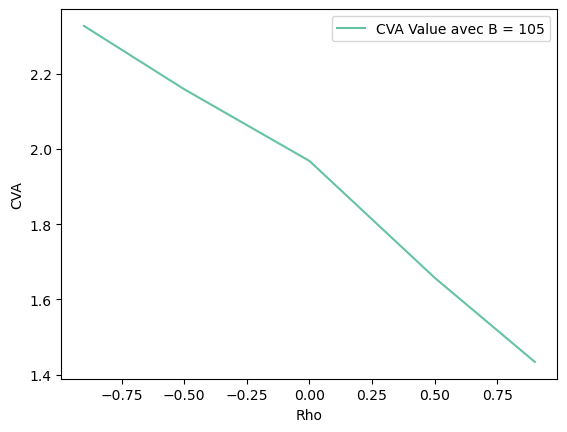

In [893]:
CVABarrier=[]
RhoDefault=[-0.9,-0.5,0,0.5,0.9]

for rho in RhoDefault:
    _,CVA=CVABarrierOptionHestonModel(S0,t,T,K,B,r,sigma, rho, 
                          NbrSteps, NbrPaths) 
    CVABarrier.append(CVA)
    
    
plt.plot(RhoDefault,CVABarrier,label="CVA Value avec B = " + str(B))
plt.xlabel("Rho")
plt.ylabel("CVA")
plt.legend()

In [5]:
def EEProfileBarrierOptionBSModel(S0,t=0,T=1,K=100,B=110, r=0.03, sigma=0.2,rho=0, 
                          NbrSteps=50, NbrPaths=1000):
    
    
    # Setting Parameters
    dt = (T-t) / NbrSteps
    
    
    
    # CIR Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
        
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)
    
    # Defining 
    S=np.ones(([NbrPaths, NbrSteps]))
    λ=np.zeros(([NbrPaths,NbrSteps])) # Default Intensity
    integralλ=np.zeros(([NbrPaths,NbrSteps]))
    Survival=np.ones(([NbrPaths,NbrSteps]))
    Exposure=np.zeros((NbrPaths))
    Payoff=np.zeros([NbrPaths])
    
    S[:,0]=  S0
    #v[:,0] = v0
    λ[:,0]=lambda0
    
    
    etaBarrierWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaBarrierNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    EEBarrierWWR=np.zeros(([NbrSteps]))
    EEBarrierNoWWR=np.zeros(([NbrSteps]))
    
    
     
    NbrStepsInner=20
    NbrPathsInner=5000

    
    for i in range(1,NbrSteps):
        WT = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rho,],[rho,1]]), size=NbrPaths) * np.sqrt(dt) 
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT[:,0])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))*WT[:,1]
        integralλ[:,i] = integralλ[:,i-1] + ((λ[:,i-1]+λ[:,i])*0.5*dt)
        Survival[:,i]=Survival[:,i-1]*np.exp(-(λ[:,i]+λ[:,i-1])*0.5*dt)


    def BarrierOptionHestonModel(S0,t,T,K,B,r,sigma,NbrPaths,NbrSteps):
        # B : Barrière
        # r : Interest Free Rate
        # K : Strike
    
    
    
        dt = (T-t) / NbrSteps
        S=np.ones(([NbrPaths, NbrSteps]))
        v = np.zeros([NbrPaths, NbrSteps])
        Payoff=np.zeros([NbrPaths,NbrSteps])
        S[:,0]=S0
        
        #mean= [0,0]
        #cov=[[1,rhoAsset],[rhoAsset,1]]
        for j in range(1,NbrSteps):
            WT = np.random.normal(0,1,size=NbrPaths)
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + sigma *np.sqrt(dt)* WT)
        #v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqrt(v[:,j-1])*WT[:,1])
            
            
        for i in range(NbrPaths):
            if max(S[i,:]) <= B :
                Payoff[i]=np.exp(-r*(T-t)) * np.maximum(S[i,-1] -K,0)
            else:
                Payoff[i]=0
        price=np.mean(Payoff)
        return S,v,price
  
        
        
    CVABarrierWWR=0
    CVABarrierNoWWR=0
    RecoveryRate=0.4
    
    for j in tqdm(range(NbrSteps)):
        current_t=float(j*dt)
        current_priceBarrier=np.zeros((NbrPaths))
        for sample in range(NbrPaths):
            current_S=S[sample,j]
            if max(S[sample,:j+1]) > B:
                current_priceBarrier[sample]=0
            else:
                _,_,price=BarrierOptionHestonModel(current_S,current_t,T,K,B,r,sigma,NbrPathsInner,NbrStepsInner)
                current_priceBarrier[sample]=price
            
        
        etaBarrierWWR[:,j]=(np.exp(-r*current_t) * (current_priceBarrier*λ[:,j]*Survival[:,j]) )/ (h(current_t) * Gfunc(current_t))
        etaBarrierNoWWR[:,j]=np.exp(-r*current_t) * (current_priceBarrier)
        
        EEBarrierWWR[j]=np.mean(etaBarrierWWR[:,j])
        EEBarrierNoWWR[j]=np.mean(etaBarrierNoWWR[:,j])
       
        
        CVABarrierWWR   += - (1-RecoveryRate) * EEBarrierWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
        CVABarrierNoWWR += - (1-RecoveryRate) * EEBarrierNoWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
   
    
    return EEBarrierWWR,CVABarrierWWR,EEBarrierNoWWR,CVABarrierNoWWR

    

In [106]:
def AsianOptionBSModel(S0,t,T,K,B,r,sigma,NbrPaths,NbrSteps):
        # B : Barrière
        # r : Interest Free Rate
        # K : Strike
    
    
    
        dt = (T-t) / NbrSteps
        S=np.ones(([NbrPaths, NbrSteps]))
        v = np.zeros([NbrPaths, NbrSteps])
        Payoff=np.zeros([NbrPaths,NbrSteps])
        S[:,0]=S0
        
        #mean= [0,0]
        #cov=[[1,rhoAsset],[rhoAsset,1]]
        for j in range(1,NbrSteps):
            WT = np.random.normal(0,1,size=NbrPaths)
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + sigma *np.sqrt(dt)* WT)
        #v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqrt(v[:,j-1])*WT[:,1])
            
            
        for i in range(NbrPaths):
            Payoff[i]=np.exp(-r*(T-t)) * np.maximum(sum(S[i,:])*dt -K,0)
        price=np.mean(Payoff)
        return S,v,price

In [110]:
sigma=0.05
r=0.01
t=0.5
T=1
_,_,price =AsianOptionBSModel(S0,t,T,K,B,r,sigma,10000,20)

2024.9355113792767
1984.1955088581415
2006.4155040320168
1968.7185901102182
2002.4552002785915
2007.1531763858184
1946.4473706158417
2076.382144666522
2046.1838719251912
2012.142866420177
1977.8610737747458
1945.9926948725404
2079.4377042934734
1991.2470263006549
1985.8990798718555
2026.2504792912425
1982.3015359621606
2013.8256733172002
1918.9046191377854
2029.3516407920406
1978.8237837572497
1991.199414493029
2066.1079252095933
2021.5253385339781
1968.438420239461
1969.5964835308469
1989.3839215097935
2055.171966584312
1945.4144766568504
2001.474138655376
2006.6846228739541
1977.8573753985454
2040.0635531751616
2015.7799430126076
1914.6226297206208
2004.841921739392
1993.0847059631492
2027.4350047550327
2063.7575348247888
1933.4942914433252
1954.725269814324
2053.3159901641866
2081.823854565343
1997.4716793931807
1934.4182397498118
1982.1529213521192
2018.1568010326616
1965.4011917956943
1995.7885552465254
2025.0239006608574
2019.4540172145375
2052.746543811811
2076.579800658807
2002

In [ ]:
RhoDefault=[-0.9,-0.5,0,0.5,0.9]
#RhoDefault = [0]
S0=100
t=0
T=1
K=100
B=140
r=0.02
sigma=0.1
NbrSteps=20
NbrPaths=10000


EEValueBarrierWWR=[]
EEValueBarrierNoWWR=[]
CVAValueBarrierWWR=[]
CVAValueBarrierNoWWR=[]

#EEForward,CVAForward
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
time=np.linspace(t,T,NbrSteps)
for rhoD in tqdm(RhoDefault):
    EEBarrierWWR,CVABarrierWWR,EEBarrierNoWWR,CVABarrierNoWWR=EEProfileBarrierOptionBSModel(S0,t,T,K,B,r,sigma,rhoD,NbrSteps,NbrPaths)
    EEValueBarrierWWR.append(EEBarrierWWR)
    EEValueBarrierNoWWR.append(EEBarrierNoWWR)
    CVAValueBarrierWWR.append(CVABarrierWWR)
    CVAValueBarrierNoWWR.append(CVABarrierNoWWR)
    ax[0][0].plot(time,EEBarrierWWR,label="Rho = " + str(rhoD))
    

    
#ax[0][0].plot(time,EEBarrierNoWWR,label="Rho = "+str(rho))

ax[0][0].set_title("EE Profile for a Barrier Put Option under B-S Model")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("EE Profile")
ax[0][0].legend(loc="upper left")


ax[0][1].plot(RhoDefault,CVAValueBarrierWWR,label="CVA WWR")
ax[0][1].plot(RhoDefault,CVAValueBarrierNoWWR,label="CVA No WWR")
ax[0][1].plot()
ax[0][1].set_title("CVA of a Barrier Put Option as a function of Rho")
ax[0][1].set_xlabel("Rho")
ax[0][1].set_ylabel("CVA")
ax[0][1].legend(loc="upper right")


plt.legend()

 15%|███████████▍                                                                | 3/20 [2:26:12<10:15:05, 2170.94s/it]

 60%|█████████████████████████████████████████████                              | 3/5 [26:06:39<17:24:26, 31333.19s/it]


KeyboardInterrupt: 

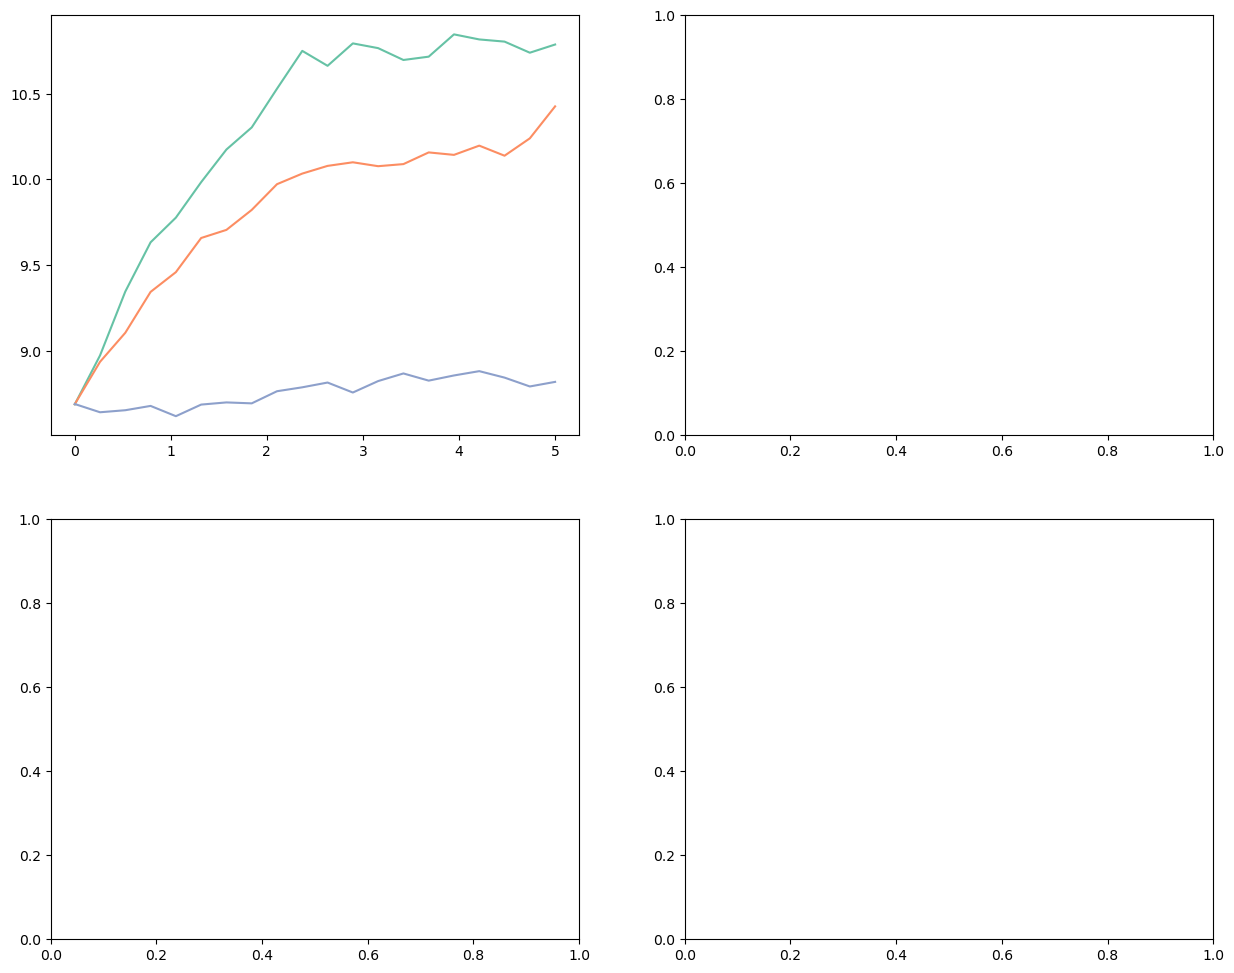

In [33]:
RhoDefault=[-0.9,-0.5,0,0.5,0.9]
#RhoDefault=[0]
S0=100
t=0
T=5
K=100
B=110
r=0
sigma=0.1
NbrSteps=20
NbrPaths=5000


EEValueBarrierWWR=[]
EEValueBarrierNoWWR=[]
CVAValueBarrierWWR=[]
CVAValueBarrierNoWWR=[]

#EEForward,CVAForward
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
time=np.linspace(t,T,NbrSteps)
for rhoD in tqdm(RhoDefault):
    EEBarrierWWR,CVABarrierWWR,EEBarrierNoWWR,CVABarrierNoWWR=EEProfileBarrierOptionBSModel(S0,t,T,K,B,r,sigma,rhoD,NbrSteps,NbrPaths)
    EEValueBarrierWWR.append(EEBarrierWWR)
    EEValueBarrierNoWWR.append(EEBarrierNoWWR)
    CVAValueBarrierWWR.append(CVABarrierWWR)
    CVAValueBarrierNoWWR.append(CVABarrierNoWWR)
    ax[0][0].plot(time,EEBarrierWWR,label="Rho = " + str(rhoD))
    

    
#ax[0][0].plot(time,EEBarrierNoWWR,label="Rho = "+str(rho))

ax[0][0].set_title("EE Profile for a Barrier Put Option under B-S Model")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("EE Profile")
ax[0][0].legend(loc="upper left")


ax[0][1].plot(RhoDefault,CVAValueBarrierWWR,label="CVA WWR")
ax[0][1].plot(RhoDefault,CVAValueBarrierNoWWR,label="CVA No WWR")
ax[0][1].plot()
ax[0][1].set_title("CVA of a Barrier Put Option as a function of Rho")
ax[0][1].set_xlabel("Rho")
ax[0][1].set_ylabel("CVA")
ax[0][1].legend(loc="upper right")


plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:30:23<00:00, 1804.66s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


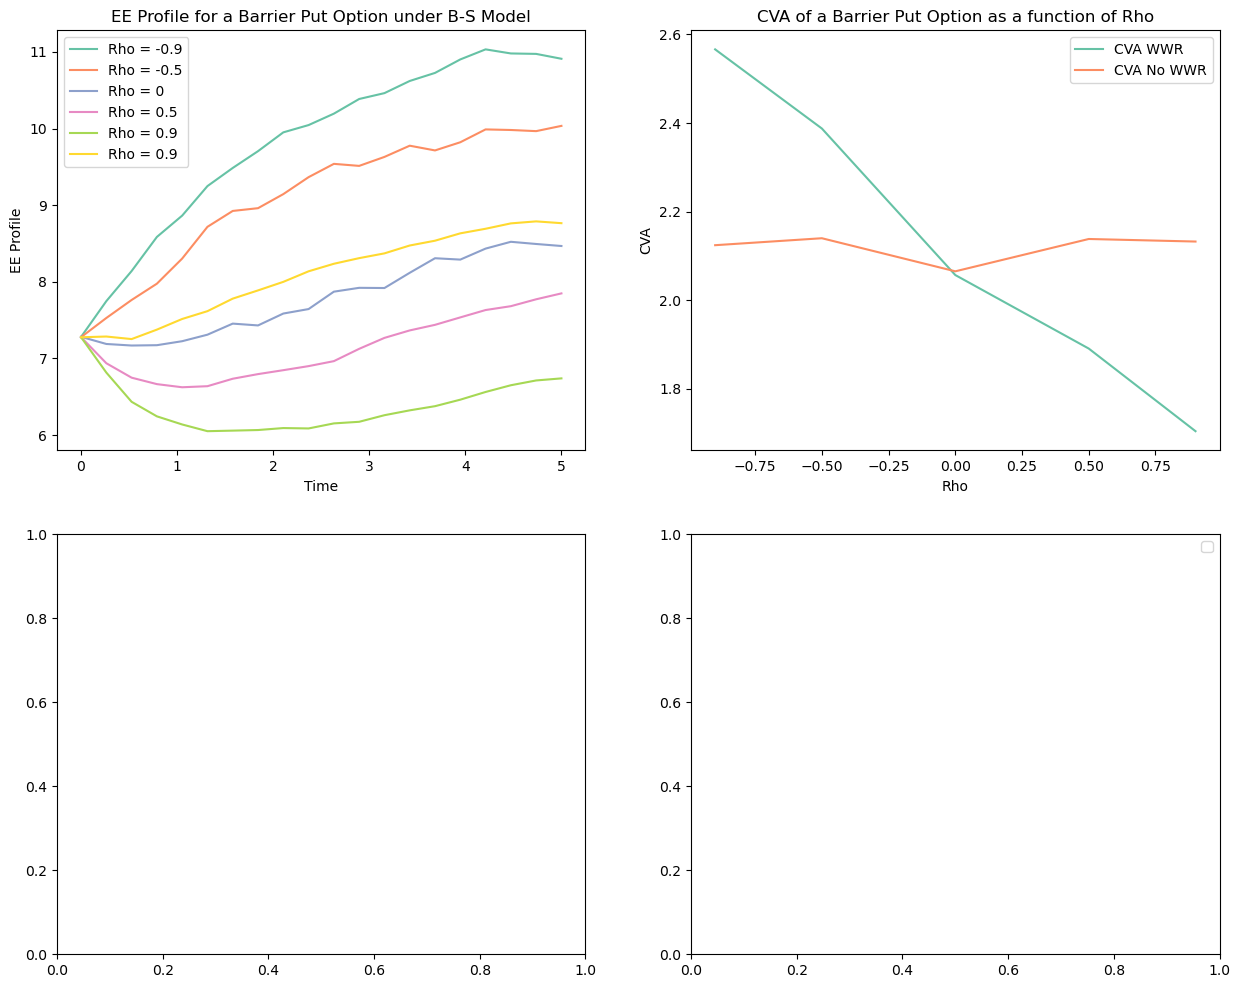

In [941]:
RhoDefault=[-0.9,-0.5,0,0.5,0.9]

S0=100
t=0
T=5
K=100
B=110
r=0
sigma=0.1
NbrSteps=20
NbrPaths=10000


EEValueBarrierWWR=[]
EEValueBarrierNoWWR=[]
CVAValueBarrierWWR=[]
CVAValueBarrierNoWWR=[]

#EEForward,CVAForward
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
time=np.linspace(t,T,NbrSteps)
for rhoD in tqdm(RhoDefault):
    EEBarrierWWR,CVABarrierWWR,EEBarrierNoWWR,CVABarrierNoWWR=EEProfileBarrierOptionBSModel(S0,t,T,K,B,r,sigma,rhoD,NbrSteps,NbrPaths)
    EEValueBarrierWWR.append(EEBarrierWWR)
    EEValueBarrierNoWWR.append(EEBarrierNoWWR)
    CVAValueBarrierWWR.append(CVABarrierWWR)
    CVAValueBarrierNoWWR.append(CVABarrierNoWWR)
    ax[0][0].plot(time,EEBarrierWWR,label="Rho = " + str(rhoD))
    

    
#ax[0][0].plot(time,EEBarrierNoWWR,label="Rho = "+str(rho))

ax[0][0].set_title("EE Profile for a Barrier Put Option under B-S Model")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("EE Profile")
ax[0][0].legend(loc="upper left")


ax[0][1].plot(RhoDefault,CVAValueBarrierWWR,label="CVA WWR")
ax[0][1].plot(RhoDefault,CVAValueBarrierNoWWR,label="CVA No WWR")
ax[0][1].plot()
ax[0][1].set_title("CVA of a Barrier Put Option as a function of Rho")
ax[0][1].set_xlabel("Rho")
ax[0][1].set_ylabel("CVA")
ax[0][1].legend(loc="upper right")


plt.legend()

<h3> A Cliquet Option under BS-Model : </h3>

In [942]:
def CliquetOptionBSModel(S0=1, t=0,T=5, r=0.03,sigma=0.1, 
                          NbrSteps=51, NbrPaths=10000,nbFixings=2):
        
        
        dt = (T-t) / NbrSteps
        Cap = 0.32
        Floor = 0.16
    
        FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
        StartingIndex= int((NbrSteps-1)*t / T)
        
    
        
        NbRefixing = len(FixingTimes[FixingTimes > StartingIndex]) + 1
        S=np.ones(([NbrPaths, NbrSteps+1]))
        R=np.zeros([NbrPaths,NbRefixing])
        Return=np.zeros([NbrPaths,NbRefixing-1])
        
        
        R[:,0]=S0
        S[:,0]=S0
        
        
        
        current_index=1
        for i in range(StartingIndex,NbrSteps + StartingIndex):
            j= (i +1 - StartingIndex)
            WT = np.random.normal(0,1,size=NbrPaths)
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + sigma *np.sqrt(dt)* WT)
            #v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqr        
         
            


            if i in FixingTimes[FixingTimes > StartingIndex] :
                R[:,current_index]=S[:,j-1]
                Return[:,current_index-1] = np.maximum(0,np.minimum((R[:,current_index] / R[:,current_index-1])-1,Cap))
                current_index+=1
                

        Payoff=np.exp(-r*(T-t))*np.maximum(np.sum(Return,axis=1),Floor)
        price=np.mean(Payoff)
        return S,R,Return,price
        

In [946]:
def CVACliquetOptionBSModel(S=1, t=0,T=5, r=0.03,rho=0, sigma=0.1, 
                          NbrSteps=51, NbrPaths=10000,nbFixings=6):
    
    
    
    
    # Setting Parameters
    dt = (T-t) / NbrSteps
    Cap = 0.32
    Floor = 0.16
    
    FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
    
    # CIR Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0   =0.12
    
    # Defining 
    S=np.ones(([NbrPaths, NbrSteps]))
    R=np.zeros([NbrPaths,nbFixings])
    Return=np.zeros([NbrPaths,nbFixings-1])
    
    λ=np.zeros(([NbrPaths,NbrSteps])) # Default Intensity
    integralλ=np.zeros(([NbrPaths,NbrSteps]))
    DefaultTime=np.zeros((NbrPaths))
    Exposure=np.zeros((NbrPaths))
    
    R[:,0]=  S0
    S[:,0]=  S0
    λ[:,0]=lambda0

    
    NbrStepsInner=51
    NbrPathsInner=10000
    #first_index = 1 + int((t* (NbrSteps-1)) / T)
    for i in range(1,NbrSteps):
        WT = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rho,],[rho,1]]), size=NbrPaths) * np.sqrt(dt) 
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT[:,0])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))*WT[:,1]
        integralλ[:,i] = integralλ[:,i-1] + ((λ[:,i-1]+λ[:,i])*0.5*dt)

            
    def CliquetOptionBSModel(S0, t,T, r,sigma, 
                          NbrSteps, NbrPaths,nbFxings):
        
        
        dt = (T-t) / NbrSteps
        Cap = 0.32
        Floor = 0.16
    
        FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
        StartingIndex= int((NbrSteps-1)*t / T)
        
    
        
        NbRefixing = len(FixingTimes[FixingTimes > StartingIndex]) + 1
        S=np.ones(([NbrPaths, NbrSteps+1]))
        R=np.zeros([NbrPaths,NbRefixing])
        Return=np.zeros([NbrPaths,NbRefixing-1])
        
        
        R[:,0]=S0
        S[:,0]=S0
        
        
        
        current_index=1
        for i in range(StartingIndex,NbrSteps + StartingIndex):
            j= (i +1 - StartingIndex)
            WT = np.random.normal(0,1,size=NbrPaths)
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + sigma *np.sqrt(dt)* WT)
            #v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqr        
         
            


            if i in FixingTimes[FixingTimes > StartingIndex] :
                R[:,current_index]=S[:,j-1]
                Return[:,current_index-1] = np.maximum(0,np.minimum((R[:,current_index] / R[:,current_index-1])-1,Cap))
                current_index+=1
                

        Payoff=np.exp(-r*(T-t))*np.maximum(np.sum(Return,axis=1),Floor)
        price=np.mean(Payoff)
        return S,R,Return,price
        
    
        
        
        
            
    exponential_samples=np.random.exponential(size=NbrPaths)
    
    for i in range(NbrPaths):
        exponential_sample=exponential_samples[i]
        current_path=integralλ[i,:]
        if current_path[-1] < exponential_sample:
            DefaultTime[i]= 2*T # Temps de Défaut > T 
        else:
            j=0
            while current_path[j] < exponential_sample:
                j+=1
            DefaultTime[i]=j*dt
        
    for sample in tqdm(range(NbrPaths)):
        default_time = DefaultTime[sample]
        index_default= int(default_time / dt)
        if default_time < T :
            current_S=S[sample,index_default]
            _,_,_,price=CliquetOptionBSModel(current_S,default_time,T,r, sigma, 
                          NbrStepsInner, NbrPathsInner,nbFixings)
            Exposure[sample]=np.exp(-r* default_time) * price 
        else:
            Exposure[sample]=0
       
    
    
    RecoveryRate = 0.4
    CVA=(1-RecoveryRate) * np.mean(Exposure)
    
    return DefaultTime,CVA



                          

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:59<00:00, 167.07it/s]


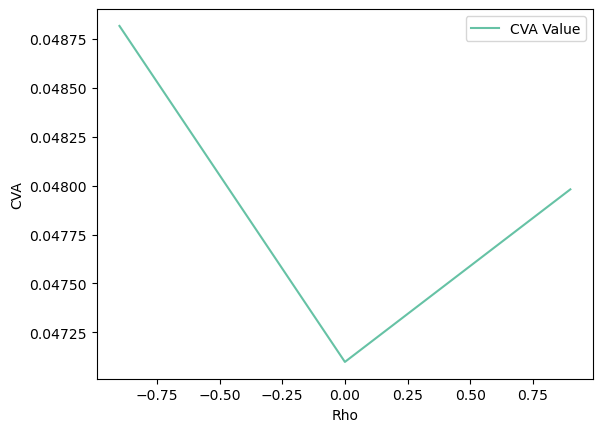

In [951]:
RhoDefault=[-0.9,0,0.9]
S0=1
t=0
T=5
r=0
sigma=0.1
NbrSteps=51
NbFixings=6
NbrPaths=10000

CVACliquet=[]
for rho in RhoDefault:
    _,CVA=CVACliquetOptionBSModel(S0,t,T,r,rho, sigma, 
                          NbrSteps, NbrPaths,NbFixings) 
    CVACliquet.append(CVA)
    
    
plt.plot(RhoDefault,CVACliquet,label="CVA Value")
plt.xlabel("Rho")
plt.ylabel("CVA")
plt.legend()

In [ ]:
def EEProfileCliquetOptionBSModel(S0,t=0,T=1, r=0.03, sigma=0.2,rho=0, 
                          NbrSteps=50, NbrPaths=10000,nbFixings=6):
    
    
    # Setting Parameters
    dt = (T-t) / NbrSteps
    
    
    
    # CIR Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
        
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)
    
    # Defining 
    S=np.ones(([NbrPaths, NbrSteps]))
    λ=np.zeros(([NbrPaths,NbrSteps])) # Default Intensity
    integralλ=np.zeros(([NbrPaths,NbrSteps]))
    Survival=np.ones(([NbrPaths,NbrSteps]))
    Exposure=np.zeros((NbrPaths))
    Payoff=np.zeros([NbrPaths])
    
    S[:,0]=  S0
    #v[:,0] = v0
    λ[:,0]=lambda0
    
    
    etaBarrierWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaBarrierNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    EEBarrierWWR=np.zeros(([NbrSteps]))
    EEBarrierNoWWR=np.zeros(([NbrSteps]))
    
    
     
    NbrStepsInner=20
    NbrPathsInner=5000

    
    for i in range(1,NbrSteps):
        WT = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rho,],[rho,1]]), size=NbrPaths) * np.sqrt(dt) 
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT[:,0])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))*WT[:,1]
        integralλ[:,i] = integralλ[:,i-1] + ((λ[:,i-1]+λ[:,i])*0.5*dt)
        Survival[:,i]=Survival[:,i-1]*np.exp(-(λ[:,i]+λ[:,i-1])*0.5*dt)


    def CliquetOptionBSModel(S0=1, t=0,T=5, r=0.03,sigma=0.1, 
                          NbrSteps=51, NbrPaths=10000,nbFixings=6):
        
        
        dt = (T-t) / NbrSteps
        Cap = 0.32
        Floor = 0.16
    
        FixingTimes=np.linspace(0,NbrSteps-1, nbFixings).astype(int)
        StartingIndex= int((NbrSteps-1)*t / T)
        
    
        
        NbRefixing = len(FixingTimes[FixingTimes > StartingIndex]) + 1
        S=np.ones(([NbrPaths, NbrSteps+1]))
        R=np.zeros([NbrPaths,NbRefixing])
        Return=np.zeros([NbrPaths,NbRefixing-1])
        
        
        R[:,0]=S0
        S[:,0]=S0
        
        
        
        current_index=1
        for i in range(StartingIndex,NbrSteps + StartingIndex):
            j= (i +1 - StartingIndex)
            WT = np.random.normal(0,1,size=NbrPaths)
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + sigma *np.sqrt(dt)* WT)
            #v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqr        
         
            


            if i in FixingTimes[FixingTimes > StartingIndex] :
                R[:,current_index]=S[:,j-1]
                Return[:,current_index-1] = np.maximum(0,np.minimum((R[:,current_index] / R[:,current_index-1])-1,Cap))
                current_index+=1
                

        Payoff=np.exp(-r*(T-t))*np.maximum(np.sum(Return,axis=1),Floor)
        price=np.mean(Payoff)
        return S,R,Return,price
  
        
        
    CVABarrierWWR=0
    CVABarrierNoWWR=0
    RecoveryRate=0.4
    
    for j in tqdm(range(NbrSteps)):
        current_t=float(j*dt)
        current_priceBarrier=np.zeros((NbrPaths))
        for sample in range(NbrPaths):
            current_S=S[sample,j]
            _,_,price=CliquetOptionBSModel(current_S,current_t,T,r,sigma,NbrStepsInner,NbrPathsInner,NbFixings)
            current_priceBarrier[sample]=price
            
        
        etaBarrierWWR[:,j]=(np.exp(-r*current_t) * (current_priceBarrier*λ[:,j]*Survival[:,j]) )/ (h(current_t) * Gfunc(current_t))
        etaBarrierNoWWR[:,j]=np.exp(-r*current_t) * (current_priceBarrier)
        
        EEBarrierWWR[j]=np.mean(etaBarrierWWR[:,j])
        EEBarrierNoWWR[j]=np.mean(etaBarrierNoWWR[:,j])
       
        
        CVABarrierWWR   += - (1-RecoveryRate) * EEBarrierWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
        CVABarrierNoWWR += - (1-RecoveryRate) * EEBarrierNoWWR[j] * (Gfunc(current_t + dt) - Gfunc(current_t))
   
    
    return EEBarrierWWR,CVABarrierWWR,EEBarrierNoWWR,CVABarrierNoWWR

    

In [ ]:
RhoDefault=[-0.9,-0.5,0,0.5,0.9]

S0=100
t=0
T=5
sigma=0.1
NbrSteps=20
NbrPaths=10000
NbFixings=6

EEValueBarrierWWR=[]
EEValueBarrierNoWWR=[]
CVAValueBarrierWWR=[]
CVAValueBarrierNoWWR=[]

#EEForward,CVAForward
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
time=np.linspace(t,T,NbrSteps)
for rhoD in tqdm(RhoDefault):
    EEBarrierWWR,CVABarrierWWR,EEBarrierNoWWR,CVABarrierNoWWR=EEProfileCliquetOptionBSModel(S0,t,T,r,sigma,rhoD,NbrSteps,NbrPaths,NbFixings)
    EEValueBarrierWWR.append(EEBarrierWWR)
    EEValueBarrierNoWWR.append(EEBarrierNoWWR)
    CVAValueBarrierWWR.append(CVABarrierWWR)
    CVAValueBarrierNoWWR.append(CVABarrierNoWWR)
    ax[0][0].plot(time,EEBarrierWWR,label="Rho = " + str(rhoD))
    

    
#ax[0][0].plot(time,EEBarrierNoWWR,label="Rho = "+str(rho))

ax[0][0].set_title("EE Profile of a Cliquet Option under B-S Model")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("EE Profile")
ax[0][0].legend(loc="upper left")


ax[0][1].plot(RhoDefault,CVAValueBarrierWWR,label="CVA WWR")
ax[0][1].plot(RhoDefault,CVAValueBarrierNoWWR,label="CVA No WWR")
ax[0][1].plot()
ax[0][1].set_title("CVA of a Cliquet Option as a function of Rho")
ax[0][1].set_xlabel("Rho")
ax[0][1].set_ylabel("CVA")
ax[0][1].legend(loc="upper right")


plt.legend()